In [1]:


import requests
from bs4 import BeautifulSoup
from datetime import datetime,timedelta
import pandas as pd
import numpy as np
saat=datetime.now().hour
import cloudscraper
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor,as_completed
simdi = datetime.now()
saat1 = simdi.hour
dakika = simdi.minute


saatimm=datetime.now().hour


import time
tarih=pd.read_csv("tarih.csv")
tarih=pd.to_datetime(tarih.iloc[0,0])


# Döngü çalışabilir durumda
print("Döngü başladı, saat:", simdi.strftime("%H:%M:%S"))

            

bugün=datetime.now().strftime("%Y-%m-%d")



dün=(datetime.now()-timedelta(days=1)).strftime("%Y-%m-%d")


data=pd.read_csv("marketli.csv",index_col=0)

data=data.rename(columns={"Ürün Adı":"Ürün"})

data.index.name=""
"""del data["Market"]
del data["Şehir"]"""


try:
    data=data.drop(f"{bugün}",axis=1)
except:
    pass










def veriekle(ürün, data, urunler_df):
    bugün=datetime.now().strftime("%Y-%m-%d")
    if urunler_df is None or urunler_df.empty:
        return data

    urunler_df = urunler_df.drop_duplicates()

    # Ürün verisini DataFrame olarak al
    urun_data = pd.DataFrame(data.loc[ürün])
    if isinstance(data.loc[ürün], pd.Series):
        urun_data = urun_data.T

    # Merge işlemi
    urun_data = pd.merge(
        urun_data,
        urunler_df,
        on=['Ürün', 'Şehir','Market'],
        how='outer'
    )

    # Çakışan sütunları birleştir
    for col in ['Market', 'Şehir', bugün]:
        x_col = f'{col}_x'
        y_col = f'{col}_y'
        if x_col in urun_data.columns and y_col in urun_data.columns:
            urun_data[col] = urun_data[x_col].combine_first(urun_data[y_col])
            urun_data.drop([x_col, y_col], axis=1, inplace=True)

    # İndeksi düzenle
    urun_data = urun_data.set_index([[ürün] * len(urun_data)])

    # Mevcut ürünü veri setinden çıkar
    data = data.drop(ürün, axis=0)

    # Yeni veriyi ekle
    data = pd.concat([data, urun_data], axis=0)

    return data

            







import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager






import re
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import pandas as pd
from webdriver_manager.chrome import ChromeDriverManager

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time
#data.append({"Product Name": name, "Price (TRY)": final_price,"Market":"Şok","Şehir":"Türkiye"})

def scrape_sok(params):
    category=params[0]
    search=params[1]
    url = "https://www.sokmarket.com.tr/api/v1/search"
    rows=[]
    params = {
        "cat": category,
        "sort": "SCORE_DESC",
        "page": "0",
        "size": "10000",
        "pgt": "CATEGORY_LISTING",
        "q":search
    }

    headers = {
        "accept": "*/*",
        "accept-encoding": "gzip, deflate, br, zstd",
        "accept-language": "tr-TR",
        "cache-control": "max-age=0",
        "content-type": "application/json",
        "cookie": "X-Ecommerce-Deviceid=37b5599f-59bb-4171-bd21-2f775b185c2a-6cc22c36-2633-4b65-9349-351728e1d1fd; X-Store-Id=13412; _gcl_au=1.1.1531286323.1747726737; _ga=GA1.1.686513494.1747726738; _fbp=fb.2.1747726738700.567079831800412223; OptanonAlertBoxClosed=2025-05-20T07:45:33.506Z; X-Ecommerce-Sid=8bd86249-fa5e-4e98-b412-49e787939169-053a277e-1ddc-4d70-b6e9-ff9d1e773435; X-Platform=WEB; X-Service-Type=MARKET; access_token=FNlmBCX9Ep544pj9IfZztWgr0ynlG3Dc-a8t7h5rsXEtGhsJhWLUbbFTGXw0qMmS3; OptanonConsent=isGpcEnabled=0&datestamp=Tue+May+20+2025+19%3A11%3A02+GMT%2B0300+(GMT%2B03%3A00)&version=202308.2.0&browserGpcFlag=0&isIABGlobal=false&hosts=&landingPath=NotLandingPage&groups=C0001%3A1%2CC0002%3A1%2CC0004%3A1%2CC0003%3A1&AwaitingReconsent=false&geolocation=TR%3B34; _dn_sid=69a05460-145e-41d7-9bba-412966a18fe5; _ga_97YKG29ZHZ=GS2.1.s1747757462$o2$g1$t1747757474$j48$l0$h626894773$d_D7QqewoZ_GH-WRzDVVezEERjUX6MzCqYA",
        "priority": "u=1, i",
        "referer": "https://www.sokmarket.com.tr/meyve-ve-sebze-c-20",
        "sec-ch-ua": '"Chromium";v="136", "Google Chrome";v="136", "Not.A/Brand";v="99"',
        "sec-ch-ua-mobile": "?0",
        "sec-ch-ua-platform": '"Windows"',
        "sec-fetch-dest": "empty",
        "sec-fetch-mode": "cors",
        "sec-fetch-site": "same-origin",
        "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36",
        "x-app-version": "3dc7f4ee",
        "x-ecommerce-deviceid": "37b5599f-59bb-4171-bd21-2f775b185c2a-6cc22c36-2633-4b65-9349-351728e1d1fd",
        "x-ecommerce-sid": "8bd86249-fa5e-4e98-b412-49e787939169-053a277e-1ddc-4d70-b6e9-ff9d1e773435",
        "x-platform": "WEB",
        "x-service-type": "MARKET",
        "x-store-id": "13412"
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        df = response.json()
    else:
        print(f"Hata: {response.status_code}")


    results=df.get("results")
    for result in results:
        crumbs=result.get("sku").get("breadCrumbs")[-1]
        name=result.get("product").get("name")
        disc=result.get("prices").get("discounted").get("value")
        org=result.get("prices").get("original").get("value")
      
            
        path=crumbs.get("path")
       
        rows.append({"Product Name":name,"Price (TRY)":disc,"Market":"Şok","Şehir":"Türkiye"})

    return pd.DataFrame(rows)







def clean_price(price_text):
    price_text = price_text.replace("TL", "").strip()  # "TL" ibaresini kaldır
    price_text = price_text.replace(",", ".")  # Türkçe ondalık formatı düzelt
    try:
        return float(price_text)
    except ValueError:
        return None
def scrape_migros_products(pages):
    urunad = []
    urunfiyat = []

    headers = {
        "User-Agent": "Mozilla/5.0",
        "Accept": "application/json, text/plain, */*"
    }

    scraper = cloudscraper.CloudScraper()

    def sayfa_sayisi(url):
        return scraper.get(url, headers=headers).json()["data"]["searchInfo"]["pageCount"]

    def sayfa_verisini_cek(url, sayfa):
        response = scraper.get(f"{url}?page={sayfa}", headers=headers).json()
        return response["data"]["searchInfo"]["storeProductInfos"]

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for i in pages:
            try:
                sayfa_sayisi_val = sayfa_sayisi(i)
                for j in range(1, sayfa_sayisi_val + 1):
                    futures.append(executor.submit(sayfa_verisini_cek, i, j))
            except Exception as e:
                print(f"⚠️ Sayfa sayısı belirlenirken hata oluştu: {e}")

        for future in as_completed(futures):
            try:
                info = future.result()
                for urun in info:
                    urunad.append(urun.get("name"))
                    urunfiyat.append(int(urun.get("shownPrice")) / 100)
            except Exception as e:
                print(f"⚠️ Sayfa verisi çekerken hata oluştu: {e}")

    veri = pd.DataFrame({"Product Name": urunad, "Price (TRY)": urunfiyat,"Market":"Migros","Şehir":"Türkiye"})
    print("✅ Migros verisi çekildi!")
    return veri

"""def scrape_carrefour_products(pages):
    print("🔍 Carrefour verisi çekiliyor...")

    options = Options()
    options.add_argument("--headless")  
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")  # User-Agent
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    carrefour_data = []

    for url in pages:
        print(f"📌 Scraping URL: {url}")
        driver.get(url)

        try:
            WebDriverWait(driver, 2).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "li.product-listing-item"))
            )

            last_height = driver.execute_script("return document.body.scrollHeight")
            while True:
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(1)  
                new_height = driver.execute_script("return document.body.scrollHeight")
                if new_height == last_height:  
                    break
                last_height = new_height

            
            products = driver.find_elements(By.CSS_SELECTOR, "li.product-listing-item")
            print(f"✅ Toplam Ürün Sayısı: {len(products)}")

            for product in products:
                try:
                
                    try:
                        name_element = product.find_element(By.CSS_SELECTOR, "h3.item-name")
                        product_name = name_element.text.strip()
                    except:
                        pass
                    try:
                        price_element = product.find_element(By.CSS_SELECTOR, "span.priceLineThrough.js-variant-price")
                        product_price_text = price_element.text.strip()
                    except:
                        try:
                            price_element = product.find_element(By.CSS_SELECTOR, "span.item-price.js-variant-discounted-price")
                            product_price_text = price_element.text.strip()
                        except:
                            pass

                    product_price = clean_price(product_price_text)

                    if product_name and product_price is not None:
                        carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                        print(f"✅ Collected - Product: {product_name}, Price: {product_price} TRY")

                except Exception as e:
                    print(f"⚠️ Hata oluştu: {e}")

        except Exception as e:
            print(f"❌ Timeout veya başka hata oluştu: {e}")

        

    driver.quit()
    return carrefour_data"""

import requests
from bs4 import BeautifulSoup

def clean_price(price_str):
    try:
        return float(price_str.replace(".", "").replace(",", ".").replace("TL", "").strip())
    except:
        return None

def scrape_carrefour_products(pages):
    print("🔍 Carrefour verisi çekiliyor...")

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    carrefour_data = []

    for url in pages:

        print(f"📌 Scraping URL: {url}")
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "html.parser")

            products = soup.select("li.product-listing-item")
            print(f"✅ Toplam Ürün Sayısı: {len(products)}")

            for product in products:
          
                name_element = product.select_one("h3.item-name")
                try:
                    product_price = float(product.find('span', class_='item-price js-variant-discounted-price')['content']) # İndirimsiz fiyat
                    if not product_price:
                        price_element= product.select_one("span.priceLineThrough.js-variant-price")
                        product_price_text = price_element.text.strip() if price_element else None
                        product_price = clean_price(product_price_text)
                except:
                    print("Fiyat bulunamadı")

    


                product_name = name_element.text.strip() if name_element else None
                market="Carrefour"
                şehir="Türkiye"
                if product_name and product_price is not None:
                    carrefour_data.append({
                        "Product Name": product_name,
                        "Price (TRY)": product_price,
                        "Market":market,
                        "Şehir":şehir
                    })
                    print(f"✅ Collected - Product: {product_name}, Price: {product_price} TRY")

                

        except Exception as e:
            print(f"❌ Sayfa çekilemedi: {e}")


    return carrefour_data


# 📌 Ana Fonksiyon
import time
import pandas as pd
import numpy as np

def vericek(carrefour, migros, sok, name, retry_count=3):
    bugün = time.strftime("%Y-%m-%d")  # Bugünün tarihini al

    for attempt in range(retry_count):
        try:
            print(f"{name} verisi çekiliyor... (deneme {attempt+1}/{retry_count})")

            migros_data = scrape_migros_products(migros)
            if sok!="":
                sok_data = scrape_sok(sok)
            else:
                sok_data = pd.DataFrame()

            carrefour_data = None
            if carrefour:
                carrefour_data = scrape_carrefour_products(carrefour)
                carrefour_data = pd.DataFrame(carrefour_data)

            if carrefour_data is not None and sok_data is not None:
                all_data = pd.concat([migros_data, carrefour_data, sok_data], axis=0)
            else:
                all_data = pd.concat([migros_data, sok_data], axis=0)

            if all_data.empty:
                return pd.DataFrame()

            product_df = all_data.copy()
            

            # Geometrik ortalama hesaplama fonksiyonu
            def geometric_mean(prices):
                return np.exp(np.mean(np.log(prices)))

            


            geo_mean_df = product_df.copy()
            geo_mean_df.columns = ["Price (TRY)", "Product Name","Market","Şehir"]

            urunler_df = geo_mean_df.copy()
            if not urunler_df.empty:
                urunler_df.columns = ["Ürün", str(bugün),"Market","Şehir"]
                urunler_df.index = len(urunler_df) * [name]
                urunler_df = urunler_df.drop_duplicates().dropna()
                return urunler_df

            try:
                all_data.columns = ["Ürün", str(bugün),"Market","Şehir"]
                return all_data
            except:
                return pd.DataFrame()

        except Exception as e:
            print(f"❌ Hata oluştu (deneme {attempt+1}/{retry_count}): {e}")
            time.sleep(2)

    print(f"❗ {name} verisi {retry_count} kez denenmesine rağmen alınamadı.")
    return pd.DataFrame()



import requests
import pandas as pd
from IPython.display import display
import json

import requests
import pandas as pd
from IPython.display import display
import json

def market_fiyat_api(arama_terimi, lat=41.0579, lng=28.9147, distance=10):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Accept-Encoding': 'gzip, deflate',
        'Origin': 'https://marketfiyati.org.tr',
        'Referer': 'https://marketfiyati.org.tr/',
        'Cache-Control': 'no-cache',
        'Pragma': 'no-cache',
        'Connection': 'keep-alive'
    }

    try:
        # Nearest API isteği
        nearest_url = 'https://api.marketfiyati.org.tr/api/v2/nearest'
        nearest_data = {
            'latitude': str(lat),
            'longitude': str(lng),
            'distance': distance
        }

        requests.packages.urllib3.disable_warnings()

        nearest_response = requests.post(
            nearest_url,
            json=nearest_data,
            headers=headers,
            verify=False
        )

        nearest_markets = nearest_response.json()
        depots = [market['id'] for market in nearest_markets]

        # Search API isteği
        search_url = 'https://api.marketfiyati.org.tr/api/v2/search'
        search_data = {
            'keywords': arama_terimi,
            'pages': 0,
            'size': 100,
            'depots': depots,
            'latitude': str(lat),
            'longitude': str(lng),
            'distance': distance
        }

        search_response = requests.post(
            search_url,
            json=search_data,
            headers=headers,
            verify=False
        )

        results = search_response.json()

        # Verileri düzenle
        rows = []
        for item in results['content']:
            categories = ", ".join(item.get('categories', []))  # kategorileri virgülle birleştir
            for depot_info in item['productDepotInfoList']:
                row = {
                    'name': item['title'],
                    'brand': item.get('brand', ''),
                    'categories': categories,
                    'marketName': depot_info['marketAdi'],
                    'depotName': depot_info['depotName'],
                    'price': depot_info['price'],
                    'updateDate': depot_info['indexTime'],
                    'marketDistance': depot_info.get('distance', 0)
                }
                rows.append(row)

        df = pd.DataFrame(rows)

        if not df.empty:
            # Tarihi düzenle
            df['updateDate'] = pd.to_datetime(df['updateDate'], format='%d.%m.%Y %H:%M')
            df['updateDate'] = df['updateDate'].dt.strftime('%Y-%m-%d %H:%M')

            # Fiyatları düzenle
            df['price'] = pd.to_numeric(df['price'], errors='coerce')

            # Mesafeyi düzenle
            if 'marketDistance' in df.columns:
                df['marketDistance'] = df['marketDistance'].round(2)
                df = df.rename(columns={'marketDistance': 'mesafe_km'})

            # Sıralama
            df = df.sort_values('price')

            return df

        return pd.DataFrame()

    except Exception as e:
        print(f"Hata oluştu: {str(e)}")
        return pd.DataFrame()



carrefour = ["https://www.carrefoursa.com/pirinc/c/1134?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All#"]
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pirinc-c-427"
]
sok=["1810",""]



urunler_df=vericek(carrefour,migros_pages,sok,"Pirinç")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("pirinç",case=False)]

data=veriekle("Pirinç",data,urunler_df)
    






pages1 = ["https://www.carrefoursa.com/bugday-unu/c/1277?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All#"]

    



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sade-un-c-289b"]

sok=["1782",""]
urunler_df=vericek(pages1,migros_pages,sok,"Buğday Unu")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("mısır|galeta",case=False)]





data=veriekle("Buğday Unu",data,urunler_df)









pages1=["https://www.carrefoursa.com/bebek-mamasi/c/1848?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All#"]
    




migros_pages =["https://www.migros.com.tr/rest/search/screens/devam-sutu-c-1136b"]
sok=["20638",""]

urunler_df=vericek(pages1,migros_pages,sok,"Bebek Sütü (Toz Karışım)")



data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)








pages1 = ["https://www.carrefoursa.com/bulgur/c/1142?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All#"]
    




# Define base URL and total pages to scrape for Migros
migros_pages1= ["https://www.migros.com.tr/rest/search/screens/pilavlik-bulgur-c-2785"]
sok=["1810",""]


urunler_df=vericek(pages1,migros_pages1,sok,"Bulgur")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bulgur",case=False)]

data=veriekle("Bulgur",data,urunler_df)





pages1 = ["https://www.migros.com.tr/rest/search/screens/ekmek-c-455"]
carrefour=["https://www.carrefoursa.com/ekmek/c/2378?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All#"]
sok=["1240",""]    




urunler_df=vericek(carrefour,pages1,sok,"Ekmek")

urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ekmek",case=False)]

data=veriekle("Ekmek",data,urunler_df)






pages1 = ["https://www.carrefoursa.com/biskuvi/c/1529?q=&show=All&%3AbestSeller%3Acategory%3A1534%3Acategory%3A1533%3Acategory%3A1537%3Acategory%3A1530%3Acategory%3A1531%3Acategory%3A1536%3AinStockFlag%3Atrue"]

    
migros=["https://www.migros.com.tr/rest/search/screens/biskuvi-c-43c"]
sok=["20378",""]
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("kraker|gofret",case=False)]
urunler_df=vericek(pages1,migros,sok,"Bisküvi")




data=veriekle("Bisküvi",data,urunler_df)





pages1= ["https://www.carrefoursa.com/kraker/c/1538?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]









# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/kraker-c-27ea"]

sok=["20380",""]

urunler_df=vericek(pages1,migros_pages,sok,"Kraker")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kraker", case=False)]






data=veriekle("Kraker",data,urunler_df)





pages1= ["https://www.carrefoursa.com/bar-ve-gofret/c/1505?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]

migros=["https://www.migros.com.tr/rest/search/screens/gofret-c-43a"]
sok=["20379",""]
urunler_df=vericek(pages1,migros,sok,"Gofret")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("helva", case=False)]


data=veriekle("Gofret",data,urunler_df)









pages1= ["https://www.carrefoursa.com/pastalar/c/1289?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pasta-c-459"]
sok=["54427",""]
urunler_df=vericek(pages1,migros_pages,sok,"Pasta")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("pasta", case=False)]

data=veriekle("Pasta",data,urunler_df)








pages1= ["https://www.carrefoursa.com/mini-kek/c/1547?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/kek-c-43d"]
sok=["20381",""]
urunler_df=vericek(pages1,migros_pages,sok,"Kek")


data=veriekle("Kek",data,urunler_df)









pages1= ["https://www.carrefoursa.com/serbetli-tatli/c/1294?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pastane-tatlilar-c-287b"
]
sok=["20388","baklava"]
urunler_df=vericek(pages1,migros_pages,sok,"Baklava")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Baklava|baklava|Baklavası|baklavası", case=False)]

    data=veriekle("Baklava",data,urunler_df)




# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/yufka-c-2872"]
sok=["29110","yufka"]
urunler_df=vericek("",migros_pages,sok,"Ekmek Hamuru (Yufka)")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Yufka", case=False)]


data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)








pages1= ["https://www.carrefoursa.com/makarna/c/1122?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/normal-makarna-c-2780"]
sok=["1800","makarna"]
urunler_df=vericek(pages1,migros_pages,sok,"Makarna")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Makarna", case=False)]

data=veriekle("Makarna",data,urunler_df)





pages1= ["https://www.carrefoursa.com/makarna/c/1123?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/normal-makarna-c-2780"]
sok=["1800",""]
urunler_df=vericek(pages1,migros_pages,sok,"Şehriye")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Şehriye|şehriye")]

        data=veriekle("Şehriye",data,urunler_df)







pages1= ["https://www.carrefoursa.com/kahvaltilik-gevrek/c/1378?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    
    


# Define the list of pages to scrape from Migros
migros_pages  = ["https://www.migros.com.tr/rest/search/screens/misir-gevregi-c-2773"]
sok=["950",""]
urunler_df=vericek(pages1,migros_pages,sok,"Müsli ve Hububat Ürünleri")


data=veriekle("Tahıl Gevreği",data,urunler_df)








pages1= ["https://www.carrefoursa.com/dana/c/1046?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/dana-eti-c-3fa"

]
sok=["170",""]
urunler_df=vericek(pages1,migros_pages,sok,"Dana Eti")
sktt=urunler_df[urunler_df["Ürün"].str.contains("işkembe|ciğer|dil|işkembe|böbrek|yürek|dalak|söğüş",case=False)]
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("suyu|işkembe|ciğer|dil|çorba|işkembe|böbrek|yürek|dalak|söğüş",case=False)]
data=veriekle("Dana Eti",data,urunler_df)








pages1= ["https://www.carrefoursa.com/kuzu/c/1054?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/kuzu-eti-c-3fb"]


urunler_df=vericek(pages1,migros_pages,"","Kuzu Eti")

data=veriekle("Kuzu Eti",data,urunler_df)









pages1= ["https://www.carrefoursa.com/pilic/c/1061?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/pilic-c-3fe"]
sok=["180",""]
urunler_df=vericek(pages1,migros_pages,sok,"Tavuk Eti")




data=veriekle("Tavuk Eti",data,urunler_df)


migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/sakatat-c-3fd"]
sok=["","kokoreç"]
urunler_df=vericek("",migros_pages,sok,"Sakatat")


data=veriekle("Sakatat",data,urunler_df)
data=veriekle("Sakatat",data,sktt)







pages1= ["https://www.carrefoursa.com/sucuk/c/1077?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sucuk-c-404"]

sok=["200",""]

urunler_df=vericek(pages1,migros_pages,sok,"Sucuk")

data=veriekle("Sucuk",data,urunler_df)





    
pages1= ["https://www.carrefoursa.com/sosis/c/1084?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]


migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sosis-c-405"]


sok=["31228",""]
urunler_df=vericek(pages1,migros_pages,sok,"Sosis")




data=veriekle("Sosis",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/salam/c/1092?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/salam-c-112d6"]
sok=["31229",""]
urunler_df=vericek(pages1,migros_pages,sok,"Salam")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("salam",case=False)]


data=veriekle("Salam",data,urunler_df)



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/pismeye-hazir-etler-c-11fd7"]




urunler_df=vericek("",migros_pages,"","Hazır Et Yemekleri")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("sushida|mısır|salata|barbunya|pilaki|fasulye",case=False)]

data=veriekle("Hazır Et Yemekleri",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/balik/c/1099?q=%3AbestSeller%3AinStockFlag%3Atrue&text=#"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/mevsim-baliklari-c-402"]

urunler_df=vericek(pages1,migros_pages,"","Balık")

data=veriekle("Balık",data,urunler_df)


    
pages1= ["https://www.carrefoursa.com/paketli-urunler/c/1068?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/konserve-deniz-urunleri-c-285a"]

sok=["22773",""]


urunler_df=vericek(pages1,migros_pages,sok,"Deniz Ürünleri")


data=veriekle("Konserve Balık",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/sut/c/1311?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  = ["https://www.migros.com.tr/rest/search/screens/sut-c-6c"]
sok=["470",""]


urunler_df=vericek(pages1,migros_pages,sok,"Süt")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("latte|starbucks|kahve|kakao|çilek|muz|protein|çikolata|ballı|aromalı|devam|bebek|protein|milkshake",case=False)]

data=veriekle("Süt",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/yogurt/c/1389?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/yogurt-c-6e"]

sok=["480",""]

urunler_df=vericek(pages1,migros_pages,sok,"Yoğurt")



data=veriekle("Yoğurt",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/sutlu-tatli-puding/c/1962?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/sutlu-tatlilar-c-41c"]
sok=["580",""]

urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("puding",case=False)]
urunler_df=vericek(pages1,migros_pages,sok,"Hazır Sütlü Tatlılar")





data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/beyaz-peynir/c/1319?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



    

migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/beyaz-peynir-c-40b"]


sok=["500",""]
urunler_df=vericek(pages1,migros_pages,sok,"Beyaz Peynir")





data=veriekle("Beyaz Peynir",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/kasar-/c/1324?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



# Define the list of pages to scrape from Migros
migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/kasar-peyniri-c-40d"]
sok=["520",""]
urunler_df=vericek(pages1,migros_pages,sok,"Kaşar Peyniri")



data=veriekle("Kaşar Peyniri",data,urunler_df)



pages1= ["https://www.carrefoursa.com/krem-peynir/c/1336?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/krem-peynir-c-2737"]


sok=["510",""]

urunler_df=vericek(pages1,migros_pages,sok,"Krem Peynir")



data=veriekle("Krem Peynir",data,urunler_df)








pages1= ["https://www.carrefoursa.com/yumurta/c/1349?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  =   ["https://www.migros.com.tr/rest/search/screens/yumurta-c-70"]

sok=["190",""]

urunler_df=vericek(pages1,migros_pages,sok,"Yumurta")




data=veriekle("Yumurta",data,urunler_df)







pages1= ["https://www.carrefoursa.com/tereyag/c/1350?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/tereyagi-c-413"]

sok=["31602",""]

urunler_df=vericek(pages1,migros_pages,sok,"Tereyağı (Kahvaltılık)")


data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)






    
pages1= ["https://www.carrefoursa.com/margarin/c/1351?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/paket-margarin-c-274e"]

sok=["31727",""]


urunler_df=vericek(pages1,migros_pages,sok,"Margarin")


data=veriekle("Margarin",data,urunler_df)







    
pages1= ["https://www.carrefoursa.com/zeytinyagi/c/1114?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]




migros_pages  =  ["https://www.migros.com.tr/rest/search/screens/zeytinyagi-c-433"]
sok=["1780","zeytinyağı"]
urunler_df=vericek(pages1,migros_pages,sok,"Zeytinyağı")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("zeytin",case=False)]

data=veriekle("Zeytinyağı",data,urunler_df)







pages1= ["https://www.carrefoursa.com/aycicek/c/1112?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/aycicek-yagi-c-42d"]

sok=["1780","ayçiçek"]


urunler_df=vericek(pages1,migros_pages,sok,"Ayçiçek Yağı")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("zeytin",case=False)]


data=veriekle("Ayçiçek Yağı",data,urunler_df)








    
pages1= ["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]



migros_pages  = ["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?sayfa=1&93=652"]

sok=["60","portakal"]


urunler_df=vericek(pages1,migros_pages,sok,"Portakal")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Portakal|portakal")]



data=veriekle("Portakal",data,urunler_df)




def vericek1(carrefour="",migros="",name=""):
    
    try:

# Function to clean and convert price text to float
        def clean_price(price_text):
            # Remove any non-numeric characters except for commas and dots
            price_text = re.sub(r'[^\d,.]', '', price_text)
            # Replace commas with dots if needed (ensure it works with Turkish formatted numbers)
            price_text = price_text.replace(',', '.')
            try:
                return float(price_text)
            except ValueError:
                return None



        # Function to scrape product names and prices from Carrefour for multiple URLs
        def scrape_carrefour_products(pages):
            carrefour_data = []
            
            for url in pages:
                print(f"Scraping URL: {url}")
                driver.get(url)

                try:
                    # Find all product links
                    product_elements = driver.find_elements(By.CSS_SELECTOR, 'a.product-return')

                    for index, product_element in enumerate(product_elements):
                        try:
                            # Extract product name
                            product_name_element = product_element.find_element(By.CSS_SELECTOR, 'h3.item-name')
                            product_name = product_name_element.text.strip()

                            # Extract product price
                            # First, try to find the "priceLineThrough" element for non-discounted price
                            try:
                                price_line_through_element = product_element.find_element(By.CSS_SELECTOR, 'span.priceLineThrough.js-variant-price')
                                price_line_through_text = price_line_through_element.text.strip()
                                product_price = clean_price(price_line_through_text)
                            except:
                                # If no "priceLineThrough", fall back to the current price
                                price_element = product_element.find_element(By.CSS_SELECTOR, 'span.item-price.js-variant-discounted-price')
                                product_price_text = price_element.text.strip()
                                product_price = clean_price(product_price_text)

                            if product_name and product_price is not None:
                                carrefour_data.append({"Product Name": product_name, "Price (TRY)": product_price})
                                print(f"Collected - Product: {product_name}, Price: {product_price} TRY")
                            else:
                                print(f"Skipping product with incomplete data on {url}")

                        except Exception as e:
                            print(f"Error extracting data from product {index + 1} on {url}: {e}")
                    
                    sleep(2)  # Sleep to mimic human interaction and avoid detection
                
                except Exception as e:
                    print(f"Error while scraping {url}: {e}")

            return carrefour_data


        # Define the list of pages to scrape from Migros
        migros_pages  = migros







        if migros:
            
            
            migros_data = scrape_migros_products(migros)

            
        if carrefour:
            carrefour_data = scrape_carrefour_products(carrefour)

        if migros_data and carrefour:

            all_data = migros_data + carrefour_data
        elif migros_data and not carrefour:
            all_data=migros_data
        else:
            all_data=carrefour_data
        product_df = pd.DataFrame(all_data)

        





        urunler_df = product_df.copy()
        if urunler_df is not None and not urunler_df.empty:
            urunler_df.columns=["Ürün",str(bugün)]
            urunler_df=urunler_df.groupby("Ürün", as_index=False).agg({str(bugün): 'mean'})

            urunler_df.index=len(urunler_df)*[name]
            urunler_df=urunler_df.drop_duplicates()
            urunler_df=urunler_df.dropna()

            return urunler_df
    except:
            pass





        

    





carrefour=["https://www.carrefoursa.com/yumusak-meyveler/c/1017?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee"]
sok=["50",""]

urunler_df=vericek(carrefour,migros,sok,"Üzüm")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Üzüm|üzüm", case=False)]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("kuru", case=False)]
        data=veriekle("Üzüm",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
sok=["20","armut"]

urunler_df=vericek(carrefour,migros,sok,"Armut")
if urunler_df is not None : 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Armut|armut")]
        data=veriekle("Armut",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
sok=["50","ayva"]

urunler_df=vericek(carrefour,migros,sok,"Ayva")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayva|ayva")]

        data=veriekle("Ayva",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee?"]
sok=["50","çilek"]
urunler_df=vericek(carrefour,migros,sok,name="Çilek")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çilek|çilek")]


data=veriekle("Çilek",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
sok=["50","elma"]

urunler_df=vericek(carrefour,migros,sok,"Elma")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Elma|elma")]


        data=veriekle("Elma",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kavun-ve-karpuz-c-3eb"]
sok=["50","karpuz"]
urunler_df=vericek(carrefour,migros,sok,name="Karpuz")

if urunler_df is not None: 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Karpuz|karpuz")]


        data=veriekle("Karpuz",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kavun-ve-karpuz-c-3eb"]
sok=["50","kavun"]

urunler_df=vericek(carrefour,migros,sok,"Kavun")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kavun|kavun", case=False)]


        data=veriekle("Kavun",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-meyveler-c-3ea"]
sok=["50","kivi"]

urunler_df=vericek(carrefour,migros,sok,"Kivi")
if urunler_df is not None :
    if not urunler_df.empty:
            try:
                urunler_df1=urunler_df[urunler_df["Ürün"].str.contains("Kivisi Kg|Kivisi kg|Kivi Kg|Kivi kg|İBB Hal Kivi|kivi")]

                if urunler_df1 is not None :
                    if not urunler_df1.empty:
                        data=veriekle("Kivi",data,urunler_df1)
            except:
                urunler_df=pd.DataFrame(urunler_df).T
                if urunler_df is not None :
                    if not urunler_df.empty:
                        data=veriekle("Kivi",data,urunler_df)
                


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?"]
sok=["50","limon"]


urunler_df=vericek(carrefour,migros,sok,"Limon")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Limon|limon", case=False)]

        data=veriekle("Limon",data,urunler_df)





carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/narenciye-c-3ec?"]
sok=["50","mandalina"]


urunler_df=vericek(carrefour,migros,sok,"Mandalina")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mandalina",case=False)]



        data=veriekle("Mandalina",data,urunler_df)




carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-meyveler-c-3ea?"]
sok=["50","muz"]

urunler_df=vericek(carrefour,migros,sok,"Muz")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Muz|muz", case=False)]
        data=veriekle("Muz",data,urunler_df)



carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/yumusak-meyveler-c-3ee"]
sok=["50","şeftali"]
urunler_df=vericek(carrefour,migros,sok,"Şeftali")




if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Şeftali|şeftali")]


        data=veriekle("Şeftali",data,urunler_df)


carrefour=["https://www.carrefoursa.com/meyve/c/1015?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sert-meyveler-c-3ed?"]
sok=["50","nar"]


urunler_df=vericek(carrefour,migros,sok,"Nar")
if urunler_df is not None:
    if not urunler_df.empty:

        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nar Kg|Nar kg|nar kg|nar Kg|Nar|nar", case=False)]


        data=veriekle("Nar",data,urunler_df)


carrefour=["https://www.carrefoursa.com/badem/c/1523?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/badem-c-280f?sayfa=1&markalar=6570,425,4373,7923,652"]
sok=["20382","badem"]


urunler_df=vericek(carrefour,migros,sok,"Badem İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Badem", case=False)]
        
        data=veriekle("Badem İçi",data,urunler_df)


carrefour=["https://www.carrefoursa.com/ceviz/c/1524?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/ceviz-ici-c-2805"]
sok=["20382",""]


urunler_df=vericek(carrefour,migros,sok,"Ceviz İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ceviz", case=False)]

        data=veriekle("Ceviz İçi",data,urunler_df)




carrefour=["https://www.carrefoursa.com/findik/c/1521?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/findik-c-280e"]

sok=["20382",""]

urunler_df=vericek(carrefour,migros,sok,"Fındık İçi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık", case=False)]

        data=veriekle("Fındık İçi",data,urunler_df)




migros=["https://www.migros.com.tr/rest/search/screens/antep-fistigi-c-280d"]
sok=["20382",""]

urunler_df=vericek("",migros,sok,name="Antep Fıstığı")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Antep|antep")]
        data=veriekle("Antep Fıstığı",data,urunler_df)




migros=["https://www.migros.com.tr/rest/search/screens/fistik-c-280c"]
sok=["20382",""]

urunler_df=vericek("",migros,sok,name="Yer Fıstığı")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Yer Fıstığı",case=False)]

        data=veriekle("Yer Fıstığı",data,urunler_df)













carrefour=["https://www.carrefoursa.com/leblebi/c/1522?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/leblebi-c-2811"]
sok=["20382",""]


urunler_df=vericek(carrefour,migros,sok,"Leblebi")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Leblebi",case=False)]
        data=veriekle("Leblebi",data,urunler_df)






carrefour=["https://www.carrefoursa.com/cekirdek/c/1525?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/aycekirdegi-c-280b"]
sok=["20382",""]


urunler_df=vericek(carrefour,migros,sok,"Ay Çekirdeği")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çekirdek|Çekirdeği",case=False)]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Kabak|kabak")]



        data=veriekle("Ay Çekirdeği",data,urunler_df)


carrefour=["https://www.carrefoursa.com/cekirdek/c/1525?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kabak-cekirdegi-c-280a"]
sok=["20382",""]

urunler_df=vericek(carrefour,migros,sok,"Kabak Çekirdeği")

if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kabak|kabak")]


        data=veriekle("Kabak Çekirdeği",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kuru-uzum/c/2495?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kuru-uzum-c-27fd"]
sok=["90",""]


urunler_df=vericek("",migros,sok,"Kuru Üzüm")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Üzüm|üzüm")]


        data=veriekle("Kuru Üzüm",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kayisi/c/2492?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kuru-kayisi-c-2800"]

sok=["90","kayısı"]
urunler_df=vericek(carrefour,migros,sok,"Kuru Kayısı")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kayısı|Kayısı")]



        data=veriekle("Kuru Kayısı",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["40","çarliston"]

urunler_df=vericek(carrefour,migros,sok,"Çarliston Biber")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çarliston|çarliston")]

        data=veriekle("Çarliston Biber",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["40","dolmalık"]


urunler_df=vericek(carrefour,migros,sok,"Dolmalık Biber")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Dolma|Dolmalık",case=False)]


        data=veriekle("Dolmalık Biber",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=686"]
sok=["40","sivri"]

urunler_df=vericek(carrefour,migros,sok,"Sivri Biber")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("sivri|Sivri")]

        data=veriekle("Sivri Biber",data,urunler_df)




carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5"]
sok=["80",""]
urunler_df=vericek(carrefour,migros,sok,"Dereotu")
if urunler_df is not None :
    if  not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Dereotu", case=False)]


        data=veriekle("Dereotu",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=700"]
sok=["40",""]


urunler_df=vericek(carrefour,migros,sok,"Domates")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Salçası", case=False)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Domates|domates", case=False)]
    

        data=veriekle("Domates",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4"]
sok=["40",""]


urunler_df=vericek(carrefour,migros,sok,"Taze Fasulye")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fasulye|fasulye")]

        data=veriekle("Taze Fasulye",data,urunler_df)






carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=684"]
sok=["40",""]

urunler_df=vericek(carrefour,migros,sok,"Havuç")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Havuç|havuç")]

        data=veriekle("Havuç",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=Al"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=712"]    
sok=["40",""] 


urunler_df=vericek(carrefour,migros,sok,"Ispanak")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ispanak|ıspanak")]

        data=veriekle("Ispanak",data,urunler_df)







carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=Al"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=713"]    
sok=["40",""]


urunler_df=vericek(carrefour,migros,sok,"Kabak")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çekirdeği|Çekirdek|Tatlı",case=False)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kabak",case=False)]

        data=veriekle("Kabak",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=Al"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=668"] 
sok=["40",""]

urunler_df=vericek(carrefour,migros,sok,"Karnabahar")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Karnabahar",case=False)]


        data=veriekle("Karnabahar",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=Al"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=674"] 
sok=["30","soğan"]

urunler_df=vericek(carrefour,migros,sok,"Kuru Soğan")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("soğan|Soğan")]

        data=veriekle("Kuru Soğan",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4"] 
carrefour=["https://www.carrefoursa.com/salata-malzemeleri-/c/1027?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
sok=["40",""]


urunler_df=vericek(carrefour,migros,sok,name="Beyaz Lahana")
if urunler_df is not None:
    if not urunler_df.empty:

        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Beyaz Lahana|beyaz lahana|beyaz lahana|Lahana beyaz|Lahana Beyaz",case=False)]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Hazır|hazır")]


        data=veriekle("Beyaz Lahana",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=723"] 
carrefour=["https://www.carrefoursa.com/salata-malzemeleri-/c/1027?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All#"]
sok=["40",""]

urunler_df=vericek(carrefour,migros,sok,name="Kırmızı Lahana")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Kırmızı Lahana|kırmızı lahana|Kırmızı lahana|Lahana Kırmızı|Lahana kırmızı",case=False)]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Hazır|hazır")]

        data=veriekle("Kırmızı Lahana",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/egzotik-sebzeler-c-3f2"] 
sok=["40","mantar"]

urunler_df=vericek(carrefour,migros,sok,"Mantar")


if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mantar|mantar|mantarı|Mantarı")]
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Çorba|Pano|İstiridye|Salatası")]

        data=veriekle("Mantar",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=724"] 
sok=["80","kıvırcık"]


urunler_df=vericek(carrefour,migros,sok,"Kıvırcık")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("kıvırcık|Kıvırcık")]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Adet|adet", case=False)]
        data=veriekle("Kıvırcık",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=733"] 
sok=["80","maydanoz"]


urunler_df=vericek(carrefour,migros,sok,"Maydanoz")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("maydanoz|Maydanoz|maydonoz|Maydonoz",case=False)]

        data=veriekle("Maydanoz",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=736"] 
sok=["80","nane"]


urunler_df=vericek(carrefour,migros,sok,"Nane")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nane|nane")]

        data=veriekle("Nane",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=727"] 
sok=["20","patlıcan"]

urunler_df=vericek(carrefour,migros,sok,"Patlıcan")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Minyatür")]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Patlıcan|patlıcan")]
        data=veriekle("Patlıcan",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=667"] 
sok=["40","pırasa"]


urunler_df=vericek(carrefour,migros,sok,"Pırasa")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("pırasa|Pırasa")]

        data=veriekle("Pırasa",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=745"] 
sok=["80","roka"]


urunler_df=vericek(carrefour,migros,sok,"Roka")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("roka|Roka")]
        data=veriekle("Roka",data,urunler_df)


carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mevsim-sebzeleri-c-3f4?sayfa=1&94=708"] 
sok=["40","salatalık"]

urunler_df=vericek(carrefour,migros,sok,"Salatalık")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Salatalık|salatalık|hıyar|Hıyar")]

        data=veriekle("Salatalık",data,urunler_df)



carrefour=["https://www.carrefoursa.com/patates-sogan-ve-sarimsak/c/1033?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=671"] 

sok=["30","sarımsak"]
urunler_df=vericek(carrefour,migros,sok,"Sarımsak")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Sarımsak", case=False)]

        data=veriekle("Sarımsak",data,urunler_df)






migros=["https://www.migros.com.tr/rest/search/screens/otlar-yesillikler-c-3f5?sayfa=1&94=740"] 
sok=["80","turp"]

urunler_df=vericek("",migros,sok,name="Kırmızı Turp")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Turp Kırmızı|Turp kırmızı|Kırmızı Turp|Kırmızı turp|kırmızı turp|turp kırmızı",case=False)]
        data=veriekle("Kırmızı Turp",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sebze/c/1025?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-sogan-sarimsak-c-3f6?sayfa=1&94=678"] 
sok=["30","patates"]


urunler_df=vericek(carrefour,migros,sok,"Patates")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Sarımsak|Soğan", case=False)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("patates|Patates", case=False)]
        data=veriekle("Patates",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kuru-fasulye/c/1155?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/fasulye-c-2794"] 
sok=["1820",""]


urunler_df=vericek(carrefour,migros,sok,"Kuru Fasulye")
if urunler_df is not None : 
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("fasulye|Fasulye")]

        data=veriekle("Kuru Fasulye",data,urunler_df)


carrefour=["https://www.carrefoursa.com/nohut/c/1154?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/nohut-c-2798"]
sok=["1820",""]

urunler_df=vericek(carrefour,migros,sok,"Nohut")
data=veriekle("Nohut",data,urunler_df)
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Nohut",case=False)]

        data=veriekle("Nohut",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/mercimek-c-113c9"]

sok=["1820","mercimek"]

urunler_df=vericek("",migros,sok,"Mercimek")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Mercimek",case=False)]
        data=veriekle("Mercimek",data,urunler_df)





carrefour=["https://www.carrefoursa.com/diger-sebze/c/1193?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All","https://www.carrefoursa.com/yesil-sebze/c/1187?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/konserve-sebze-c-2852"]
sok=["1850",""]

urunler_df=vericek(carrefour,migros,sok,"Konserveler")
if urunler_df is not None:

    if not urunler_df.empty:
        
        data=veriekle("Konserveler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tursu/c/1234?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/tursu-c-454"]
sok=["1860",""]
try:
    urunler_df=vericek(carrefour,migros,sok,"Turşu")
except:
    
    urunler_df=vericek(carrefour,migros,sok,"Turşu")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Turşu",data,urunler_df)




carrefour=["https://www.carrefoursa.com/salca/c/1180?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/salca-c-453"]
sok=["1830",""]


urunler_df=vericek(carrefour,migros,sok,"Salça")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Salça",data,urunler_df)


carrefour=["https://www.carrefoursa.com/zeytin/c/1356?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/zeytin-c-71"]
sok=["900",""]


urunler_df=vericek(carrefour,migros,sok,"Zeytin")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Zeytin",data,urunler_df)





carrefour=["https://www.carrefoursa.com/cipsler/c/1552?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-cipsi-c-27f9"]
sok=["20383",""]

urunler_df=vericek(carrefour,migros,sok,"Cipsler")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Cipsler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/toz-seker/c/1162?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/toz-seker-c-544"
]
sok=["1790",""]


urunler_df=vericek(carrefour,migros,sok,"Toz Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Toz", case=False)]
        data=veriekle("Toz Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kup-seker/c/1161?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kup-seker-c-543"
]
sok=["1790",""]

urunler_df=vericek(carrefour,migros,sok,"Kesme Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Küp|kesme|Kesme", case=False)]
        data=veriekle("Kesme Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/recel/c/1367?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/recel-c-277b"
]

sok=["910",""]
urunler_df=vericek(carrefour,migros,sok,"Reçel")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Reçel",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ballar/c/1362?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/cam-bali-c-2768"
]
sok=["920",""]

urunler_df=vericek(carrefour,migros,sok,"Bal")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Bal",data,urunler_df)




carrefour=["https://www.carrefoursa.com/pekmez/c/1376?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/pekmez-c-2770"
]
sok=["940","pekmez"]

urunler_df=vericek(carrefour,migros,sok,"Pekmez")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pekmez|Pekmezi", case=False)]
        data=veriekle("Pekmez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/helva/c/1374?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/helva-c-2771?sayfa=1&markalar=425"
]
sok=["940","tahin helvası"]

urunler_df=vericek(carrefour,migros,sok,"Tahin Helvası")

if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("tahin helva|tahinli helva|tahin helvası", case=False)]
        data=veriekle("Tahin Helvası",data,urunler_df)




carrefour=["https://www.carrefoursa.com/ezmeler/c/1383?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/findik-ezmesi-c-2778"
]
sok=["930","fındık"]

urunler_df=vericek(carrefour,migros,sok,"Fındık Ezmesi")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("fındık", case=False)]
        data=veriekle("Fındık Ezmesi",data,urunler_df)



carrefour=["https://www.carrefoursa.com/cikolata/c/1507?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/cikolata-c-439"
]

sok=["20377",""]
urunler_df=vericek(carrefour,migros,sok,"Çikolata Tablet")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("gofret|kraker|bisküvi", case=False)]
        data=veriekle("Çikolata Tablet",data,urunler_df)



carrefour=["https://www.carrefoursa.com/krem-cikolata/c/1381?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-findik-kremalari-c-2779"
]

sok=["930",""]
urunler_df=vericek(carrefour,migros,"","Çikolata Krem")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("ezmesi|fıstık", case=False)]
        data=veriekle("Çikolata Krem",data,urunler_df)



carrefour=["https://www.carrefoursa.com/lokum/c/2397?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/lokum-c-281c"
]
sok=["20376",""]

urunler_df=vericek(carrefour,migros,sok,"Lokum")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Lokum|lokum", case=False)]
        data=veriekle("Lokum",data,urunler_df)






carrefour=["https://www.carrefoursa.com/sakizlar/c/1501?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sakiz-c-443"
]
sok=["20387",""]

urunler_df=vericek(carrefour,migros,sok,"Sakız")
if urunler_df is not None :
    if not urunler_df.empty:
        data=veriekle("Sakız",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sekerleme/c/1494?q=%3AbestSeller%3Acategory%3ABRN-1949%3Acategory%3ABRN-2504%3Acategory%3ABRN-3185%3Acategory%3ABRN-2125%3Acategory%3ABRN-3091%3Acategory%3ABRN-2999%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/ikramlik-sekerleme-c-2822","https://www.migros.com.tr/rest/search/screens/draje-sekerleme-c-2816","https://www.migros.com.tr/rest/search/screens/yumusak-seker-c-2818"
]
sok=["20386",""]


urunler_df=vericek(carrefour,migros,sok,"Kağıtlı Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Baklava|Pişmaniye|Lokum", case=False)]
        data=veriekle("Kağıtlı Şeker",data,urunler_df)




carrefour=["https://www.carrefoursa.com/kap-dondurma/c/1261?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All",
        "https://www.carrefoursa.com/tek-dondurma/c/1266?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/dondurma-c-41b"
]
sok=["31102",""]

urunler_df=vericek(carrefour,migros,sok,"Dondurma")

data=veriekle("Dondurma",data,urunler_df)




carrefour=["https://www.carrefoursa.com/baharat/c/1167?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/baharat-c-435"
]
sok=["1890",""]



urunler_df=vericek(carrefour,migros,sok,"Baharat")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Baharat",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tuz/c/1166?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/tuz-c-436"
]


urunler_df=vericek(carrefour,migros,sok,"Tuz")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Tuz",data,urunler_df)





carrefour=["https://www.carrefoursa.com/kabartma-tozu/c/1302?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kabartma-tozu-sekerli-vanilin-c-2893"
]
sok=["20375","kabartma"]



urunler_df=vericek(carrefour,migros,sok,"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sirke/c/1217?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/sirke-c-284f"
]
sok=["1900","sirke"]


urunler_df=vericek(carrefour,migros,sok,"Sirke")
data=veriekle("Sirke",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ketcap/c/1211?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/ketcap-c-2847"
]
sok=["31355","ketçap"]


urunler_df=vericek(carrefour,migros,sok,"Ketçap")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Mayonez", case=False)]
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ketçap", case=False)]

    data=veriekle("Ketçap",data,urunler_df)


carrefour=["https://www.carrefoursa.com/mayonez/c/1212?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/mayonez-c-2848"
]
sok=["31356","mayonez"]


urunler_df=vericek(carrefour,migros,sok,"Mayonez")
data=veriekle("Mayonez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tahin/c/1375?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/tahin-c-276f"
]
sok=["940","tahin"]



urunler_df=vericek(carrefour,migros,sok,"Tahin")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin", case=False)]
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("pekmez|helva", case=False)]
    data=veriekle("Tahin",data,urunler_df)




carrefour=["https://www.carrefoursa.com/hazir-corbalar/c/1224?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&markalar=424,483"
]
sok=["28478",""]

urunler_df=vericek(carrefour,migros,sok,"Hazır Çorbalar")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çorba|çorba|çorbası|Çorbası", case=False)]
        data=veriekle("Hazır Çorbalar",data,urunler_df)





carrefour=["https://www.carrefoursa.com/hazirlanacak-tatlilar/c/1300?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/toz-tatlilar-c-287d"
]
sok=["580","puding"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Pakette Toz Tatlılar (Puding)")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)





carrefour=["https://www.carrefoursa.com/turk-kahvesi/c/1468?q=&show=All#","https://www.carrefoursa.com/filtre-kahve/c/1469?q=&show=All#","https://www.carrefoursa.com/cekirdek-kahve/c/1477?q=&show=All#",
           "https://www.carrefoursa.com/kapsul-kahve/c/1480?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/filtre-kahve-c-11223","https://www.migros.com.tr/rest/search/screens/turk-kahvesi-c-28c4","https://www.migros.com.tr/rest/search/screens/kapsul-kahve-c-11224","https://www.migros.com.tr/rest/search/screens/cekirdek-kahve-c-11225"
]
sok=["20393",""]

urunler_df=vericek(carrefour,migros,sok,"Kahve")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("arada|nescafe|cappuccino|latte|mocha|espresso|salep", case=False)]
data=veriekle("Kahve",data,urunler_df)



carrefour=["https://www.carrefoursa.com/granul-kahve/c/1472?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/hazir-kahve-c-11222"
]

sok=["20393",""]
kahve=scrape_sok(sok)
kahve=kahve[kahve["Product Name"].str.contains("arada|nescafe|cappuccino|latte|mocha|espresso|salep", case=False)]
kahve.index=["Hazır Kahve"]*len(kahve)
kahve.columns=["Ürün",bugün,"Market","Şehir"]
data=veriekle("Hazır Kahve",data,kahve)

urunler_df=vericek(carrefour,migros,"","Hazır Kahve")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("arada|nescafe|cappuccino|latte|mocha|espresso|salep", case=False)]

        data=veriekle("Hazır Kahve",data,urunler_df)






migros=["https://www.migros.com.tr/rest/search/screens/dokme-cay-c-28c1"
]
sok=["20391",""]

urunler_df=vericek("",migros,sok,name="Çay")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("bitki|meyve|form|papatya|yeşil|ıhlamur|adaçayı", case=False)]
data=veriekle("Çay",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/bitki-cayi-c-28c0"
]
sok=["20391",""]

urunler_df=vericek("",migros,sok,name="Bitki ve Meyve Çayı (Poşet)")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("bitki|meyve|form|papatya|yeşil|ıhlamur|adaçayı", case=False)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)





migros=["https://www.migros.com.tr/rest/search/screens/uzun-omurlu-sut-c-40a","https://www.migros.com.tr/rest/search/screens/sicak-cikolata-ve-salep-c-28c8"
]

carrefour=["https://www.carrefoursa.com/nesquik/uzun-omurlu-sut/b/1313?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
sok=["20505","nesquik"]
urunler_df=vericek(carrefour,migros,sok,name="Kakaolu Toz İçecekler")
if urunler_df is not None:
    if not urunler_df.empty:
       
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("nesquik|salep|sahlep|sıcak çikolata",case=False)]
        
        data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sular/c/1411?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]

migros=["https://www.migros.com.tr/rest/search/screens/su-c-84"
]
sok=["20506",""]
urunler_df=vericek(carrefour,migros,sok,"Su")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Su|su")]
        data=veriekle("Su",data,urunler_df)





carrefour=["https://www.carrefoursa.com/maden-sulari/c/1412?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/maden-suyu-c-85"
]
sok=["20507",""]

urunler_df=vericek(carrefour,migros,sok,"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)








carrefour=["https://www.carrefoursa.com/gazoz/c/1423?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/gazoz-c-467"
]
sok=["20509",""]


urunler_df=vericek(carrefour,migros,sok,"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)










carrefour=["https://www.carrefoursa.com/kola/c/1419?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kola-c-465"
]
sok=["20508",""]


urunler_df=vericek(carrefour,migros,sok,"Kola")
data=veriekle("Kola",data,urunler_df)





carrefour=["https://www.carrefoursa.com/soguk-cay/c/1450?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/soguk-cay-c-28be"]
sok=["31729",""]


urunler_df=vericek(carrefour,migros,sok,"Soğuk Çay")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Poşet|Dökme|Çaycı|Yeşil|Gr|gr|Çaykur",case=False)]

        data=veriekle("Soğuk Çay",data,urunler_df)








carrefour=["https://www.carrefoursa.com/ayran/c/1485?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/ayran-c-47a"
        
]

sok=["31109",""]
urunler_df=vericek(carrefour,migros,sok,"Ayran")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayran|ayran", case=False)]

        data=veriekle("Ayran",data,urunler_df)




carrefour=["https://www.carrefoursa.com/meyve-suyu/c/1430?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/meyve-suyu-c-46c"
        
]
sok=["20510",""]
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("zencefil|nane|ıhlamur", case=False)]

urunler_df=vericek(carrefour,migros,sok,"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)








migros=["https://www.migros.com.tr/rest/search/screens/tulum-peyniri-c-2734"
        
]
sok=["530","tulum"]


urunler_df=vericek("",migros,sok,name="Tulum Peyniri")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tulum|tulum", case=False)]
data=veriekle("Tulum Peyniri",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kakao/c/1304?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-c-2894"
        
]
sok=["20375","kakao"]

urunler_df=vericek(carrefour,migros,sok,name="Kakao")
runler_df=urunler_df[urunler_df["Ürün"].str.contains("Kakao|kakao", case=False)]
data=veriekle("Kakao",data,urunler_df)

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time







from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time




"""chrome_options = Options()
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--disable-gpu")  
chrome_options.add_argument("--no-sandbox")  

driver = webdriver.Chrome(options=chrome_options)

driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

tarih=datetime.now().strftime("%d.%m.%Y")
date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
date_input.clear()
date_input.send_keys(tarih)  

price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
price_button.click()

all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
all_pages_radio.click()

excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
excel_button.click()

time.sleep(2)

print(f"{tarih} çekildi!")

driver.quit()"""


"""import pandas as pd




import os
import glob

dosya_yolu = 'C:/Users/Bora/Downloads'  # Burada kendi dosya yolunuzu belirtin
datam=pd.DataFrame()
xls_dosyalari = glob.glob(os.path.join(dosya_yolu, '*.xls'))
for file in xls_dosyalari:
    df=pd.read_html(file)[0]
    df.index=[df.iloc[0,0][16:].split("(")[0][:-1]]*len(df)
    df.index=pd.to_datetime(df.index,dayfirst=True)
    df.columns=df.iloc[1].values
    df=df.iloc[2:]
    df["Ortalama Fiyat"]=df["Ortalama Fiyat"].astype(float)/100
    df["İşlem Hacmi"]=df["İşlem Hacmi"].astype(float)
    df["Hacimli"]=df["İşlem Hacmi"]*df["Ortalama Fiyat"]
    df["Tarih"]=df.index.strftime("%Y-%m-%d")
    df=df.set_index("Ürün Adı")
    df["Ağırlıklı Fiyat"]=df.groupby("Ürün Adı")["Hacimli"].sum()/df.groupby("Ürün Adı")["İşlem Hacmi"].sum()
    df["Ürün Adı"]=df.index
    df=df.set_index("Tarih")
    datam=pd.concat([datam,df],axis=0)"""



"""w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
sebzeler=pd.DataFrame()
import numpy as np
for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
    if sebze=="Çarliston Biber":
        sebze="Biber Çarliston"
    elif sebze=="Dolmalık Biber":
        sebze="Biber Dolmalık"
    elif sebze=="Sivri Biber":
        sebze="Biber Sivri"   
    elif sebze=="Taze Fasulye":
        sebze="Fasulye Taze" 
    elif sebze=="Kuru Soğan":
        sebze="Soğan Kuru"
    elif sebze=="Kırmızı Turp":
        sebze="turp"
    
    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(sebze,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[sebze]*len(hal)



    print(f"{sebze} verisi bulundu")
    sebzeler=pd.concat([sebzeler,hal],axis=0)


sebzeler.index=w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values
sebzeler["Ürün"]=f"HKS" + sebzeler.index

for sebze in sebzeler.index:
    urunler_df=pd.DataFrame(sebzeler.loc[sebze]).T
    data=veriekle(sebze,data,urunler_df)


w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
meyveler=pd.DataFrame()
import numpy as np
for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:

    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(meyve,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[meyve]*len(hal)



    print(f"{meyve} verisi bulundu")
    meyveler=pd.concat([meyveler,hal],axis=0)


meyveler.index=w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values
meyveler["Ürün"]=f"HKS" + meyveler.index



for meyve in meyveler.index:
    urunler_df=pd.DataFrame(meyveler.loc[meyve]).T
    data=veriekle(meyve,data,urunler_df)
"""


import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

category_urls = {

    "https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5":"Antep Fıstığı","https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3":"Ay Çekirdeği","https://www.mopas.com.tr/ayran/c/5.3.2.1":"Ayran","https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1":"Ayçiçek Yağı","https://www.mopas.com.tr/badem/c/4.2.5.8":"Badem İçi","https://www.mopas.com.tr/baharat/c/4.11.1":"Baharat","https://www.mopas.com.tr/bal/c/3.9.1":"Bal","https://www.mopas.com.tr/bebek-cay-icecekleri/c/8.16.2":"Bebek Sütü (Toz Karışım)",
    "https://www.mopas.com.tr/sebze/c/1.2":"Sebze","https://www.mopas.com.tr/meyve/c/1.1":"Meyve","https://www.mopas.com.tr/beyaz-peynirler/c/3.2.1":"Beyaz Peynir","https://www.mopas.com.tr/biskuvi/c/4.2.1.4":"Bisküvi",
    "https://www.mopas.com.tr/bitkisel-caylar/c/5.2.1.4":"Bitki ve Meyve Çayı (Poşet)","https://www.mopas.com.tr/bulgur/c/4.1.2":"Bulgur","https://www.mopas.com.tr/diger-un-cesitleri/c/4.12.5.5":"Buğday Unu",
    "https://www.mopas.com.tr/ceviz/c/4.2.5.7":"Ceviz İçi","https://www.mopas.com.tr/cips/c/4.2.2":"Cipsler","https://www.mopas.com.tr/acik-dana-eti/c/2.1.1":"Dana Eti","https://www.mopas.com.tr/dondurmalar/c/3.7.4":"Dondurma",
    "https://www.mopas.com.tr/ekmek/c/4.12.6":"Ekmek","https://www.mopas.com.tr/yufka/c/3.8.2.1":"Ekmek Hamuru (Yufka)","https://www.mopas.com.tr/findik-ezmesi/c/3.9.4.1":"Fındık Ezmesi",
    "https://www.mopas.com.tr/findik/c/4.2.5.6":"Fındık İçi","https://www.mopas.com.tr/gazoz/c/5.1.2":"Gazoz Meyveli","https://www.mopas.com.tr/gofret/c/4.3.3":"Gofret","https://www.mopas.com.tr/hazir-kahveler/c/5.2.2.2":"Hazır Kahve",
    "https://www.mopas.com.tr/pudingler/c/4.12.4.2":"Hazır Pakette Toz Tatlılar (Puding)","https://www.mopas.com.tr/sutlu-tatlilar/c/3.7.2":"Hazır Sütlü Tatlılar","https://www.mopas.com.tr/hazir-corba/c/4.6.2.3":"Hazır Çorbalar",
    "https://www.mopas.com.tr/kabak-cekirdegi/c/4.2.5.2":"Kabak Çekirdeği","https://www.mopas.com.tr/kabartma-tozu-ve-vanili/c/4.12.3.8":"Kabartma Maddeleri","https://www.mopas.com.tr/filtre-kahveler/c/5.2.2.3":"Kahve",
    "https://www.mopas.com.tr/turk-kahvesi/c/5.2.2.1":"Kahve","https://www.mopas.com.tr/kakao/c/4.12.3.9":"Kakao","https://www.mopas.com.tr/kasar-peynirler/c/3.2.3":"Kaşar Peyniri","https://www.mopas.com.tr/kek/c/4.2.3":"Kek",
    "https://www.mopas.com.tr/kup-sekerler/c/5.2.4.1":"Kesme Şeker","https://www.mopas.com.tr/ketcaplar/c/4.8.3.3":"Ketçap","https://www.mopas.com.tr/cola/c/5.1.1":"Kola",
    "https://www.mopas.com.tr/ton-baligi/c/4.8.4.2":"Konserve Balık","https://www.mopas.com.tr/haslanmis-konserveler/c/4.8.4.7":"Konserveler","https://www.mopas.com.tr/bezelye-konserveleri/c/4.8.4.4":"Konserveler","https://www.mopas.com.tr/bamya-konserveleri/c/4.8.4.3":"Konserveler",
    "https://www.mopas.com.tr/kraker/c/4.2.1.1":"Kraker","https://www.mopas.com.tr/eritme-peynirler/c/3.2.2":"Krem Peynir","https://www.mopas.com.tr/fasulye/c/4.1.4.4":"Kuru Fasulye",
    "https://www.mopas.com.tr/kayisi/c/4.2.4.14":"Kuru Kayısı","https://www.mopas.com.tr/acik-kuzu-eti/c/2.1.2":"Kuzu Eti","https://www.mopas.com.tr/search?q=lokum%3Arelevance%3Acategory%3A3.9":"Lokum",
    "https://www.mopas.com.tr/sade-maden-suyu/c/5.5.3":"Maden Suyu ve Sodası","https://www.mopas.com.tr/sade-makarna/c/4.1.1.3":"Makarna","https://www.mopas.com.tr/paket-margarin/c/3.4.2.2":"Margarin",
    "https://www.mopas.com.tr/mayonezler/c/4.8.3.4":"Mayonez",  "https://www.mopas.com.tr/kirmizi-mercimek/c/4.1.4.5":"Mercimek","https://www.mopas.com.tr/meyve-suyu/c/5.4.1":"Meyve Suyu",
    "https://www.mopas.com.tr/nohut/c/4.1.4.7":"Nohut","https://www.mopas.com.tr/pekmez/c/3.9.2.3":"Pekmez","https://www.mopas.com.tr/pirinc/c/4.1.3":"Pirinç","https://www.mopas.com.tr/recel/c/3.9.5.1":"Reçel",
    "https://www.mopas.com.tr/sakiz/c/4.5.1":"Sakız","https://www.mopas.com.tr/salam/c/2.4.3":"Salam","https://www.mopas.com.tr/salca/c/4.8.6":"Salça","https://www.mopas.com.tr/sirke/c/4.8.5.4":"Sirke",
    "https://www.mopas.com.tr/sosis/c/2.4.2":"Sosis","https://www.mopas.com.tr/soguk-cay/c/5.4.2.1":"Soğuk Çay","https://www.mopas.com.tr/sade-sular/c/5.5.1":"Su","https://www.mopas.com.tr/sucuk/c/2.4.1":"Sucuk",
    "https://www.mopas.com.tr/sut/c/3.1":"Süt","https://www.mopas.com.tr/tahin/c/3.9.2.2":"Tahin","https://www.mopas.com.tr/pilic/c/2.2.1":"Tavuk Eti","https://www.mopas.com.tr/kase-margarin/c/3.4.2.1":"Tereyağı (Kahvaltılık)",
    "https://www.mopas.com.tr/toz-sekerler/c/5.2.4.3":"Toz Şeker","https://www.mopas.com.tr/tursu/c/4.8.7":"Turşu","https://www.mopas.com.tr/tuz/c/4.11.3.1":"Tuz","https://www.mopas.com.tr/fistik/c/4.2.5.4":"Yer Fıstığı",
    "https://www.mopas.com.tr/sade-yogurtlar/c/3.3.1":"Yoğurt","https://www.mopas.com.tr/yumurta/c/3.5":"Yumurta","https://www.mopas.com.tr/zeytin/c/3.6":"Zeytin","https://www.mopas.com.tr/sizma-zeytinyaglari/c/4.10.7.3":"Zeytinyağı",
    "https://www.mopas.com.tr/dokme-caylar/c/5.2.1.1":"Çay","https://www.mopas.com.tr/tablet-cikolata/c/4.3.2.3":"Çikolata Tablet"


}
search_urls = {"https://www.mopas.com.tr/search?q=kuru+%C3%BCz%C3%BCm%3Arelevance%3Acategory%3A4.2%3Acategory%3A4.2.4%3Acategory%3A4.2.4.17":"Kuru Üzüm",
            "https://www.mopas.com.tr/search?q=tulum%3Arelevance%3Acategory%3A3.2":"Tulum Peyniri"

}

all_products = []

# **Genel Veri Çekme Fonksiyonu**
def scrape_products(url, source_type, index_name):
    page = 0
    while True:
        # Kategori için sayfalama URL'si
        if source_type == "Kategori":
            full_url = f"{url}?q=%3Arelevance&page={page}"
        # Arama için doğru URL formatı
        elif source_type == "Arama":
            full_url = f"{url}&page={page}"

        print(f"Veri çekiliyor: {full_url}")
        response = requests.get(full_url)
        if response.status_code != 200:
            print(f"Hata ({source_type} - {index_name}): {response.status_code}")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        product_cards = soup.find_all("div", class_="card")

        if not product_cards:
            break  # Ürün yoksa sonlandır

        for card in product_cards:
            try:
                name = card.find("a", class_="product-title").text.strip()
            except:
                name = "Bilinmiyor"

            try:
                quantity = card.find("p", class_="quantity").text.strip()
            except:
                quantity = "Bilinmiyor"

            try:
                image_url = card.find("img")["src"]
            except:
                image_url = "Yok"

            try:
                sale_price = card.find("span", class_="sale-price").text.strip()
            except:
                sale_price = "Bilinmiyor"

            try:
                old_price = card.find("span", class_="old-price").text.strip()
            except:
                old_price = sale_price  # İndirim yoksa normal fiyat

            all_products.append({
                "Index İsmi": index_name,  # Eklenen index bilgisi
                "Kaynak": source_type,
                "Bağlantı": full_url,
                "Ürün Adı": name,
                "Fiyat (İndirimsiz)": old_price,
                "İndirimli Fiyat": sale_price if old_price != sale_price else None,
                "Miktar": quantity,
                "Resim": image_url
            })

        print(f"{source_type} - {index_name} - Sayfa {page+1} tamamlandı.")
        page += 1  # Sonraki sayfaya geç

# **Kategori Linklerinden Veri Çekme**
for category_url, index_name in category_urls.items():
    scrape_products(category_url, "Kategori", index_name)

# **Arama Linklerinden Veri Çekme**
for search_url, index_name in search_urls.items():
    scrape_products(search_url, "Arama", index_name)

# **Veriyi DataFrame'e dönüştür**
df = pd.DataFrame(all_products)
df["Fiyat"]=df["İndirimli Fiyat"].combine_first(df['Fiyat (İndirimsiz)'])

meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana|lahana beyaz",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz|maydonoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı|kırmızı lahana",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru|kuru soğan",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salatalık",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat"]].sort_index()
df["Fiyat"]=df["Fiyat"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]
df["Market"]="Mopaş"
df["Şehir"]="Türkiye"


for madde in df.index.unique():
    dff=df.loc[madde]
    if isinstance(dff,pd.Series):
        dfff=pd.DataFrame(dff).T
        data=veriekle(madde,data,dfff)
    else:
        data=veriekle(madde,data,dff)



import requests
from bs4 import BeautifulSoup
def onur(url,ürün):
    products=[]
    for link in url:
        
        headers = {
            "User-Agent": "Mozilla/5.0"
        }

        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        
        for product in soup.find_all("div", class_="productDetail videoAutoPlay"):
            name = product.find("a").text
            price = product.find("span", class_="discountPriceSpan").text
            if name and price:
                print(name, "-", price.strip())
                products.append({"Ürün": name.strip(), str(bugün): price.strip()})

        urunler_df=pd.DataFrame(products)
        try:
            urunler_df.index=[ürün]*len(urunler_df)
            urunler_df[bugün]=urunler_df[bugün].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
            urunler_df["Market"]="Onur Market"
            urunler_df["Şehir"]="Türkiye"
            return urunler_df
        except:
            return pd.DataFrame()

urunler_df=onur(["https://www.onurmarket.com/pirinc"],"Pirinç")
data=veriekle("Pirinç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bu%C4%9Fday%20unu"],"Buğday Unu")
data=veriekle("Buğday Unu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bebek%20s%C3%BCt%C3%BC"],"Bebek Sütü (Toz Karışım)")
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bulgur"],"Bulgur")
data=veriekle("Bulgur",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=ekmek"],"Ekmek")
data=veriekle("Ekmek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/biskuvi"],"Bisküvi")
data=veriekle("Bisküvi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kraker"],"Kraker")
data=veriekle("Kraker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/gofret"],"Gofret")
data=veriekle("Gofret",data,urunler_df)


urunler_df=onur(["https://www.onurmarket.com/kek"],"Kek")
data=veriekle("Kek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=59,1129&kelime=baklava&sayfa=1"],"Baklava")
data=veriekle("Baklava",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=1131&kelime=yufka&sayfa=1"],"Ekmek Hamuru (Yufka)")
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/makarna"],"Makarna")
data=veriekle("Makarna",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=%C5%9Fehriye"],"Şehriye")
data=veriekle("Şehriye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kahvaltilik-gevrek"],"Tahıl Gevreği")
data=veriekle("Tahıl Gevreği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dana-eti"],"Dana Eti")
data=veriekle("Dana Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kuzu-eti"],"Kuzu Eti")
data=veriekle("Kuzu Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/pilic"],"Tavuk Eti")
data=veriekle("Tavuk Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sakatat"],"Sakatat")
data=veriekle("Sakatat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sucuk"],"Sucuk")
data=veriekle("Sucuk",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sosis"],"Sosis")
data=veriekle("Sosis",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salam"],"Salam")
data=veriekle("Salam",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurulmus-et-urunleri"],"Hazır Et Yemekleri")
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/balik--deniz-urunleri"],"Konserve Balık")
data=veriekle("Konserve Balık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/s%C3%BCt"],"Süt")
data=veriekle("Süt",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sade-yogurt"],"Yoğurt")
data=veriekle("Yoğurt",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/paketli-sutlu-tatlilar"],"Hazır Sütlü Tatlılar")
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/beyaz-peynir"],"Beyaz Peynir")
data=veriekle("Beyaz Peynir",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kasar-peyniri"],"Kaşar Peyniri")
data=veriekle("Kaşar Peyniri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tulum-peyniri"],"Tulum Peyniri")
data=veriekle("Tulum Peyniri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/krem-peynir"],"Krem Peynir")
data=veriekle("Krem Peynir",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/yumurta"],"Yumurta")
data=veriekle("Yumurta",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=79&kelime=tereya%C4%9F%C4%B1&sayfa=1"],"Tereyağı (Kahvaltılık)")
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=76&kelime=margarin&sayfa=1"],"Margarin")
data=veriekle("Margarin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytinyagi"],"Zeytinyağı")
data=veriekle("Zeytinyağı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/aycicek-yagi"],"Ayçiçek Yağı")
data=veriekle("Ayçiçek Yağı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=portakal&sayfa=1"],"Portakal")
data=veriekle("Portakal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=%C3%BCz%C3%BCm&sayfa=1"],"Üzüm")
data=veriekle("Üzüm",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=armut&sayfa=1"],"Armut")
data=veriekle("Armut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=ayva&sayfa=1"],"Ayva")
data=veriekle("Ayva",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=çilek&sayfa=1"],"Çilek")
data=veriekle("Çilek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=elma&sayfa=1"],"Elma")
data=veriekle("Elma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=karpuz&sayfa=1"],"Karpuz")
data=veriekle("Karpuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kavun&sayfa=1"],"Kavun")
data=veriekle("Kavun",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kivi&sayfa=1"],"Kivi")
data=veriekle("Kivi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=limon&sayfa=1"],"Limon")
data=veriekle("Limon",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=mandalina&sayfa=1"],"Mandalina")
data=veriekle("Mandalina",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=muz&sayfa=1"],"Muz")
data=veriekle("Muz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=nar&sayfa=1"],"Nar")
data=veriekle("Nar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=şeftali&sayfa=1"],"Şeftali")
data=veriekle("Şeftali",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=badem&sayfa=1"],"Badem İçi")
data=veriekle("Badem İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=ceviz&sayfa=1"],"Ceviz İçi")
data=veriekle("Ceviz İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=fındık&sayfa=1"],"Fındık İçi")
data=veriekle("Fındık İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=leblebi&sayfa=1"],"Leblebi")
data=veriekle("Leblebi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,198&kelime=ay%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Ay Çekirdeği")
data=veriekle("Ay Çekirdeği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=198&kelime=kabak%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Kabak Çekirdeği")
data=veriekle("Kabak Çekirdeği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20%C3%BCz%C3%BCm&sayfa=1"],"Kuru Üzüm")
data=veriekle("Kuru Üzüm",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20kay%C4%B1s%C4%B1&sayfa=1"],"Kuru Kayısı")
data=veriekle("Kuru Kayısı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=%C3%A7arliston&sayfa=1"],"Çarliston Biber")
data=veriekle("Çarliston Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=biber%20dolmal%C4%B1k&sayfa=1"],"Dolmalık Biber")
data=veriekle("Dolmalık Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=sivri%20biber&sayfa=1"],"Sivri Biber")
data=veriekle("Sivri Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=dereotu&sayfa=1"],"Dereotu")
data=veriekle("Dereotu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=domates&sayfa=1"],"Domates")
data=veriekle("Domates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=fasulye&sayfa=1"],"Taze Fasulye")
data=veriekle("Taze Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=havu%C3%A7&sayfa=1"],"Havuç")
data=veriekle("Havuç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=ıspanak&sayfa=1"],"Ispanak")
data=veriekle("Ispanak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kabak&sayfa=1"],"Kabak")
data=veriekle("Kabak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=karnabahar&sayfa=1"],"Karnabahar")
data=veriekle("Karnabahar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=kuru%20so%C4%9Fan"],"Kuru Soğan")
data=veriekle("Kuru Soğan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=beyaz%20lahana&sayfa=1"],"Beyaz Lahana")
data=veriekle("Beyaz Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kırmızı%20lahana&sayfa=1"],"Kırmızı Lahana")
data=veriekle("Kırmızı Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=8&kelime=mantar&sayfa=1"],"Mantar")
data=veriekle("Mantar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1v%C4%B1rc%C4%B1k&sayfa=1"],"Kıvırcık")
data=veriekle("Kıvırcık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=maydanoz&sayfa=1"],"Maydanoz")
data=veriekle("Maydanoz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=nane&sayfa=1"],"Nane")
data=veriekle("Nane",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=patl%C4%B1can&sayfa=1"],"Patlıcan")
data=veriekle("Patlıcan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=p%C4%B1rasa&sayfa=1"],"Pırasa")
data=veriekle("Pırasa",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=roka&sayfa=1"],"Roka")
data=veriekle("Roka",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=salatalık&sayfa=1"],"Salatalık")
data=veriekle("Salatalık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=sar%C4%B1msak%20kuru&sayfa=1"],"Sarımsak")
data=veriekle("Sarımsak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1rm%C4%B1z%C4%B1%20turp&sayfa=1"],"Kırmızı Turp")
data=veriekle("Kırmızı Turp",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=patates%20kg&sayfa=1"],"Patates")
data=veriekle("Patates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=kuru%20fasulye&sayfa=1"],"Kuru Fasulye")
data=veriekle("Kuru Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=nohut&sayfa=1"],"Nohut")
data=veriekle("Nohut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=mercimek&sayfa=1"],"Mercimek")
data=veriekle("Mercimek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/konserve-sebze"],"Konserveler")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tursu"],"Turşu")
data=veriekle("Turşu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salca"],"Salça")
data=veriekle("Salça",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytin"],"Zeytin")
data=veriekle("Zeytin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cips"],"Cipsler")
data=veriekle("Cipsler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=115&kelime=toz%20%C5%9Feker&sayfa=1"],"Toz Şeker")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=114&kelime=k%C3%BCp%20%C5%9Feker&sayfa=1"],"Kesme Şeker")
data=veriekle("Kesme Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/recel-marmelat"],"Reçel")
data=veriekle("Reçel",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=60&kelime=bal&sayfa=1"],"Bal")
data=veriekle("Bal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=61&kelime=pekmez&sayfa=1"],"Pekmez")
data=veriekle("Pekmez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=62&kelime=f%C4%B1nd%C4%B1k%20ezmesi&sayfa=1"],"Fındık Ezmesi")
data=veriekle("Fındık Ezmesi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cikolata"],"Çikolata Tablet")
data=veriekle("Çikolata Tablet",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=krem%20%C3%A7ikolata"],"Çikolata Krem")
data=veriekle("Çikolata Krem",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=224&kelime=lokum&sayfa=1"],"Lokum")
data=veriekle("Lokum",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=283&kelime=sak%C4%B1z&sayfa=1"],"Sakız")
data=veriekle("Sakız",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/geleneksel-sekerleme","https://www.onurmarket.com/yumusak-seker","https://www.onurmarket.com/sekerleme","https://www.onurmarket.com/bayram-sekerleri"],"Kağıtlı Şeker")
data=veriekle("Kağıtlı Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurma"],"Dondurma")
data=veriekle("Dondurma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/baharat"],"Baharat")
data=veriekle("Baharat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tuz"],"Tuz")
data=veriekle("Tuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=179&kelime=kabartma&sayfa=1"],"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=138&kelime=sirke&sayfa=1"],"Sirke")
data=veriekle("Sirke",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=130&kelime=ket%C3%A7ap&sayfa=1"],"Ketçap")
data=veriekle("Ketçap",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=131&kelime=mayonez&sayfa=1"],"Mayonez")
data=veriekle("Mayonez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=tahin"],"Tahin")
data=veriekle("Tahin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/corba"],"Hazır Çorbalar")
data=veriekle("Hazır Çorbalar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=782&kelime=puding&sayfa=1"],"Hazır Pakette Toz Tatlılar (Puding)")
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=304&kelime=t%C3%BCrk%20kahvesi&sayfa=1"],"Kahve")
data=veriekle("Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tek-icimlik-kahveler","https://www.onurmarket.com/soguk-kahve"],"Hazır Kahve")
data=veriekle("Hazır Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dokme-cay","https://www.onurmarket.com/demlik-poset-cay","https://www.onurmarket.com/sallama-cay"],"Çay")
data=veriekle("Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-bitki-form-cayi"],"Bitki ve Meyve Çayı (Poşet)")
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kakao"],"Kakao")
data=veriekle("Kakao",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/icilebilir-su"],"Su")
data=veriekle("Su",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=712&kelime=maden%20suyu&sayfa=1"],"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=349&kelime=gazoz&sayfa=1"],"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=342&kelime=kola&sayfa=1"],"Kola")
data=veriekle("Kola",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/soguk-cay"],"Soğuk Çay")
data=veriekle("Soğuk Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/ayran"],"Ayran")
data=veriekle("Ayran",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-suyu"],"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)



"""df=market_fiyat_api("pirinç")
df.index=["Pirinç"]*len(df)
df.to_csv(f"{bugün}/pirinç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Pirinç"]*len(urunler_df)
data=veriekle("Pirinç",data,urunler_df)

df=market_fiyat_api("un")
df=df[df["categories"].str.contains("sade unlar",case=False)]
df=pd.concat([df,market_fiyat_api("buğday unu")],axis=0)
df.index=["Buğday Unu"]*len(df)
df.to_csv(f"{bugün}/buğdayunu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Buğday Unu"]*len(urunler_df)
data=veriekle("Buğday Unu",data,urunler_df)

df=market_fiyat_api("bebek sütü")
df.index=["Bebek Sütü (Toz Karışım)"]*len(df)
df.to_csv(f"{bugün}/bebeksütü.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Bebek Sütü (Toz Karışım)"]*len(urunler_df)
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

df=market_fiyat_api("bulgur")
df.index=["Bulgur"]*len(df)
df.to_csv(f"{bugün}/bulgur.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bulgur",data,urunler_df)

df=market_fiyat_api("ekmek")
df.index=["Ekmek"]*len(df)
df.to_csv(f"{bugün}/ekmek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek",data,urunler_df)

df=market_fiyat_api("bisküvi")
df.index=["Bisküvi"]*len(df)
df.to_csv(f"{bugün}/bisküvi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bisküvi",data,urunler_df)
def marketim(ürün,data,filter=""):
    df=market_fiyat_api(ürün)
    if filter!="":
        df=df[df["categories"].str.contains(filter,case=False)]
    df.index=[ürün]*len(df)
    df.to_csv(f"{bugün}/{ürün}.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price"]]
    urunler_df.columns=["Ürün",str(bugün)]
    data=veriekle(f"{ürün}",data,urunler_df)
    return data
data=marketim("Kraker",data)
data=marketim("Gofret",data)
data=marketim("Pasta",data,filter="pasta")
data=marketim("Kek",data)
data=marketim("Baklava",data,filter="fıstıklı")

df=market_fiyat_api("Yufka")
df.index=["Ekmek Hamuru (Yufka)"]*len(df)
df.to_csv(f"{bugün}/Ekmek Hamuru (Yufka).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

data=marketim("Makarna",data)
data=marketim("Şehriye",data)
data=marketim("Tahıl Gevreği",data)

df=market_fiyat_api("Dana Kıyma")
df1=market_fiyat_api("Dana Kuşbaşı")
df2=market_fiyat_api("Dana Köfte")
df3=market_fiyat_api("Kuşbaşı dana")
df4=market_fiyat_api("kıyma dana")
df=pd.concat([df,df1,df2,df3,df4],axis=0)
df.index=["Dana Eti"]*len(df)
df.to_csv(f"{bugün}/Dana Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dana Eti",data,urunler_df)

df=market_fiyat_api("Kuzu Kıyma")
df1=market_fiyat_api("Kuzu Kuşbaşı")
df2=market_fiyat_api("Kuzu Köfte")
df3=market_fiyat_api("kuşbaşı kuzu")
df4=market_fiyat_api("kıyma kuzu")
df=pd.concat([df,df1,df2,df3,df4],axis=0)
df.index=["Kuzu Eti"]*len(df)
df.to_csv(f"{bugün}/Kuzu Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuzu Eti",data,urunler_df)


df=market_fiyat_api("Piliç")
df=df[df["categories"].str.contains("Kümes Hayvanları|piliç",case=False)]
df=df[~df["name"].str.contains("sucuk|sosis",case=False)]
df.index=["Tavuk Eti"]*len(df)
df.to_csv(f"{bugün}/Tavuk Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tavuk Eti",data,urunler_df)

df=market_fiyat_api("kokoreç")
df.index=["Sakatat"]*len(df)
df.to_csv(f"{bugün}/Sakatat.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sakatat",data,urunler_df)

data=marketim("Sucuk",data)
data=marketim("Salam",data)

df=market_fiyat_api("kavurma")
df=df[df["categories"].str.contains("konserve|dondurulmuş",case=False)]
df.index=["Hazır Et Yemekleri"]*len(df)
df.to_csv(f"{bugün}/Hazır Et Yemekleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

df=market_fiyat_api("balık")
df=df[df["categories"].str.contains("dondurulmuş",case=False)]
df.index=["Balık"]*len(df)
df.to_csv(f"{bugün}/Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Balık",data,urunler_df)

df=market_fiyat_api("balık")
df=df[df["categories"].str.contains("konserve",case=False)]
df.index=["Konserve Balık"]*len(df)
df.to_csv(f"{bugün}/Konserve Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserve Balık",data,urunler_df)


data=marketim("Süt",data)
data=marketim("Yoğurt",data)

df=market_fiyat_api("sütlü tatlı")
df.index=["Hazır Sütlü Tatlılar"]*len(df)
df.to_csv(f"{bugün}/Hazır Sütlü Tatlılar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

data=marketim("Beyaz Peynir",data)
data=marketim("Kaşar Peyniri",data)
data=marketim("Tulum Peyniri",data)
data=marketim("Krem Peynir",data)
data=marketim("Yumurta",data)

df=market_fiyat_api("Tereyağı")
df.index=["Tereyağı (Kahvaltılık)"]*len(df)
df.to_csv(f"{bugün}/Tereyağı (Kahvaltılık).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

data=marketim("Margarin",data)
data=marketim("Zeytinyağı",data)
data=marketim("Ayçiçek Yağı",data)

df=market_fiyat_api("portakal")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler",case=False)]
df.index=["Portakal"]*len(df)
df.to_csv(f"{bugün}/Portakal.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Portakal",data,urunler_df)

df=market_fiyat_api("Üzüm")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Üzüm"]*len(df)
df.to_csv(f"{bugün}/Üzüm.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Üzüm",data,urunler_df)

df=market_fiyat_api("Armut")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Armut"]*len(df)
df.to_csv(f"{bugün}/Armut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Armut",data,urunler_df)


df=market_fiyat_api("Ayva")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Ayva"]*len(df)
df.to_csv(f"{bugün}/Ayva.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ayva",data,urunler_df)

df=market_fiyat_api("Çilek")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Çilek"]*len(df)
df.to_csv(f"{bugün}/Çilek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Çilek",data,urunler_df)

df=market_fiyat_api("Elma")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Elma"]*len(df)
df.to_csv(f"{bugün}/Elma.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Elma",data,urunler_df)

df=market_fiyat_api("Karpuz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Karpuz"]*len(df)
df.to_csv(f"{bugün}/Karpuz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karpuz",data,urunler_df)

df=market_fiyat_api("Kavun")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kavun"]*len(df)
df.to_csv(f"{bugün}/Kavun.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kavun",data,urunler_df)

df=market_fiyat_api("Kivi")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kivi"]*len(df)
df.to_csv(f"{bugün}/Kivi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kivi",data,urunler_df)

df=market_fiyat_api("Limon")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Limon"]*len(df)
df.to_csv(f"{bugün}/Limon.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Limon",data,urunler_df)

df=market_fiyat_api("Mandalina")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Mandalina"]*len(df)
df.to_csv(f"{bugün}/Mandalina.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mandalina",data,urunler_df)


df=market_fiyat_api("Muz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Muz"]*len(df)
df.to_csv(f"{bugün}/Muz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Muz",data,urunler_df)


df=market_fiyat_api("Antep Fıstığı")

df=df[~df["categories"].str.contains("bar",case=False)]
df.index=["Antep Fıstığı"]*len(df)
df.to_csv(f"{bugün}/Antep Fıstığı.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Antep Fıstığı",data,urunler_df)


df=market_fiyat_api("Nar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Nar"]*len(df)
df.to_csv(f"{bugün}/Nar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nar",data,urunler_df)

df=market_fiyat_api("Şeftali")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Şeftali"]*len(df)
df.to_csv(f"{bugün}/Şeftali.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Şeftali",data,urunler_df)

df=market_fiyat_api("Yer Fıstığı")
df=df[~df["name"].str.contains("ezme",case=False)]
df.index=["Yer Fıstığı"]*len(df)
df.to_csv(f"{bugün}/Yer Fıstığı.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Yer Fıstığı",data,urunler_df)



data=marketim("Badem İçi",data)
data=marketim("Ceviz İçi",data)
data=marketim("Fındık İçi",data)


data=marketim("Leblebi",data)
data=marketim("Ay Çekirdeği",data)
data=marketim("Kabak Çekirdeği",data)
data=marketim("Kuru Üzüm",data)
data=marketim("Kuru Kayısı",data)
data=marketim("Çarliston Biber",data)
data=marketim("Dolmalık Biber",data)

df=market_fiyat_api("Sivri Biber")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Sivri Biber"]*len(df)
df.to_csv(f"{bugün}/Sivri Biber.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sivri Biber",data,urunler_df)

df=market_fiyat_api("Dereotu")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Dereotu"]*len(df)
df.to_csv(f"{bugün}/Dereotu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dereotu",data,urunler_df)

df=market_fiyat_api("Domates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Domates"]*len(df)
df.to_csv(f"{bugün}/Domates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Domates",data,urunler_df)

df=market_fiyat_api("Fasulye")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Taze Fasulye"]*len(df)
df.to_csv(f"{bugün}/Taze Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Taze Fasulye",data,urunler_df)

df=market_fiyat_api("Havuç")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Havuç"]*len(df)
df.to_csv(f"{bugün}/Havuç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Havuç",data,urunler_df)

df=market_fiyat_api("Ispanak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Ispanak"]*len(df)
df.to_csv(f"{bugün}/Ispanak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ispanak",data,urunler_df)

df=market_fiyat_api("Kabak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kabak"]*len(df)
df.to_csv(f"{bugün}/Kabak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabak",data,urunler_df)

df=market_fiyat_api("Karnabahar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Karnabahar"]*len(df)
df.to_csv(f"{bugün}/Karnabahar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karnabahar",data,urunler_df)

df=market_fiyat_api("Soğan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kuru Soğan"]*len(df)
df=df[df["name"].str.contains("yeşil|kırmızı",case=False)]
df.to_csv(f"{bugün}/Kuru Soğan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Soğan",data,urunler_df)

df=market_fiyat_api("Beyaz Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Beyaz Lahana"]*len(df)
df.to_csv(f"{bugün}/Beyaz Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Beyaz Lahana",data,urunler_df)

df=market_fiyat_api("Kırmızı Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kırmızı Lahana"]*len(df)
df.to_csv(f"{bugün}/Kırmızı Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kırmızı Lahana",data,urunler_df)

df=market_fiyat_api("Mantar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Mantar"]*len(df)
df.to_csv(f"{bugün}/Mantar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mantar",data,urunler_df)

df=market_fiyat_api("Kıvırcık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kıvırcık"]*len(df)
df.to_csv(f"{bugün}/Kıvırcık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kıvırcık",data,urunler_df)

df=market_fiyat_api("Maydanoz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Maydanoz"]*len(df)
df.to_csv(f"{bugün}/Maydanoz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maydanoz",data,urunler_df)

df=market_fiyat_api("Nane")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Nane"]*len(df)
df.to_csv(f"{bugün}/Nane.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nane",data,urunler_df)

df=market_fiyat_api("Patlıcan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patlıcan"]*len(df)
df.to_csv(f"{bugün}/Patlıcan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patlıcan",data,urunler_df)



df=market_fiyat_api("Roka")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Roka"]*len(df)
df.to_csv(f"{bugün}/Roka.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Roka",data,urunler_df)

df=market_fiyat_api("Salatalık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Salatalık"]*len(df)
df.to_csv(f"{bugün}/Salatalık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Salatalık",data,urunler_df)

df=market_fiyat_api("Patates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patates"]*len(df)
df.to_csv(f"{bugün}/Patates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patates",data,urunler_df)

df=market_fiyat_api("Kuru Fasulye")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Kuru Fasulye"]*len(df)
df.to_csv(f"{bugün}/Kuru Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Fasulye",data,urunler_df)

df=market_fiyat_api("Nohut")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Nohut"]*len(df)
df.to_csv(f"{bugün}/Nohut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nohut",data,urunler_df)

df=market_fiyat_api("Mercimek")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Mercimek"]*len(df)
df.to_csv(f"{bugün}/Mercimek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mercimek",data,urunler_df)

df=market_fiyat_api("Konserve")
df=df[~df["categories"].str.contains("balık",case=False)]
df=df[~df["name"].str.contains("çorba",case=False)]
df.index=["Konserveler"]*len(df)
df.to_csv(f"{bugün}/Konserveler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserveler",data,urunler_df)

data=marketim("Turşu",data)
data=marketim("Salça",data)
data=marketim("Zeytin",data)
df=market_fiyat_api("Cips")
df.index=["Cipsler"]*len(df)
df.to_csv(f"{bugün}/Cipsler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Cipsler",data,urunler_df)

data=marketim("Toz Şeker",data)

df=market_fiyat_api("Küp Şeker")
df.index=["Kesme Şeker"]*len(df)
df.to_csv(f"{bugün}/Kesme Şeker.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kesme Şeker",data,urunler_df)

df=market_fiyat_api("Bal")
df.index=["Bal"]*len(df)
df=df[df["categories"].str.contains("bal",case=False)]
df.to_csv(f"{bugün}/Bal.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bal",data,urunler_df)

df=market_fiyat_api("Lokum")
df.index=["Lokum"]*len(df)
df=df[df["categories"].str.contains("şekerleme|sekerleme",case=False)]
df.to_csv(f"{bugün}/Lokum.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Lokum",data,urunler_df)

data=marketim("Reçel",data)

data=marketim("Pekmez",data)
data=marketim("Tahin Helvası",data)
data=marketim("Fındık Ezmesi",data)
data=marketim("Çikolata Tablet",data)

data=marketim("Sakız",data)
data=marketim("Dondurma",data)
data=marketim("Baharat",data)
data=marketim("Tuz",data)

df=market_fiyat_api("Kabartma")
df.index=["Kabartma Maddeleri"]*len(df)
df.to_csv(f"{bugün}/Kabartma Maddeleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabartma Maddeleri",data,urunler_df)

df=market_fiyat_api("Tahin")
df.index=["Tahin"]*len(df)
df=df[~df["name"].str.contains("helva",case=False)]
df.to_csv(f"{bugün}/Tahin.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tahin",data,urunler_df)



data=marketim("Sirke",data)
data=marketim("Ketçap",data)
data=marketim("Mayonez",data)


df=market_fiyat_api("hazır çorba")
df.index=["Hazır Çorbalar"]*len(df)
df.to_csv(f"{bugün}/Hazır Çorbalar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Çorbalar",data,urunler_df)

df=market_fiyat_api("puding")
df=df[df["categories"].str.contains("hazır",case=False)]
df.index=["Hazır Pakette Toz Tatlılar (Puding)"]*len(df)
df.to_csv(f"{bugün}/Hazır Pakette Toz Tatlılar (Puding).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

data=marketim("Kahve",data)

df=market_fiyat_api("kahvesi")
df.index=["Kahve"]*len(df)
df.to_csv(f"{bugün}/Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kahve",data,urunler_df)

df=market_fiyat_api("nescafe")
df.index=["Hazır Kahve"]*len(df)
df.to_csv(f"{bugün}/Hazır Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Kahve",data,urunler_df)

data=marketim("Çay",data)

df=market_fiyat_api("bitki çayı")
df.index=["Bitki ve Meyve Çayı (Poşet)"]*len(df)
df.to_csv(f"{bugün}/Bitki ve Meyve Çayı (Poşet).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

df=market_fiyat_api("toz kakao")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakao"]*len(df)
df.to_csv(f"{bugün}/Kakao.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakao",data,urunler_df)

df=market_fiyat_api("kakaolu içecek")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakaolu Toz İçecekler"]*len(df)
df.to_csv(f"{bugün}/Kakaolu Toz İçecekler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)

data=marketim("Su",data)

df=market_fiyat_api("maden suyu")
df.index=["Maden Suyu ve Sodası"]*len(df)
df.to_csv(f"{bugün}/Maden Suyu ve Sodası.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

df=market_fiyat_api("gazoz")
df.index=["Gazoz Meyveli"]*len(df)
df.to_csv(f"{bugün}/Gazoz Meyveli.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Gazoz Meyveli",data,urunler_df)

df=market_fiyat_api("kola")
df.index=["Kola"]*len(df)
df=df[df["categories"].str.contains("içecek|Içecek|gazlı|Icecek|icecek",case=False)]
df.to_csv(f"{bugün}/Kola.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kola",data,urunler_df)



df=market_fiyat_api("soğuk çay")
df1=market_fiyat_api("icetea")
df=pd.concat([df,df1],axis=0)
df.index=["Soğuk Çay"]*len(df)
df.to_csv(f"{bugün}/Soğuk Çay.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Soğuk Çay",data,urunler_df)

data=marketim("Ayran",data)
data=marketim("Meyve Suyu",data)"""

markett=data["Market"]
del data["Market"]
data["Market"]=markett

şehirr=data["Şehir"]
del data["Şehir"]
data["Şehir"]=şehirr




f=data.loc["Fındık Ezmesi"]
f=f.drop_duplicates(subset=["Ürün",bugün,"Şehir","Market"])
data=data.drop("Fındık Ezmesi",axis=0)
data=pd.concat([data,f],axis=0)




                

data=data[~data["Ürün"].str.contains("HKS")]
df_filled_corrected=data.copy()
                



df_filled_corrected.to_csv("marketli.csv")


"""ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("marketli.csv",index_col=0)
data1=data1.drop_duplicates(subset=["Ürün",bugün,"Market","Şehir"]) 
data1.to_csv("marketli.csv")

degisim=data1[data1.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-3]/data1.iloc[:,-4])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

datam=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
datam=datam.iloc[1:,17:].drop([3],axis=0)
datam.columns=datam.iloc[0,:]
datam=datam.drop(1,axis=0)
datam=datam.drop(2,axis=0)
datam=datam.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(datam)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
datam=datam[ağırlık["Kod"].values]
datam.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)






ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()



islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)





import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()"""


Döngü başladı, saat: 12:21:43
Pirinç verisi çekiliyor... (deneme 1/3)
✅ Migros verisi çekildi!
🔍 Carrefour verisi çekiliyor...
📌 Scraping URL: https://www.carrefoursa.com/pirinc/c/1134?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All#
✅ Toplam Ürün Sayısı: 35
✅ Collected - Product: Carrefour Gönen Baldo Pirinç 1 Kg, Price: 77.9 TRY
✅ Collected - Product: Duru Baldo Pirinç 1 kg, Price: 129.5 TRY
✅ Collected - Product: Carrefour Pilavlık Pirinç 1 Kg, Price: 42.9 TRY
✅ Collected - Product: Carrefour Gönen Baldo Pirinç 2,5 Kg, Price: 185.5 TRY
✅ Collected - Product: Carrefour Kırık Pirinç 1 Kg, Price: 24.5 TRY
✅ Collected - Product: Reis Gönen Baldo Pirinç 1 Kg, Price: 190.95 TRY
✅ Collected - Product: Carrefour Osmancık Pirinç 1 Kg, Price: 59.95 TRY
✅ Collected - Product: Reis Basmati Pirinç 1 Kg, Price: 231.95 TRY
✅ Collected - Product: Hasata Gönen Baldo Pirinç 1 kg, Price: 136.95 TRY
✅ Collected - Product: Duru Osmancık   Pilavlık Pirinç 1 Kg, Price: 111.0 TRY
✅ Collected - Product: Pilav

'ağırlıklar=pd.read_csv("ağırlıklar.csv")\nağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])\nağırlıklar=ağırlıklar.drop("Ürün",axis=1)\nağırlıklar=ağırlıklar.sort_index()\n\n\n\ngfe=pd.read_csv("gfe.csv",index_col=0)\ngfe.index=pd.to_datetime(gfe.index)\n\n\n\n\n\n\n\ndata1=pd.read_csv("marketli.csv",index_col=0)\ndata1=data1.drop_duplicates(subset=["Ürün",bugün,"Market","Şehir"]) \ndata1.to_csv("marketli.csv")\n\ndegisim=data1[data1.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1)\ndegisim=degisim.iloc[:,-1]\nfrom scipy.stats import gmean\ntemp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))\ndf=ağırlıklar.loc[temp1.index]\ndf["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()\ntemp1=(temp1-1)*100\ntemp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())\n\ngrup_degisim=((data1.iloc[:,-3]/data1.iloc[:,-4])).dropna()\ngrup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100\n\n\nd

In [4]:
tr=data[data["Şehir"]=="Türkiye"]
tr=tr.drop_duplicates(subset=["Ürün",bugün,"Market","Şehir"])
tr[tr.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values().round(4)*100

C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\1196460398.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tr[tr.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values().round(4)*100
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\1196460398.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tr[tr.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values().round(4)*100


Karpuz            -12.52
Kuru Soğan        -12.37
Maydanoz          -11.09
Salatalık          -7.43
Şeftali            -4.95
                   ...  
Badem İçi           3.11
Kıvırcık            5.02
Roka                5.03
Kuru Kayısı         6.60
Çarliston Biber     7.96
Name: 2025-06-13, Length: 124, dtype: float64

In [3]:
ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
(ağırlıklar["Ağırlık"]*(tr[tr.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values()*100)).sum()

C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\682780830.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (ağırlıklar["Ağırlık"]*(tr[tr.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values()*100)).sum()
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\682780830.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  (ağırlıklar["Ağırlık"]*(tr[tr.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values()*100)).sum()


-0.4321439281358316

In [5]:

def veriekle(ürün, data, urunler_df):
    bugün=datetime.now().strftime("%Y-%m-%d")
    if urunler_df is None or urunler_df.empty:
        return data

    urunler_df = urunler_df.drop_duplicates()

    # Ürün verisini DataFrame olarak al
    urun_data = pd.DataFrame(data.loc[ürün])
    if isinstance(data.loc[ürün], pd.Series):
        urun_data = urun_data.T

    # Merge işlemi
    urun_data = pd.merge(
        urun_data,
        urunler_df,
        on=['Ürün', 'Şehir'],
        how='outer'
    )

    # Çakışan sütunları birleştir
    for col in ['Market', 'Şehir', bugün]:
        x_col = f'{col}_x'
        y_col = f'{col}_y'
        if x_col in urun_data.columns and y_col in urun_data.columns:
            urun_data[col] = urun_data[x_col].combine_first(urun_data[y_col])
            urun_data.drop([x_col, y_col], axis=1, inplace=True)

    # İndeksi düzenle
    urun_data = urun_data.set_index([[ürün] * len(urun_data)])

    # Mevcut ürünü veri setinden çıkar
    data = data.drop(ürün, axis=0)

    # Yeni veriyi ekle
    data = pd.concat([data, urun_data], axis=0)

    return data

In [5]:
import pandas as pd
iller=pd.read_csv("iller.csv")
konum_listesi = list(zip(iller['lat'], iller['lng']))
data=pd.read_csv("marketli.csv",index_col=0)
data.loc[data["Ürün"].str.contains("tarim_kredi"),"Market"]="Tarım Kredi"
data.loc[data["Ürün"].str.contains("sok"),"Market"]="Şok"
data.loc[data["Ürün"].str.contains("a101"),"Market"]="A101"
data.loc[data["Ürün"].str.contains("bim"),"Market"]="Bim"
data.loc[data["Ürün"].str.contains("carrefour"),"Market"]="Carrefour"
data.loc[data["Ürün"].str.contains("hakmar"),"Market"]="Hakmar"
data.loc[data["Ürün"].str.contains("migros"),"Market"]="Migros"

ilce_df = pd.read_csv('ilce.csv',index_col=0)
il_df = pd.read_csv('il.csv')
ilce_df = pd.read_csv('ilce.csv')

# İl merkezlerini al
il_merkezleri = il_df[['plaka', 'il_adi', 'lat', 'lon']].copy()
il_merkezleri = il_merkezleri.rename(columns={
    'plaka': 'il_plaka',
    'il_adi': 'ilce_adi',
    'lon': 'lng'
})

# Her ilden 2 ilçe seç
secili_ilceler = []
import numpy as np
np.random.seed(0)  # Tekrarlanabilirlik için

for il_plaka in sorted(ilce_df['il_plaka'].unique()):
    # İl merkezi olmayan ilçeleri al
    il_ilceler = ilce_df[
        (ilce_df['il_plaka'] == il_plaka) & 
        (ilce_df['ilce_adi'] != ilce_df['İl'])  # İl merkezi olmayanlar
    ].copy()
    
    if len(il_ilceler) >= 2:
        # 2 ilçe seç
        secilen = il_ilceler.sample(n=2, random_state=0)
        secili_ilceler.append(secilen[['il_plaka', 'ilce_adi', 'lat', 'lon', 'İl']].rename(columns={'lon': 'lng', 'İl': 'il_adi'}))
    elif len(il_ilceler) == 1:
        # Sadece 1 ilçe varsa onu seç
        secili_ilceler.append(il_ilceler[['il_plaka', 'ilce_adi', 'lat', 'lon', 'İl']].rename(columns={'lon': 'lng', 'İl': 'il_adi'}))

# İl merkezleri ve seçili ilçeleri birleştir
secili_merkezler = pd.concat([il_merkezleri] + secili_ilceler, ignore_index=True)

# İstatistikler
print("\nSeçilen Merkez İstatistikleri:")
print(f"Toplam il merkezi sayısı: {len(il_merkezleri)}")
print(f"Toplam ilçe sayısı: {len(secili_merkezler) - len(il_merkezleri)}")
print(f"Toplam merkez sayısı: {len(secili_merkezler)}")

# İl bazında dağılımı kontrol et
il_dagilimi = secili_merkezler.groupby('il_plaka').size()
print("\nİl başına düşen merkez sayısı:")
print(il_dagilimi.value_counts().sort_index())

# Her il için seçilen merkezleri göster
print("\nİl bazında seçilen merkezler:")
for il_plaka in sorted(secili_merkezler['il_plaka'].unique()):
    il_merkezler = secili_merkezler[secili_merkezler['il_plaka'] == il_plaka]
    il_adi = il_merkezler['il_adi'].iloc[0] if 'il_adi' in il_merkezler.columns else il_merkezler['ilce_adi'].iloc[0]
    print(f"\nİl: {il_adi} (Plaka: {il_plaka})")
    print(f"Seçilen merkezler: {', '.join(il_merkezler['ilce_adi'].tolist())}")


il_merkezleri=il_merkezleri[il_merkezleri["ilce_adi"].isin(["ANKARA","ADANA","ANTALYA","AYDIN","BALIKESİR","BURSA","DENİZLİ","DİYARBAKIR","ERZURUM","ESKİŞEHİR","GAZİANTEP","HATAY","İSTANBUL","İZMİR","KAHRAMANMARAŞ","KAYSERİ","KOCAELİ","KONYA","MALATYA","MANİSA","MARDİN","MERSİN","MALATYA","AKSARAY","SAMSUN","SİVAS","SAKARYA","TEKİRDAĞ","TRABZON","VAN","ZONGULDAK","KASTAMONU","KARS"])
                            ]

il_merkezleri["NUTS"]=["TR62","TR51","TR61","TR31","TR22","TR41","TR32","TRC2","TRA1","TR41","TRC1","TR63","TR10","TR31","TRA2","TR82","TR72","TR42","TR52","TRB1","TR33","TR63","TRC3","TR42","TR83","TR72","TR21","TR90","TRB2","TR81","TR71"]
il_merkezleri
konum_listesi = list(zip(il_merkezleri['lat'], il_merkezleri['lng']))


import requests
import pandas as pd
from IPython.display import display
import json

import requests
import pandas as pd
from IPython.display import display
import json
marketler=[]
market=pd.DataFrame(index=il_merkezleri["ilce_adi"].values,columns=["Market"])
for i in range(len(konum_listesi)):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Accept-Encoding': 'gzip, deflate',
        'Origin': 'https://marketfiyati.org.tr',
        'Referer': 'https://marketfiyati.org.tr/',
        'Cache-Control': 'no-cache',
        'Pragma': 'no-cache',
        'Connection': 'keep-alive'
    }


    # Nearest API isteği
    nearest_url = 'https://api.marketfiyati.org.tr/api/v2/nearest'
    nearest_data = {
        'latitude': str(konum_listesi[i][0]),
        'longitude': str(konum_listesi[i][1]),
        'distance': 10
    }

    requests.packages.urllib3.disable_warnings()

    nearest_response = requests.post(
        nearest_url,
        json=nearest_data,
        headers=headers,
        verify=False
    )

    nearest_markets = nearest_response.json()
    depots = [market['id'] for market in nearest_markets]
    market["Market"].loc[il_merkezleri["ilce_adi"].iloc[i]]=depots



market1 = market.explode("Market")
market1.columns = ["Market"]



Seçilen Merkez İstatistikleri:
Toplam il merkezi sayısı: 81
Toplam ilçe sayısı: 162
Toplam merkez sayısı: 243

İl başına düşen merkez sayısı:
3    81
Name: count, dtype: int64

İl bazında seçilen merkezler:

İl: nan (Plaka: 1)
Seçilen merkezler: ADANA, CEYHAN, KARATAŞ

İl: nan (Plaka: 2)
Seçilen merkezler: ADIYAMAN, SİNCİK, ÇELİKHAN

İl: nan (Plaka: 3)
Seçilen merkezler: AFYONKARAHİSAR, BAŞMAKÇI, DAZKIRI

İl: nan (Plaka: 4)
Seçilen merkezler: AĞRI, TAŞLIÇAY, DOĞUBAYAZIT(DOĞUBEYAZIT)

İl: nan (Plaka: 5)
Seçilen merkezler: AMASYA, TAŞOVA, GÜMÜŞHACIKÖY

İl: nan (Plaka: 6)
Seçilen merkezler: ANKARA, ÇAMLIDERE, AYAŞ

İl: nan (Plaka: 7)
Seçilen merkezler: ANTALYA, KAŞ, AKSU

İl: nan (Plaka: 8)
Seçilen merkezler: ARTVİN, ŞAVŞAT, ARTVİN

İl: nan (Plaka: 9)
Seçilen merkezler: AYDIN, BOZDOĞAN, İNCİRLİOVA

İl: nan (Plaka: 10)
Seçilen merkezler: BALIKESİR, GÖNEN, BALIKESİR

İl: nan (Plaka: 11)
Seçilen merkezler: BİLECİK, SÖĞÜT, GÖLPAZARI

İl: nan (Plaka: 12)
Seçilen merkezler: BİNGÖL, YAYLADERE, 

C:\Users\Bora\AppData\Local\Temp\ipykernel_5368\1325999726.py:120: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  market["Market"].loc[il_merkezleri["ilce_adi"].iloc[i]]=depots
C:\Users\Bora\AppData\Local\Temp\ipykernel_5368\1325999726.py:120

In [6]:
total_request_count=0
def fetch_market_data_from_marketfiyat(market1, main_category, keywords, max_retries=5):
    print(f"{keywords} verisi çekiliyor...")
    time.sleep(1)
    global total_request_count
    rows = []

    headers = {
        'User-Agent': 'Mozilla/5.0',
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Origin': 'https://marketfiyati.org.tr',
        'Referer': 'https://marketfiyati.org.tr/',
        'Cache-Control': 'no-cache',
        'Pragma': 'no-cache',
        'Connection': 'keep-alive'
    }

    search_url = 'https://api.marketfiyati.org.tr/api/v2/search'

    def fetch_market_data_by_depots(depots_list, city_name):
        global total_request_count
        for attempt in range(max_retries):
            try:
                search_data = {
                    'main_category': main_category,
                    'keywords': keywords,
                    'pages': 0,
                    'size': 1000,
                    'depots': depots_list,
                    'distance': 100
                }

                response = requests.post(
                    search_url,
                    json=search_data,
                    headers=headers,
                    verify=False
                )

                total_request_count += 1
                print(f"📊 Toplam istek sayısı: {total_request_count}")

                if total_request_count % 100 == 0:
                    print("🛑 100 isteğe ulaşıldı. 10 saniye bekleniyor...")
                    time.sleep(30)
                    total_request_count = 0

                if response.status_code == 429:
                    wait_time = 5 * (attempt + 1)
                    print(f"⚠️ Rate limit (429) geldi. {wait_time} saniye bekleniyor...")
                    time.sleep(wait_time)
                    continue

                response.raise_for_status()
                df = response.json()

                if df and 'content' in df and len(df['content']) > 0:
                    for item in df['content']:
                        categories = ", ".join(item.get('categories', []))
                        for depot_info in item['productDepotInfoList']:
                            row = {
                                'name': item['title'],
                                'brand': item.get('brand', ''),
                                'categories': categories,
                                'marketName': depot_info['marketAdi'],
                                'depotName': depot_info['depotName'],
                                'price': depot_info['price'],
                                'unitPrice': depot_info['unitPrice'],
                                'updateDate': depot_info['indexTime'],
                                'marketDistance': depot_info.get('distance', 0),
                                'Şehir': city_name
                            }
                            rows.append(row)
                    return True  # Başarılı istek
                else:
                    return False  # Veri yok
            except requests.RequestException as e:
                print(f"⚠️ Hata oluştu (deneme {attempt+1}): {e}")
                time.sleep(5)
        print("❌ Maksimum tekrar denemesi aşıldı.")
        return False

    # 1️⃣ Önce İstanbul'dan veri çekmeye çalış
    tried_istanbul = False
    try:
        istanbul_market = market1.loc["İSTANBUL"]
        if not isinstance(istanbul_market, pd.DataFrame):
            istanbul_market = pd.DataFrame([istanbul_market])
        depots_list = list(istanbul_market.values.flatten())
        print("🔎 İSTANBUL deneniyor...")
        if fetch_market_data_by_depots(depots_list, "İSTANBUL"):
            print("✅ İstanbul'dan veri çekildi.")
            return pd.DataFrame(rows)
        else:
            print("ℹ️ İstanbul denendi ama veri gelmedi.")
        tried_istanbul = True
    except KeyError:
        print("ℹ️ İstanbul verisi bulunamadı.")

    # 2️⃣ İstanbul başarısızsa diğer şehirleri sırayla dene
    for i, city in enumerate(market1.index.unique()):
        if city == "İSTANBUL":
            continue  # Zaten denedik
        print(f"🔎 {i+1}/{len(market1.index.unique())} şehir deneniyor: {city}")
        try:
            city_market = market1.loc[city]
            if not isinstance(city_market, pd.DataFrame):
                city_market = pd.DataFrame([city_market])
            depots_list = list(city_market.values.flatten())
        except Exception:
            continue

        if fetch_market_data_by_depots(depots_list, city):
            print(f"✅ {city} şehrinden veri çekildi.")
            return pd.DataFrame(rows)

    print("❗Hiçbir şehirden veri alınamadı.")
    return pd.DataFrame(rows)




df=fetch_market_data_from_marketfiyat(market1, main_category=["Bakliyat"], keywords="pirinç")
if len(df)>0:
    df=df[~df["name"].str.contains("makarna|mantı",case=False)]
    df.index=["Pirinç"]*len(df)
    df.to_csv(f"{bugün}/pirinç.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    urunler_df.index=["Pirinç"]*len(urunler_df)
    data=veriekle("Pirinç",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Un ve İrmik"], keywords="un")
if len(df)>0:
    df.index=["Buğday Unu"]*len(df)
    df["name"]=df["name"]+" "+df["marketName"]
    df=df[df["categories"].str.contains("sade",case=False)]
    df.to_csv(f"{bugün}/buğdayunu.csv")
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    urunler_df.index=["Buğday Unu"]*len(urunler_df)
    data=veriekle("Buğday Unu",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Bebek Mamaları","Süt"], keywords="devam sütü")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Bebek Mamaları","Süt"], keywords="bebek sütü")
df=pd.concat([df,df1],axis=0)
if len(df)>0:
    df.index=["Bebek Sütü (Toz Karışım)"]*len(df)
    df.to_csv(f"{bugün}/bebeksütü.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    urunler_df.index=["Bebek Sütü (Toz Karışım)"]*len(urunler_df)
    data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Bakliyat"], keywords="bulgur")
if len(df)>0:
    df.index=["Bulgur"]*len(df)
    df.to_csv(f"{bugün}/bulgur.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Bulgur",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Ekmek ve Unlu Mamüller"], keywords="ekmek")
if len(df)>0:
    df.index=["Ekmek"]*len(df)
    df.to_csv(f"{bugün}/ekmek.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Ekmek",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Bisküvi ve Kraker"], keywords="bisküvi")
if len(df)>0:
    df.index=["Bisküvi"]*len(df)
    df.to_csv(f"{bugün}/bisküvi.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Bisküvi",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Bisküvi ve Kraker"], keywords="kraker")
if len(df)>0:
    df.index=["Kraker"]*len(df)
    df.to_csv(f"{bugün}/kraker.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kraker",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Gofret"], keywords="gofret")
if len(df)>0:
    df.index=["Gofret"]*len(df)
    df.to_csv(f"{bugün}/gofret.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Gofret",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kek"], keywords="pasta")
if len(df)>0:
    df.index=["Pasta"]*len(df)
    df.to_csv(f"{bugün}/pasta.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Pasta",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Kek"], keywords="kek")
if len(df)>0:
    df.index=["Kek"]*len(df)
    df.to_csv(f"{bugün}/kek.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kek",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Tatlılar","Diğer Ürünler"], keywords="baklava")
if len(df)>0:
    df.index=["Baklava"]*len(df)
    df.to_csv(f"{bugün}/baklava.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Baklava",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Ekmek ve Unlu Mamüller"], keywords="yufka")
if len(df)>0:
    df.index=["Ekmek Hamuru (Yufka)"]*len(df)
    df.to_csv(f"{bugün}/Ekmek Hamuru (Yufka).csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Mantı Makarna ve Erişte"], keywords="makarna")
if len(df)>0:
    df=df[~df["name"].str.contains("şehriye|mantı|pirinç",case=False)]

    df.index=["Makarna"]*len(df)
    df.to_csv(f"{bugün}/Makarna.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Makarna",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Mantı Makarna ve Erişte"], keywords="şehriye")
if len(df)>0:
    df=df[df["name"].str.contains("şehriye",case=False)]
    df.index=["Şehriye"]*len(df)
    df.to_csv(f"{bugün}/Şehriye.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Şehriye",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Kahvaltılık Gevrek Bar ve Granola"], keywords="gevreği")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Kahvaltılık Gevrek Bar ve Granola"], keywords="yulaf ezmesi")
df=pd.concat([df,df1],axis=0)
if len(df)>0:
    df.index=["Tahıl Gevreği"]*len(df)
    df.to_csv(f"{bugün}/Tahıl Gevreği.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Tahıl Gevreği",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et"], keywords="kıyma")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et"], keywords="kuşbaşı")
df=pd.concat([df,df1],axis=0)
if len(df)>0:
    df=df[~df["categories"].str.contains("kuzu",case=False)]
    df.index=["Dana Eti"]*len(df)
    df.to_csv(f"{bugün}/Dana Eti.csv")

    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Dana Eti",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et"], keywords="kuzu")
if len(df)>0:
    df=df[df["categories"].str.contains("kuzu",case=False)]
    df.index=["Kuzu Eti"]*len(df)
    df.to_csv(f"{bugün}/Kuzu Eti.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kuzu Eti",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Beyaz Et"], keywords="piliç")
if len(df)>0:
    df=df[~df["name"].str.contains("nugget|schnitzel|şinitzel|döner",case=False)]
    df.index=["Tavuk Eti"]*len(df)
    df.to_csv(f"{bugün}/Tavuk Eti.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Tavuk Eti",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et","Beyaz Et","Sakatat"], keywords="kokoreç")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et","Beyaz Et","Sakatat"], keywords="ciğer")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et","Beyaz Et","Sakatat"], keywords="işkembe")
df3=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et","Beyaz Et","Sakatat"], keywords="yürek")
df4=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et","Beyaz Et","Sakatat"], keywords="paça")

df=pd.concat([df,df1,df2,df3,df4],axis=0)
if len(df)>0:
    df.index=["Sakatat"]*len(df)
    df.to_csv(f"{bugün}/Sakatat.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Sakatat",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Şarküteri"], keywords="sucuk")
if len(df)>0:
    df.index=["Sucuk"]*len(df)
    df.to_csv(f"{bugün}/Sucuk.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Sucuk",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Şarküteri"], keywords="sosis")
if len(df)>0:
    df.index=["Sosis"]*len(df)
    df.to_csv(f"{bugün}/Sosis.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Sosis",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Şarküteri"], keywords="salam")
if len(df)>0:
    df.index=["Salam"]*len(df)
    df.to_csv(f"{bugün}/Salam.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Salam",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Kırmızı Et","Beyaz Et","Hazır Gıda"], keywords="döner")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Hazır Gıda"], keywords="köfte")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Hazır Gıda","Beyaz Et"], keywords="nugget")
df3=fetch_market_data_from_marketfiyat(market1, main_category=["Hazır Gıda","Beyaz Et"], keywords="schnitzel")
df4=fetch_market_data_from_marketfiyat(market1, main_category=["Hazır Gıda","Beyaz Et"], keywords="tavuk dürüm")
df5=fetch_market_data_from_marketfiyat(market1, main_category=["Hazır Gıda"], keywords="etli")
df=pd.concat([df,df1,df2,df3,df4,df5],axis=0)
if len(df)>0:
    df.index=["Hazır Et Yemekleri"]*len(df)
    df.to_csv(f"{bugün}/Hazır Et Yemekleri.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Hazır Et Yemekleri",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Deniz Ürünleri"], keywords="hamsi")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Deniz Ürünleri"], keywords="istavrit")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Deniz Ürünleri"], keywords="çipura")
df3=fetch_market_data_from_marketfiyat(market1, main_category=["Deniz Ürünleri"], keywords="levrek")

df=pd.concat([df,df1,df2,df3],axis=0)

if len(df)>0:
    df=df[df["brand"]=="Markasız"]
    df.index=["Balık"]*len(df)
    df.to_csv(f"{bugün}/Balık.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Balık",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Konserve"], keywords="balık")
if len(df)>0:
    df.index=["Konserve Balık"]*len(df)
    df.to_csv(f"{bugün}/Konserve Balık.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Konserve Balık",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Süt"], keywords="süt")
if len(df)>0:
    df=df[~df["name"].str.contains("kakao|çilek|muz|protein|badem|ballı|barista|çikolata|aroma|hindistan|devam|bebek|kahve|nesquik|çocuk",case=False)]
    df.index=["Süt"]*len(df)
    df.to_csv(f"{bugün}/Süt.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Süt",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Yoğurt"], keywords="yoğurt")
if len(df)>0:
    df.index=["Yoğurt"]*len(df)
    df.to_csv(f"{bugün}/Yoğurt.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Yoğurt",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Tatlılar"], keywords="puding")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Tatlılar"], keywords="sütlaç")
df=pd.concat([df,df1],axis=0)
if len(df)>0:
    df=df[df["brand"].str.contains("eker|sütaş|mis|danette|içim|pınar",case=False)]
    df.index=["Hazır Sütlü Tatlılar"]*len(df)
    df.to_csv(f"{bugün}/Hazır Sütlü Tatlılar.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Peynir"], keywords="beyaz peynir")
if len(df)>0:
    df.index=["Beyaz Peynir"]*len(df)
    df.to_csv(f"{bugün}/Beyaz Peynir.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Beyaz Peynir",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Peynir"], keywords="kaşar")
if len(df)>0:
    df.index=["Kaşar Peyniri"]*len(df)
    df.to_csv(f"{bugün}/Kaşar Peyniri.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kaşar Peyniri",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Peynir"], keywords="tulum")
if len(df)>0:
    df.index=["Tulum Peyniri"]*len(df)
    df.to_csv(f"{bugün}/Tulum Peyniri.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Tulum Peyniri",data,urunler_df)   


df=fetch_market_data_from_marketfiyat(market1, main_category=["Peynir"], keywords="krem")
if len(df)>0:
    df.index=["Krem Peynir"]*len(df)
    df.to_csv(f"{bugün}/Krem Peynir.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Krem Peynir",data,urunler_df)   

df=fetch_market_data_from_marketfiyat(market1, main_category=["Yumurta"], keywords="yumurta")
if len(df)>0:
    df.index=["Yumurta"]*len(df)
    df.to_csv(f"{bugün}/Yumurta.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Yumurta",data,urunler_df)   

df=fetch_market_data_from_marketfiyat(market1, main_category=["Tereyağı ve Margarin"], keywords="tereyağ")
if len(df)>0:
    df=df[~df["name"].str.contains("margarin",case=False)]
    df.index=["Tereyağı (Kahvaltılık)"]*len(df)
    df.to_csv(f"{bugün}/Tereyağı (Kahvaltılık).csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)  


df=fetch_market_data_from_marketfiyat(market1, main_category=["Tereyağı ve Margarin"], keywords="margarin")
if len(df)>0:
    df=df[df["name"].str.contains("margarin",case=False)]
    df.index=["Margarin"]*len(df)
    df.to_csv(f"{bugün}/Margarin.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Margarin",data,urunler_df)  

df=fetch_market_data_from_marketfiyat(market1, main_category=["Sıvı Yağlar"], keywords="zeytinyağı")
if len(df)>0:
    df=df[~df["name"].str.contains("ayçiçek",case=False)]
    df.index=["Zeytinyağı"]*len(df)
    df.to_csv(f"{bugün}/Zeytinyağı.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Zeytinyağı",data,urunler_df)  


df=fetch_market_data_from_marketfiyat(market1, main_category=["Sıvı Yağlar"], keywords="ayçiçek")
if len(df)>0:
    df=df[~df["name"].str.contains("zeytin",case=False)]
    df.index=["Ayçiçek Yağı"]*len(df)
    df.to_csv(f"{bugün}/Ayçiçek Yağı.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Ayçiçek Yağı",data,urunler_df)

def meyve(market1,key,data):
    df=fetch_market_data_from_marketfiyat(market1, main_category=["Meyve"], keywords=key)
    if len(df)>0:
        df.index=[key]*len(df)
        df.to_csv(f"{bugün}/{key}.csv")
        df["name"]=df["name"]+" "+df["marketName"]

        urunler_df=df[["name","price","Şehir"]]
        urunler_df.columns=["Ürün",str(bugün),"Şehir"]
        data=veriekle(key,data,urunler_df)
        return data

data=meyve(market1,"Portakal",data)
data=meyve(market1,"Üzüm",data)
data=meyve(market1,"Armut",data)
data=meyve(market1,"Ayva",data)
data=meyve(market1,"Çilek",data)
data=meyve(market1,"Elma",data)
data=meyve(market1,"Karpuz",data)
data=meyve(market1,"Kavun",data)
data=meyve(market1,"Kivi",data)
data=meyve(market1,"Limon",data)
data=meyve(market1,"Mandalina",data)
data=meyve(market1,"Muz",data)
data=meyve(market1,"Nar",data)
data=meyve(market1,"Şeftali",data)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="antep fıstığı")
if len(df)>0:
    df.index=["Antep Fıstığı"]*len(df)
    df.to_csv(f"{bugün}/Antep Fıstığı.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Antep Fıstığı",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="badem içi")
if len(df)>0:
    df.index=["Badem İçi"]*len(df)
    df.to_csv(f"{bugün}/Badem İçi.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Badem İçi",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="ceviz içi")
if len(df)>0:
    df.index=["Ceviz İçi"]*len(df)
    df.to_csv(f"{bugün}/Ceviz İçi.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Ceviz İçi",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="fındık içi")
if len(df)>0:
    df.index=["Fındık İçi"]*len(df)
    df.to_csv(f"{bugün}/Fındık İçi.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Fındık İçi",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="leblebi")
if len(df)>0:
    df.index=["Leblebi"]*len(df)
    df.to_csv(f"{bugün}/Leblebi.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Leblebi",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="ay çekirdeği")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="dakota")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="siyah çekirdek")
df=pd.concat([df,df1,df2],axis=0)
if len(df)>0:
    df.index=["Ay Çekirdeği"]*len(df)
    df.to_csv(f"{bugün}/Ay Çekirdeği.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Ay Çekirdeği",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="kabak çekirdeği")

if len(df)>0:
    df.index=["Kabak Çekirdeği"]*len(df)
    df.to_csv(f"{bugün}/Kabak Çekirdeği.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kabak Çekirdeği",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="kuru üzüm")

if len(df)>0:
    df.index=["Kuru Üzüm"]*len(df)
    df.to_csv(f"{bugün}/Kuru Üzüm.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kuru Üzüm",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kuruyemiş ve Kuru Meyve"], keywords="kuru kayısı")

if len(df)>0:
    df.index=["Kuru Kayısı"]*len(df)
    df.to_csv(f"{bugün}/Kuru Kayısı.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kuru Kayısı",data,urunler_df)

def sebze(market1,data,key):
    df=fetch_market_data_from_marketfiyat(market1, main_category=["Sebze"], keywords=key)

    if len(df)>0:
        df=df[df["brand"]=="Markasız"]
        df.index=[key]*len(df)
        df.to_csv(f"{bugün}/{key}.csv")
        df["name"]=df["name"]+" "+df["marketName"]

        urunler_df=df[["name","price","Şehir"]]
        urunler_df.columns=["Ürün",str(bugün),"Şehir"]
        data=veriekle(key,data,urunler_df)
        return data

data=sebze(market1,data,"Çarliston Biber")
data=sebze(market1,data,"Dolmalık Biber")
data=sebze(market1,data,"Sivri Biber")
data=sebze(market1,data,"Dereotu")
data=sebze(market1,data,"Domates")



data=sebze(market1,data,"Ispanak")
data=sebze(market1,data,"Kabak")
data=sebze(market1,data,"Karnabahar")
data=sebze(market1,data,"Beyaz Lahana")
data=sebze(market1,data,"Kırmızı Lahana")
data=sebze(market1,data,"Kıvırcık")
data=sebze(market1,data,"Nane")
data=sebze(market1,data,"Patlıcan")
data=sebze(market1,data,"Roka")
data=sebze(market1,data,"Patates")

df=fetch_market_data_from_marketfiyat(market1, main_category=["Sebze"], keywords="fasulye")

if len(df)>0:
    df=df[df["brand"]=="Markasız"]
    df.index=["Taze Fasulye"]*len(df)
    df.to_csv(f"{bugün}/Taze Fasulye.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Taze Fasulye",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Meyve","Sebze"], keywords="havuç")

if len(df)>0:
    df=df[df["brand"]=="Markasız"]
    df.index=["Havuç"]*len(df)
    df.to_csv(f"{bugün}/Havuç.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Havuç",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Sebze"], keywords="soğan")

if len(df)>0:
    df=df[df["brand"]=="Markasız"]
    df=df[~df["name"].str.contains("yeşil|demet",case=False)]
    df.index=["Kuru Soğan"]*len(df)
    df.to_csv(f"{bugün}/Kuru Soğan.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kuru Soğan",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Sebze"], keywords="mantar")

if len(df)>0:
    df.index=["Mantar"]*len(df)
    df.to_csv(f"{bugün}/Mantar.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Mantar",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Sebze"], keywords="maydonoz")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Sebze"], keywords="maydanoz")
df=pd.concat([df,df1],axis=0)
if len(df)>0:
    df=df[df["brand"]=="Markasız"]
    df.index=["Maydanoz"]*len(df)
    df.to_csv(f"{bugün}/Maydanoz.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Maydanoz",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Sebze","Meyve"], keywords="salatalık")
if len(df)>0:
    df=df[df["brand"]=="Markasız"]
    df.index=["Salatalık"]*len(df)
    df.to_csv(f"{bugün}/Salatalık.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Salatalık",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Bakliyat"], keywords="kuru fasulye")
if len(df)>0:
    df.index=["Kuru Fasulye"]*len(df)
    df.to_csv(f"{bugün}/Kuru Fasulye.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kuru Fasulye",data,urunler_df)


df=fetch_market_data_from_marketfiyat(market1, main_category=["Bakliyat"], keywords="nohut")
if len(df)>0:
    df.index=["Nohut"]*len(df)
    df.to_csv(f"{bugün}/Nohut.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Nohut",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Bakliyat"], keywords="mercimek")
if len(df)>0:
    df.index=["Mercimek"]*len(df)
    df.to_csv(f"{bugün}/Mercimek.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Mercimek",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Konserve"], keywords="biber")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Konserve"], keywords="bezelye")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Konserve"], keywords="fasulye")
df3=fetch_market_data_from_marketfiyat(market1, main_category=["Konserve"], keywords="mısır")
df4=fetch_market_data_from_marketfiyat(market1, main_category=["Konserve"], keywords="patlıcan")
df=pd.concat([df,df1,df2,df3,df4],axis=0)
if len(df)>0:
    df=df[~df["name"].str.contains("salça",case=False)]
    df.index=["Konserveler"]*len(df)
    df.to_csv(f"{bugün}/Konserveler.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Konserveler",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Turşu"], keywords="turşu")
if len(df)>0:
    df.index=["Turşu"]*len(df)
    df.to_csv(f"{bugün}/Turşu.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Turşu",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Salça"], keywords="salça")
if len(df)>0:
    df.index=["Salça"]*len(df)
    df.to_csv(f"{bugün}/Salça.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Salça",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Zeytin"], keywords="zeytin")
if len(df)>0:
    df.index=["Zeytin"]*len(df)
    df.to_csv(f"{bugün}/Zeytin.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Zeytin",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Cips"], keywords="cips")
if len(df)>0:
    df.index=["Cips"]*len(df)
    df.to_csv(f"{bugün}/Cips.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Cipsler",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Şeker ve Tatlandırıcılar"], keywords="toz şeker")
if len(df)>0:
    df.index=["Toz Şeker"]*len(df)
    df.to_csv(f"{bugün}/Toz Şeker.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Toz Şeker",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Şeker ve Tatlandırıcılar"], keywords="küp şeker")
if len(df)>0:
    df.index=["Kesme Şeker"]*len(df)
    df.to_csv(f"{bugün}/Kesme Şeker.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kesme Şeker",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Bal ve Reçel"], keywords="bal")
if len(df)>0:
    df.index=["Bal"]*len(df)
    df.to_csv(f"{bugün}/Bal.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Bal",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Sakız ve Şekerleme"], keywords="lokum")
if len(df)>0:
    df=df[~df["name"].str.contains("çikolata",case=False)]
    df.index=["Lokum"]*len(df)
    df.to_csv(f"{bugün}/Lokum.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Lokum",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Bal ve Reçel"], keywords="reçel")
if len(df)>0:
    df.index=["Reçel"]*len(df)
    df.to_csv(f"{bugün}/Reçel.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Reçel",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Helva Tahin ve Pekmez"], keywords="pekmez")
if len(df)>0:
    df=df[~df["name"].str.contains("tahin|helva",case=False)]
    df.index=["Pekmez"]*len(df)
    df.to_csv(f"{bugün}/Pekmez.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Pekmez",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Helva Tahin ve Pekmez"], keywords="tahin helvası")
if len(df)>0:
    df.index=["Tahin Helvası"]*len(df)
    df.to_csv(f"{bugün}/Tahin Helvası.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Tahin Helvası",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Sürülebilir Ürünler ve Kahvaltılık Soslar"], keywords="fındık ezmesi")
if len(df)>0:
    df=df[~df["name"].str.contains("çokokrem",case=False)]
    df.index=["Fındık Ezmesi"]*len(df)
    df.to_csv(f"{bugün}/Fındık Ezmesi.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Fındık Ezmesi",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Çikolata"], keywords="tablet")
if len(df)>0:
    df.index=["Çikolata Tablet"]*len(df)
    df.to_csv(f"{bugün}/Çikolata Tablet.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Çikolata Tablet",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Sürülebilir Ürünler ve Kahvaltılık Soslar"], keywords="kakaolu")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Sürülebilir Ürünler ve Kahvaltılık Soslar"], keywords="nutella")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Sürülebilir Ürünler ve Kahvaltılık Soslar"], keywords="çokokrem")
df=pd.concat([df,df1,df2],axis=0)
if len(df)>0:
    df.index=["Çikolata Krem"]*len(df)
    df.to_csv(f"{bugün}/Çikolata Krem.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Çikolata Krem",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Sakız ve Şekerleme"], keywords="sakız")
if len(df)>0:
    df.index=["Sakız"]*len(df)
    df.to_csv(f"{bugün}/Sakız.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Sakız",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Dondurmalar"], keywords="dondurma")
if len(df)>0:
    df.index=["Dondurma"]*len(df)
    df.to_csv(f"{bugün}/Dondurma.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Dondurma",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="çörek otu")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="kekik")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="kimyon")
df3=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="nane")
df4=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="karabiber")
df5=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="kimyon")
df6=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="köri")
df7=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="biber")
df=pd.concat([df,df1,df2,df3,df4,df5,df6,df7],axis=0)
if len(df)>0:
    df.index=["Baharat"]*len(df)
    df.to_csv(f"{bugün}/Baharat.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Baharat",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Tuz Baharat ve Harçlar"], keywords="tuz")
if len(df)>0:
    df.index=["Tuz"]*len(df)
    df.to_csv(f"{bugün}/Tuz.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Tuz",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Pasta Malzemeleri"], keywords="kabartma")
if len(df)>0:
    df.index=["Kabartma Maddeleri"]*len(df)
    df.to_csv(f"{bugün}/Kabartma Maddeleri.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kabartma Maddeleri",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Helva Tahin ve Pekmez"], keywords="tahin")
if len(df)>0:
    df=df[~df["name"].str.contains("pekmez|helva",case=False)]
    df.index=["Tahin"]*len(df)
    df.to_csv(f"{bugün}/Tahin.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Tahin",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Ketçap Mayonez Sos ve Sirkeler"], keywords="sirke")
if len(df)>0:

    df.index=["Sirke"]*len(df)
    df.to_csv(f"{bugün}/Sirke.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Sirke",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Ketçap Mayonez Sos ve Sirkeler"], keywords="ketçap")
if len(df)>0:
    df=df[~df["name"].str.contains("mayonez",case=False)]
    df.index=["Ketçap"]*len(df)
    df.to_csv(f"{bugün}/Ketçap.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Ketçap",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Ketçap Mayonez Sos ve Sirkeler"], keywords="mayonez")
if len(df)>0:
    df=df[~df["name"].str.contains("ketçap",case=False)]
    df.index=["Mayonez"]*len(df)
    df.to_csv(f"{bugün}/Mayonez.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Mayonez",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Hazır Gıda"], keywords="çorba")
if len(df)>0:
    df=df[~df["name"].str.contains("kemik|kelle",case=False)]
    df.index=["Hazır Çorbalar"]*len(df)
    df.to_csv(f"{bugün}/Hazır Çorbalar.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Hazır Çorbalar",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Pasta Malzemeleri"], keywords="puding")
if len(df)>0:
    df.index=["Hazır Pakette Toz Tatlılar (Puding)"]*len(df)
    df.to_csv(f"{bugün}/Hazır Pakette Toz Tatlılar (Puding).csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Kahve"], keywords="filtre")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Kahve"], keywords="kapsül")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Kahve"], keywords="türk")
df=pd.concat([df,df1,df2],axis=0)
if len(df)>0:
    df.index=["Kahve"]*len(df)
    df.to_csv(f"{bugün}/Kahve.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kahve",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Kahve"], keywords="nescafe")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Kahve"], keywords="latte")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Kahve"], keywords="mocha")

df=pd.concat([df,df1,df2],axis=0)
if len(df)>0:
    df.index=["Hazır Kahve"]*len(df)
    df.to_csv(f"{bugün}/Hazır Kahve.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Hazır Kahve",data,urunler_df)



df=fetch_market_data_from_marketfiyat(market1, main_category=["Çay ve Bitki Çayları"], keywords="siyah çay")


if len(df)>0:
    df.index=["Çay"]*len(df)
    df.to_csv(f"{bugün}/Çay.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Çay",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Çay ve Bitki Çayları"], keywords="bitki çayı")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Çay ve Bitki Çayları"], keywords="meyve çayı")
df=pd.concat([df,df1],axis=0)


if len(df)>0:
    df.index=["Bitki ve Meyve Çayı (Poşet)"]*len(df)
    df.to_csv(f"{bugün}/Bitki ve Meyve Çayı (Poşet).csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Pasta Malzemeleri"], keywords="kakao")





if len(df)>0:
    df.index=["Kakao"]*len(df)
    df.to_csv(f"{bugün}/Kakao.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kakao",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Süt","Gazsız İçecekler"], keywords="nesquik")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Süt","Gazsız İçecekler"], keywords="kakaolu süt")
df=pd.concat([df,df1],axis=0)

if len(df)>0:
    df.index=["Kakaolu Toz İçecekler"]*len(df)
    df.to_csv(f"{bugün}/Kakaolu Toz İçecekler.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Su"], keywords="su")

if len(df)>0:
    df.index=["Su"]*len(df)
    df.to_csv(f"{bugün}/Su.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Su",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Maden Suyu"], keywords="maden suyu")

if len(df)>0:
    df.index=["Maden Suyu"]*len(df)
    df.to_csv(f"{bugün}/Maden Suyu.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Gazlı İçecekler"], keywords="gazoz")

if len(df)>0:
    df.index=["Gazoz Meyveli"]*len(df)
    df.to_csv(f"{bugün}/Gazoz Meyveli.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Gazoz Meyveli",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Gazlı İçecekler"], keywords="kola")

if len(df)>0:
    df.index=["Kola"]*len(df)
    df.to_csv(f"{bugün}/Kola.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Kola",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Çay ve Bitki Çayları"], keywords="soğuk çay")

if len(df)>0:
    df.index=["Soğuk Çay"]*len(df)
    df.to_csv(f"{bugün}/Soğuk Çay.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Soğuk Çay",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Ayran ve Kefir"], keywords="ayran")

if len(df)>0:
    df.index=["Ayran"]*len(df)
    df.to_csv(f"{bugün}/Ayran.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Ayran",data,urunler_df)

df=fetch_market_data_from_marketfiyat(market1, main_category=["Meyve Suyu"], keywords="kayısı")
df1=fetch_market_data_from_marketfiyat(market1, main_category=["Meyve Suyu"], keywords="şeftali")
df2=fetch_market_data_from_marketfiyat(market1, main_category=["Meyve Suyu"], keywords="vişne")
df3=fetch_market_data_from_marketfiyat(market1, main_category=["Meyve Suyu"], keywords="elma")
df4=fetch_market_data_from_marketfiyat(market1, main_category=["Meyve Suyu"], keywords="karışık")
df=pd.concat([df,df1,df2,df3,df4],axis=0)
if len(df)>0:
    df.index=["Meyve Suyu"]*len(df)
    df.to_csv(f"{bugün}/Meyve Suyu.csv")
    df["name"]=df["name"]+" "+df["marketName"]

    urunler_df=df[["name","price","Şehir"]]
    urunler_df.columns=["Ürün",str(bugün),"Şehir"]
    data=veriekle("Meyve Suyu",data,urunler_df)

    



pirinç verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 1
✅ İstanbul'dan veri çekildi.
un verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 2
✅ İstanbul'dan veri çekildi.
devam sütü verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 3
✅ İstanbul'dan veri çekildi.
bebek sütü verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 4
✅ İstanbul'dan veri çekildi.
bulgur verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 5
✅ İstanbul'dan veri çekildi.
ekmek verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 6
✅ İstanbul'dan veri çekildi.
bisküvi verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 7
✅ İstanbul'dan veri çekildi.
kraker verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 8
✅ İstanbul'dan veri çekildi.
gofret verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊 Toplam istek sayısı: 9
✅ İstanbul'dan veri çekildi.
pasta verisi çekiliyor...
🔎 İSTANBUL deneniyor...
📊

In [ ]:
"""
klasor_yolu = "2025-05-23"  # örnek: "veriler/" gibi

# Klasördeki tüm CSV dosyalarının yolunu al
csv_dosyalari = glob.glob(os.path.join(klasor_yolu, "*.csv"))

# Tüm CSV dosyalarını oku ve birleştir
df_listesi = [pd.read_csv(dosya,index_col=0) for dosya in csv_dosyalari]
birlesik_df = pd.concat(df_listesi)"""


In [157]:
"""ürünler=data.index.unique()

for idx in ürünler:

        if idx=="Cipsler":
            idx="Cips"
        if idx=="Maden Suyu ve Sodası":
            idx="Maden Suyu"
        try:
            df=birlesik_df.loc[idx]
        
            df["name"]=df["name"]+" "+df["marketName"]

            urunler_df=df[["name","price","Şehir"]]
            urunler_df.columns=["Ürün",str(klasor_yolu),"Şehir"]
            data=veriekle(idx,data,urunler_df)
        except:
             print(f"{idx} bulunamadı")
             continue
        try:
            mask = data[f"{klasor_yolu}"].isna()
            data.loc[mask, f"{klasor_yolu}"] = data.loc[mask, f"{klasor_yolu}_y"].combine_first(data.loc[mask, f"{klasor_yolu}_x"])
            del data [f"{klasor_yolu}_y"]
            del data [f"{klasor_yolu}_x"]
   
        except:
             continue



"""

'ürünler=data.index.unique()\n\nfor idx in ürünler:\n\n        if idx=="Cipsler":\n            idx="Cips"\n        if idx=="Maden Suyu ve Sodası":\n            idx="Maden Suyu"\n        try:\n            df=birlesik_df.loc[idx]\n        \n            df["name"]=df["name"]+" "+df["marketName"]\n\n            urunler_df=df[["name","price","Şehir"]]\n            urunler_df.columns=["Ürün",str(klasor_yolu),"Şehir"]\n            data=veriekle(idx,data,urunler_df)\n        except:\n             print(f"{idx} bulunamadı")\n             continue\n        try:\n            mask = data[f"{klasor_yolu}"].isna()\n            data.loc[mask, f"{klasor_yolu}"] = data.loc[mask, f"{klasor_yolu}_y"].combine_first(data.loc[mask, f"{klasor_yolu}_x"])\n            del data [f"{klasor_yolu}_y"]\n            del data [f"{klasor_yolu}_x"]\n   \n        except:\n             continue\n\n\n\n'

In [6]:
import requests
url = "https://www.antalya.bel.tr/BilgiEdin/HaldenGunlukFiyat"
tarih=datetime.now().strftime("%Y%m%d")
payload = {
    "date": tarih,
    "wholeSaleID": "1"
}
headers = {
    "authority": "www.antalya.bel.tr",
    "method": "POST",
    "path": "/BilgiEdin/HaldenGunlukFiyat",
    "scheme": "https",
    "accept": "*/*",
    "accept-encoding": "gzip, deflate, br, zstd",
    "accept-language": "tr-TR,tr;q=0.9,en-US;q=0.8,en;q=0.7",
    "content-type": "application/x-www-form-urlencoded; charset=UTF-8",
    "origin": "https://www.antalya.bel.tr",
    "priority": "u=1, i",
    "referer": "https://www.antalya.bel.tr/halden-gunluk-fiyatlar",
    "sec-ch-ua": '"Google Chrome";v="137", "Chromium";v="137", "Not/A)Brand";v="24"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": '"Windows"',
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-origin",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36",
    "x-requested-with": "XMLHttpRequest",
    "cookie": "Languages=tr-TR; .AspNetCore.Mvc.CookieTempDataProvider=...; _ga=GA1.1.xxx.xxx"  # Gerçek cookie ile değiştir
}
# İstek gönder
response = requests.post(url, data=payload, headers=headers)
import re
if response.ok:
    df = response.json()
    infos = df.get("siraliUrun", [])

    # Liste halinde verileri al
    rows = []
    for info in infos:
        rows.append({
            "Ürün": info.get("name"),
            "En Düşük Fiyat": info.get("price1"),
            "En Yüksek Fiyat": info.get("price2")
        })

    # DataFrame oluştur
    df = pd.DataFrame(rows)
    df["En Düşük Fiyat"]=df["En Düşük Fiyat"].astype(float)
    df["En Yüksek Fiyat"]=df["En Yüksek Fiyat"].astype(float)
    df["Ortalama"]=0.5*df["En Düşük Fiyat"]+0.5*df["En Yüksek Fiyat"]
    df=df.iloc[:,[0,-1]]
aranan_urunler = ['Beyaz Lahana', 'Dereotu', 'Dolmalık Biber', 'Domates', 'Havuç',
       'Ispanak', 'Kabak', 'Karnabahar', 'Kuru Soğan', 'Kırmızı Lahana',
       'Kırmızı Turp', 'Kıvırcık', 'Mantar', 'Maydanoz', 'Nane',
       'Patlıcan', 'Pırasa', 'Roka', 'Salatalık', 'Sarımsak',
       'Sivri Biber', 'Taze Fasulye', 'Çarliston Biber']
ozel_arama = {
    "Dolmalık Biber": r"(biber.*dolma|dolma.*biber)",
    "Çarliston Biber": r"(biber.*çarli|çarli.*biber)",
    "Maydanoz": r"maydonoz",
    "Taze Fasulye": r"fasulye"
}
sonuclar = []
for urun in aranan_urunler:
    if urun in ozel_arama:
        pattern = ozel_arama[urun]
    else:
        kelimeler = urun.lower().split()
        if len(kelimeler) == 1:
            pattern = re.escape(kelimeler[0])
        else:
            k1, k2 = map(re.escape, kelimeler)
            pattern = f"({k1}.*{k2})|({k2}.*{k1})"

    mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
    eslesen = df[mask].copy()
    if not eslesen.empty:
        eslesen["Madde Türü"] = urun
        eslesen["Ürün Adı"] = eslesen["Ürün"]  # orijinal ad
        eslesen = eslesen[["Madde Türü", "Ürün Adı", "Ortalama"]]  # sadece gerekli alanlar
        eslesen = eslesen.groupby(["Madde Türü", "Ürün Adı"]).mean(numeric_only=True)  # birden fazla varsa ortalama al
        eslesen.columns = [bugün]
        sonuclar.append(eslesen)

if sonuclar:
    gunluk_df = pd.concat(sonuclar)



urunler_df=gunluk_df.reset_index().set_index("Madde Türü").drop("Ürün Adı",axis=1).groupby(level=0).mean()
urunler_df.index.name=""         
urunler_df.columns=[bugün]
urunler_df["Ürün"] = urunler_df.index + " Antalya Hal"
urunler_df["Market"]="Hal"   
urunler_df["Şehir"]="ANTALYA"


C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\955665415.py:75: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\955665415.py:75: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\955665415.py:75: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\955665415.py:75: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask

In [7]:
for ürün in urunler_df.index.unique():
    if not isinstance(urunler_df.loc[ürün], pd.Series):
        urun=pd.DataFrame(urunler_df.loc[ürün])
        data=veriekle(ürün,data,urun)

    else:
        urun=pd.DataFrame(urunler_df.loc[ürün]).T
        data=veriekle(ürün,data,urun)


In [8]:
aranan_urunler = ['Armut', 'Ayva', 'Elma', 'Karpuz', 'Kavun', 'Kivi', 'Limon',
       'Mandalina', 'Muz', 'Nar', 'Portakal', 'Çilek', 'Üzüm', 'Şeftali']

sonuclar = []
for urun in aranan_urunler:

  
    kelimeler = urun.lower().split()
    if len(kelimeler) == 1:
        pattern = re.escape(kelimeler[0])
    else:
        k1, k2 = map(re.escape, kelimeler)
        pattern = f"({k1}.*{k2})|({k2}.*{k1})"

    mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
    eslesen = df[mask].copy()
    if not eslesen.empty:
        eslesen["Madde Türü"] = urun
        eslesen["Ürün Adı"] = eslesen["Ürün"]  # orijinal ad
        eslesen = eslesen[["Madde Türü", "Ürün Adı", "Ortalama"]]  # sadece gerekli alanlar
        eslesen = eslesen.groupby(["Madde Türü", "Ürün Adı"]).mean(numeric_only=True)  # birden fazla varsa ortalama al
        eslesen.columns = [tarih]
        sonuclar.append(eslesen)

if sonuclar:
    gunluk_df = pd.concat(sonuclar)



urunler_df=gunluk_df.reset_index().set_index("Madde Türü").drop("Ürün Adı",axis=1).groupby(level=0).mean()
urunler_df.index.name=""         
urunler_df.columns=[bugün]
urunler_df["Ürün"] = urunler_df.index+ " Antalya Hal"
urunler_df["Market"]="Hal"   
urunler_df["Şehir"]="ANTALYA"


In [9]:
for ürün in urunler_df.index.unique():
    if not isinstance(urunler_df.loc[ürün], pd.Series):
        urun=pd.DataFrame(urunler_df.loc[ürün])
        data=veriekle(ürün,data,urun)

    else:
        urun=pd.DataFrame(urunler_df.loc[ürün]).T
        data=veriekle(ürün,data,urun)


In [10]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# URL ve parametreler
url = "https://tarim.ibb.istanbul/inc/halfiyatlari/gunluk_fiyatlar.asp"
params = {
    "tarih": bugün,
    "kategori": "6",
    "tUsr": "M3yV353bZe",
    "tPas": "LA74sBcXERpdBaz",
    "tVal": "881f3dc3-7d08-40db-b45a-1275c0245685",
    "HalTurId": "2"
}

# Veri çekme
response = requests.get(url, params=params)
response.encoding = "utf-8"
soup = BeautifulSoup(response.text, "html.parser")

# Tabloyu bul ve satırları ayrıştır
table = soup.find("table")
rows = table.find_all("tr")[1:]

# Veriyi listeye al
df = []
for row in rows:
    cols = [td.text.strip() for td in row.find_all("td")]
    if len(cols) == 4:
        try:
            en_dusuk = float(cols[2].replace(" TL", "").replace(",", "."))
            en_yuksek = float(cols[3].replace(" TL", "").replace(",", "."))
            ort = (en_dusuk + en_yuksek) / 2
            df.append({
                "Ürün": cols[0],
                "Birim": cols[1],
                "En Düşük": en_dusuk,
                "En Yüksek": en_yuksek,
                "Ortalama": ort
            })
        except ValueError:
            continue  # Geçersiz verileri atla

# DataFrame df
df = pd.DataFrame(df)


df=df[["Ürün","Ortalama"]]


aranan_urunler = ['Beyaz Lahana', 'Dereotu', 'Dolmalık Biber', 'Domates', 'Havuç',
       'Ispanak', 'Kabak', 'Karnabahar', 'Kuru Soğan', 'Kırmızı Lahana',
       'Kırmızı Turp', 'Kıvırcık', 'Mantar', 'Maydanoz', 'Nane',
       'Patlıcan', 'Pırasa', 'Roka', 'Salatalık', 'Sarımsak',
       'Sivri Biber', 'Taze Fasulye', 'Çarliston Biber']
ozel_arama = {
    "Dolmalık Biber": r"(biber.*dolma|dolma.*biber)",
    "Maydanoz": r"maydonoz",
    "Taze Fasulye": r"fasulye"
}
sonuclar = []
for urun in aranan_urunler:
    if urun in ozel_arama:
        pattern = ozel_arama[urun]
    else:
        kelimeler = urun.lower().split()
        if len(kelimeler) == 1:
            pattern = re.escape(kelimeler[0])
        else:
            k1, k2 = map(re.escape, kelimeler)
            pattern = f"({k1}.*{k2})|({k2}.*{k1})"

    mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
    eslesen = df[mask].copy()
    if not eslesen.empty:
        eslesen["Madde Türü"] = urun
        eslesen["Ürün Adı"] = eslesen["Ürün"]  # orijinal ad
        eslesen = eslesen[["Madde Türü", "Ürün Adı", "Ortalama"]]  # sadece gerekli alanlar
        eslesen = eslesen.groupby(["Madde Türü", "Ürün Adı"]).mean(numeric_only=True)  # birden fazla varsa ortalama al
        eslesen.columns = [tarih]
        sonuclar.append(eslesen)

if sonuclar:
    gunluk_df = pd.concat(sonuclar)



urunler_df=gunluk_df.reset_index().set_index("Madde Türü").drop("Ürün Adı",axis=1).groupby(level=0).mean()
urunler_df.index.name=""         
urunler_df.columns=[bugün]

urunler_df["Ürün"] = urunler_df.index + " İstanbul Hal"
urunler_df["Market"]="Hal"   
urunler_df["Şehir"]="İSTANBUL"
urunler_df

C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\1973633723.py:73: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\1973633723.py:73: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\1973633723.py:73: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\1973633723.py:73: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  

,2025-06-13,Ürün,Market,Şehir
,,,,
Beyaz Lahana,15.000000,Beyaz Lahana İstanbul Hal,Hal,İSTANBUL
Dereotu,10.250000,Dereotu İstanbul Hal,Hal,İSTANBUL
Dolmalık Biber,35.000000,Dolmalık Biber İstanbul Hal,Hal,İSTANBUL
Domates,51.666667,Domates İstanbul Hal,Hal,İSTANBUL
Havuç,33.333333,Havuç İstanbul Hal,Hal,İSTANBUL
Ispanak,18.750000,Ispanak İstanbul Hal,Hal,İSTANBUL
Kabak,22.500000,Kabak İstanbul Hal,Hal,İSTANBUL
Karnabahar,25.000000,Karnabahar İstanbul Hal,Hal,İSTANBUL
Kuru Soğan,11.250000,Kuru Soğan İstanbul Hal,Hal,İSTANBUL


In [11]:
for ürün in urunler_df.index.unique():
    if not isinstance(urunler_df.loc[ürün], pd.Series):
        urun=pd.DataFrame(urunler_df.loc[ürün])
        data=veriekle(ürün,data,urun)

    else:
        urun=pd.DataFrame(urunler_df.loc[ürün]).T
        data=veriekle(ürün,data,urun)

In [12]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

# URL ve parametreler
url = "https://tarim.ibb.istanbul/inc/halfiyatlari/gunluk_fiyatlar.asp"
params = {
    "tarih": bugün,
    "kategori": "5",
    "tUsr": "M3yV353bZe",
    "tPas": "LA74sBcXERpdBaz",
    "tVal": "881f3dc3-7d08-40db-b45a-1275c0245685",
    "HalTurId": "2"
}

# Veri çekme
response = requests.get(url, params=params)
response.encoding = "utf-8"
soup = BeautifulSoup(response.text, "html.parser")

# Tabloyu bul ve satırları ayrıştır
table = soup.find("table")
rows = table.find_all("tr")[1:]

# Veriyi listeye al
df = []
for row in rows:
    cols = [td.text.strip() for td in row.find_all("td")]
    if len(cols) == 4:
        try:
            en_dusuk = float(cols[2].replace(" TL", "").replace(",", "."))
            en_yuksek = float(cols[3].replace(" TL", "").replace(",", "."))
            ort = (en_dusuk + en_yuksek) / 2
            df.append({
                "Ürün": cols[0],
                "Birim": cols[1],
                "En Düşük": en_dusuk,
                "En Yüksek": en_yuksek,
                "Ortalama": ort
            })
        except ValueError:
            continue  # Geçersiz verileri atla

# DataFrame df
df = pd.DataFrame(df)








aranan_urunler = ['Armut', 'Ayva', 'Elma', 'Karpuz', 'Kavun', 'Kivi', 'Limon',
       'Mandalina', 'Muz', 'Nar', 'Portakal', 'Çilek', 'Üzüm', 'Şeftali']

sonuclar = []
for urun in aranan_urunler:

  
    kelimeler = urun.lower().split()
    if len(kelimeler) == 1:
        pattern = re.escape(kelimeler[0])
    else:
        k1, k2 = map(re.escape, kelimeler)
        pattern = f"({k1}.*{k2})|({k2}.*{k1})"

    mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
    eslesen = df[mask].copy()
    if not eslesen.empty:
        eslesen["Madde Türü"] = urun
        eslesen["Ürün Adı"] = eslesen["Ürün"]  # orijinal ad
        eslesen = eslesen[["Madde Türü", "Ürün Adı", "Ortalama"]]  # sadece gerekli alanlar
        eslesen = eslesen.groupby(["Madde Türü", "Ürün Adı"]).mean(numeric_only=True)  # birden fazla varsa ortalama al
        eslesen.columns = [tarih]
        sonuclar.append(eslesen)

if sonuclar:
    gunluk_df = pd.concat(sonuclar)



urunler_df=gunluk_df.reset_index().set_index("Madde Türü").drop("Ürün Adı",axis=1).groupby(level=0).mean()
urunler_df.index.name=""         
urunler_df.columns=[bugün]
urunler_df["Ürün"] = urunler_df.index + " İstanbul Hal"
urunler_df["Market"]="Hal"   
urunler_df["Şehir"]="İstanbul"
urunler_df

,2025-06-13,Ürün,Market,Şehir
,,,,
Armut,55.000000,Armut İstanbul Hal,Hal,İstanbul
Ayva,40.000000,Ayva İstanbul Hal,Hal,İstanbul
Elma,38.750000,Elma İstanbul Hal,Hal,İstanbul
Karpuz,17.500000,Karpuz İstanbul Hal,Hal,İstanbul
Kavun,35.000000,Kavun İstanbul Hal,Hal,İstanbul
Kivi,115.000000,Kivi İstanbul Hal,Hal,İstanbul
Limon,78.333333,Limon İstanbul Hal,Hal,İstanbul
Muz,55.000000,Muz İstanbul Hal,Hal,İstanbul
Nar,115.000000,Nar İstanbul Hal,Hal,İstanbul


In [13]:
for ürün in urunler_df.index.unique():
    if not isinstance(urunler_df.loc[ürün], pd.Series):
        urun=pd.DataFrame(urunler_df.loc[ürün])
        data=veriekle(ürün,data,urun)

    else:
        urun=pd.DataFrame(urunler_df.loc[ürün]).T
        data=veriekle(ürün,data,urun)

In [14]:
import requests
from datetime import datetime, timedelta
import os

# Başlangıç ve bitiş tarihleri
start_date = datetime(2025, 6, 10)
end_date = datetime.now()

# Kayıt klasörü
output_dir = "izmir_hal_fiyatlari"
os.makedirs(output_dir, exist_ok=True)

# Tarihler arasında dolaş
current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime('%Y-%m-%d')
    timestamp = int(datetime.now().timestamp() * 1000)  # Rastgele gibi bir timestamp
    url = f"https://eislem.izmir.bel.tr/tr/HalFiyatlari/ExceleAktar/{date_str}?_={timestamp}"
    
    response = requests.get(url)
    if response.status_code == 200 and response.content.startswith(b'PK'):
        filename = os.path.join(output_dir, f"{date_str}.xlsx")
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"{date_str} indirildi.")
    else:
        print(f"{date_str} indirilemedi. Durum kodu: {response.status_code}")
    
    current_date += timedelta(days=1)


2025-06-10 indirildi.
2025-06-11 indirildi.
2025-06-12 indirildi.
2025-06-13 indirildi.


In [15]:
import pandas as pd
import re
from tqdm import tqdm
from pathlib import Path

# Ana birleştirilecek DataFrame
birlesik_df = pd.DataFrame()

# Aranacak ürünler
aranan_urunler = ['Beyaz Lahana', 'Dereotu', 'Dolmalık Biber', 'Domates', 'Havuç',
                  'Ispanak', 'Kabak', 'Karnabahar', 'Kuru Soğan', 'Kırmızı Lahana',
                  'Kırmızı Turp', 'Kıvırcık', 'Mantar', 'Maydanoz', 'Nane',
                  'Patlıcan', 'Pırasa', 'Roka', 'Salatalık', 'Sarımsak',
                  'Sivri Biber', 'Taze Fasulye', 'Çarliston Biber']

# Özel arama desenleri
ozel_arama = {
    "Dolmalık Biber": r"(biber.*dolma|dolma.*biber)",
    "Çarliston Biber": r"(çarli.*dolma|dolma.*çarli)",
    "Maydanoz": r"maydonoz",
    "Taze Fasulye": r"fasulye"
}

# Tarih listesi
tarihler = pd.date_range(start=bugün, end=bugün, freq="D")
klasor_yolu = Path("izmir_hal_fiyatlari")

for tarih in tqdm(tarihler):
    try:
        tarih_str = tarih.strftime("%Y-%m-%d")
        dosya_yolu = klasor_yolu / f"{tarih_str}.xlsx"

        if not dosya_yolu.exists():
            print(f"⚠️ {tarih_str} dosyası yok.")
            continue

        df = pd.read_excel(dosya_yolu)

        if not {"Adi", "Ortalama"}.issubset(df.columns):
            print(f"⚠️ {tarih_str} dosyasında gerekli sütunlar yok.")
            continue

        sonuclar = []

        for urun in aranan_urunler:
            if urun in ozel_arama:
                pattern = ozel_arama[urun]
            else:
                kelimeler = urun.lower().split()
                if len(kelimeler) == 1:
                    pattern = re.escape(kelimeler[0])
                else:
                    k1, k2 = map(re.escape, kelimeler)
                    pattern = f"({k1}.*{k2})|({k2}.*{k1})"

            mask = df["Adi"].str.contains(pattern, case=False, regex=True, na=False)
            eslesen = df[mask].copy()

            if not eslesen.empty:
                eslesen["Madde Türü"] = urun
                eslesen["Ürün Adı"] = eslesen["Adi"]
                eslesen = eslesen[["Madde Türü", "Ürün Adı", "Ortalama"]]
                eslesen = eslesen.groupby(["Madde Türü", "Ürün Adı"]).mean(numeric_only=True)
                eslesen.columns = [tarih_str]
                sonuclar.append(eslesen)

        if sonuclar:
            gunluk_df = pd.concat(sonuclar)
            gunluk_df = gunluk_df.reset_index().set_index("Madde Türü")
            gunluk_df.index.name = ""
            gunluk_df.columns = ["Ürün", tarih_str]
            gunluk_df["Ürün"] = gunluk_df["Ürün"] + " İzmir Hal"
            gunluk_df["Market"] = "Hal"
            gunluk_df["Şehir"] = "İzmir"
            gunluk_df = gunluk_df[[tarih_str]].groupby(level=0).mean()

            if birlesik_df.empty:
                birlesik_df = gunluk_df
            else:
                birlesik_df = birlesik_df.join(gunluk_df, how="outer")

    except Exception as e:
        print(f"❌ {tarih_str} okunamadı: {e}")




  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\934101118.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Adi"].str.contains(pattern, case=False, regex=True, na=False)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\934101118.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Adi"].str.contains(pattern, case=False, regex=True, na=False)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\934101118.py:56: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Adi"].str.contains(pattern, case=False, regex=True, na=False)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\934101118.py:56: UserWarning: This pattern is interpreted as a regular expression, and has m

In [16]:
birlesik_df["Ürün"] = birlesik_df.index + " İzmir Hal"
birlesik_df["Market"]="Hal"   
birlesik_df["Şehir"]="İZMİR"
birlesik_df

,2025-06-13,Ürün,Market,Şehir
,,,,
Beyaz Lahana,20.00,Beyaz Lahana İzmir Hal,Hal,İZMİR
Dereotu,5.50,Dereotu İzmir Hal,Hal,İZMİR
Dolmalık Biber,22.50,Dolmalık Biber İzmir Hal,Hal,İZMİR
Domates,27.00,Domates İzmir Hal,Hal,İZMİR
Havuç,22.50,Havuç İzmir Hal,Hal,İZMİR
Ispanak,30.00,Ispanak İzmir Hal,Hal,İZMİR
Kabak,41.25,Kabak İzmir Hal,Hal,İZMİR
Karnabahar,35.00,Karnabahar İzmir Hal,Hal,İZMİR
Kuru Soğan,10.00,Kuru Soğan İzmir Hal,Hal,İZMİR


In [17]:
for ürün in birlesik_df.index.unique():
    if not isinstance(birlesik_df.loc[ürün], pd.Series):
        urun=pd.DataFrame(birlesik_df.loc[ürün])
        data=veriekle(ürün,data,urun)

    else:
        urun=pd.DataFrame(birlesik_df.loc[ürün]).T
        data=veriekle(ürün,data,urun)

In [18]:
import pandas as pd
import re
from tqdm import tqdm
from pathlib import Path

# Ana birleştirilecek DataFrame
birlesik_df = pd.DataFrame()

# Aranacak ürünler
aranan_urunler = ['Armut', 'Ayva', 'Elma', 'Karpuz', 'Kavun', 'Kivi', 'Limon',
       'Mandalina', 'Muz', 'Nar', 'Portakal', 'Çilek', 'Üzüm', 'Şeftali']

# Tarih listesi
tarihler = pd.date_range(start=bugün, end=bugün, freq="D")
klasor_yolu = Path("izmir_hal_fiyatlari")

for tarih in tqdm(tarihler):
    try:
        tarih_str = tarih.strftime("%Y-%m-%d")
        dosya_yolu = klasor_yolu / f"{tarih_str}.xlsx"

        if not dosya_yolu.exists():
            print(f"⚠️ {tarih_str} dosyası yok.")
            continue

        df = pd.read_excel(dosya_yolu)

        if not {"Adi", "Ortalama"}.issubset(df.columns):
            print(f"⚠️ {tarih_str} dosyasında gerekli sütunlar yok.")
            continue

        sonuclar = []

        for urun in aranan_urunler:
            if urun in ozel_arama:
                pattern = ozel_arama[urun]
            else:
                kelimeler = urun.lower().split()
                if len(kelimeler) == 1:
                    pattern = re.escape(kelimeler[0])
                else:
                    k1, k2 = map(re.escape, kelimeler)
                    pattern = f"({k1}.*{k2})|({k2}.*{k1})"

            mask = df["Adi"].str.contains(pattern, case=False, regex=True, na=False)
            eslesen = df[mask].copy()

            if not eslesen.empty:
                eslesen["Madde Türü"] = urun
                eslesen["Ürün Adı"] = eslesen["Adi"]
                eslesen = eslesen[["Madde Türü", "Ürün Adı", "Ortalama"]]
                eslesen = eslesen.groupby(["Madde Türü", "Ürün Adı"]).mean(numeric_only=True)
                eslesen.columns = [tarih_str]
                sonuclar.append(eslesen)

        if sonuclar:
            gunluk_df = pd.concat(sonuclar)
            gunluk_df = gunluk_df.reset_index().set_index("Madde Türü")
            gunluk_df.index.name = ""
            gunluk_df.columns = ["Ürün", tarih_str]
            gunluk_df["Ürün"] = gunluk_df["Ürün"] + " İzmir Hal"
            gunluk_df["Market"] = "Hal"
            gunluk_df["Şehir"] = "İzmir"
            gunluk_df = gunluk_df[[tarih_str]].groupby(level=0).mean()

            if birlesik_df.empty:
                birlesik_df = gunluk_df
            else:
                birlesik_df = birlesik_df.join(gunluk_df, how="outer")

    except Exception as e:
        print(f"❌ {tarih_str} okunamadı: {e}")


birlesik_df["Ürün"] = birlesik_df.index + " İzmir Hal"
birlesik_df["Market"]="Hal"   
birlesik_df["Şehir"]="İZMİR"

100%|██████████| 1/1 [00:00<00:00, 12.54it/s]


In [19]:
birlesik_df

,2025-06-13,Ürün,Market,Şehir
,,,,
Armut,65.00,Armut İzmir Hal,Hal,İZMİR
Elma,46.25,Elma İzmir Hal,Hal,İZMİR
Karpuz,17.50,Karpuz İzmir Hal,Hal,İZMİR
Kavun,22.50,Kavun İzmir Hal,Hal,İZMİR
Kivi,70.00,Kivi İzmir Hal,Hal,İZMİR
Limon,53.75,Limon İzmir Hal,Hal,İZMİR
Muz,73.75,Muz İzmir Hal,Hal,İZMİR
Nar,73.75,Nar İzmir Hal,Hal,İZMİR
Portakal,40.00,Portakal İzmir Hal,Hal,İZMİR


In [20]:
for ürün in birlesik_df.index.unique():
    if not isinstance(birlesik_df.loc[ürün], pd.Series):
        urun=pd.DataFrame(birlesik_df.loc[ürün])
        data=veriekle(ürün,data,urun)

    else:
        urun=pd.DataFrame(birlesik_df.loc[ürün]).T
        data=veriekle(ürün,data,urun)

In [ ]:
"""import pandas as pd
import re
from tqdm import tqdm
from pathlib import Path

# Ana birleştirilecek DataFrame
birlesik_df = pd.DataFrame()

# Aranacak ürünler
aranan_urunler = ['Beyaz Lahana', 'Dereotu', 'Dolmalık Biber', 'Domates', 'Havuç',
                  'Ispanak', 'Kabak', 'Karnabahar', 'Kuru Soğan', 'Kırmızı Lahana',
                  'Kırmızı Turp', 'Kıvırcık', 'Mantar', 'Maydanoz', 'Nane',
                  'Patlıcan', 'Pırasa', 'Roka', 'Salatalık', 'Sarımsak',
                  'Sivri Biber', 'Taze Fasulye', 'Çarliston Biber']

# Özel arama desenleri
ozel_arama = {
    "Dolmalık Biber": r"(biber.*dolma|dolma.*biber)",
    "Maydanoz": r"maydonoz",
    "Taze Fasulye": r"fasulye"
}

# Tarih listesi
tarihler = pd.date_range(start="2025-03-01", end="2025-06-06", freq="D")
klasor_yolu = Path("izmir_hal_fiyatlari")

for tarih in tqdm(tarihler):
    try:
        tarih_str = tarih.strftime("%Y-%m-%d")
        dosya_yolu = klasor_yolu / f"{tarih_str}.xlsx"

        if not dosya_yolu.exists():
            print(f"⚠️ {tarih_str} dosyası yok.")
            continue

        df = pd.read_excel(dosya_yolu)

        if not {"Adi", "Ortalama"}.issubset(df.columns):
            print(f"⚠️ {tarih_str} dosyasında gerekli sütunlar yok.")
            continue

        sonuclar = []

        for urun in aranan_urunler:
            if urun in ozel_arama:
                pattern = ozel_arama[urun]
            else:
                kelimeler = urun.lower().split()
                if len(kelimeler) == 1:
                    pattern = re.escape(kelimeler[0])
                else:
                    k1, k2 = map(re.escape, kelimeler)
                    pattern = f"({k1}.*{k2})|({k2}.*{k1})"

            mask = df["Adi"].str.contains(pattern, case=False, regex=True, na=False)
            eslesen = df[mask].copy()

            if not eslesen.empty:
                eslesen["Madde Türü"] = urun
                eslesen["Ürün Adı"] = eslesen["Adi"]
                eslesen = eslesen[["Madde Türü", "Ürün Adı", "Ortalama"]]
                eslesen = eslesen.groupby(["Madde Türü", "Ürün Adı"]).mean(numeric_only=True)
                eslesen.columns = [tarih_str]
                sonuclar.append(eslesen)

        if sonuclar:
            gunluk_df = pd.concat(sonuclar)
            gunluk_df = gunluk_df.reset_index().set_index("Madde Türü")
            gunluk_df.index.name = ""
            gunluk_df.columns = ["Ürün", tarih_str]
            gunluk_df["Ürün"] = gunluk_df["Ürün"] + " İzmir Hal"
            gunluk_df["Market"] = "Hal"
            gunluk_df["Şehir"] = "İzmir"
            gunluk_df = gunluk_df[[tarih_str]]
            gunluk_df=gunluk_df.groupby(level=0).mean()

            if birlesik_df.empty:
                birlesik_df = gunluk_df
            else:
                birlesik_df = birlesik_df.join(gunluk_df, how="outer")

    except Exception as e:
        print(f"❌ {tarih_str} okunamadı: {e}")


"""

In [21]:
def get_hal_fiyat_tarihleri():
    """
    Trabzon Belediyesi hal fiyatları sitesinden tarihleri çeker ve DataFrame döner
    """
    url = "https://kurumsal.trabzon.bel.tr/halurunfiyatlari"
    
    try:
        # Web sitesini ziyaret et
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        # HTML'i parse et
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Dropdown menüsünü bul
        dropdown = soup.find('select', {'id': 'halBildirimDropWeb'})
        
        if not dropdown:
            print("Dropdown menüsü bulunamadı!")
            return pd.DataFrame()
        
        # Option elementlerini bul
        options = dropdown.find_all('option')
        
        df = []
        for option in options:
            value = option.get('value')
            text = option.text.strip()
            
            if value and text and value != '':
                df.append({
                    'value_id': int(value),
                    'tarih_orijinal': text,
                    'tarih_formatted': format_date(text)
                })
        
        # DataFrame oluştur
        df = pd.DataFrame(df)
        
        # Tarih sütununu datetime'a çevir
        if not df.empty:
            df['tarih_datetime'] = pd.to_datetime(df['tarih_formatted'])
            # En yeni tarihleri üstte göstermek için sırala
            df = df.sort_values('tarih_datetime', ascending=False).reset_index(drop=True)
        
        return df
        
    except requests.RequestException as e:
        print(f"Web sitesine erişimde hata: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Genel hata: {e}")
        return pd.DataFrame()

def format_date(date_str):
    """
    Tarih formatını düzenler (DD.MM.YYYY -> YYYY-MM-DD)
    """
    try:
        # DD.MM.YYYY formatından datetime objesine çevir
        date_obj = datetime.strptime(date_str, '%d.%m.%Y')
        # YYYY-MM-DD formatına çevir
        return date_obj.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

def parse_html_directly(html_content):
    """
    Doğrudan HTML içeriğinden tarihleri çıkarır ve DataFrame döner
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Option elementlerini bul
    options = soup.find_all('option')
    
    df = []
    for option in options:
        value = option.get('value')
        text = option.text.strip()
        
        if value and text and value != '':
            df.append({
                'value_id': int(value),
                'tarih_orijinal': text,
                'tarih_formatted': format_date(text)
            })
    
    # DataFrame oluştur
    df = pd.DataFrame(df)
    
    # Tarih sütununu datetime'a çevir
    if not df.empty:
        df['tarih_datetime'] = pd.to_datetime(df['tarih_formatted'])
        # En yeni tarihleri üstte göstermek için sırala
        df = df.sort_values('tarih_datetime', ascending=False).reset_index(drop=True)
    
    return df


    

df = get_hal_fiyat_tarihleri()

In [23]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

# Aranacak ürün listesi ve özel eşleşme kuralları
aranan_urunler = ['Beyaz Lahana', 'Dereotu', 'Dolmalık Biber', 'Domates', 'Havuç',
                  'Ispanak', 'Kabak', 'Karnabahar', 'Kuru Soğan', 'Kırmızı Lahana',
                  'Kırmızı Turp', 'Kıvırcık', 'Mantar', 'Maydanoz', 'Nane',
                  'Patlıcan', 'Pırasa', 'Roka', 'Salatalık', 'Sarımsak',
                  'Sivri Biber', 'Taze Fasulye', 'Çarliston Biber']

ozel_arama = {
    "Dolmalık Biber": r"(biber.*dolma|dolma.*biber)",
    "Maydanoz": r"maydonoz",
    "Taze Fasulye": r"fasulye",
    "Çarliston Biber": r"(biber.*çarli|çarli.*biber)"
}

# Bildirim ID listesi (örnek: 950–960 arası denenebilir)
bildirim_id_listesi = list(range(df["value_id"].max(), df["value_id"].max()+1))
birlesik_df = pd.DataFrame()

def get_date_from_page(soup):
    """Sayfa içinden tarihi alır (örn: 06.06.2025 → 2025-06-06)"""
    h4s = soup.find_all("h4")
    for h4 in h4s:
        if "." in h4.text:
            try:
                date = pd.to_datetime(h4.text.strip(), dayfirst=True).strftime("%Y-%m-%d")
                return date
            except:
                continue
    return None

for bildirim_id in tqdm(bildirim_id_listesi):
    try:
        url = f"https://kurumsal.trabzon.bel.tr/HalFiyatSite/_HalFiyatTablo?halBildirimId={bildirim_id}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        tarih = get_date_from_page(soup) or f"ID_{bildirim_id}"

        cards = soup.find_all("div", class_="col-md-6 col-12 meyve")
        veriler = []
        for card in cards:
            try:
                urun = card.find("p", class_="title").text.strip()
                d_fiyat = card.find("div", class_="dFiyat").text.strip().replace("₺", "").replace(",", ".")
                y_fiyat = card.find("div", class_="yFiyat").text.strip().replace("₺", "").replace(",", ".")
                ort = (float(d_fiyat) + float(y_fiyat)) / 2
                veriler.append({"Ürün": urun, "Ortalama": ort})
            except:
                continue

        df = pd.DataFrame(veriler)
        satirlar = []
        for urun in aranan_urunler:
            if urun in ozel_arama:
                pattern = ozel_arama[urun]
            else:
                kelimeler = urun.lower().split()
                if len(kelimeler) == 1:
                    pattern = re.escape(kelimeler[0])
                else:
                    k1, k2 = map(re.escape, kelimeler)
                    pattern = f"({k1}.*{k2})|({k2}.*{k1})"

            mask = df["Ürün"].str.contains(pattern, case=False, regex=True, na=False)
            eslesen = df[mask].copy()
            if not eslesen.empty:
                eslesen["Madde Türü"] = urun
                eslesen[tarih] = eslesen["Ortalama"]
                eslesen = eslesen[["Madde Türü", "Ürün", tarih]]
                satirlar.append(eslesen)

        if satirlar:
            gunluk_df = pd.concat(satirlar, ignore_index=True)
            if birlesik_df.empty:
                birlesik_df = gunluk_df
            else:
                birlesik_df = pd.merge(birlesik_df, gunluk_df, on=["Madde Türü", "Ürün"], how="outer")

    except Exception as e:
        print(f"{bildirim_id} hata: {e}")

birlesik_df=birlesik_df.set_index("Madde Türü").drop("Ürün",axis=1).groupby(level=0).mean()
# Madde Türü index yapılır

birlesik_df["Ürün"] = birlesik_df.index+ " Trabzon Hal"
birlesik_df["Market"] = "Hal"
birlesik_df["Şehir"] = "Trabzon"""

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def get_hal_fiyat_tarihleri():
    """
    Trabzon Belediyesi hal fiyatları sitesinden tarihleri çeker ve DataFrame döner
    """
    url = "https://kurumsal.trabzon.bel.tr/halurunfiyatlari"
    
    try:
        # Web sitesini ziyaret et
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        # HTML'i parse et
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Dropdown menüsünü bul
        dropdown = soup.find('select', {'id': 'halBildirimDropWeb'})
        
        if not dropdown:
            print("Dropdown menüsü bulunamadı!")
            return pd.DataFrame()
        
        # Option elementlerini bul
        options = dropdown.find_all('option')
        
        df = []
        for option in options:
            value = option.get('value')
            text = option.text.strip()
            
            if value and text and value != '':
                df.append({
                    'value_id': int(value),
                    'tarih_orijinal': text,
                    'tarih_formatted': format_date(text)
                })
        
        # DataFrame oluştur
        df = pd.DataFrame(df)
        
        # Tarih sütununu datetime'a çevir
        if not df.empty:
            df['tarih_datetime'] = pd.to_datetime(df['tarih_formatted'])
            # En yeni tarihleri üstte göstermek için sırala
            df = df.sort_values('tarih_datetime', ascending=False).reset_index(drop=True)
        
        return df
        
    except requests.RequestException as e:
        print(f"Web sitesine erişimde hata: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Genel hata: {e}")
        return pd.DataFrame()

def format_date(date_str):
    """
    Tarih formatını düzenler (DD.MM.YYYY -> YYYY-MM-DD)
    """
    try:
        # DD.MM.YYYY formatından datetime objesine çevir
        date_obj = datetime.strptime(date_str, '%d.%m.%Y')
        # YYYY-MM-DD formatına çevir
        return date_obj.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

def parse_html_directly(html_content):
    """
    Doğrudan HTML içeriğinden tarihleri çıkarır ve DataFrame döner
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Option elementlerini bul
    options = soup.find_all('option')
    
    df = []
    for option in options:
        value = option.get('value')
        text = option.text.strip()
        
        if value and text and value != '':
            df.append({
                'value_id': int(value),
                'tarih_orijinal': text,
                'tarih_formatted': format_date(text)
            })
    
    # DataFrame oluştur
    df = pd.DataFrame(df)
    
    # Tarih sütununu datetime'a çevir
    if not df.empty:
        df['tarih_datetime'] = pd.to_datetime(df['tarih_formatted'])
        # En yeni tarihleri üstte göstermek için sırala
        df = df.sort_values('tarih_datetime', ascending=False).reset_index(drop=True)
    
    return df


    

df = get_hal_fiyat_tarihleri()
    






  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\522947530.py:71: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True, na=False)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\522947530.py:71: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True, na=False)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\522947530.py:71: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df["Ürün"].str.contains(pattern, case=False, regex=True, na=False)
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\522947530.py:71: UserWarning: This pattern is interpreted as a regular expression, and ha

In [121]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

aranan_urunler = ['Armut', 'Ayva', 'Elma', 'Karpuz', 'Kavun', 'Kivi', 'Limon',
       'Mandalina', 'Muz', 'Nar', 'Portakal', 'Çilek', 'Üzüm', 'Şeftali']

# Bildirim ID listesi (örnek: 950–960 arası denenebilir)
bildirim_id_listesi = list(range(950, df["value_id"].max()))
birlesik_df = pd.DataFrame()

def get_date_from_page(soup):
    """Sayfa içinden tarihi alır (örn: 06.06.2025 → 2025-06-06)"""
    h4s = soup.find_all("h4")
    for h4 in h4s:
        if "." in h4.text:
            try:
                date = pd.to_datetime(h4.text.strip(), dayfirst=True).strftime("%Y-%m-%d")
                return date
            except:
                continue
    return None

for bildirim_id in tqdm(bildirim_id_listesi):
    try:
        url = f"https://kurumsal.trabzon.bel.tr/HalFiyatSite/_HalFiyatTablo?halBildirimId={bildirim_id}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        tarih = get_date_from_page(soup) or f"ID_{bildirim_id}"

        cards = soup.find_all("div", class_="col-md-6 col-12 meyve")
        veriler = []
        for card in cards:
            try:
                urun = card.find("p", class_="title").text.strip()
                d_fiyat = card.find("div", class_="dFiyat").text.strip().replace("₺", "").replace(",", ".")
                y_fiyat = card.find("div", class_="yFiyat").text.strip().replace("₺", "").replace(",", ".")
                ort = (float(d_fiyat) + float(y_fiyat)) / 2
                veriler.append({"Ürün": urun, "Ortalama": ort})
            except:
                continue

        df = pd.DataFrame(veriler)
        satirlar = []
        for urun in aranan_urunler:
            if urun in ozel_arama:
                pattern = ozel_arama[urun]
            else:
                kelimeler = urun.lower().split()
                if len(kelimeler) == 1:
                    pattern = re.escape(kelimeler[0])
                else:
                    k1, k2 = map(re.escape, kelimeler)
                    pattern = f"({k1}.*{k2})|({k2}.*{k1})"

            mask = df["Ürün"].str.contains(pattern, case=False, regex=True, na=False)
            eslesen = df[mask].copy()
            if not eslesen.empty:
                eslesen["Madde Türü"] = urun
                eslesen[tarih] = eslesen["Ortalama"]
                eslesen = eslesen[["Madde Türü", "Ürün", tarih]]
                satirlar.append(eslesen)

        if satirlar:
            gunluk_df = pd.concat(satirlar, ignore_index=True)
            if birlesik_df.empty:
                birlesik_df = gunluk_df
            else:
                birlesik_df = pd.merge(birlesik_df, gunluk_df, on=["Madde Türü", "Ürün"], how="outer")

    except Exception as e:
        print(f"{bildirim_id} hata: {e}")

birlesik_df=birlesik_df.set_index("Madde Türü").drop("Ürün",axis=1).groupby(level=0).mean()
# Madde Türü index yapılır

birlesik_df["Ürün"] = birlesik_df.index+ " Trabzon Hal"
birlesik_df["Market"] = "Hal"
birlesik_df["Şehir"] = "Trabzon"""

import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def get_hal_fiyat_tarihleri():
    """
    Trabzon Belediyesi hal fiyatları sitesinden tarihleri çeker ve DataFrame döner
    """
    url = "https://kurumsal.trabzon.bel.tr/halurunfiyatlari"
    
    try:
        # Web sitesini ziyaret et
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        # HTML'i parse et
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Dropdown menüsünü bul
        dropdown = soup.find('select', {'id': 'halBildirimDropWeb'})
        
        if not dropdown:
            print("Dropdown menüsü bulunamadı!")
            return pd.DataFrame()
        
        # Option elementlerini bul
        options = dropdown.find_all('option')
        
        df = []
        for option in options:
            value = option.get('value')
            text = option.text.strip()
            
            if value and text and value != '':
                df.append({
                    'value_id': int(value),
                    'tarih_orijinal': text,
                    'tarih_formatted': format_date(text)
                })
        
        # DataFrame oluştur
        df = pd.DataFrame(df)
        
        # Tarih sütununu datetime'a çevir
        if not df.empty:
            df['tarih_datetime'] = pd.to_datetime(df['tarih_formatted'])
            # En yeni tarihleri üstte göstermek için sırala
            df = df.sort_values('tarih_datetime', ascending=False).reset_index(drop=True)
        
        return df
        
    except requests.RequestException as e:
        print(f"Web sitesine erişimde hata: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Genel hata: {e}")
        return pd.DataFrame()

def format_date(date_str):
    """
    Tarih formatını düzenler (DD.MM.YYYY -> YYYY-MM-DD)
    """
    try:
        # DD.MM.YYYY formatından datetime objesine çevir
        date_obj = datetime.strptime(date_str, '%d.%m.%Y')
        # YYYY-MM-DD formatına çevir
        return date_obj.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

def parse_html_directly(html_content):
    """
    Doğrudan HTML içeriğinden tarihleri çıkarır ve DataFrame döner
    """
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Option elementlerini bul
    options = soup.find_all('option')
    
    df = []
    for option in options:
        value = option.get('value')
        text = option.text.strip()
        
        if value and text and value != '':
            df.append({
                'value_id': int(value),
                'tarih_orijinal': text,
                'tarih_formatted': format_date(text)
            })
    
    # DataFrame oluştur
    df = pd.DataFrame(df)
    
    # Tarih sütununu datetime'a çevir
    if not df.empty:
        df['tarih_datetime'] = pd.to_datetime(df['tarih_formatted'])
        # En yeni tarihleri üstte göstermek için sırala
        df = df.sort_values('tarih_datetime', ascending=False).reset_index(drop=True)
    
    return df


    

df = get_hal_fiyat_tarihleri()
    






100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


In [24]:


id_columns = [col for col in birlesik_df.columns if col.startswith("ID")]

# 2. Yeni isimleri al (örneğin tarih sütunları olabilir)
yeni_isimler = df[df["value_id"] >= df["value_id"].max()].sort_values(by="value_id").iloc[:, -2].values

# 3. Eşleşen kadarını al, uzunluk farklıysa uyumlu hale getir
min_len = min(len(id_columns), len(yeni_isimler))
id_columns = id_columns[0]
yeni_isimler = yeni_isimler[0]

# 4. Sütun adlarını yeniden adlandır
birlesik_df.columns=[bugün,"Ürün","Market","Şehir"]


In [25]:
urunler_df=birlesik_df.copy()
urunler_df.index.name=""    
urunler_df

,2025-06-13,Ürün,Market,Şehir
,,,,
Dereotu,18.000000,Dereotu Trabzon Hal,Hal,Trabzon
Dolmalık Biber,30.500000,Dolmalık Biber Trabzon Hal,Hal,Trabzon
Domates,45.812500,Domates Trabzon Hal,Hal,Trabzon
Havuç,37.500000,Havuç Trabzon Hal,Hal,Trabzon
Kabak,27.000000,Kabak Trabzon Hal,Hal,Trabzon
Kuru Soğan,12.500000,Kuru Soğan Trabzon Hal,Hal,Trabzon
Kırmızı Lahana,35.000000,Kırmızı Lahana Trabzon Hal,Hal,Trabzon
Kıvırcık,27.500000,Kıvırcık Trabzon Hal,Hal,Trabzon
Mantar,150.000000,Mantar Trabzon Hal,Hal,Trabzon


In [26]:
for ürün in urunler_df.index.unique():
    if not isinstance(urunler_df.loc[ürün], pd.Series):
        urun=pd.DataFrame(urunler_df.loc[ürün])
        data=veriekle(ürün,data,urun)

    else:
        urun=pd.DataFrame(urunler_df.loc[ürün]).T
        data=veriekle(ürün,data,urun)

In [27]:
import pandas as pd
import re
from tqdm import tqdm

# Birleştirilecek ana DataFrame
birlesik_df = pd.DataFrame()

# Arama listesi
aranan_urunler = ['Armut', 'Ayva', 'Elma', 'Karpuz', 'Kavun', 'Kivi', 'Limon',
       'Mandalina', 'Muz', 'Nar', 'Portakal', 'Çilek', 'Üzüm', 'Şeftali']






def get_date_from_page(soup):
    """Sayfa içinden tarihi döndürür (örn: 06.06.2025 → 2025-06-06)"""
    h4s = soup.find_all("h4")
    for h4 in h4s:
        if "." in h4.text:
            try:
                date = pd.to_datetime(h4.text.strip(), dayfirst=True).strftime("%Y-%m-%d")
                return date
            except:
                continue
    return None
df = get_hal_fiyat_tarihleri()
bildirim_id=df["value_id"].max()
# Veri çerçevesini başlat
df = pd.DataFrame()

# Bildirim ID'leri

url = f"https://kurumsal.trabzon.bel.tr/HalFiyatSite/_HalFiyatTablo?halBildirimId={bildirim_id}"
try:
    response = requests.get(url, timeout=10)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, "html.parser")

    # Tarih sütun ismi olarak alınır
    tarih = get_date_from_page(soup) or f"ID_{bildirim_id}"

    cards = soup.find_all("div", class_="col-md-6 col-12 meyve")
    veriler = []
    for card in cards:
        try:
            urun = card.find("p", class_="title").text.strip()
            d_fiyat = card.find("div", class_="dFiyat").text.strip().replace("₺", "").replace(",", ".")
            y_fiyat = card.find("div", class_="yFiyat").text.strip().replace("₺", "").replace(",", ".")
            ort = (float(d_fiyat) + float(y_fiyat)) / 2
            veriler.append((urun, ort))
        except:
            continue

    df_gunluk = pd.DataFrame(veriler, columns=["Ürün", tarih]).set_index("Ürün")
    df = df.join(df_gunluk, how="outer")

except Exception as e:
    print(f"{bildirim_id} hata: {e}")

# Sıralı göster
df = df.sort_index()



df.columns=[bugün]

df=df.reset_index()


sonuclar = pd.DataFrame()

for urun in aranan_urunler:
    if urun in ozel_arama:
        pattern = ozel_arama[urun]
    else:
        kelimeler = urun.lower().split()
        if len(kelimeler) == 1:
            pattern = re.escape(kelimeler[0])
        else:
            k1, k2 = map(re.escape, kelimeler)
            pattern = f"({k1}.*{k2})|({k2}.*{k1})"

    mask = df["Ürün"].str.contains(pattern, case=False, regex=True)
    eslesen = df[mask].copy()
    if not eslesen.empty:
        eslesen["Madde Türü"] = urun
        eslesen["Ürün"] = eslesen["Ürün"]  # orijinal ad

        eslesen = eslesen.groupby(["Madde Türü", "Ürün"]).mean(numeric_only=True)  # birden fazla varsa ortalama al

        sonuclar=pd.concat([sonuclar,eslesen],axis=0)

urunler_df=sonuclar.reset_index().set_index("Madde Türü").drop("Ürün",axis=1).groupby(level=0).mean()
urunler_df.index.name=""    
urunler_df["Ürün"] = urunler_df.index + " Trabzon Hal"     
urunler_df["Market"]="Hal"   
urunler_df["Şehir"]="Trabzon"
urunler_df

,2025-06-13,Ürün,Market,Şehir
,,,,
Armut,79.375000,Armut Trabzon Hal,Hal,Trabzon
Elma,78.333333,Elma Trabzon Hal,Hal,Trabzon
Karpuz,16.250000,Karpuz Trabzon Hal,Hal,Trabzon
Kavun,38.500000,Kavun Trabzon Hal,Hal,Trabzon
Kivi,103.750000,Kivi Trabzon Hal,Hal,Trabzon
Limon,95.000000,Limon Trabzon Hal,Hal,Trabzon
Muz,1291.250000,Muz Trabzon Hal,Hal,Trabzon
Portakal,65.000000,Portakal Trabzon Hal,Hal,Trabzon
Çilek,150.000000,Çilek Trabzon Hal,Hal,Trabzon


In [28]:
for ürün in urunler_df.index.unique():
    if not isinstance(urunler_df.loc[ürün], pd.Series):
        urun=pd.DataFrame(urunler_df.loc[ürün])
        data=veriekle(ürün,data,urun)

    else:
        urun=pd.DataFrame(urunler_df.loc[ürün]).T
        data=veriekle(ürün,data,urun)

In [29]:
sebzeler = [
    'Beyaz Lahana', 'Dereotu', 'Dolmalık Biber', 'Domates', 'Havuç', 'Ispanak',
    'Kabak', 'Karnabahar', 'Kuru Soğan', 'Kırmızı Lahana', 'Kırmızı Turp',
    'Kıvırcık', 'Mantar', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
    'Roka', 'Salatalık', 'Sarımsak', 'Sivri Biber', 'Taze Fasulye', 'Çarliston Biber']
meyveler=['Muz', 'Ayva', 'Kavun', 'Karpuz', 'Nar', 'Armut', 'Kivi',
       'Portakal', 'Elma', 'Üzüm', 'Şeftali', 'Çilek', 'Mandalina',
       'Limon']

In [43]:
import pandas as pd
import numpy as np

data.to_csv("marketli.csv")
sebzeler = [
    'Beyaz Lahana', 'Dereotu', 'Dolmalık Biber', 'Domates', 'Havuç', 'Ispanak',
    'Kabak', 'Karnabahar', 'Kuru Soğan', 'Kırmızı Lahana', 'Kırmızı Turp',
    'Kıvırcık', 'Mantar', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
    'Roka', 'Salatalık', 'Sarımsak', 'Sivri Biber', 'Taze Fasulye', 'Çarliston Biber']
meyveler=['Muz', 'Ayva', 'Kavun', 'Karpuz', 'Nar', 'Armut', 'Kivi',
       'Portakal', 'Elma', 'Üzüm', 'Şeftali', 'Çilek', 'Mandalina',
       'Limon']

#data.to_csv("marketli.csv")
ağırlıklar2024=pd.read_csv("ağırlıklar2024.csv",index_col=1)
df_filled_corrected=data.drop_duplicates(subset=["Ürün",bugün,"Market","Şehir"]).copy()
                


#df_filled_corrected.to_csv("marketli.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("marketli.csv",index_col=0)
sehirler=data1[data1[bugün].notna()]["Şehir"].unique()
data1=data1[data1["Şehir"].isin(sehirler)]
data1=data1.drop_duplicates(subset=["Ürün","Şehir","Market",bugün], keep="last")

son_17_sutun=data1.iloc[:,-17:-2].columns.values
degisim_df = data1[data1[son_17_sutun].notna().sum(axis=1) >= 2]

degisim= degisim_df.iloc[:,:-2][son_17_sutun].pct_change(axis=1).iloc[:, -1] * 100


degisim=degisim.groupby(level=0).mean()

C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\4249824122.py:47: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  degisim= degisim_df.iloc[:,:-2][son_17_sutun].pct_change(axis=1).iloc[:, -1] * 100


In [44]:
mevcut_sebzeler = degisim_df[degisim_df["Market"]!="Hal"].index.unique().intersection(degisim_df[degisim_df["Market"]=="Hal"].index.unique())
mevcut_sebzeler=mevcut_sebzeler.intersection(sebzeler)
diger_sebze=degisim_df[degisim_df["Market"]!="Hal"].loc[mevcut_sebzeler].iloc[:,-4:-2].pct_change(axis=1).iloc[:,-1]+1
diger_sebze=diger_sebze.groupby(level=0).mean()
hal_sebze=degisim_df[degisim_df["Market"]=="Hal"].loc[mevcut_sebzeler].iloc[:,-4:-2].pct_change(axis=1).iloc[:,-1]+1
hal_sebze=hal_sebze.groupby(level=0).mean()
sebze_degisim=hal_sebze*0.54+diger_sebze*0.46
sebze_degisim=sebze_degisim.fillna(diger_sebze)
sebze_degisim=sebze_degisim.fillna(hal_sebze)
degisim.loc[sebzeler]=((sebze_degisim)-1)*100
sebze_degisim

C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\4238556917.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  diger_sebze=degisim_df[degisim_df["Market"]!="Hal"].loc[mevcut_sebzeler].iloc[:,-4:-2].pct_change(axis=1).iloc[:,-1]+1


Beyaz Lahana       1.000000
Dereotu            1.000000
Dolmalık Biber     1.001638
Domates            1.007871
Havuç              0.975455
Ispanak            1.000000
Kabak              1.000000
Karnabahar         1.000000
Kuru Soğan         0.943089
Kırmızı Lahana     0.983125
Kırmızı Turp       1.000000
Kıvırcık           1.023089
Mantar             1.000000
Maydanoz           0.949003
Nane               1.000000
Patlıcan           0.993451
Roka               1.000000
Salatalık          0.965817
Sarımsak           1.000000
Sivri Biber        1.028838
Taze Fasulye       1.000000
Çarliston Biber    1.036594
Name: 2025-06-13, dtype: float64

In [ ]:
mevcut_meyveler = degisim_df[degisim_df["Market"]!="Hal"].index.unique().intersection(degisim_df[degisim_df["Market"]=="Hal"].index.unique())
mevcut_meyveler=mevcut_meyveler.intersection(meyveler)
diger_meyve=degisim_df[degisim_df["Market"]!="Hal"].loc[mevcut_meyveler].iloc[:,-4:-2].pct_change(axis=1).iloc[:,-1]+1
diger_meyve=diger_meyve.groupby(level=0).mean()
hal_meyve=degisim_df[degisim_df["Market"]=="Hal"].loc[mevcut_meyveler].iloc[:,-4:-2].pct_change(axis=1).iloc[:,-1]+1
hal_meyve=hal_meyve.groupby(level=0).mean()
meyve_degisim=hal_meyve*0.6+diger_meyve*0.4
meyve_degisim=meyve_degisim.fillna(hal_meyve)
meyve_degisim=meyve_degisim.fillna(diger_meyve)
degisim.loc[meyveler]=((meyve_degisim)-1)*100
degisim.loc[meyveler]=degisim.loc[meyveler].fillna()
meyve_degisim

C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\933623692.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  diger_meyve=degisim_df[degisim_df["Market"]!="Hal"].loc[mevcut_meyveler].iloc[:,-4:-2].pct_change(axis=1).iloc[:,-1]+1
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\933623692.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hal_meyve=degisim_df[degisim_df["Market"]=="Hal"].loc[mevcut_meyveler].iloc[:,-4:-2].pct_change(axis=1).iloc[:,-1]+1


Armut       1.012649
Ayva        1.000000
Elma        1.000000
Karpuz      0.919372
Kavun       0.997995
Kivi        1.000000
Limon       1.009322
Muz         1.011371
Nar         1.000000
Portakal    1.008164
Çilek       1.000000
Üzüm        1.000000
Şeftali     0.990381
Name: 2025-06-13, dtype: float64

In [69]:
w=ağırlıklar.loc[meyve_degisim.index]["Ağırlık"]/ağırlıklar.loc[meyve_degisim.index]["Ağırlık"].sum()
(((meyve_degisim)-1)*100*w).sum()

-0.8350978729720938

In [71]:
degisim.loc[meyveler]=degisim.loc[meyveler].fillna((((meyve_degisim)-1)*100*w).sum())

In [73]:
w=ağırlıklar.loc[sebze_degisim.index]["Ağırlık"]/ağırlıklar.loc[sebze_degisim.index]["Ağırlık"].sum()
(((sebze_degisim)-1)*100*w).sum()

-0.6565977384413022

In [74]:
degisim.loc[sebzeler]=degisim.loc[sebzeler].fillna((((sebze_degisim)-1)*100*w).sum())

In [ ]:




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))
ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"].fillna(ağırlıklar[f"Endeks_{dün}"])
ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()

endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)

ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
ürünler=ürünler.set_index("Ürün")
ürünler["2024 Ağırlık"]=ağırlıklar2024["Ağırlık"]/100
ürünler["2024 Ağırlık"]=ürünler["2024 Ağırlık"]/ürünler["2024 Ağırlık"].sum()
endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeks_cols = [col for col in ağırlıklar.columns if str(col).startswith('Endeks_')]

sepet=pd.read_excel("madde sepeti ve ortalama madde fiyatlari (turkiye).xls")
sepet=sepet.iloc[5:414,1:].drop("Unnamed: 2",axis=1).T
cols=sepet.iloc[0]
sepet=sepet.iloc[1:]
sepet.columns=cols
sepet=sepet.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(sepet)))
sepet=sepet.iloc[:,37:51].iloc[-12:]
sepet.index=pd.date_range(start="2024-05-31",freq="M",periods=len(sepet))
sepet.loc[pd.to_datetime("2025-05-31")]=sepet.loc["2024-05-31"]
sepet.loc[pd.to_datetime("2025-06-30")]=sepet.loc["2024-06-30"]


nonzero_columns_per_row = sepet.apply(lambda row: row[row != 0].index.tolist(), axis=1)

def endeks_doldur_kuralli(
    ay: str,
    endeksler: pd.DataFrame,
    sepet: pd.DataFrame,
    nonzero_columns_per_row: pd.Series,
    ağırlıklar: pd.DataFrame,
    başlangıç_değer=100
):
    """
    1) O ay sepette olan ürünlerin verisine dokunmaz.
    2) Bu ürünlerle ağırlıklı günlük grup değişimini hesaplar.
    3) Sepette olmayan ürünlerin günlük değişimlerini grup verisiyle değiştirir (varsa da değiştirir).
    4) Tüm getirileri kümülatif çarpımla endekse çevirir.
    5) Başta NaN oluşmasını engellemek için ilk satır getirisi sabitlenir.
    """

    from pandas.tseries.offsets import MonthEnd

    # 1. Tarih aralığını belirle
    ay_dt = pd.to_datetime(ay)
    ay_basla = ay_dt
    ay_bitir = ay_dt + MonthEnd(0)
    tarih_araligi = endeksler.loc[ay_basla:ay_bitir].index

    # 2. Günlük değişimi hesapla
    getiriler = endeksler.pct_change().copy() + 1
    getiriler.iloc[0, :] = 1.0  # ilk gün NaN olmasın

    # 3. Sepetteki ürünleri al
    try:
        sepetteki_ürünler = nonzero_columns_per_row.loc[ay_bitir]
    except KeyError:
        return endeksler  # sepet o ay için tanımlı değilse dokunma

    # 4. Ağırlıklı grup getirisi hesapla
    w = ağırlıklar.loc[sepetteki_ürünler]["Ağırlık"]
    w = w / w.sum()
    grup_getiri = (getiriler.loc[tarih_araligi, sepetteki_ürünler] * w).sum(axis=1)

    # 5. Yeni getiriler tablosunu oluştur
    yeni_getiriler = getiriler.copy()

    for ürün in sepet.columns.values:
        if ürün not in sepetteki_ürünler:
            yeni_getiriler.loc[tarih_araligi, ürün] = grup_getiri.values

    # 6. Yeni endeks hesapla
    yeni_endeksler = yeni_getiriler.cumprod() * başlangıç_değer

    return yeni_endeksler


tarihler=["2025-06"]
for tarih in tarihler:
    endeksler = endeks_doldur_kuralli(
        tarih,
        endeksler=endeksler,
        sepet=sepet,
        ağırlıklar=ağırlıklar,
        nonzero_columns_per_row=nonzero_columns_per_row,
        başlangıç_değer=100
    )



sepet=pd.read_excel("madde sepeti ve ortalama madde fiyatlari (turkiye).xls")
sepet=sepet.iloc[5:414,1:].drop("Unnamed: 2",axis=1).T
cols=sepet.iloc[0]
sepet=sepet.iloc[1:]
sepet.columns=cols
sepet=sepet.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(sepet)))
sepet=sepet.iloc[:,61:84].iloc[-12:]
sepet.index=pd.date_range(start="2024-05-31",freq="M",periods=len(sepet))
sepet.loc[pd.to_datetime("2025-05-31")]=sepet.loc["2024-05-31"]
sepet.loc[pd.to_datetime("2025-06-30")]=sepet.loc["2024-06-30"]


nonzero_columns_per_row = sepet.apply(lambda row: row[row != 0].index.tolist(), axis=1)

tarihler=["2025-06"]
for tarih in tarihler:
    endeksler = endeks_doldur_kuralli(
        tarih,
        endeksler=endeksler,
        sepet=sepet,
        ağırlıklar=ağırlıklar,
        nonzero_columns_per_row=nonzero_columns_per_row,
        başlangıç_değer=100
    )


ağırlıklı_cols = [col for col in ağırlıklar.columns if str(col).startswith('Ağırlıklı Endeks_')]
for ürün in endeksler.columns:

        # 1. Endeks değerlerini doğrudan ata
        ağırlıklar.loc[ürün, endeks_cols] = endeksler[ürün].values

        # 2. Ağırlıklı endeksleri ata
        ağırlıklar.loc[ürün, ağırlıklı_cols] = (endeksler[ürün] * ağırlıklar.loc[ürün, "Ağırlık"]).values





endeks_cols = [col for col in ağırlıklar.columns if str(col).startswith('Endeks_')]

gfe["GFE"].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].div(ağırlıklar["Endeks_2024-12-31"], axis=0)).mul(ağırlıklar["Ağırlık"]/ağırlıklar["Ağırlık"].sum(), axis=0)).sum(axis=0))*gfe.loc["2024-12-31"].values[0]).values





gfe.to_csv("gfe.csv",index=True)




endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
endeks_cols = [col for col in ağırlıklar.columns if str(col).startswith('Endeks_')]

for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks
    weighted_indices[grup].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].loc[df["Ürün"].values].div(ağırlıklar["Endeks_2024-12-31"].loc[df["Ürün"].values], axis=0)).mul(ağırlıklar["Ağırlık"].loc[df["Ürün"].values]/ağırlıklar.loc[df["Ürün"].values]["Ağırlık"].sum(), axis=0)).sum(axis=0))*weighted_indices[grup].loc["2024-12-31"]).values


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))

datam=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
datam=datam.iloc[1:,17:].drop([3],axis=0)
datam.columns=datam.iloc[0,:]
datam=datam.drop(1,axis=0)
datam=datam.drop(2,axis=0)
datam=datam.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(datam)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
datam=datam[ağırlık["Kod"].values]
datam.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()

ms=['Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
#ürünler=ürünler.set_index("Ürün")




df=ürünler[ürünler["Ürün"].isin(ms)]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
grupendeks=(endeksler[ms]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
grupendeks.loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].loc[df["Ürün"].values].div(ağırlıklar["Endeks_2024-12-31"].loc[df["Ürün"].values], axis=0)).mul(ağırlıklar["Ağırlık"].loc[df["Ürün"].values]/ağırlıklar.loc[df["Ürün"].values]["Ağırlık"].sum(), axis=0)).sum(axis=0))*grupendeks.loc["2024-12-31"]).values
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
tazemeyvesebzeendeks=grupendeks.copy()


endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
ürünler=ürünler.set_index("Ürün")


ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()





işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp','Patates']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
ürünler=ürünler.set_index("Ürün")


işlenmemişgıda=pd.DataFrame((endeksler[işlenmemiş_gıda]*ağırlık_işlenmemişgıda["Ağırlık"]).sum(axis=1),index=endeksler.index,columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))
işlenmemişgıda["İşlenmemiş Gıda"].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].loc[işlenmemiş_gıda].div(ağırlıklar["Endeks_2024-12-31"].loc[işlenmemiş_gıda], axis=0)).mul(ağırlıklar["Ağırlık"].loc[işlenmemiş_gıda]/ağırlıklar.loc[işlenmemiş_gıda]["Ağırlık"].sum(), axis=0)).sum(axis=0))*işlenmemişgıda.loc["2024-12-31"].values[0]).values

işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta","Patates"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
ürünler=ürünler.set_index("Ürün")


işlenmemişgıda_msharic=pd.DataFrame((endeksler[işlenmemiş_gıda1]*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]).sum(axis=1),index=endeksler.index,columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))
işlenmemişgıda_msharic["İşlenmemiş Gıda"].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].loc[işlenmemiş_gıda1].div(ağırlıklar["Endeks_2024-12-31"].loc[işlenmemiş_gıda1], axis=0)).mul(ağırlıklar["Ağırlık"].loc[işlenmemiş_gıda1]/ağırlıklar.loc[işlenmemiş_gıda1]["Ağırlık"].sum(), axis=0)).sum(axis=0))*işlenmemişgıda_msharic.loc["2024-12-31"].values[0]).values




işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
ürünler=ürünler.set_index("Ürün")



işlenmişgıda=pd.DataFrame((endeksler[işlenmiş_gıda]*ağırlık_işlenmişgıda["Ağırlık"]).sum(axis=1),index=endeksler.index,columns=["İşlenmiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))

işlenmişgıda["İşlenmiş Gıda"].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].loc[işlenmiş_gıda].div(ağırlıklar["Endeks_2024-12-31"].loc[işlenmiş_gıda], axis=0)).mul(ağırlıklar["Ağırlık"].loc[işlenmiş_gıda]/ağırlıklar.loc[işlenmiş_gıda]["Ağırlık"].sum(), axis=0)).sum(axis=0))*işlenmişgıda.loc["2024-12-31"].values[0]).values

ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=pd.DataFrame((endeksler[ekmek_tahıl]*ağırlık_ekmektahıl["Ağırlık"]).sum(axis=1),index=endeksler.index,columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))

ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
ürünler=ürünler.set_index("Ürün")


ekmektahıl["Ekmek ve diğer tahıllar"].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].loc[ekmek_tahıl].div(ağırlıklar["Endeks_2024-12-31"].loc[ekmek_tahıl], axis=0)).mul(ağırlıklar["Ağırlık"].loc[ekmek_tahıl]/ağırlıklar.loc[ekmek_tahıl]["Ağırlık"].sum(), axis=0)).sum(axis=0))*ekmektahıl.loc["2024-12-31"].values[0]).values



diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
ürünler=ürünler.set_index("Ürün")



diğerişlenmiş=pd.DataFrame((endeksler[diğer_işlenmiş]*ağırlık_diğerişlenmiş["Ağırlık"]).sum(axis=1),index=endeksler.index,columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))

diğerişlenmiş["Diğer İşlenmiş Gıda"].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].loc[diğer_işlenmiş].div(ağırlıklar["Endeks_2024-12-31"].loc[diğer_işlenmiş], axis=0)).mul(ağırlıklar["Ağırlık"].loc[diğer_işlenmiş]/ağırlıklar.loc[diğer_işlenmiş]["Ağırlık"].sum(), axis=0)).sum(axis=0))*diğerişlenmiş.loc["2024-12-31"].values[0]).values




özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)






ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()



islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)





import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")

git_add_commit_push()

C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\1945616675.py:32: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sepet=sepet.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(sepet)))
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\1945616675.py:49: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats i

Commit işlemi başarılı: update
Push işlemi başarılı.


In [ ]:
df_sonuclar=df_sonuclar.T
df_sonuclar.index=pd.to_datetime(df_sonuclar.index)
#df_sonuclar.iloc[89:,:].pct_change()*100*0.88+endeksler[df_sonuclar.columns].pct_change().dropna().loc["2025-03":]*100*0.12

sebze=df_sonuclar.loc["2025-05-24":].pct_change()*100
sebze=(sebze/100)+1
sebze=(np.cumprod(sebze)*100)

sebze1=endeksler[df_sonuclar.columns].pct_change().dropna().loc["2025-05-24":]*100
sebze1=(sebze1/100)+1
sebze1=(np.cumprod(sebze1)*100)

In [73]:
ort=(sebze*0.54+sebze1*0.46)

In [698]:
df_sonuclar["Market"]="Hal"   
df_sonuclar["Şehir"]="Türkiye"
df_sonuclar["Ürün"] = df_sonuclar.index +" HKS"
df_sonuclar

,2025-03-01,2025-03-02,2025-03-03,2025-03-04,2025-03-05,2025-03-06,2025-03-07,2025-03-08,2025-03-09,2025-03-10,...,2025-06-02,2025-06-03,2025-06-04,2025-06-05,2025-06-06,2025-06-07,2025-06-08,Market,Şehir,Ürün
Beyaz Lahana,11.361275,11.018560,8.838859,11.858184,12.030820,12.858024,9.882998,11.510000,10.886834,9.310917,...,8.314021,9.036917,8.964068,11.654603,9.344059,15.519244,4.988774,Hal,Türkiye,Beyaz Lahana HKS
Dereotu,6.696181,11.408763,7.157937,7.743187,7.625116,7.872463,14.602801,17.869389,7.007480,8.050270,...,8.543555,7.130428,6.980674,6.507177,6.388344,13.784234,7.880416,Hal,Türkiye,Dereotu HKS
Dolmalık Biber,53.634008,50.175592,51.915942,60.091305,57.772717,58.348744,61.126872,64.439303,58.253957,55.262130,...,13.153254,13.995288,15.409386,17.433271,17.328707,21.981815,18.487415,Hal,Türkiye,Dolmalık Biber HKS
Domates,17.162193,17.260751,14.126224,17.543020,17.068848,17.516758,16.896216,18.727075,17.981802,15.809905,...,8.237246,9.299384,8.477317,10.029381,10.952389,11.828413,8.887282,Hal,Türkiye,Domates HKS
Havuç,11.946375,13.274802,10.192889,13.941330,13.072515,13.600770,12.112036,14.171268,13.283386,9.625334,...,14.237450,16.991706,16.111805,18.403016,18.954085,23.059415,15.143760,Hal,Türkiye,Havuç HKS
Ispanak,12.266328,12.867841,10.284985,13.339191,11.976011,11.820130,10.468734,11.180387,11.477943,8.799947,...,12.768528,14.629576,15.609370,13.259206,14.055737,23.135339,22.496773,Hal,Türkiye,Ispanak HKS
Kabak,76.227266,74.185550,78.738548,47.647661,51.180196,68.840400,65.328845,51.990187,67.507719,63.909940,...,53.884951,40.087813,53.591612,45.879309,39.405701,66.534475,56.322523,Hal,Türkiye,Kabak HKS
Karnabahar,12.104991,13.212710,9.971318,14.102777,13.044794,13.517753,12.562808,15.374304,13.990601,9.852585,...,14.852850,16.563269,18.412419,16.569872,13.198067,14.724735,12.017603,Hal,Türkiye,Karnabahar HKS
Kuru Soğan,11.202417,12.198975,13.250092,13.670809,12.375593,13.946822,13.850772,14.317850,12.243363,13.802348,...,5.774048,6.755709,6.164770,7.078132,7.487148,6.750850,6.385862,Hal,Türkiye,Kuru Soğan HKS
Kırmızı Lahana,22.528441,23.635671,20.946001,26.864341,24.381444,26.397817,23.098231,26.078706,25.133320,21.296854,...,13.166006,13.076210,16.631545,17.350062,9.040945,21.665844,24.533420,Hal,Türkiye,Kırmızı Lahana HKS


In [621]:
data=pd.concat([data,df_sonuclar],axis=0)

In [5]:
ürünler=pd.read_csv("C:/Users/Bora/Documents/GitHub/web-tufe-streamlit/harcamaürünleri1.csv",index_col=0)

In [6]:
w=ürünler[ürünler["Grup"]=="Taze sebzeler (patates hariç)"].groupby("Ürün")["Ağırlık"].last()/ürünler[ürünler["Grup"]=="Taze sebzeler (patates hariç)"]["Ağırlık"].sum()

df_sonuclar=df_sonuclar.T
df_sonuclar.index=pd.to_datetime(df_sonuclar.index)
(df_sonuclar*w).sum(axis=1).resample("M").mean().pct_change().dropna()*100

C:\Users\Bora\AppData\Local\Temp\ipykernel_10776\722170168.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  (df_sonuclar*w).sum(axis=1).resample("M").mean().pct_change().dropna()*100


2025-01-31    15.315723
2025-02-28     2.264261
2025-03-31    18.552131
2025-04-30   -29.201391
2025-05-31   -26.582735
2025-06-30     1.606971
Freq: ME, dtype: float64

C:\Users\Bora\AppData\Local\Temp\ipykernel_17692\1934852711.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  meyve_monthly_change = meyve.resample("M").mean().pct_change().dropna() * 100
C:\Users\Bora\AppData\Local\Temp\ipykernel_17692\1934852711.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sebze_monthly_change = sebze.resample("M").mean().pct_change().dropna() * 100


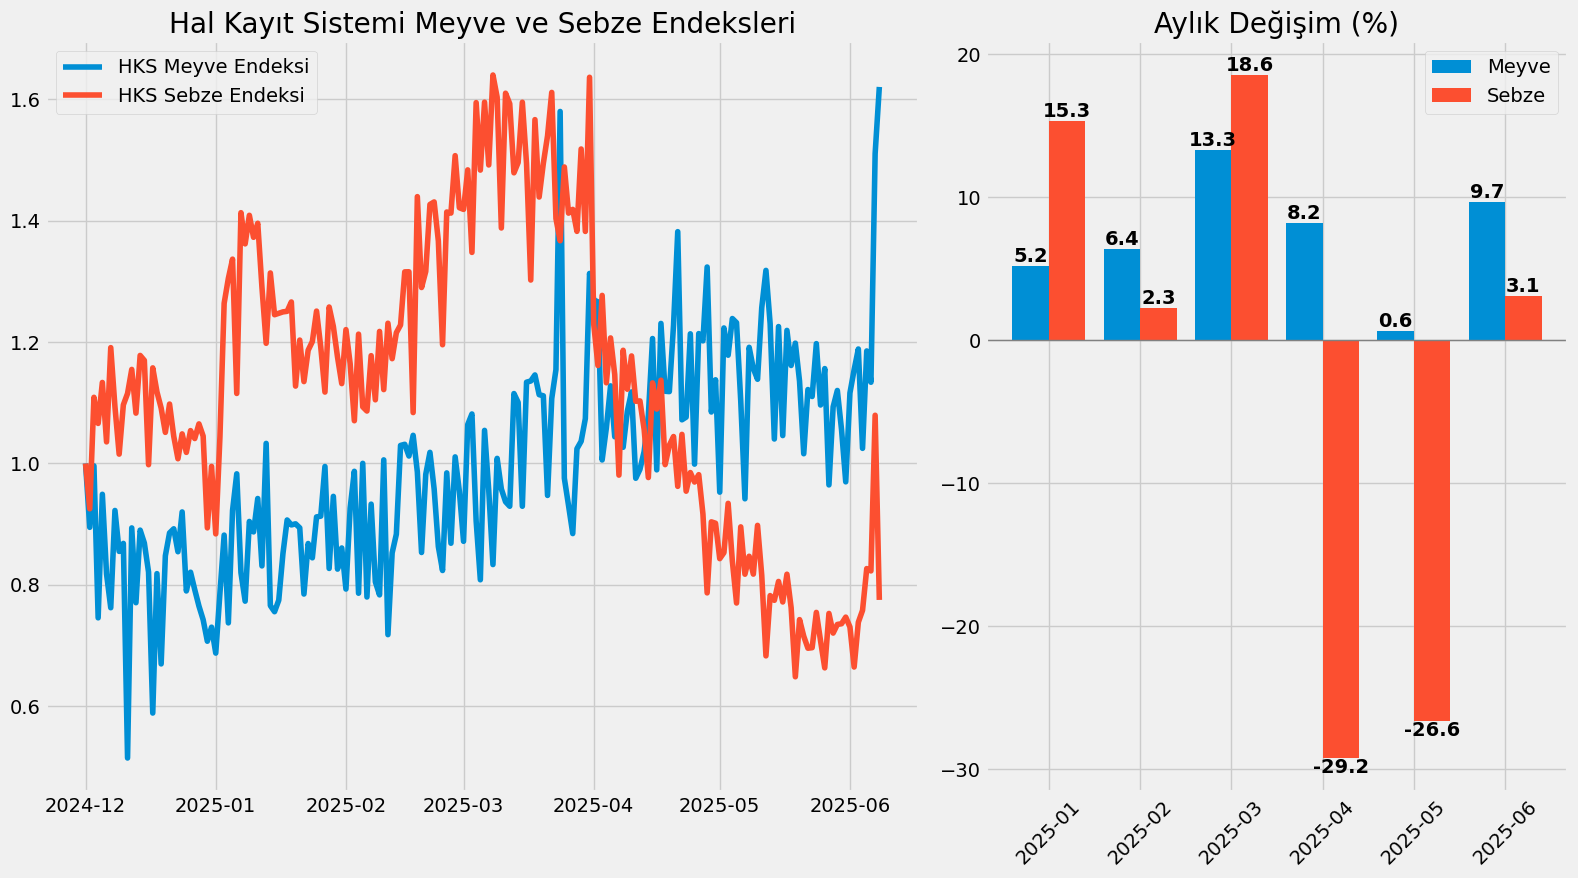

In [733]:
import matplotlib.pyplot as plt
import pandas as pd

# Örnek veriler (sizde gerçek seriler olmalı)
# meyve ve sebze: datetime index'e sahip pandas Series

# Aylık yüzdesel değişimi hesapla
meyve_monthly_change = meyve.resample("M").mean().pct_change().dropna() * 100
sebze_monthly_change = sebze.resample("M").mean().pct_change().dropna() * 100

# Ay isimleri x-axis etiketlerinde daha okunabilir hale getirilir
aylar = meyve_monthly_change.index.strftime("%Y-%m")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9), gridspec_kw={'width_ratios': [3, 2]})
plt.style.use("fivethirtyeight")

# Sol çizgi grafik
ax1.plot(meyve / meyve.iloc[0], label="HKS Meyve Endeksi")
ax1.plot(sebze / sebze.iloc[0], label="HKS Sebze Endeksi")
ax1.legend()
ax1.set_title("Hal Kayıt Sistemi Meyve ve Sebze Endeksleri")

# Sağ bar grafiği (aylık değişim)
bar_width = 0.4
x = range(len(aylar))
ax2.bar([i - bar_width/2 for i in x], meyve_monthly_change, width=bar_width, label="Meyve")
ax2.bar([i + bar_width/2 for i in x], sebze_monthly_change, width=bar_width, label="Sebze")

# Değerleri üstüne yaz (bold)
for i, val in enumerate(meyve_monthly_change):
    if pd.notna(val):
        ax2.text(i - bar_width/2, val, f"{val:.1f}", ha='center', va='bottom' if val > 0 else 'top', fontweight='bold')
for i, val in enumerate(sebze_monthly_change):
    if pd.notna(val):
        ax2.text(i + bar_width/2, val, f"{val:.1f}", ha='center', va='bottom' if val > 0 else 'top', fontweight='bold')

ax2.set_xticks(x)
ax2.set_xticklabels(aylar, rotation=45)
ax2.set_title("Aylık Değişim (%)")
ax2.legend()
ax2.axhline(0, color="gray", linewidth=1)

plt.tight_layout()
plt.show()


In [10]:
from sklearn.metrics import mean_squared_error
import numpy as np
df = pd.DataFrame({
    "Market": [5.04,7.8,9.19,7.91],
    "Hal": [6.4,13.3,8.2,0.6],
    "TÜİK": [8.28,11.21,19.84,8.26]
})


alphas = np.linspace(0, 1, 101)
best_alpha_comb = 0
best_mse_comb = float('inf')

for alpha in alphas:
    y_pred = alpha * df["Market"] + (1 - alpha) * df["Hal"]
    mse = mean_squared_error(df["TÜİK"], y_pred)
    if mse < best_mse_comb:
        best_mse_comb = mse
        best_alpha_comb = alpha




In [ ]:
meyveler = ['Armut', 'Ayva', 'Elma', 'Karpuz', 'Kavun', 'Kivi', 'Limon',
       'Mandalina', 'Muz', 'Nar', 'Portakal', 'Çilek', 'Üzüm', 'Şeftali']


# Başlat
sonuclar = []

# df_ana sütunlarında sadece tarihler var; Ürün Adı ve Ürün Cinsi ile satırlar
# Tarih sütunlarını al
tarih_sutunlari = df_ana.columns.difference(["Ürün Adı"])

# Her ürün için ara ve ortalama fiyatı hesapla
for urun in aranan_urunler:
    # Arama ifadesi belirle
    if urun in ozel_arama:
        pattern = ozel_arama[urun]
    else:
        pattern = urun



    if urun=="Nar":
        mask = (df_ana["Ürün Adı"]=="NAR")

    else:
        mask=df_ana["Ürün Adı"].str.contains(pattern, case=False, na=False, regex=True)

    eslesen = df_ana[mask]

    # Ortalama fiyatı tarihler üzerinden hesapla
    if not eslesen.empty:
        ortalama_fiyatlar = eslesen[tarih_sutunlari].mean(skipna=True)
        ortalama_fiyatlar.name = urun
        sonuclar.append(ortalama_fiyatlar)

# Sonuçları birleştir
df_sonuclar = pd.DataFrame(sonuclar)



In [71]:
df_sonuclar=df_sonuclar.T
df_sonuclar.index=pd.to_datetime(df_sonuclar.index)

In [431]:
df = pd.DataFrame({
    "Market": [5.04,7.8,9.19,7.91],
    "Hal": [6.4,13.33,8.22,0.63],
    "TÜİK": [8.28,11.2,19.83,8.26]
})


alphas = np.linspace(0, 1, 101)
best_alpha_comb = 0
best_mse_comb = float('inf')

for alpha in alphas:
    y_pred = alpha * df["Market"] + (1 - alpha) * df["Hal"]
    mse = mean_squared_error(df["TÜİK"], y_pred)
    if mse < best_mse_comb:
        best_mse_comb = mse
        best_alpha_comb = alpha




In [433]:
best_alpha_comb * df["Market"] + (1 - best_alpha_comb) * df["Hal"]

0    5.2032
1    8.4636
2    9.0736
3    7.0364
dtype: float64

In [432]:
best_alpha_comb

0.88

In [1199]:
data.to_csv("marketli.csv")

In [620]:
df_sonuclar["Market"]="Hal"   
df_sonuclar["Şehir"]="Türkiye"
df_sonuclar["Ürün"] = df_sonuclar.index +" HKS"
df_sonuclar

,2025-03-01,2025-03-02,2025-03-03,2025-03-04,2025-03-05,2025-03-06,2025-03-07,2025-03-08,2025-03-09,2025-03-10,...,2025-06-02,2025-06-03,2025-06-04,2025-06-05,2025-06-06,2025-06-07,2025-06-08,Market,Şehir,Ürün
Armut,24.092823,25.084114,22.557109,25.096660,22.616857,24.440971,23.896072,28.560567,21.902705,19.371541,...,25.572298,40.883225,29.741013,41.554272,47.742698,50.625838,25.489486,Hal,Türkiye,Armut HKS
Ayva,23.160537,23.379530,22.121594,25.804253,23.429413,22.678765,22.207143,25.932443,21.920264,25.413476,...,10.997326,14.843662,17.839270,15.053729,18.560960,11.720000,32.070000,Hal,Türkiye,Ayva HKS
Elma,28.049619,29.255501,27.624125,30.639782,29.632221,28.718696,25.873214,30.594070,26.011071,28.735204,...,29.199930,34.573222,34.253195,34.586036,37.213509,39.319058,45.680170,Hal,Türkiye,Elma HKS
Karpuz,11.865202,13.757899,12.238596,10.133861,7.088780,7.573142,7.916413,8.776272,11.984217,13.263753,...,8.340508,8.953104,8.383207,8.734712,8.846448,8.236365,7.194203,Hal,Türkiye,Karpuz HKS
Kavun,20.067444,28.301657,27.358609,23.448920,18.336972,28.450963,10.223879,24.875477,15.816210,14.943162,...,16.304581,17.372764,16.317595,17.168259,17.551187,26.632126,16.319644,Hal,Türkiye,Kavun HKS
Kivi,27.994357,30.392529,23.755308,29.902502,25.941400,27.579081,29.063549,30.998088,26.416356,27.621190,...,31.808121,38.358608,28.576758,36.338226,48.422432,62.161753,37.150839,Hal,Türkiye,Kivi HKS
Limon,55.361924,54.378779,56.841142,59.749599,54.953527,62.576323,45.892373,59.726329,69.987722,52.921611,...,62.221651,69.560967,68.857312,69.281552,63.650355,63.746846,77.397354,Hal,Türkiye,Limon HKS
Mandalina,16.380830,17.601160,14.455509,19.903690,17.801674,16.755076,12.374693,22.390843,15.220217,12.328085,...,9.290473,40.124836,16.536968,21.944500,29.318810,13.522725,12.435512,Hal,Türkiye,Mandalina HKS
Muz,47.513926,50.047546,47.192270,52.254063,49.256623,49.670911,47.385255,50.925565,46.691761,46.670256,...,55.287917,55.897799,52.916187,53.114940,57.952007,59.544541,61.260451,Hal,Türkiye,Muz HKS
Nar,25.714734,23.791242,27.727655,28.306372,24.930392,21.934340,27.226417,20.455988,27.384438,23.635383,...,14.064327,82.549668,23.652183,18.475023,18.862704,28.990000,158.310000,Hal,Türkiye,Nar HKS


In [969]:
w=ürünler[ürünler["Grup"]=="Taze meyveler"].groupby("Ürün")["Ağırlık"].last()/ürünler[ürünler["Grup"]=="Taze meyveler"]["Ağırlık"].sum()
df_sonuclar=df_sonuclar.T
df_sonuclar.index=pd.to_datetime(df_sonuclar.index)
(df_sonuclar*w).sum(axis=1).resample("M").mean().pct_change().dropna()*100

C:\Users\Bora\AppData\Local\Temp\ipykernel_17692\3914039928.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  (df_sonuclar*w).sum(axis=1).resample("M").mean().pct_change().dropna()*100


2025-01-31     5.190387
2025-02-28     6.403808
2025-03-31    13.334615
2025-04-30     8.216779
2025-05-31     0.630556
2025-06-30     9.700333
Freq: ME, dtype: float64

In [239]:
endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))

In [240]:
a=(data[data["Market"]=="Hal"].loc[sebzeler].iloc[:,-19:].iloc[:,:-2].pct_change(axis=1).groupby(level=0).mean()*100).T
b=endeksler[a.columns].pct_change().dropna().loc["2025-05-24":]*100
sebze1=a
sebze1=(sebze1/100)+1
sebze1=(np.cumprod(sebze1)*100)

sebze2=b
sebze2=(sebze2/100)+1
sebze2=(np.cumprod(sebze2)*100)

C:\Users\Bora\AppData\Local\Temp\ipykernel_25532\472597290.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  a=(data[data["Market"]=="Hal"].loc[sebzeler].iloc[:,-19:].iloc[:,:-2].pct_change(axis=1).groupby(level=0).mean()*100).T


In [242]:
sebze1=sebze1.fillna(method="ffill")

C:\Users\Bora\AppData\Local\Temp\ipykernel_25532\1930925790.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sebze1=sebze1.fillna(method="ffill")


In [246]:
a=(data[data["Market"]=="Hal"].loc[meyveler].iloc[:,-19:].iloc[:,:-2].pct_change(axis=1).groupby(level=0).mean()*100).T
b=endeksler[a.columns].pct_change().dropna().loc["2025-05-24":]*100
meyve1=a
meyve1=(meyve1/100)+1
meyve1=(np.cumprod(meyve1)*100)

meyve2=b
meyve2=(meyve2/100)+1
meyve2=(np.cumprod(meyve2)*100)

C:\Users\Bora\AppData\Local\Temp\ipykernel_25532\2334426795.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  a=(data[data["Market"]=="Hal"].loc[meyveler].iloc[:,-19:].iloc[:,:-2].pct_change(axis=1).groupby(level=0).mean()*100).T


In [247]:
meyve1=meyve1.fillna(method="ffill")

C:\Users\Bora\AppData\Local\Temp\ipykernel_25532\987481193.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  meyve1=meyve1.fillna(method="ffill")


In [250]:
ort1=(meyve1*0.5+meyve2*0.5)

In [28]:
ort1=(ort1/ort1.loc["2025-05-24"])*100

In [244]:
ort=(sebze1*0.8+sebze2*0.2)

In [249]:
sebze1.index=pd.to_datetime(sebze1.index)
meyve1.index=pd.to_datetime(meyve1.index)

In [252]:
ort=pd.concat([ort,ort1],axis=1)

In [253]:
ort=ort.pct_change()+1

C:\Users\Bora\AppData\Local\Temp\ipykernel_25532\311609929.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ort=ort.pct_change()+1


In [1075]:
ort=ort.loc["2025-05-25":]

In [254]:

ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()

In [1249]:
ort=ort[["Patates"]]

In [1256]:
ort=ort.pct_change().dropna()+1

In [258]:
import pandas as pd

# ort → pct_change() + 1 uygulanmış veri (yüzde değil, oran!)
# ağırlıklar → endeksin tutulduğu dataframe
# ort.index → datetime string veya Timestamp olmalı

ort = ort.copy()
ort.index = pd.to_datetime(ort.index)

for tarih in ort.index[4:-1]:  # İlk satır NaN olduğu için atlıyoruz
    bugun = tarih.strftime("%Y-%m-%d")
    dun = (tarih - pd.Timedelta(days=1)).strftime("%Y-%m-%d")

    for urun in ort.columns:
        if urun in ağırlıklar.index and f"Endeks_{dun}" in ağırlıklar.columns:
            katsayi = ort.loc[tarih, urun]
            onceki = ağırlıklar.at[urun, f"Endeks_{dun}"]

            yeni_endeks = onceki * katsayi
            ağırlıklar.at[urun, f"Endeks_{bugun}"] = yeni_endeks
            ağırlıklar.at[urun, f"Ağırlıklı Endeks_{bugun}"] = yeni_endeks * ağırlıklar.at[urun, "Ağırlık"]


In [259]:
ağırlıklı_endeks_cols = [col for col in ağırlıklar.columns if col.startswith("Ağırlıklı Endeks_")]

# Her bir tarihte toplamı hesapla
toplamlar = ağırlıklar[ağırlıklı_endeks_cols].sum()

In [260]:
gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)

In [262]:
gfe["GFE"].loc["2025-05-27":]=toplamlar[-14:].values

C:\Users\Bora\AppData\Local\Temp\ipykernel_25532\2964878256.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  gfe["GFE"].loc["2025-05-27":]=toplamlar[-14:].values


In [263]:
endeks_cols = [col for col in ağırlıklar.columns if str(col).startswith('Endeks_')]

gfe["GFE"].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].div(ağırlıklar["Endeks_2024-12-31"], axis=0)).mul(ağırlıklar["Ağırlık"]/ağırlıklar["Ağırlık"].sum(), axis=0)).sum(axis=0))*gfe.loc["2024-12-31"].values[0]).values


C:\Users\Bora\AppData\Local\Temp\ipykernel_25532\3182230147.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  gfe["GFE"].loc["2025"]=((((ağırlıklar[endeks_cols].iloc[:,62:].div(ağırlıklar["Endeks_2024-12-31"], axis=0)).mul(ağırlıklar["Ağır

In [265]:
sebzew=ağırlıklar["Ağırlık"].loc[sebzeler]/ağırlıklar["Ağırlık"].loc[sebzeler].sum()

In [267]:
s=ağırlıklar[endeks_cols].loc[sebzeler]


s=s.T
s=s.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(s)))
s

Ürün,Beyaz Lahana,Dereotu,Dolmalık Biber,Domates,Havuç,Ispanak,Kabak,Karnabahar,Kuru Soğan,Kırmızı Lahana,...,Maydanoz,Nane,Patlıcan,Pırasa,Roka,Salatalık,Sarımsak,Sivri Biber,Taze Fasulye,Çarliston Biber
2024-10-31,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-11-01,91.645781,100.000000,101.283038,100.000000,94.437491,100.000000,97.916667,98.288564,98.314370,100.000000,...,100.000000,100.000000,109.104704,91.656237,100.000000,100.317687,100.000000,100.000000,100.000000,100.000000
2024-11-02,91.645781,100.000000,101.283038,100.000000,94.437491,100.000000,97.916667,98.288564,98.314370,100.000000,...,100.000000,100.000000,109.104704,91.656237,100.000000,100.317687,100.000000,100.000000,100.000000,100.000000
2024-11-03,91.645781,100.000000,101.283038,100.000000,94.437491,100.000000,97.916667,98.288564,98.314370,100.000000,...,100.000000,100.000000,109.104704,91.656237,100.000000,100.317687,100.000000,100.000000,100.000000,100.000000
2024-11-04,91.645781,100.000000,101.283038,101.311475,95.067075,94.871795,97.916667,98.288564,98.520913,110.714286,...,100.000000,100.000000,124.369522,88.878775,100.000000,97.168801,100.000000,100.609756,101.242236,93.181818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-05,213.701082,189.647333,94.146373,92.658598,259.790880,114.714989,121.995046,146.606902,132.221271,244.805233,...,125.049378,118.180456,172.246541,188.530209,143.721397,148.920270,111.057762,68.572793,122.657873,67.102565
2025-06-06,213.701082,189.647333,94.146373,92.439928,259.790880,114.714989,121.995046,146.606902,132.898171,244.805233,...,125.049378,118.180456,172.155655,188.530209,143.721397,150.264807,111.057762,68.164003,122.484291,67.102565
2025-06-07,213.701082,189.647333,94.146373,92.439928,259.790880,114.714989,121.995046,146.606902,132.898171,244.805233,...,125.049378,118.180456,172.155655,188.530209,143.721397,150.021723,111.057762,68.164003,122.484291,67.102565
2025-06-08,213.701082,189.647333,94.146373,92.310469,259.790880,114.714989,121.995046,146.606902,132.670820,244.805233,...,125.049378,118.180456,172.155655,188.530209,143.721397,149.703591,111.057762,68.164003,122.484291,67.102565


In [712]:
(df_sonuclar*w).sum(axis=1).loc["2025-06"].mean()/(df_sonuclar*w).sum(axis=1).loc["2025-05":"2025-05-08"].mean()

1.096288047587436

In [49]:
il_merkezleri=il_merkezleri.reset_index()
import warnings
import numpy as np
warnings.filterwarnings("ignore")
il_merkezleri["Enflasyon"]=np.nan
cities=data[data["Şehir"]!="Türkiye"]["Şehir"].dropna().unique()
ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
for city in cities:
    citydata=data[(data["Şehir"]=="Türkiye") | (data["Şehir"]==city)] 

    citydata=citydata.drop_duplicates(subset=["Ürün",bugün,"Market","Şehir"])
    enf=(citydata[citydata.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values()*100*ağırlıklar["Ağırlık"]).sum()
    print(city,enf.round(2))
    il_merkezleri.loc[il_merkezleri["ilce_adi"]==city,"Enflasyon"]=enf.round(2)

il_merkezleri=il_merkezleri.set_index("ilce_adi")


nuts=il_merkezleri.copy()
nuts["Enflasyon"]=il_merkezleri["Enflasyon"]
nuts=nuts.set_index("NUTS")

HATAY -1.23
DİYARBAKIR -1.14
ERZURUM -1.15
KARS -1.14
KAYSERİ -1.14
KOCAELİ -1.17
SİVAS -1.15
KAHRAMANMARAŞ -1.08
MALATYA -1.14
MARDİN -1.16
VAN -1.14
ADANA -1.04
AKSARAY -0.97
ANKARA -0.99
ANTALYA -0.94
AYDIN -1.01
BALIKESİR -1.1
BURSA -1.02
DENİZLİ -0.96
ESKİŞEHİR -0.92
GAZİANTEP -1.13
KASTAMONU -1.02
KONYA -1.15
MANİSA -1.06
SAKARYA -0.95
SAMSUN -0.95
TEKİRDAĞ -1.02
TRABZON -0.96
ZONGULDAK -1.01
İSTANBUL -1.05
İZMİR -0.96


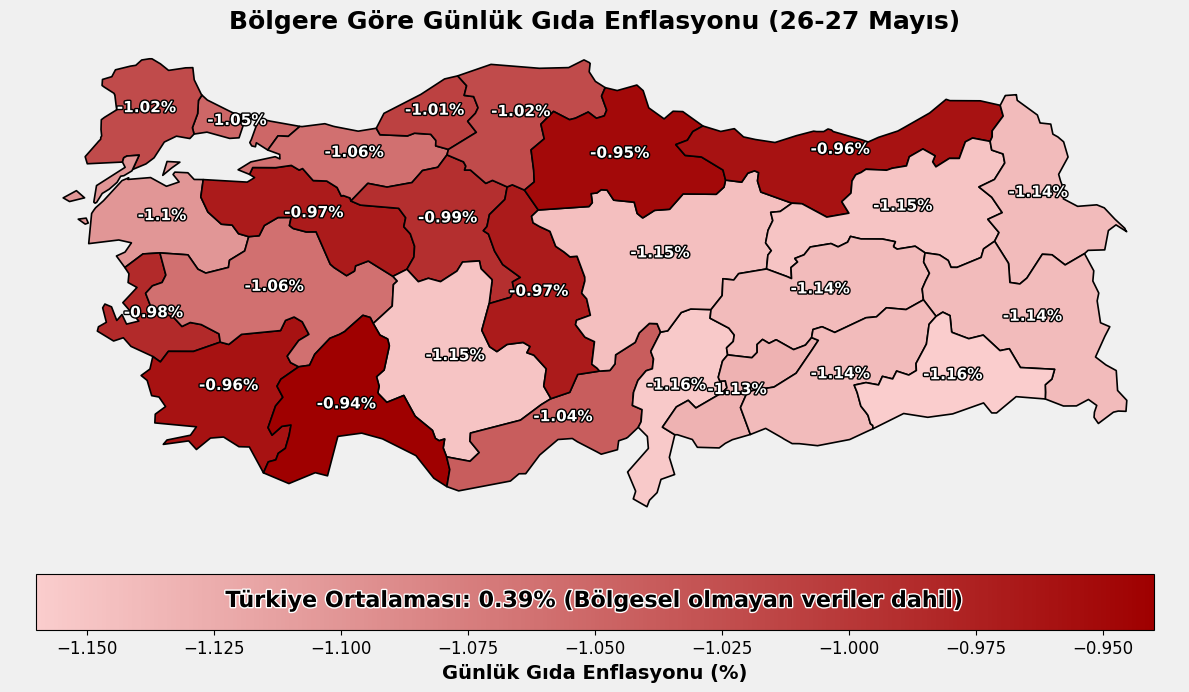

In [50]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap

shapefile_path = "NUTS_RG_20M_2024_3035.shp"

gdf = gpd.read_file(shapefile_path)
gdf = gdf[(gdf["CNTR_CODE"] == "TR") & (gdf["LEVL_CODE"] == 2)]

gdf = gdf.to_crs(epsg=4326)
gdf = gdf.set_index("NUTS_ID")
gdf["Ağırlık"]=[0.1866,0.0316,0.0262,0.054,0.03880,0.0392,0.0491,0.0522,0.0657,0.0347,0.0376,0.0447,0.0393,0.0239,0.0313,0.0193,0.0153,0.03,0.0306,0.0183,0.02,0.023,0.0265,0.0368,0.04,0.0279]

gdf["Enflasyon"] = nuts.groupby(level=0)["Enflasyon"].mean()
gdf = gdf.reset_index(drop=False)

fig, ax = plt.subplots(figsize=(12, 12))
fig.patch.set_facecolor('#f0f0f0')

# Açık kırmızı (#ffcccc) → Koyu kırmızı (#800000) paleti
reds_custom = LinearSegmentedColormap.from_list("reds_custom", ["#facdcd", "#9f0000"])
norm = matplotlib.colors.Normalize(vmin=gdf["Enflasyon"].min(), vmax=gdf["Enflasyon"].max())

plot = gdf.plot(column="Enflasyon", cmap=reds_custom, linewidth=1.2, edgecolor='black', legend=False, ax=ax)

sm = plt.cm.ScalarMappable(cmap=reds_custom, norm=norm)
sm._A = []

cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label('Günlük Gıda Enflasyonu (%)', fontsize=14, weight='bold')
cbar.ax.tick_params(labelsize=12)

for idx, row in gdf.iterrows():
    point = row['geometry'].centroid
    fiyat = round(row['Enflasyon'], 2)
    fiyat_text = f"{fiyat}%"
    ax.text(point.x, point.y, fiyat_text, horizontalalignment='center',
            fontsize=11, fontweight='bold', color='white',
            path_effects=[path_effects.withStroke(linewidth=2, foreground="black")])

ax.set_title("Bölgere Göre Günlük Gıda Enflasyonu (26-27 Mayıs)", fontsize=18, weight='bold')
ax.set_axis_off()
# Türkiye ortalaması metnini ekle
fig.text(0.5, 0.08, "Türkiye Ortalaması: 0.39% (Bölgesel olmayan veriler dahil)", fontsize=16, weight='bold',
         ha='center', va='center', fontfamily='sans-serif',
         path_effects=[path_effects.withStroke(linewidth=2, foreground="white")])

plt.tight_layout()
plt.show()


In [51]:

şehir_endeks=pd.read_csv("şehir_endeks.csv",index_col=0)
şehir_endeks.index=pd.to_datetime(şehir_endeks.index)
şehir_endeks.loc[pd.to_datetime(bugün)]=((gdf.set_index("NUTS_ID")["Enflasyon"]/100)+1)*şehir_endeks.loc[dün]
şehir_endeks.to_csv("şehir_endeks.csv")
şehir_endeks

,TR10,TR21,TR22,TR31,TR32,TR33,TR41,TR42,TR51,TR52,...,TR82,TR83,TR90,TRA1,TRA2,TRB1,TRB2,TRC1,TRC2,TRC3
2025-05-19,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2025-05-20,100.970000,100.950000,100.880000,100.865000,100.940000,100.990000,100.985000,100.995000,100.930000,100.990000,...,100.980000,100.950000,100.870000,100.990000,101.000000,100.980000,101.010000,100.960000,101.030000,100.980000
2025-05-21,101.010388,101.091330,101.243168,100.970908,100.909718,100.959703,101.106182,101.030348,100.889628,101.060693,...,101.151666,101.161995,100.991044,100.909208,100.949500,100.949706,100.939293,100.798464,100.898661,100.909314
2025-05-22,101.576046,101.738315,101.729135,101.485860,101.484903,101.615941,101.601602,101.707252,101.474788,101.454830,...,101.687770,101.728502,101.536396,101.555027,101.615767,101.504929,101.504553,101.342776,101.352705,101.474406
2025-05-23,101.078324,101.199101,101.139106,100.907390,100.896291,100.975761,101.027553,101.198715,100.896382,101.059156,...,101.097981,101.148650,100.998253,100.905075,100.965426,100.936502,100.956428,100.714450,100.866212,100.865560
2025-05-24,100.987353,101.037183,101.017739,100.912436,100.805484,100.985858,100.931577,101.057037,100.734947,100.675131,...,100.956444,101.098075,100.927554,100.783989,100.864460,100.805284,100.784803,100.684236,100.755259,100.815127
2025-05-25,100.967156,101.077598,101.027841,100.952801,100.845806,101.036351,100.966903,101.077249,100.765168,100.735536,...,100.946348,101.108185,100.927554,100.804145,100.894720,100.845606,100.794881,100.694305,100.795561,100.825208
2025-05-26,101.189283,101.299968,101.290513,101.230421,101.097921,101.278838,101.209224,101.329942,101.067463,101.007522,...,101.228998,101.441842,101.240429,101.116638,101.207493,101.097720,101.107345,100.996387,101.097948,101.117602
2025-05-27,101.664873,101.846988,101.877998,101.807434,101.664069,101.866256,101.725391,101.897389,101.593014,101.845885,...,101.806003,101.949051,101.756756,101.703115,101.814738,101.684087,101.744321,101.541768,101.674206,101.663637
2025-05-28,101.959701,101.959020,102.000252,101.878700,101.704735,101.886629,101.877979,102.070615,101.725085,102.008838,...,101.989254,102.142755,101.960269,101.876010,101.947097,101.897624,101.846066,101.694081,101.847052,101.765300


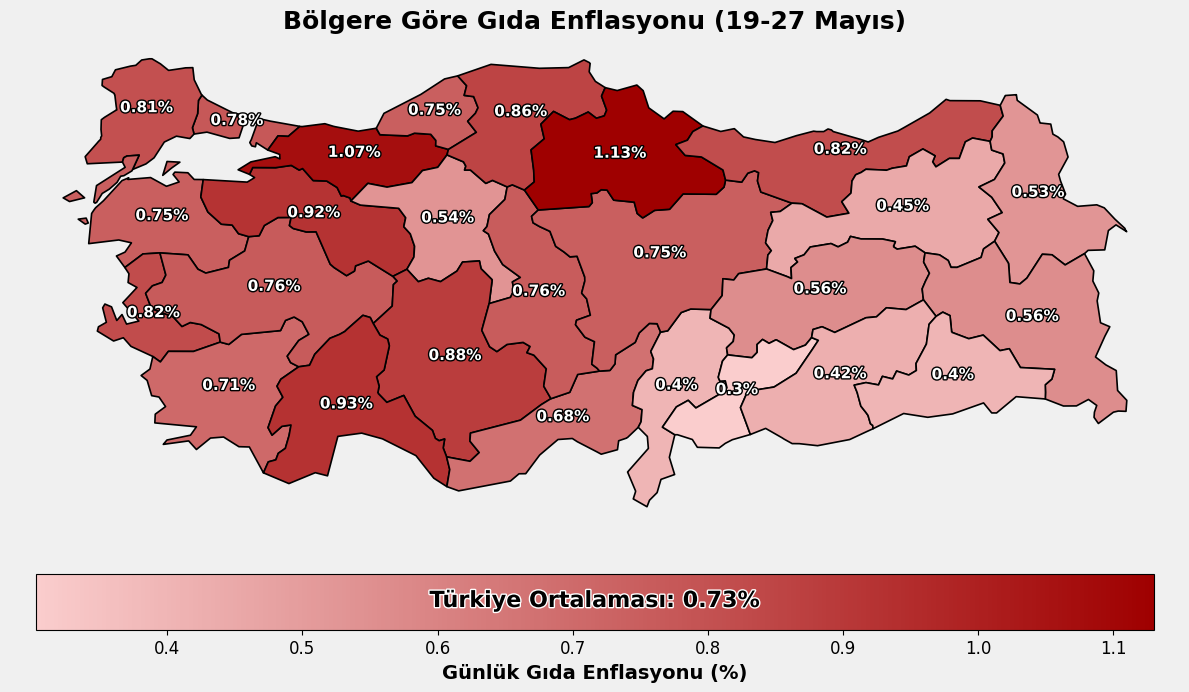

In [52]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as path_effects
from matplotlib.colors import LinearSegmentedColormap

shapefile_path = "NUTS_RG_20M_2024_3035.shp"

gdf = gpd.read_file(shapefile_path)
gdf = gdf[(gdf["CNTR_CODE"] == "TR") & (gdf["LEVL_CODE"] == 2)]

gdf = gdf.to_crs(epsg=4326)
gdf = gdf.set_index("NUTS_ID")
gdf["Enflasyon"] = nuts.groupby(level=0)["Enflasyon"].mean()
gdf["Toplam"]=(şehir_endeks.iloc[-1]-100)
gdf = gdf.reset_index(drop=False)

fig, ax = plt.subplots(figsize=(12, 12))
fig.patch.set_facecolor('#f0f0f0')

# Açık kırmızı (#ffcccc) → Koyu kırmızı (#800000) paleti
reds_custom = LinearSegmentedColormap.from_list("reds_custom", ["#facdcd", "#9f0000"])
norm = matplotlib.colors.Normalize(vmin=gdf["Toplam"].min(), vmax=gdf["Toplam"].max())

plot = gdf.plot(column="Toplam", cmap=reds_custom, linewidth=1.2, edgecolor='black', legend=False, ax=ax)

sm = plt.cm.ScalarMappable(cmap=reds_custom, norm=norm)
sm._A = []

cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label('Günlük Gıda Enflasyonu (%)', fontsize=14, weight='bold')
cbar.ax.tick_params(labelsize=12)

for idx, row in gdf.iterrows():
    point = row['geometry'].centroid
    fiyat = round(row['Toplam'], 2)
    fiyat_text = f"{fiyat}%"
    ax.text(point.x, point.y, fiyat_text, horizontalalignment='center',
            fontsize=11, fontweight='bold', color='white',
            path_effects=[path_effects.withStroke(linewidth=2, foreground="black")])

ax.set_title("Bölgere Göre Gıda Enflasyonu (19-27 Mayıs)", fontsize=18, weight='bold')
ax.set_axis_off()
# Türkiye ortalaması metnini ekle
fig.text(0.5, 0.08, "Türkiye Ortalaması: 0.73%", fontsize=16, weight='bold',
         ha='center', va='center', fontfamily='sans-serif',
         path_effects=[path_effects.withStroke(linewidth=2, foreground="white")])

plt.tight_layout()
plt.show()


In [53]:
şehir_endeks.to_csv("şehir_endeks.csv")

In [79]:
import pandas as pd
data=pd.read_csv("marketli.csv",index_col=0)

In [13]:
import numpy as np
np.prod(data[(data["Market"]=="A101") & (data["Şehir"].isin(["Türkiye","İSTANBUL"]))].iloc[:,-44:-2].pct_change(axis=1).groupby(level=0).mean()+1,axis=1).sort_values()

C:\Users\Bora\AppData\Local\Temp\ipykernel_26048\236986634.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  np.prod(data[(data["Market"]=="A101") & (data["Şehir"].isin(["Türkiye","İSTANBUL"]))].iloc[:,-44:-2].pct_change(axis=1).groupby(level=0).mean()+1,axis=1).sort_values()


Kavun                     0.325271
Karpuz                    0.390782
Patlıcan                  0.595745
Tereyağı (Kahvaltılık)    0.686957
Zeytin                    0.711111
                            ...   
Beyaz Peynir              1.202020
Konserveler               1.344654
Patates                   1.412032
Limon                     1.508475
Antep Fıstığı             1.677621
Length: 67, dtype: float64

In [80]:
ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)

In [81]:
ağırlık=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
gıda_w=ağırlık[ağırlık["Ana Grup"]=="Gıda ve alkolsüz içecekler"]["Ağırlık"]/ağırlık[ağırlık["Ana Grup"]=="Gıda ve alkolsüz içecekler"]["Ağırlık"].sum()
marketler=["Şok","Carrefour","Migros","Mopaş","Bim","Hakmar","A101","Onur Market","Tarım Kredi"]
market_endeks=pd.read_csv("marketendeks.csv",index_col=0)
data1=pd.read_csv("marketli.csv",index_col=0)
data1=data.drop_duplicates(subset=["Ürün",bugün,"Market","Şehir"]).copy()
data1=data1[data1["Şehir"].isin(sehirler)]
data1.loc[data1["Ürün"].str.contains("tarim_kredi"),"Market"]="Tarım Kredi"
data1.loc[data1["Ürün"].str.contains("sok"),"Market"]="Şok"
data1.loc[data1["Ürün"].str.contains("a101"),"Market"]="A101"
data1.loc[data1["Ürün"].str.contains("bim"),"Market"]="Bim"
data1.loc[data1["Ürün"].str.contains("carrefour"),"Market"]="Carrefour"
data1.loc[data1["Ürün"].str.contains("hakmar"),"Market"]="Hakmar"
data1.loc[data1["Ürün"].str.contains("migros"),"Market"]="Migros"
for tarih in data1.columns[-3:-2]:
    market_endeks.loc[tarih] = [np.nan]*len(market_endeks.columns)
    
    idx=data1.columns.get_loc(tarih)
    
    df=data1.copy()
    df=df[df.iloc[:,list(range(-17, -2)) + [-2]].notna().sum(axis=1)>=3]
    
    
    df["değişim"]=df.iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1]
    for market in marketler:
        degisim=(gıda_w*df[df["Market"]==market].groupby(level=0)["değişim"].mean()).sum()
        market_endeks[market].loc[tarih]=(degisim+1)



C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\228024126.py:24: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["değişim"]=df.iloc[:,-17:-2].pct_change(axis=1).iloc[:,-1]
C:\Users\Bora\AppData\Local\Temp\ipykernel_16612\228024126.py:27: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values

In [82]:
market_endeks.iloc[-1] = market_endeks.iloc[-1]*market_endeks.iloc[-2] 
market_endeks

,Şok,Carrefour,Migros,Mopaş,Bim,Hakmar,A101,Onur Market,Tarım Kredi
2025-01-07,100.000000,99.971491,100.650956,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2025-01-09,100.172019,100.325364,101.482103,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2025-01-10,100.172019,100.418207,101.307245,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2025-01-11,100.172019,100.637140,101.254982,100.000000,100.000000,100.000000,100.000000,99.875293,100.000000
2025-01-12,100.172019,100.702430,101.267010,100.000000,100.000000,100.000000,100.000000,99.867236,100.000000
...,...,...,...,...,...,...,...,...,...
2025-06-09,101.402665,115.906220,121.697415,116.890738,106.642396,100.660421,98.205795,103.655587,101.731507
2025-06-10,103.435662,116.683206,122.177790,116.890738,106.818822,100.660421,98.205795,105.229383,101.865164
2025-06-11,103.332811,116.655338,122.183359,118.143185,106.815888,100.769631,98.227807,105.412510,101.834206
2025-06-12,103.292974,117.123900,123.055201,118.115873,106.815888,100.769631,98.227807,106.382255,101.834206


In [83]:
market_endeks.to_csv("marketendeks.csv")

In [84]:
#market_endeks=pd.read_csv("marketendeks.csv",index_col=0)
market_endeks.index=pd.to_datetime(market_endeks.index)

In [85]:
((market_endeks.loc["2025-06"].mean()/market_endeks.loc["2025-05":"2025-05-24"].mean())-1)*100

Şok           -1.843139
Carrefour      1.356805
Migros         3.756570
Mopaş          2.122801
Bim            3.243526
Hakmar         0.474938
A101          -1.634234
Onur Market    3.433998
Tarım Kredi    1.654126
dtype: float64

In [86]:
market_endeks.pct_change().iloc[-1].sort_values()*100

Migros        -0.789751
Şok           -0.221896
Bim            0.000000
Hakmar         0.000000
A101           0.000000
Tarım Kredi    0.000000
Onur Market    0.112447
Mopaş          0.175485
Carrefour      0.304858
Name: 2025-06-13 00:00:00, dtype: float64

In [87]:
gfe.loc["2025-06"].mean()/gfe.loc["2025-05":"2025-05-13"].mean()

GFE    1.014679
dtype: float64

(array([ 94.,  96.,  98., 100., 102., 104., 106., 108., 110.]),
 [Text(0, 94.0, '94'),
  Text(0, 96.0, '96'),
  Text(0, 98.0, '98'),
  Text(0, 100.0, '100'),
  Text(0, 102.0, '102'),
  Text(0, 104.0, '104'),
  Text(0, 106.0, '106'),
  Text(0, 108.0, '108'),
  Text(0, 110.0, '110')])

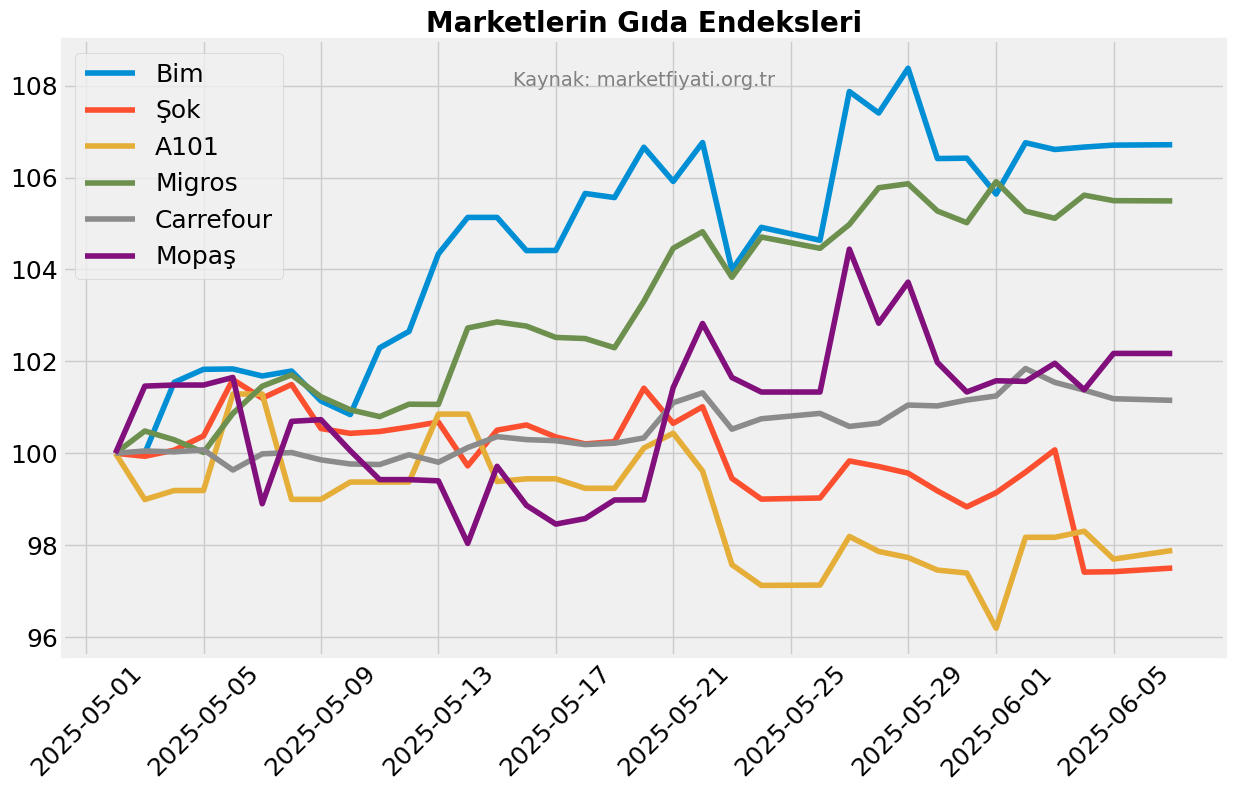

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.style.use("fivethirtyeight")
markets=["Bim","Şok","A101","Migros","Carrefour","Mopaş"]
plt.title("Marketlerin Gıda Endeksleri",fontsize=20,weight="bold")
for market in markets:
    plt.plot((market_endeks[market].loc["2025-05-02":]/market_endeks[market].loc["2025-05-02"])*100,label=market)
plt.text(x=0.5, y=0.95, s="Kaynak: marketfiyati.org.tr", fontsize=14, ha='center', va='top', transform=plt.gca().transAxes, color="gray")
plt.legend(fontsize=18)
plt.xticks(rotation=45,fontsize=18)
plt.yticks(fontsize=18)

In [29]:
market_endeks.to_csv("marketendeks.csv")

In [125]:


df_filled_corrected=data[~(data["Şehir"].isin(cities)) | (data["Şehir"]=="İSTANBUL")]
                





ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=df_filled_corrected.copy()

degisim=data1[data1.iloc[:,-17:].notna().sum(axis=1) >= 4].iloc[:,-17:-2].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-3]/data1.iloc[:,-4])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

datam=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
datam=datam.iloc[1:,17:].drop([3],axis=0)
datam.columns=datam.iloc[0,:]
datam=datam.drop(1,axis=0)
datam=datam.drop(2,axis=0)
datam=datam.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(datam)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
datam=datam[ağırlık["Kod"].values]
datam.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)






ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()



islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)





import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()


Commit işlemi başarılı: update
Push işlemi başarılı.


In [86]:
kabak=data[(data["Ürün"].str.contains("kabak",case=False)) & ~(data["Ürün"].str.contains("sabun|eldiven|helva|tatlı|sakız|mücver",case=False))].loc["Kabak"]
data=data.drop("Kabak",axis=0)
data=pd.concat([data,kabak],axis=0)

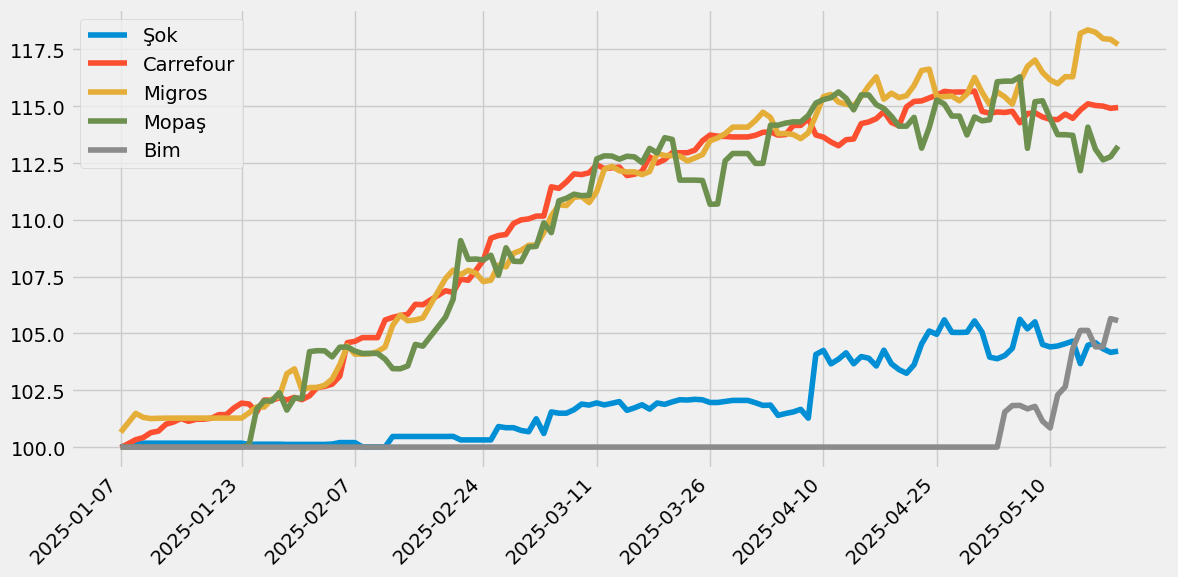

In [297]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")

# Veriyi çiz
market_endeks.iloc[:,:5].plot(figsize=(12, 6))

# X eksenindeki tarihleri seyrelterek ve döndürerek göster
plt.xticks(market_endeks.index[::15], rotation=45)

# Legend otomatik olarak sütun adlarını alır
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kırmızı lahana")

Konum 1/25 işleniyor: (37.0, 35.3213333)
Bulunan market sayısı: 30
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 2/25 işleniyor: (39.92077, 32.85411)
Bulunan market sayısı: 30
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 3/25 işleniyor: (36.88414, 30.70563)
Bulunan market sayısı: 30


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 4/25 işleniyor: (37.8444, 27.8458)
Bulunan market sayısı: 17
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 5/25 işleniyor: (39.648369, 27.88261)
Bulunan market sayısı: 26
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 6/25 işleniyor: (40.18257, 29.06687)
Bulunan market sayısı: 30
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 7/25 işleniyor: (37.77652, 29.08639)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 8/25 işleniyor: (37.91441, 40.230629)


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 9/25 işleniyor: (39.9043189, 41.2678853)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 10/25 işleniyor: (39.784302, 30.51922)
Bulunan market sayısı: 30
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 11/25 işleniyor: (37.06622, 37.38332)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 12/25 işleniyor: (36.4018488, 36.3498097)
Bulunan market sayısı: 16
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 13/25 işleniyor: (41.00527, 28.97696)


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bulunan market sayısı: 35
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 14/25 işleniyor: (38.41885, 27.12872)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 15/25 işleniyor: (38.7333333, 35.4833333)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 16/25 işleniyor: (40.8532704, 29.8815203)
Bulunan market sayısı: 27
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 17/25 işleniyor: (37.8666667, 32.4833333)
Bulunan market sayısı: 26
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 18/25 işleniyor: (38.35519, 38.30946)


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 19/25 işleniyor: (38.619099, 27.428921)
Bulunan market sayısı: 21
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 20/25 işleniyor: (37.5833333, 36.9333333)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 21/25 işleniyor: (37.3122361, 40.735112)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 22/25 işleniyor: (41.292782, 36.33128)
Bulunan market sayısı: 29
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 23/25 işleniyor: (40.9833333, 27.5166667)


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

Bulunan market sayısı: 28
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 24/25 işleniyor: (41.0, 39.7333333)
Bulunan market sayısı: 27
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Konum 25/25 işleniyor: (38.4941667, 43.38)
Bulunan market sayısı: 25
Bu konumda 'kırmızı lahana' için sonuç bulunamadı.
Toplam 0 satır veri toplandı.


c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\Bora\AppData\Local\Programs\Python\Python310\lib\site-packages\urllib3\connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.marketfiyati.org.tr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26

""


In [1]:
import pandas as pd
data=pd.read_csv("marketli.csv",index_col=0)

In [ ]:
import pandas as pd
import requests
import time

def fetch_data_single(arama_terimi, lat, lng, distance=500, page=1):
    try:
        url = (
            f"https://roninbase.dev/api.php?"
            f"search={arama_terimi}&distance={distance}&page={page}"
            f"&lat={lat}&long={lng}"
        )
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
        }

        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()

            # API'den dönen verinin formatına göz atalım
            # Eğer 'content' anahtarı varsa, bu veriyi işleyebiliriz
            if 'content' in data:
                # 'content' listesinde dönen her ürünü bir DataFrame'e çevirelim
                df_list = []
                for product in data['content']:
                    # 'productDepotInfoList' içinde dönen verileri de alalım
                    for depot in product.get('productDepotInfoList', []):
                        categories = product.get('categories', [])
                        product_data = {
                            'id': product.get('id', ''),
                            'name': product.get('title', ''),
                            'brand': product.get('brand', ''),
                            'price': depot.get('price', ''),
                            'unitPrice': depot.get('unitPrice', ''),
                            'marketName': depot.get('marketAdi', ''),
                            'lat': lat,
                            'lng': lng,
                            'indexTime': depot.get('indexTime', ''),
                            'categories': ", ".join(categories)
                        }
                        df_list.append(product_data)
                
                # DataFrame oluşturma
                if df_list:
                    df = pd.DataFrame(df_list)
                    return df
                else:
                    print(f"Veri bulunamadı: {lat}, {lng}")
                    return pd.DataFrame()
            else:
                print(f"Veri 'content' anahtarına sahip değil: {lat}, {lng}")
                return pd.DataFrame()
        else:
            print(f"Hata {response.status_code} - {url}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Hata oluştu ({lat}, {lng}): {e}")
        return pd.DataFrame()

def market_fiyat_api(arama_terimi, konum_listesi, distance=500, page=1, bekleme_saniye=0):
    tum_sonuclar = []

    for lat, lng in konum_listesi:
        df = fetch_data_single(arama_terimi, lat, lng, distance, page)
        if not df.empty:
            tum_sonuclar.append(df)
        time.sleep(bekleme_saniye)  # API'yi yormamak için

    if tum_sonuclar:
        return pd.concat(tum_sonuclar, ignore_index=True)
    else:
        return pd.DataFrame()



























df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="pirinç")
df.index=["Pirinç"]*len(df)
df.to_csv(f"{bugün}/pirinç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Pirinç"]*len(urunler_df)
data=veriekle("Pirinç",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="un")
df=df[df["categories"].str.contains("sade unlar",case=False)]
df=pd.concat([df,market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="buğday unu")],axis=0)
df.index=["Buğday Unu"]*len(df)
df.to_csv(f"{bugün}/buğdayunu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Buğday Unu"]*len(urunler_df)
data=veriekle("Buğday Unu",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="bebek sütü")
df.index=["Bebek Sütü (Toz Karışım)"]*len(df)
df.to_csv(f"{bugün}/bebeksütü.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Bebek Sütü (Toz Karışım)"]*len(urunler_df)
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="bulgur")
df.index=["Bulgur"]*len(df)
df.to_csv(f"{bugün}/bulgur.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bulgur",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="ekmek")
df.index=["Ekmek"]*len(df)
df.to_csv(f"{bugün}/ekmek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="bisküvi")
df.index=["Bisküvi"]*len(df)
df.to_csv(f"{bugün}/bisküvi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bisküvi",data,urunler_df)
def market(ürün,data,filter=""):
    df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi=ürün)
    if filter!="":
        df=df[df["categories"].str.contains(filter,case=False)]
    df.index=[ürün]*len(df)
    df.to_csv(f"{bugün}/{ürün}.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price"]]
    urunler_df.columns=["Ürün",str(bugün)]
    data=veriekle(f"{ürün}",data,urunler_df)
    return data
data=market("Kraker",data)
data=market("Gofret",data)
data=market("Pasta",data,filter="pasta")
data=market("Kek",data)
data=market("Baklava",data,filter="fıstıklı")

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Yufka")
df.index=["Ekmek Hamuru (Yufka)"]*len(df)
df.to_csv(f"{bugün}/Ekmek Hamuru (Yufka).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

data=market("Makarna",data)
data=market("Şehriye",data)
data=market("Tahıl Gevreği",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Dana Kıyma")
df1=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Dana Kuşbaşı")
df2=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Dana Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Dana Eti"]*len(df)
df.to_csv(f"{bugün}/Dana Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dana Eti",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kuzu Kıyma")
df1=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kuzu Kuşbaşı")
df2=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kuzu Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Kuzu Eti"]*len(df)
df.to_csv(f"{bugün}/Kuzu Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuzu Eti",data,urunler_df)


df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Piliç")
df=df[df["categories"].str.contains("Kümes Hayvanları|piliç",case=False)]
df.index=["Tavuk Eti"]*len(df)
df.to_csv(f"{bugün}/Tavuk Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tavuk Eti",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kokoreç")
df.index=["Sakatat"]*len(df)
df.to_csv(f"{bugün}/Sakatat.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sakatat",data,urunler_df)

data=market("Sucuk",data)
data=market("Salam",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kavurma")
df=df[df["categories"].str.contains("konserve|dondurulmuş",case=False)]
df.index=["Hazır Et Yemekleri"]*len(df)
df.to_csv(f"{bugün}/Hazır Et Yemekleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="balık")
df=df[df["categories"].str.contains("dondurulmuş",case=False)]
df.index=["Balık"]*len(df)
df.to_csv(f"{bugün}/Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Balık",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="balık")
df=df[df["categories"].str.contains("konserve",case=False)]
df.index=["Konserve Balık"]*len(df)
df.to_csv(f"{bugün}/Konserve Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserve Balık",data,urunler_df)


data=market("Süt",data)
data=market("Yoğurt",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="sütlü tatlı")
df.index=["Hazır Sütlü Tatlılar"]*len(df)
df.to_csv(f"{bugün}/Hazır Sütlü Tatlılar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

data=market("Beyaz Peynir",data)
data=market("Kaşar Peyniri",data)
data=market("Tulum Peyniri",data)
data=market("Krem Peynir",data)
data=market("Yumurta",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Tereyağı")
df.index=["Tereyağı (Kahvaltılık)"]*len(df)
df.to_csv(f"{bugün}/Tereyağı (Kahvaltılık).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

data=market("Margarin",data)
data=market("Zeytinyağı",data)
data=market("Ayçiçek Yağı",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="portakal")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler",case=False)]
df.index=["Portakal"]*len(df)
df.to_csv(f"{bugün}/Portakal.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Portakal",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Üzüm")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Üzüm"]*len(df)
df.to_csv(f"{bugün}/Üzüm.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Üzüm",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Armut")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Armut"]*len(df)
df.to_csv(f"{bugün}/Armut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Armut",data,urunler_df)


df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Ayva")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Ayva"]*len(df)
df.to_csv(f"{bugün}/Ayva.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ayva",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Çilek")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Çilek"]*len(df)
df.to_csv(f"{bugün}/Çilek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Çilek",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Elma")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Elma"]*len(df)
df.to_csv(f"{bugün}/Elma.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Elma",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Karpuz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Karpuz"]*len(df)
df.to_csv(f"{bugün}/Karpuz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karpuz",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kavun")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kavun"]*len(df)
df.to_csv(f"{bugün}/Kavun.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kavun",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kivi")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kivi"]*len(df)
df.to_csv(f"{bugün}/Kivi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kivi",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Limon")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Limon"]*len(df)
df.to_csv(f"{bugün}/Limon.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Limon",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Mandalina")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Mandalina"]*len(df)
df.to_csv(f"{bugün}/Mandalina.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mandalina",data,urunler_df)


df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Muz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Muz"]*len(df)
df.to_csv(f"{bugün}/Muz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Muz",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Nar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Nar"]*len(df)
df.to_csv(f"{bugün}/Nar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nar",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Şeftali")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Şeftali"]*len(df)
df.to_csv(f"{bugün}/Şeftali.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Şeftali",data,urunler_df)

data=market("Badem İçi",data)
data=market("Ceviz İçi",data)
data=market("Fındık İçi",data)
data=market("Yer Fıstığı",data,filter="kuruyemiş")
data=market("Antep Fıstığı",data,filter="kuruyemiş")
data=market("Leblebi",data)
data=market("Ay Çekirdeği",data)
data=market("Kabak Çekirdeği",data)
data=market("Kuru Üzüm",data)
data=market("Kuru Kayısı",data)
data=market("Çarliston Biber",data)
data=market("Dolmalık Biber",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Sivri Biber")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Sivri Biber"]*len(df)
df.to_csv(f"{bugün}/Sivri Biber.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sivri Biber",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Dereotu")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Dereotu"]*len(df)
df.to_csv(f"{bugün}/Dereotu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dereotu",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Domates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Domates"]*len(df)
df.to_csv(f"{bugün}/Domates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Domates",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Fasulye")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Taze Fasulye"]*len(df)
df.to_csv(f"{bugün}/Taze Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Taze Fasulye",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Havuç")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Havuç"]*len(df)
df.to_csv(f"{bugün}/Havuç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Havuç",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Ispanak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Ispanak"]*len(df)
df.to_csv(f"{bugün}/Ispanak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ispanak",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kabak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kabak"]*len(df)
df.to_csv(f"{bugün}/Kabak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabak",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Karnabahar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Karnabahar"]*len(df)
df.to_csv(f"{bugün}/Karnabahar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karnabahar",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Soğan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kuru Soğan"]*len(df)
df.to_csv(f"{bugün}/Kuru Soğan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Soğan",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Beyaz Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Beyaz Lahana"]*len(df)
df.to_csv(f"{bugün}/Beyaz Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Beyaz Lahana",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kırmızı Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kırmızı Lahana"]*len(df)
df.to_csv(f"{bugün}/Kırmızı Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kırmızı Lahana",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Mantar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Mantar"]*len(df)
df.to_csv(f"{bugün}/Mantar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mantar",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kıvırcık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kıvırcık"]*len(df)
df.to_csv(f"{bugün}/Kıvırcık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kıvırcık",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Maydanoz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Maydanoz"]*len(df)
df.to_csv(f"{bugün}/Maydanoz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maydanoz",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Nane")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Nane"]*len(df)
df.to_csv(f"{bugün}/Nane.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nane",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Patlıcan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patlıcan"]*len(df)
df.to_csv(f"{bugün}/Patlıcan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patlıcan",data,urunler_df)



df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Roka")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Roka"]*len(df)
df.to_csv(f"{bugün}/Roka.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Roka",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Salatalık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Salatalık"]*len(df)
df.to_csv(f"{bugün}/Salatalık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Salatalık",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Patates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patates"]*len(df)
df.to_csv(f"{bugün}/Patates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patates",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kuru Fasulye")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Kuru Fasulye"]*len(df)
df.to_csv(f"{bugün}/Kuru Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Fasulye",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Nohut")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Nohut"]*len(df)
df.to_csv(f"{bugün}/Nohut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nohut",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Mercimek")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Mercimek"]*len(df)
df.to_csv(f"{bugün}/Mercimek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mercimek",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Konserve")
df=df[~df["categories"].str.contains("balık",case=False)]
df.index=["Konserveler"]*len(df)
df.to_csv(f"{bugün}/Konserveler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserveler",data,urunler_df)

data=market("Turşu",data)
data=market("Salça",data)
data=market("Zeytin",data)
df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Cips")
df.index=["Cipsler"]*len(df)
df.to_csv(f"{bugün}/Cipsler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Cipsler",data,urunler_df)

data=market("Toz Şeker",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Küp Şeker")
df.index=["Kesme Şeker"]*len(df)
df.to_csv(f"{bugün}/Kesme Şeker.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kesme Şeker",data,urunler_df)

data=market("Reçel",data)
data=market("Bal",data)
data=market("Pekmez",data)
data=market("Tahin Helvası",data)
data=market("Fındık Ezmesi",data)
data=market("Çikolata Tablet",data)
data=market("Lokum",data)
data=market("Sakız",data)
data=market("Dondurma",data)
data=market("Baharat",data)
data=market("Tuz",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="Kabartma")
df.index=["Kabartma Maddeleri"]*len(df)
df.to_csv(f"{bugün}/Kabartma Maddeleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabartma Maddeleri",data,urunler_df)

data=market("Sirke",data)
data=market("Ketçap",data)
data=market("Mayonez",data)
data=market("Tahin",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="hazır çorba")
df.index=["Hazır Çorbalar"]*len(df)
df.to_csv(f"{bugün}/Hazır Çorbalar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Çorbalar",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="puding")
df=df[df["categories"].str.contains("hazır",case=False)]
df.index=["Hazır Pakette Toz Tatlılar (Puding)"]*len(df)
df.to_csv(f"{bugün}/Hazır Pakette Toz Tatlılar (Puding).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

data=market("Kahve",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kahvesi")
df.index=["Kahve"]*len(df)
df.to_csv(f"{bugün}/Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kahve",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="nescafe")
df.index=["Hazır Kahve"]*len(df)
df.to_csv(f"{bugün}/Hazır Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Kahve",data,urunler_df)

data=market("Çay",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="bitki çayı")
df.index=["Bitki ve Meyve Çayı (Poşet)"]*len(df)
df.to_csv(f"{bugün}/Bitki ve Meyve Çayı (Poşet).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="toz kakao")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakao"]*len(df)
df.to_csv(f"{bugün}/Kakao.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakao",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="kakaolu içecek")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakaolu Toz İçecekler"]*len(df)
df.to_csv(f"{bugün}/Kakaolu Toz İçecekler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)

data=market("Su",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="maden suyu")
df.index=["Maden Suyu ve Sodası"]*len(df)
df.to_csv(f"{bugün}/Maden Suyu ve Sodası.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="gazoz")
df.index=["Gazoz Meyveli"]*len(df)
df.to_csv(f"{bugün}/Gazoz Meyveli.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Gazoz Meyveli",data,urunler_df)

data=market("Kola",data)

df=market_fiyat_api(konum_listesi=konum_listesi,arama_terimi="soğuk çay")
df1=market_fiyat_api("icetea")
df=pd.concat([df,df1],axis=0)
df.index=["Soğuk Çay"]*len(df)
df.to_csv(f"{bugün}/Soğuk Çay.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Soğuk Çay",data,urunler_df)

data=market("Ayran",data)
data=market("Meyve Suyu",data)

In [445]:
df

""


In [417]:
konum_listesi

[(37.0, 35.3213333),
 (39.92077, 32.85411),
 (36.88414, 30.70563),
 (37.8444, 27.8458),
 (39.648369, 27.88261),
 (40.18257, 29.06687),
 (37.77652, 29.08639),
 (37.91441, 40.230629),
 (39.9043189, 41.2678853),
 (39.784302, 30.51922),
 (37.06622, 37.38332),
 (36.4018488, 36.3498097),
 (41.00527, 28.97696),
 (38.41885, 27.12872),
 (38.7333333, 35.4833333),
 (40.8532704, 29.8815203),
 (37.8666667, 32.4833333),
 (38.35519, 38.30946),
 (38.619099, 27.428921),
 (37.5833333, 36.9333333),
 (37.3122361, 40.735112),
 (41.292782, 36.33128),
 (40.9833333, 27.5166667),
 (41.0, 39.7333333),
 (38.4941667, 43.38)]

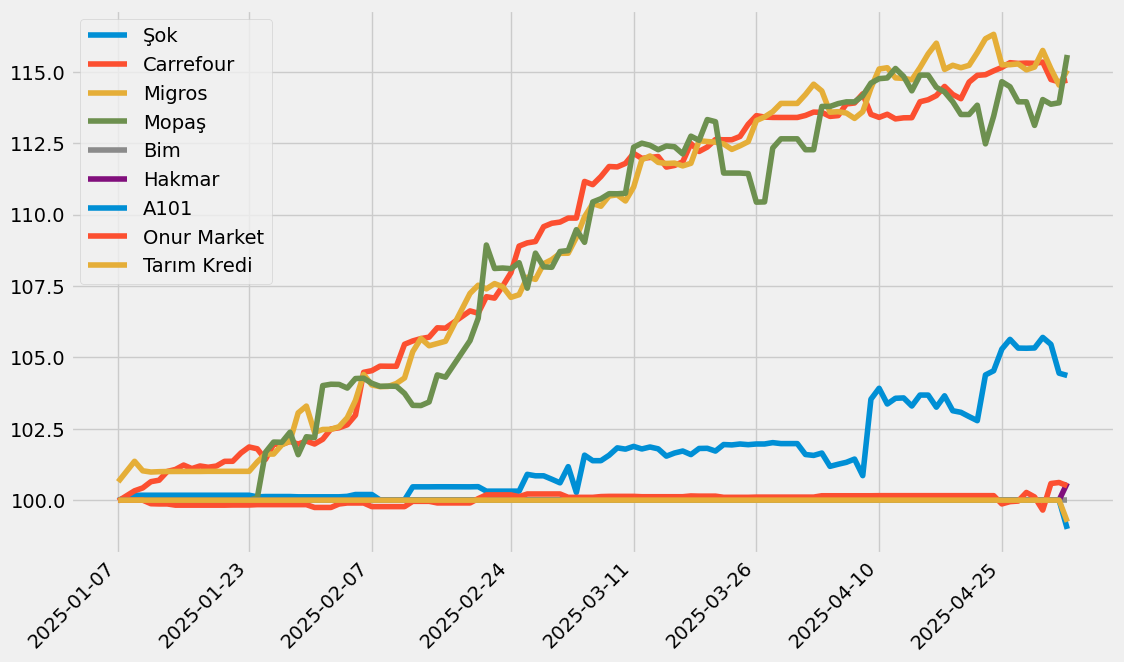

In [352]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
market_endeks.plot(figsize=(12, 8))
plt.xticks(market_endeks.index[::15],rotation=45)
plt.legend()

In [87]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

category_urls = {

    "https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5":"Antep Fıstığı","https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3":"Ay Çekirdeği","https://www.mopas.com.tr/ayran/c/5.3.2.1":"Ayran","https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1":"Ayçiçek Yağı","https://www.mopas.com.tr/badem/c/4.2.5.8":"Badem İçi","https://www.mopas.com.tr/baharat/c/4.11.1":"Baharat","https://www.mopas.com.tr/bal/c/3.9.1":"Bal","https://www.mopas.com.tr/bebek-cay-icecekleri/c/8.16.2":"Bebek Sütü (Toz Karışım)",
    "https://www.mopas.com.tr/sebze/c/1.2":"Sebze","https://www.mopas.com.tr/meyve/c/1.1":"Meyve","https://www.mopas.com.tr/beyaz-peynirler/c/3.2.1":"Beyaz Peynir","https://www.mopas.com.tr/biskuvi/c/4.2.1.4":"Bisküvi",
    "https://www.mopas.com.tr/bitkisel-caylar/c/5.2.1.4":"Bitki ve Meyve Çayı (Poşet)","https://www.mopas.com.tr/bulgur/c/4.1.2":"Bulgur","https://www.mopas.com.tr/diger-un-cesitleri/c/4.12.5.5":"Buğday Unu",
    "https://www.mopas.com.tr/ceviz/c/4.2.5.7":"Ceviz İçi","https://www.mopas.com.tr/cips/c/4.2.2":"Cipsler","https://www.mopas.com.tr/acik-dana-eti/c/2.1.1":"Dana Eti","https://www.mopas.com.tr/dondurmalar/c/3.7.4":"Dondurma",
    "https://www.mopas.com.tr/ekmek/c/4.12.6":"Ekmek","https://www.mopas.com.tr/yufka/c/3.8.2.1":"Ekmek Hamuru (Yufka)","https://www.mopas.com.tr/findik-ezmesi/c/3.9.4.1":"Fındık Ezmesi",
    "https://www.mopas.com.tr/findik/c/4.2.5.6":"Fındık İçi","https://www.mopas.com.tr/gazoz/c/5.1.2":"Gazoz Meyveli","https://www.mopas.com.tr/gofret/c/4.3.3":"Gofret","https://www.mopas.com.tr/hazir-kahveler/c/5.2.2.2":"Hazır Kahve",
    "https://www.mopas.com.tr/pudingler/c/4.12.4.2":"Hazır Pakette Toz Tatlılar (Puding)","https://www.mopas.com.tr/sutlu-tatlilar/c/3.7.2":"Hazır Sütlü Tatlılar","https://www.mopas.com.tr/hazir-corba/c/4.6.2.3":"Hazır Çorbalar",
    "https://www.mopas.com.tr/kabak-cekirdegi/c/4.2.5.2":"Kabak Çekirdeği","https://www.mopas.com.tr/kabartma-tozu-ve-vanili/c/4.12.3.8":"Kabartma Maddeleri","https://www.mopas.com.tr/filtre-kahveler/c/5.2.2.3":"Kahve",
    "https://www.mopas.com.tr/turk-kahvesi/c/5.2.2.1":"Kahve","https://www.mopas.com.tr/kakao/c/4.12.3.9":"Kakao","https://www.mopas.com.tr/kasar-peynirler/c/3.2.3":"Kaşar Peyniri","https://www.mopas.com.tr/kek/c/4.2.3":"Kek",
    "https://www.mopas.com.tr/kup-sekerler/c/5.2.4.1":"Kesme Şeker","https://www.mopas.com.tr/ketcaplar/c/4.8.3.3":"Ketçap","https://www.mopas.com.tr/cola/c/5.1.1":"Kola",
    "https://www.mopas.com.tr/ton-baligi/c/4.8.4.2":"Konserve Balık","https://www.mopas.com.tr/haslanmis-konserveler/c/4.8.4.7":"Konserveler","https://www.mopas.com.tr/bezelye-konserveleri/c/4.8.4.4":"Konserveler","https://www.mopas.com.tr/bamya-konserveleri/c/4.8.4.3":"Konserveler",
    "https://www.mopas.com.tr/kraker/c/4.2.1.1":"Kraker","https://www.mopas.com.tr/eritme-peynirler/c/3.2.2":"Krem Peynir","https://www.mopas.com.tr/fasulye/c/4.1.4.4":"Kuru Fasulye",
    "https://www.mopas.com.tr/kayisi/c/4.2.4.14":"Kuru Kayısı","https://www.mopas.com.tr/acik-kuzu-eti/c/2.1.2":"Kuzu Eti","https://www.mopas.com.tr/search?q=lokum%3Arelevance%3Acategory%3A3.9":"Lokum",
    "https://www.mopas.com.tr/sade-maden-suyu/c/5.5.3":"Maden Suyu ve Sodası","https://www.mopas.com.tr/sade-makarna/c/4.1.1.3":"Makarna","https://www.mopas.com.tr/paket-margarin/c/3.4.2.2":"Margarin",
    "https://www.mopas.com.tr/mayonezler/c/4.8.3.4":"Mayonez",  "https://www.mopas.com.tr/kirmizi-mercimek/c/4.1.4.5":"Mercimek","https://www.mopas.com.tr/meyve-suyu/c/5.4.1":"Meyve Suyu",
    "https://www.mopas.com.tr/nohut/c/4.1.4.7":"Nohut","https://www.mopas.com.tr/pekmez/c/3.9.2.3":"Pekmez","https://www.mopas.com.tr/pirinc/c/4.1.3":"Pirinç","https://www.mopas.com.tr/recel/c/3.9.5.1":"Reçel",
    "https://www.mopas.com.tr/sakiz/c/4.5.1":"Sakız","https://www.mopas.com.tr/salam/c/2.4.3":"Salam","https://www.mopas.com.tr/salca/c/4.8.6":"Salça","https://www.mopas.com.tr/sirke/c/4.8.5.4":"Sirke",
    "https://www.mopas.com.tr/sosis/c/2.4.2":"Sosis","https://www.mopas.com.tr/soguk-cay/c/5.4.2.1":"Soğuk Çay","https://www.mopas.com.tr/sade-sular/c/5.5.1":"Su","https://www.mopas.com.tr/sucuk/c/2.4.1":"Sucuk",
    "https://www.mopas.com.tr/sut/c/3.1":"Süt","https://www.mopas.com.tr/tahin/c/3.9.2.2":"Tahin","https://www.mopas.com.tr/pilic/c/2.2.1":"Tavuk Eti","https://www.mopas.com.tr/kase-margarin/c/3.4.2.1":"Tereyağı (Kahvaltılık)",
    "https://www.mopas.com.tr/toz-sekerler/c/5.2.4.3":"Toz Şeker","https://www.mopas.com.tr/tursu/c/4.8.7":"Turşu","https://www.mopas.com.tr/tuz/c/4.11.3.1":"Tuz","https://www.mopas.com.tr/fistik/c/4.2.5.4":"Yer Fıstığı",
    "https://www.mopas.com.tr/sade-yogurtlar/c/3.3.1":"Yoğurt","https://www.mopas.com.tr/yumurta/c/3.5":"Yumurta","https://www.mopas.com.tr/zeytin/c/3.6":"Zeytin","https://www.mopas.com.tr/sizma-zeytinyaglari/c/4.10.7.3":"Zeytinyağı",
    "https://www.mopas.com.tr/dokme-caylar/c/5.2.1.1":"Çay","https://www.mopas.com.tr/tablet-cikolata/c/4.3.2.3":"Çikolata Tablet"


}
search_urls = {"https://www.mopas.com.tr/search?q=kuru+%C3%BCz%C3%BCm%3Arelevance%3Acategory%3A4.2%3Acategory%3A4.2.4%3Acategory%3A4.2.4.17":"Kuru Üzüm",
            "https://www.mopas.com.tr/search?q=tulum%3Arelevance%3Acategory%3A3.2":"Tulum Peyniri"

}

all_products = []

# **Genel Veri Çekme Fonksiyonu**
def scrape_products(url, source_type, index_name):
    page = 0
    while True:
        # Kategori için sayfalama URL'si
        if source_type == "Kategori":
            full_url = f"{url}?q=%3Arelevance&page={page}"
        # Arama için doğru URL formatı
        elif source_type == "Arama":
            full_url = f"{url}&page={page}"

        print(f"Veri çekiliyor: {full_url}")
        response = requests.get(full_url)
        if response.status_code != 200:
            print(f"Hata ({source_type} - {index_name}): {response.status_code}")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        product_cards = soup.find_all("div", class_="card")

        if not product_cards:
            break  # Ürün yoksa sonlandır

        for card in product_cards:
            try:
                name = card.find("a", class_="product-title").text.strip()
            except:
                name = "Bilinmiyor"

            try:
                quantity = card.find("p", class_="quantity").text.strip()
            except:
                quantity = "Bilinmiyor"

            try:
                image_url = card.find("img")["src"]
            except:
                image_url = "Yok"

            try:
                sale_price = card.find("span", class_="sale-price").text.strip()
            except:
                sale_price = "Bilinmiyor"

            try:
                old_price = card.find("span", class_="old-price").text.strip()
            except:
                old_price = sale_price  # İndirim yoksa normal fiyat

            all_products.append({
                "Index İsmi": index_name,  # Eklenen index bilgisi
                "Kaynak": source_type,
                "Bağlantı": full_url,
                "Ürün Adı": name,
                "Fiyat (İndirimsiz)": old_price,
                "İndirimli Fiyat": sale_price if old_price != sale_price else None,
                "Miktar": quantity,
                "Resim": image_url
            })

        print(f"{source_type} - {index_name} - Sayfa {page+1} tamamlandı.")
        page += 1  # Sonraki sayfaya geç

# **Kategori Linklerinden Veri Çekme**
for category_url, index_name in category_urls.items():
    scrape_products(category_url, "Kategori", index_name)

# **Arama Linklerinden Veri Çekme**
for search_url, index_name in search_urls.items():
    scrape_products(search_url, "Arama", index_name)

# **Veriyi DataFrame'e dönüştür**
df = pd.DataFrame(all_products)

"""
meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]


for madde in df.index.unique():
    dff=df.loc[madde]
    if isinstance(dff,pd.Series):
        dfff=pd.DataFrame(dff).T
        data=veriekle(madde,data,dfff)
    else:
        data=veriekle(madde,data,dff)"""

Veri çekiliyor: https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5?q=%3Arelevance&page=0
Kategori - Antep Fıstığı - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3?q=%3Arelevance&page=0
Kategori - Ay Çekirdeği - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/ayran/c/5.3.2.1?q=%3Arelevance&page=0
Kategori - Ayran - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/ayran/c/5.3.2.1?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1?q=%3Arelevance&page=0
Kategori - Ayçiçek Yağı - Sayfa 1 tamamlandı.
Veri çekiliyor: https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1?q=%3Arelevance&page=1
Veri çekiliyor: https://www.mopas.com.tr/badem/c/4.2.5.8?q=%3Arelevance&page=0
Kategori - Badem İçi - Sayfa 1 tamamlandı.
Veri çekiliyor: https://

'\nmeyve=df[df["Index İsmi"]=="Meyve"]\nmeyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"\nmeyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"\nmeyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"\nmeyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"\nmeyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"\nmeyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"\nmeyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"\nmeyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"\nmeyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"\nmeyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"\nmeyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"\nmeyve.loc[meyve["Ürün Adı

In [91]:
meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]

C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\1310015418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\1310015418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\1310015418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [92]:
df

,Ürün,2025-05-03
,,
Antep Fıstığı,Tadım Antep Fıstığı 180 gr,253.00
Antep Fıstığı,Tadım Antep Fıstığı 122 gr,172.50
Antep Fıstığı,Emsal Kuruyemiş Antep Fıstığı 150 gr,137.95
Armut,Armut Santa,51.73
Armut,Armut Deveci,40.23
...,...,...
Çikolata Tablet,Eti Antep Fıstıklı Kare Çikolata 60 gr,86.25
Çikolata Tablet,Eti Karam Antep Fıstıklı Kare Bitter Çikolata ...,68.40
Çikolata Tablet,Torku Miniki Sütlü Çikolata 72 gr,56.90


In [96]:
data[data["Ürün"].isin(df["Ürün"])].iloc[:,-2:].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values()*100

C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\3830531100.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[data["Ürün"].isin(df["Ürün"])].iloc[:,-2:].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean().sort_values()*100



Hazır Sütlü Tatlılar   -0.899349
Gazoz Meyveli          -0.566004
Yoğurt                 -0.191460
Dondurma               -0.176386
Pırasa                  0.000000
                          ...   
Kakao                   0.000000
Salam                   0.250000
Süt                     0.313906
Su                      0.850338
Ayran                   1.153846
Name: 2025-05-02, Length: 107, dtype: float64

In [93]:
ağırlıklar=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
gıda_w=ağırlıklar[ağırlıklar["Ana Grup"]=="Gıda ve alkolsüz içecekler"]["Ağırlık"]/ağırlıklar[ağırlıklar["Ana Grup"]=="Gıda ve alkolsüz içecekler"]["Ağırlık"].sum()

In [94]:
(gıda_w*data[data["Ürün"].isin(df["Ürün"])].iloc[:,-2:].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean()*100).sum()

C:\Users\Bora\AppData\Local\Temp\ipykernel_32960\578048946.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  (gıda_w*data[data["Ürün"].isin(df["Ürün"])].iloc[:,-2:].pct_change(axis=1).iloc[:,-1].groupby(level=0).mean()*100).sum()


0.013353775945490778

In [ ]:
df=market_fiyat_api("pirinç")
df.index=["Pirinç"]*len(df)
df.to_csv(f"{bugün}/pirinç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Pirinç"]*len(urunler_df)
data=veriekle("Pirinç",data,urunler_df)

df=market_fiyat_api("un")
df=df[df["categories"].str.contains("sade unlar",case=False)]
df=pd.concat([df,market_fiyat_api("buğday unu")],axis=0)
df.index=["Buğday Unu"]*len(df)
df.to_csv(f"{bugün}/buğdayunu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Buğday Unu"]*len(urunler_df)
data=veriekle("Buğday Unu",data,urunler_df)

df=market_fiyat_api("bebek sütü")
df.index=["Bebek Sütü (Toz Karışım)"]*len(df)
df.to_csv(f"{bugün}/bebeksütü.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
urunler_df.index=["Bebek Sütü (Toz Karışım)"]*len(urunler_df)
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

df=market_fiyat_api("bulgur")
df.index=["Bulgur"]*len(df)
df.to_csv(f"{bugün}/bulgur.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bulgur",data,urunler_df)

df=market_fiyat_api("ekmek")
df.index=["Ekmek"]*len(df)
df.to_csv(f"{bugün}/ekmek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek",data,urunler_df)

df=market_fiyat_api("bisküvi")
df.index=["Bisküvi"]*len(df)
df.to_csv(f"{bugün}/bisküvi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bisküvi",data,urunler_df)
def market(ürün,data,filter=""):
    df=market_fiyat_api(ürün)
    if filter!="":
        df=df[df["categories"].str.contains(filter,case=False)]
    df.index=[ürün]*len(df)
    df.to_csv(f"{bugün}/{ürün}.csv")
    df["name"]=df["name"]+" "+df["marketName"]
    urunler_df=df[["name","price"]]
    urunler_df.columns=["Ürün",str(bugün)]
    data=veriekle(f"{ürün}",data,urunler_df)
    return data
data=market("Kraker",data)
data=market("Gofret",data)
data=market("Pasta",data,filter="pasta")
data=market("Kek",data)
data=market("Baklava",data,filter="fıstıklı")

df=market_fiyat_api("Yufka")
df.index=["Ekmek Hamuru (Yufka)"]*len(df)
df.to_csv(f"{bugün}/Ekmek Hamuru (Yufka).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

data=market("Makarna",data)
data=market("Şehriye",data)
data=market("Tahıl Gevreği",data)

df=market_fiyat_api("Dana Kıyma")
df1=market_fiyat_api("Dana Kuşbaşı")
df2=market_fiyat_api("Dana Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Dana Eti"]*len(df)
df.to_csv(f"{bugün}/Dana Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dana Eti",data,urunler_df)

df=market_fiyat_api("Kuzu Kıyma")
df1=market_fiyat_api("Kuzu Kuşbaşı")
df2=market_fiyat_api("Kuzu Köfte")
df=pd.concat([df,df1,df2],axis=0)
df.index=["Kuzu Eti"]*len(df)
df.to_csv(f"{bugün}/Kuzu Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuzu Eti",data,urunler_df)


df=market_fiyat_api("Piliç")
df=df[df["categories"].str.contains("Kümes Hayvanları|piliç",case=False)]
df.index=["Tavuk Eti"]*len(df)
df.to_csv(f"{bugün}/Tavuk Eti.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tavuk Eti",data,urunler_df)

df=market_fiyat_api("kokoreç")
df.index=["Sakatat"]*len(df)
df.to_csv(f"{bugün}/Sakatat.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sakatat",data,urunler_df)

data=market("Sucuk",data)
data=market("Salam",data)

df=market_fiyat_api("kavurma")
df=df[df["categories"].str.contains("konserve|dondurulmuş",case=False)]
df.index=["Hazır Et Yemekleri"]*len(df)
df.to_csv(f"{bugün}/Hazır Et Yemekleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

df=market_fiyat_api("balık")
df=df[df["categories"].str.contains("dondurulmuş",case=False)]
df.index=["Balık"]*len(df)
df.to_csv(f"{bugün}/Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Balık",data,urunler_df)

df=market_fiyat_api("balık")
df=df[df["categories"].str.contains("konserve",case=False)]
df.index=["Konserve Balık"]*len(df)
df.to_csv(f"{bugün}/Konserve Balık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserve Balık",data,urunler_df)


data=market("Süt",data)
data=market("Yoğurt",data)

df=market_fiyat_api("sütlü tatlı")
df.index=["Hazır Sütlü Tatlılar"]*len(df)
df.to_csv(f"{bugün}/Hazır Sütlü Tatlılar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

data=market("Beyaz Peynir",data)
data=market("Kaşar Peyniri",data)
data=market("Tulum Peyniri",data)
data=market("Krem Peynir",data)
data=market("Yumurta",data)

df=market_fiyat_api("Tereyağı")
df.index=["Tereyağı (Kahvaltılık)"]*len(df)
df.to_csv(f"{bugün}/Tereyağı (Kahvaltılık).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

data=market("Margarin",data)
data=market("Zeytinyağı",data)
data=market("Ayçiçek Yağı",data)

df=market_fiyat_api("portakal")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler",case=False)]
df.index=["Portakal"]*len(df)
df.to_csv(f"{bugün}/Portakal.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Portakal",data,urunler_df)

df=market_fiyat_api("Üzüm")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Üzüm"]*len(df)
df.to_csv(f"{bugün}/Üzüm.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Üzüm",data,urunler_df)

df=market_fiyat_api("Armut")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Armut"]*len(df)
df.to_csv(f"{bugün}/Armut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Armut",data,urunler_df)


df=market_fiyat_api("Ayva")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Ayva"]*len(df)
df.to_csv(f"{bugün}/Ayva.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ayva",data,urunler_df)

df=market_fiyat_api("Çilek")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Çilek"]*len(df)
df.to_csv(f"{bugün}/Çilek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Çilek",data,urunler_df)

df=market_fiyat_api("Elma")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Elma"]*len(df)
df.to_csv(f"{bugün}/Elma.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Elma",data,urunler_df)

df=market_fiyat_api("Karpuz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Karpuz"]*len(df)
df.to_csv(f"{bugün}/Karpuz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karpuz",data,urunler_df)

df=market_fiyat_api("Kavun")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kavun"]*len(df)
df.to_csv(f"{bugün}/Kavun.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kavun",data,urunler_df)

df=market_fiyat_api("Kivi")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Kivi"]*len(df)
df.to_csv(f"{bugün}/Kivi.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kivi",data,urunler_df)

df=market_fiyat_api("Limon")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Limon"]*len(df)
df.to_csv(f"{bugün}/Limon.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Limon",data,urunler_df)

df=market_fiyat_api("Mandalina")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Mandalina"]*len(df)
df.to_csv(f"{bugün}/Mandalina.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mandalina",data,urunler_df)


df=market_fiyat_api("Muz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler",case=False)]
df.index=["Muz"]*len(df)
df.to_csv(f"{bugün}/Muz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Muz",data,urunler_df)

df=market_fiyat_api("Nar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Nar"]*len(df)
df.to_csv(f"{bugün}/Nar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nar",data,urunler_df)

df=market_fiyat_api("Şeftali")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|meyveler|meyve Sebze",case=False)]
df.index=["Şeftali"]*len(df)
df.to_csv(f"{bugün}/Şeftali.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Şeftali",data,urunler_df)

data=market("Badem İçi",data)
data=market("Ceviz İçi",data)
data=market("Fındık İçi",data)
data=market("Yer Fıstığı",data,filter="kuruyemiş")
data=market("Antep Fıstığı",data,filter="kuruyemiş")
data=market("Leblebi",data)
data=market("Ay Çekirdeği",data)
data=market("Kabak Çekirdeği",data)
data=market("Kuru Üzüm",data)
data=market("Kuru Kayısı",data)
data=market("Çarliston Biber",data)
data=market("Dolmalık Biber",data)

df=market_fiyat_api("Sivri Biber")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Sivri Biber"]*len(df)
df.to_csv(f"{bugün}/Sivri Biber.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Sivri Biber",data,urunler_df)

df=market_fiyat_api("Dereotu")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Dereotu"]*len(df)
df.to_csv(f"{bugün}/Dereotu.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Dereotu",data,urunler_df)

df=market_fiyat_api("Domates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Domates"]*len(df)
df.to_csv(f"{bugün}/Domates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Domates",data,urunler_df)

df=market_fiyat_api("Fasulye")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Taze Fasulye"]*len(df)
df.to_csv(f"{bugün}/Taze Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Taze Fasulye",data,urunler_df)

df=market_fiyat_api("Havuç")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Havuç"]*len(df)
df.to_csv(f"{bugün}/Havuç.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Havuç",data,urunler_df)

df=market_fiyat_api("Ispanak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Ispanak"]*len(df)
df.to_csv(f"{bugün}/Ispanak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Ispanak",data,urunler_df)

df=market_fiyat_api("Kabak")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kabak"]*len(df)
df.to_csv(f"{bugün}/Kabak.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabak",data,urunler_df)

df=market_fiyat_api("Karnabahar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Karnabahar"]*len(df)
df.to_csv(f"{bugün}/Karnabahar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Karnabahar",data,urunler_df)

df=market_fiyat_api("Soğan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kuru Soğan"]*len(df)
df.to_csv(f"{bugün}/Kuru Soğan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Soğan",data,urunler_df)

df=market_fiyat_api("Beyaz Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Beyaz Lahana"]*len(df)
df.to_csv(f"{bugün}/Beyaz Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Beyaz Lahana",data,urunler_df)

df=market_fiyat_api("Kırmızı Lahana")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kırmızı Lahana"]*len(df)
df.to_csv(f"{bugün}/Kırmızı Lahana.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kırmızı Lahana",data,urunler_df)

df=market_fiyat_api("Mantar")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Mantar"]*len(df)
df.to_csv(f"{bugün}/Mantar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mantar",data,urunler_df)

df=market_fiyat_api("Kıvırcık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Kıvırcık"]*len(df)
df.to_csv(f"{bugün}/Kıvırcık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kıvırcık",data,urunler_df)

df=market_fiyat_api("Maydanoz")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Maydanoz"]*len(df)
df.to_csv(f"{bugün}/Maydanoz.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maydanoz",data,urunler_df)

df=market_fiyat_api("Nane")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Nane"]*len(df)
df.to_csv(f"{bugün}/Nane.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nane",data,urunler_df)

df=market_fiyat_api("Patlıcan")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patlıcan"]*len(df)
df.to_csv(f"{bugün}/Patlıcan.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patlıcan",data,urunler_df)



df=market_fiyat_api("Roka")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Roka"]*len(df)
df.to_csv(f"{bugün}/Roka.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Roka",data,urunler_df)

df=market_fiyat_api("Salatalık")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Salatalık"]*len(df)
df.to_csv(f"{bugün}/Salatalık.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Salatalık",data,urunler_df)

df=market_fiyat_api("Patates")
df=df[df["categories"].str.contains("Meyve Ve Sebzeler|sebzeler|yeşillikler",case=False)]
df.index=["Patates"]*len(df)
df.to_csv(f"{bugün}/Patates.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Patates",data,urunler_df)

df=market_fiyat_api("Kuru Fasulye")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Kuru Fasulye"]*len(df)
df.to_csv(f"{bugün}/Kuru Fasulye.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kuru Fasulye",data,urunler_df)

df=market_fiyat_api("Nohut")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Nohut"]*len(df)
df.to_csv(f"{bugün}/Nohut.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Nohut",data,urunler_df)

df=market_fiyat_api("Mercimek")
df=df[df["categories"].str.contains("bakliyat",case=False)]
df.index=["Mercimek"]*len(df)
df.to_csv(f"{bugün}/Mercimek.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Mercimek",data,urunler_df)

df=market_fiyat_api("Konserve")
df=df[~df["categories"].str.contains("balık",case=False)]
df.index=["Konserveler"]*len(df)
df.to_csv(f"{bugün}/Konserveler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Konserveler",data,urunler_df)

data=market("Turşu",data)
data=market("Salça",data)
data=market("Zeytin",data)
df=market_fiyat_api("Cips")
df.index=["Cipsler"]*len(df)
df.to_csv(f"{bugün}/Cipsler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Cipsler",data,urunler_df)

data=market("Toz Şeker",data)

df=market_fiyat_api("Küp Şeker")
df.index=["Kesme Şeker"]*len(df)
df.to_csv(f"{bugün}/Kesme Şeker.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kesme Şeker",data,urunler_df)

data=market("Reçel",data)
data=market("Bal",data)
data=market("Pekmez",data)
data=market("Tahin Helvası",data)
data=market("Fındık Ezmesi",data)
data=market("Çikolata Tablet",data)
data=market("Lokum",data)
data=market("Sakız",data)
data=market("Dondurma",data)
data=market("Baharat",data)
data=market("Tuz",data)

df=market_fiyat_api("Kabartma")
df.index=["Kabartma Maddeleri"]*len(df)
df.to_csv(f"{bugün}/Kabartma Maddeleri.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kabartma Maddeleri",data,urunler_df)

data=market("Sirke",data)
data=market("Ketçap",data)
data=market("Mayonez",data)
data=market("Tahin",data)

df=market_fiyat_api("hazır çorba")
df.index=["Hazır Çorbalar"]*len(df)
df.to_csv(f"{bugün}/Hazır Çorbalar.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Çorbalar",data,urunler_df)

df=market_fiyat_api("puding")
df=df[df["categories"].str.contains("hazır",case=False)]
df.index=["Hazır Pakette Toz Tatlılar (Puding)"]*len(df)
df.to_csv(f"{bugün}/Hazır Pakette Toz Tatlılar (Puding).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

data=market("Kahve",data)

df=market_fiyat_api("kahvesi")
df.index=["Kahve"]*len(df)
df.to_csv(f"{bugün}/Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kahve",data,urunler_df)

df=market_fiyat_api("nescafe")
df.index=["Hazır Kahve"]*len(df)
df.to_csv(f"{bugün}/Hazır Kahve.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Hazır Kahve",data,urunler_df)

data=market("Çay",data)

df=market_fiyat_api("bitki çayı")
df.index=["Bitki ve Meyve Çayı (Poşet)"]*len(df)
df.to_csv(f"{bugün}/Bitki ve Meyve Çayı (Poşet).csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

df=market_fiyat_api("toz kakao")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakao"]*len(df)
df.to_csv(f"{bugün}/Kakao.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakao",data,urunler_df)

df=market_fiyat_api("kakaolu içecek")
df=df[df["categories"].str.contains("kakao",case=False)]
df.index=["Kakaolu Toz İçecekler"]*len(df)
df.to_csv(f"{bugün}/Kakaolu Toz İçecekler.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)

data=market("Su",data)

df=market_fiyat_api("maden suyu")
df.index=["Maden Suyu ve Sodası"]*len(df)
df.to_csv(f"{bugün}/Maden Suyu ve Sodası.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

df=market_fiyat_api("gazoz")
df.index=["Gazoz Meyveli"]*len(df)
df.to_csv(f"{bugün}/Gazoz Meyveli.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Gazoz Meyveli",data,urunler_df)

data=market("Kola",data)

df=market_fiyat_api("soğuk çay")
df1=market_fiyat_api("icetea")
df=pd.concat([df,df1],axis=0)
df.index=["Soğuk Çay"]*len(df)
df.to_csv(f"{bugün}/Soğuk Çay.csv")
df["name"]=df["name"]+" "+df["marketName"]
urunler_df=df[["name","price"]]
urunler_df.columns=["Ürün",str(bugün)]
data=veriekle("Soğuk Çay",data,urunler_df)

data=market("Ayran",data)
data=market("Meyve Suyu",data)

























































f=data.loc["Fındık Ezmesi"]
f=f.drop_duplicates(subset=["Ürün"])
data=data.drop("Fındık Ezmesi",axis=0)
data=pd.concat([data,f],axis=0)

for col in data.columns[1:]:
    data[col]=data[col].astype(float)


                

data=data[~data["Ürün"].str.contains("HKS")]
df_filled_corrected=data.copy()
                



df_filled_corrected.to_csv("sepet.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates(subset=["Ürün",bugün,"Market","Şehir"]) 
data1.to_csv("sepet.csv")

degisim=data1[data1.iloc[:,-15:].notna().sum(axis=1) >= 2].iloc[:,-15:].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-1]/data1.iloc[:,-2])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)






ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()



islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)





import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()




    




C:\Users\Bora\AppData\Local\Temp\ipykernel_32944\548863198.py:97: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  urun_data[f'{bugün}'] = urun_data[f'{bugün}_x'].combine_first(urun_data[f'{bugün}_y'])
C:\Users\Bora\AppData\Local\Temp\ipykernel_32944\1067144442.py:772: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  degisim=data1[data1.iloc[:,-15:].notna().sum(axis=1) >= 2].iloc[:,-15:].pct_change(axis=1)
C:\Users\Bora\AppData\Local\Temp\ipykernel_32944\1067144442.py:864: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Commit işlemi başarılı: update
Push işlemi başarılı.


In [23]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time

def scrape_sok_selenium(urls):
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome(options=options)

    data = []
    for url in urls:
        driver.get(url)
        time.sleep(2)  # JavaScript'in yüklenmesi için bekle

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        products = soup.find_all('div', class_='CProductCard-module_productCardWrapper__okAmT')

        for product in products:
            name_tag = product.find('h2', class_='CProductCard-module_title__u8bMW')
            name = name_tag.text.strip() if name_tag else None

            price_tag = product.find('span', class_='CPriceBox-module_price__bYk-c')
            discounted_tag = product.find('span', class_='CPriceBox-module_discountedPrice__15Ffw')

            price_text = price_tag.text.strip() if price_tag else None
            discounted_text = discounted_tag.text.strip() if discounted_tag else None

            def parse_price(text):
                return float(text.replace("₺", "").replace(".", "").replace(",", ".")) if text else None

            price_val = parse_price(price_text)
            discounted_val = parse_price(discounted_text)

            if discounted_val is not None and price_val is not None and discounted_val < price_val:
                final_price = discounted_val
            elif discounted_val is not None:
                final_price = discounted_val
            else:
                final_price = price_val

            print(f"Ürün: {name}")
            print(f"Normal fiyat: {price_val} İndirimli fiyat: {discounted_val} Seçilen fiyat: {final_price}")
            print("-" * 40)

            data.append({"Product Name": name, "Price (TRY)": final_price})

    driver.quit()
    return pd.DataFrame(data)


In [24]:
scrape_sok_selenium(["https://www.sokmarket.com.tr/sebze-c-40"])

Ürün: Domates Kg
Normal fiyat: None İndirimli fiyat: 29.9 Seçilen fiyat: 29.9
----------------------------------------
Ürün: Salatalık Kg
Normal fiyat: 24.9 İndirimli fiyat: None Seçilen fiyat: 24.9
----------------------------------------
Ürün: Salkım Domates Kg
Normal fiyat: 49.9 İndirimli fiyat: None Seçilen fiyat: 49.9
----------------------------------------
Ürün: Çarliston Biber Kg
Normal fiyat: 49.9 İndirimli fiyat: None Seçilen fiyat: 49.9
----------------------------------------
Ürün: Patlıcan Kemer Kg
Normal fiyat: 39.9 İndirimli fiyat: None Seçilen fiyat: 39.9
----------------------------------------
Ürün: Kırmızı Biber Kg
Normal fiyat: 99.9 İndirimli fiyat: None Seçilen fiyat: 99.9
----------------------------------------
Ürün: Mantar 300 g Paket
Normal fiyat: None İndirimli fiyat: 39.9 Seçilen fiyat: 39.9
----------------------------------------


,Product Name,Price (TRY)
0,Domates Kg,29.9
1,Salatalık Kg,24.9
2,Salkım Domates Kg,49.9
3,Çarliston Biber Kg,49.9
4,Patlıcan Kemer Kg,39.9
5,Kırmızı Biber Kg,99.9
6,Mantar 300 g Paket,39.9


In [2]:
series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()

C:\Users\Bora\AppData\Local\Temp\ipykernel_22092\1383873698.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))


Commit işlemi başarılı: update
Push işlemi başarılı.


In [3]:
urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=fasulye&sayfa=1"],"Taze Fasulye")
data=veriekle("Taze Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=havu%C3%A7&sayfa=1"],"Havuç")
data=veriekle("Havuç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=ıspanak&sayfa=1"],"Ispanak")
data=veriekle("Ispanak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kabak&sayfa=1"],"Kabak")
data=veriekle("Kabak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=karnabahar&sayfa=1"],"Karnabahar")
data=veriekle("Karnabahar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=kuru%20so%C4%9Fan"],"Kuru Soğan")
data=veriekle("Kuru Soğan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=beyaz%20lahana&sayfa=1"],"Beyaz Lahana")
data=veriekle("Beyaz Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kırmızı%20lahana&sayfa=1"],"Kırmızı Lahana")
data=veriekle("Kırmızı Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=8&kelime=mantar&sayfa=1"],"Mantar")
data=veriekle("Mantar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1v%C4%B1rc%C4%B1k&sayfa=1"],"Kıvırcık")
data=veriekle("Kıvırcık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=maydanoz&sayfa=1"],"Maydanoz")
data=veriekle("Maydanoz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=nane&sayfa=1"],"Nane")
data=veriekle("Nane",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=patl%C4%B1can&sayfa=1"],"Patlıcan")
data=veriekle("Patlıcan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=p%C4%B1rasa&sayfa=1"],"Pırasa")
data=veriekle("Pırasa",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=roka&sayfa=1"],"Roka")
data=veriekle("Roka",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=salatalık&sayfa=1"],"Salatalık")
data=veriekle("Salatalık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=sar%C4%B1msak%20kuru&sayfa=1"],"Sarımsak")
data=veriekle("Sarımsak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1rm%C4%B1z%C4%B1%20turp&sayfa=1"],"Kırmızı Turp")
data=veriekle("Kırmızı Turp",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=patates%20kg&sayfa=1"],"Patates")
data=veriekle("Patates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=kuru%20fasulye&sayfa=1"],"Kuru Fasulye")
data=veriekle("Kuru Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=nohut&sayfa=1"],"Nohut")
data=veriekle("Nohut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=mercimek&sayfa=1"],"Mercimek")
data=veriekle("Mercimek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/konserve-sebze"],"Konserveler")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tursu"],"Turşu")
data=veriekle("Turşu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salca"],"Salça")
data=veriekle("Salça",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytin"],"Zeytin")
data=veriekle("Zeytin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cips"],"Cipsler")
data=veriekle("Cipsler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=115&kelime=toz%20%C5%9Feker&sayfa=1"],"Toz Şeker")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=114&kelime=k%C3%BCp%20%C5%9Feker&sayfa=1"],"Kesme Şeker")
data=veriekle("Kesme Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/recel-marmelat"],"Reçel")
data=veriekle("Reçel",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=60&kelime=bal&sayfa=1"],"Bal")
data=veriekle("Bal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=61&kelime=pekmez&sayfa=1"],"Pekmez")
data=veriekle("Pekmez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=62&kelime=f%C4%B1nd%C4%B1k%20ezmesi&sayfa=1"],"Fındık Ezmesi")
data=veriekle("Fındık Ezmesi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cikolata"],"Çikolata Tablet")
data=veriekle("Çikolata Tablet",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=krem%20%C3%A7ikolata"],"Çikolata Krem")
data=veriekle("Çikolata Krem",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=224&kelime=lokum&sayfa=1"],"Lokum")
data=veriekle("Lokum",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=283&kelime=sak%C4%B1z&sayfa=1"],"Sakız")
data=veriekle("Sakız",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/geleneksel-sekerleme","https://www.onurmarket.com/yumusak-seker","https://www.onurmarket.com/sekerleme","https://www.onurmarket.com/bayram-sekerleri"],"Kağıtlı Şeker")
data=veriekle("Kağıtlı Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurma"],"Dondurma")
data=veriekle("Dondurma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/baharat"],"Baharat")
data=veriekle("Baharat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tuz"],"Tuz")
data=veriekle("Tuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=179&kelime=kabartma&sayfa=1"],"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=138&kelime=sirke&sayfa=1"],"Sirke")
data=veriekle("Sirke",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=130&kelime=ket%C3%A7ap&sayfa=1"],"Ketçap")
data=veriekle("Ketçap",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=131&kelime=mayonez&sayfa=1"],"Mayonez")
data=veriekle("Mayonez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=tahin"],"Tahin")
data=veriekle("Tahin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/corba"],"Hazır Çorbalar")
data=veriekle("Hazır Çorbalar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=782&kelime=puding&sayfa=1"],"Hazır Pakette Toz Tatlılar (Puding)")
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=304&kelime=t%C3%BCrk%20kahvesi&sayfa=1"],"Kahve")
data=veriekle("Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tek-icimlik-kahveler","https://www.onurmarket.com/soguk-kahve"],"Hazır Kahve")
data=veriekle("Hazır Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dokme-cay","https://www.onurmarket.com/demlik-poset-cay","https://www.onurmarket.com/sallama-cay"],"Çay")
data=veriekle("Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-bitki-form-cayi"],"Bitki ve Meyve Çayı (Poşet)")
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kakao"],"Kakao")
data=veriekle("Kakao",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/icilebilir-su"],"Su")
data=veriekle("Su",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=712&kelime=maden%20suyu&sayfa=1"],"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=349&kelime=gazoz&sayfa=1"],"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=342&kelime=kola&sayfa=1"],"Kola")
data=veriekle("Kola",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/soguk-cay"],"Soğuk Çay")
data=veriekle("Soğuk Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/ayran"],"Ayran")
data=veriekle("Ayran",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-suyu"],"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)

























































f=data.loc["Fındık Ezmesi"]
f=f.drop_duplicates(subset=["Ürün"])
data=data.drop("Fındık Ezmesi",axis=0)
data=pd.concat([data,f],axis=0)

for col in data.columns[1:]:
    data[col]=data[col].astype(float)


                

data=data[~data["Ürün"].str.contains("HKS")]
data=data.drop_duplicates()
df_filled_corrected=data.copy()
                

df_filled_corrected=df_filled_corrected.drop_duplicates()


df_filled_corrected.to_csv("sepet.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("sepet.csv")

degisim=data1[data1.iloc[:,-15:].notna().sum(axis=1) >= 2].iloc[:,-15:].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-1]/data1.iloc[:,-2])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)



sa_data=pd.DataFrame()
for col in tüik.columns:
    sa_data[f"{col} Aylık Ortalama"]=hareketli_aylik_ortalama(özelgöstergeler[col]).iloc[:,[-1,]]
    sa_data[f"{col} Aylık Ortalama"]=sa_data[f"{col} Aylık Ortalama"].fillna(method="ffill")
    sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end')
    sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')
    sa_data.loc["2024-10","Önceki"]=pd.NA
    sa_data[f"{col} Önceki Endeks"]=pd.NA
    sa_data.loc["2024-11-01":,f"{col} Önceki Endeks"]=sa_data.loc[sa_data["Önceki"].dropna(),f"{col} Aylık Ortalama"].values

sa_datadegisim=pd.DataFrame(index=pd.to_datetime(sa_data.loc["2024-11":].index))
for col in tüik.columns:
    sa_datadegisim[col]=((sa_data[f"{col} Aylık Ortalama"]/sa_data[f"{col} Önceki Endeks"]).dropna()).values
    sa_datadegisim[col]=sa_datadegisim[col].astype(float)
    sa_datadegisim.index=pd.to_datetime(sa_datadegisim.index)
sa_datadegisim=sa_datadegisim.resample('M').last()   
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Taze meyve ve sebze")] = [1.082103253420332, 1.0378297012546769]
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Diğer işlenmemiş gıda")] = [1.0333601398698096, 1.014720660120335]



for col in sa_datadegisim.columns:
    sa_datadegisim[f"{col} MA"]=pd.NA


    for row in sa_datadegisim.index:
            tüik_data=tüik[col].loc[:(row.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')]
            tüik_data.loc[pd.to_datetime((row.to_period('M')).to_timestamp(how='end').strftime('%Y-%m-%d'))]=tüik_data.iloc[-1]*sa_datadegisim[col].loc[row]
            from statsmodels.tsa.x13 import x13_arima_analysis


            np.random.seed(42)



            x13_path = r'C:\Users\Bora\Desktop\x13as'
            
            

            
            ayris = x13_arima_analysis(tüik_data, x12path=x13_path,outlier=False,log=False)
            sa_datadegisim[f"{col} MA"].loc[row]=ayris.seasadj.pct_change().iloc[-1]*100


for col in tüik.columns:
    sa_datadegisim[f"{col} Faktör"]=((sa_datadegisim[f"{col} MA"]/100)+1)/sa_datadegisim[col]
    sa_datadegisim["Ay"]=sa_datadegisim.reset_index()["Tarih"].dt.month.values

sa_datadegisim.columns=['Taze meyve ve sebze', 'Diğer işlenmemiş gıda',
'SA Taze meyve ve sebze', 'SA Diğer işlenmemiş gıda',
'Taze meyve ve sebze Faktör', 'Ay', 'Diğer işlenmemiş gıda Faktör']
sa_datadegisim["İşlenmiş gıda"]=hareketli_aylik_ortalama(özelgöstergeler["İşlenmiş gıda"])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("İşlenmiş gıda")] = [2.61412286061347, 1.60328139006671]


ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()

sa_datadegisim["SA İşlenmemiş gıda"]=(sa_datadegisim[islenmemisler.sort_index().index.unique()]*islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()).sum(axis=1)


islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)

sa_datadegisim["SA Web-GFE"]=(sa_datadegisim[genel.sort_index().groupby(level=0)["Ağırlık"].sum().index]*genel.groupby(level=0)["Ağırlık"].sum()).sum(axis=1)
sa_datadegisim.to_csv("magöstergeler.csv")




import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()




    




Fasulye Börülce kg - ₺179,99
Havuç  kg - ₺39,99
Kabak kg - ₺39,99
Karnabahar kg - ₺39,99
Kuru Soğan kg - ₺17,99
Beyaz Lahana kg - ₺29,99
Kırmızı Lahana kg - ₺59,99
Mantar Paket - ₺79,99
Kıvırcık (Lolorosso) Adet - ₺49,99
Kıvırcık Adet - ₺29,99
Maydanoz Adet - ₺19,99
Taze Nane Adet - ₺24,99
Patlıcan Bostan kg - ₺69,99
Patlıcan Kemer kg - ₺39,99
Pırasa kg - ₺49,99
Roka Adet - ₺29,99
Salatalık kg - ₺18,99
Çengelköy Salatalık kg - ₺19,99
Sarımsak Kuru kg - ₺279,99
Kırmızı Turp kg - ₺49,99
Patates kg - ₺24,99
Onur Bereket Kuru Fasulye Kg - ₺59,50
Hasata Kuru Fasulye 1 kg - ₺119,90
Onur Bereket Nohut Kg - ₺50,00
Hasata Nohut Beyaz 1 kg - ₺164,90
Hasata Nohut Koçbaşı 1 kg - ₺109,90
Reis Kırmızı Mercimek 1 kg - ₺114,50
Gökbayrak Yeşil Mercimek 1 kg - ₺179,50
Gökbayrak Kırmızı Mercimek 1 kg - ₺119,95
Duru Kırmızı Mercimek 1 Kg - ₺99,50
Onur Bereket Kırmızı Mercimek Kg - ₺49,90
Onur Bereket Kırmızı Mercimek 2.5 kg - ₺123,90
Hasata Kırmızı Mercimek 1 kg - ₺94,50
Hasata Mercimek Yeşil 1 kg - ₺124,

C:\Users\Bora\AppData\Local\Temp\ipykernel_9968\2715650997.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
C:\Users\Bora\AppData\Local\Temp\ipykernel_9968\2715650997.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
C:\Users\Bora\AppData\Local\Temp\ipykernel_9968\2715650997.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

Commit işlemi başarılı: update
Push işlemi başarılı.


In [14]:
import requests
from bs4 import BeautifulSoup
def onur(url,ürün):
    products=[]
    for link in url:
        
        headers = {
            "User-Agent": "Mozilla/5.0"
        }

        response = requests.get(link, headers=headers)
        soup = BeautifulSoup(response.content, "html.parser")
        
        for product in soup.find_all("div", class_="productDetail videoAutoPlay"):
            name = product.find("a").text
            price = product.find("span", class_="discountPriceSpan").text
            if name and price:
                print(name, "-", price.strip())
                products.append({"Ürün": name.strip(), str(bugün): price.strip()})

        urunler_df=pd.DataFrame(products)
        try:
            urunler_df.index=[ürün]*len(urunler_df)
            urunler_df[bugün]=urunler_df[bugün].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
            return urunler_df
        except:
            return pd.DataFrame()

urunler_df=onur(["https://www.onurmarket.com/pirinc"],"Pirinç")
data=veriekle("Pirinç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bu%C4%9Fday%20unu"],"Buğday Unu")
data=veriekle("Buğday Unu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bebek%20s%C3%BCt%C3%BC"],"Bebek Sütü (Toz Karışım)")
data=veriekle("Bebek Sütü (Toz Karışım)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=bulgur"],"Bulgur")
data=veriekle("Bulgur",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=ekmek"],"Ekmek")
data=veriekle("Ekmek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/biskuvi"],"Bisküvi")
data=veriekle("Bisküvi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kraker"],"Kraker")
data=veriekle("Kraker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/gofret"],"Gofret")
data=veriekle("Gofret",data,urunler_df)


urunler_df=onur(["https://www.onurmarket.com/kek"],"Kek")
data=veriekle("Kek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=59,1129&kelime=baklava&sayfa=1"],"Baklava")
data=veriekle("Baklava",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=1131&kelime=yufka&sayfa=1"],"Ekmek Hamuru (Yufka)")
data=veriekle("Ekmek Hamuru (Yufka)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/makarna"],"Makarna")
data=veriekle("Makarna",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=%C5%9Fehriye"],"Şehriye")
data=veriekle("Şehriye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kahvaltilik-gevrek"],"Tahıl Gevreği")
data=veriekle("Tahıl Gevreği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dana-eti"],"Dana Eti")
data=veriekle("Dana Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kuzu-eti"],"Kuzu Eti")
data=veriekle("Kuzu Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/pilic"],"Tavuk Eti")
data=veriekle("Tavuk Eti",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sakatat"],"Sakatat")
data=veriekle("Sakatat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sucuk"],"Sucuk")
data=veriekle("Sucuk",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sosis"],"Sosis")
data=veriekle("Sosis",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salam"],"Salam")
data=veriekle("Salam",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurulmus-et-urunleri"],"Hazır Et Yemekleri")
data=veriekle("Hazır Et Yemekleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/balik--deniz-urunleri"],"Konserve Balık")
data=veriekle("Konserve Balık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/s%C3%BCt"],"Süt")
data=veriekle("Süt",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/sade-yogurt"],"Yoğurt")
data=veriekle("Yoğurt",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/paketli-sutlu-tatlilar"],"Hazır Sütlü Tatlılar")
data=veriekle("Hazır Sütlü Tatlılar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/beyaz-peynir"],"Beyaz Peynir")
data=veriekle("Beyaz Peynir",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kasar-peyniri"],"Kaşar Peyniri")
data=veriekle("Kaşar Peyniri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tulum-peyniri"],"Tulum Peyniri")
data=veriekle("Tulum Peyniri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/krem-peynir"],"Krem Peynir")
data=veriekle("Krem Peynir",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/yumurta"],"Yumurta")
data=veriekle("Yumurta",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=79&kelime=tereya%C4%9F%C4%B1&sayfa=1"],"Tereyağı (Kahvaltılık)")
data=veriekle("Tereyağı (Kahvaltılık)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=76&kelime=margarin&sayfa=1"],"Margarin")
data=veriekle("Margarin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytinyagi"],"Zeytinyağı")
data=veriekle("Zeytinyağı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/aycicek-yagi"],"Ayçiçek Yağı")
data=veriekle("Ayçiçek Yağı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=portakal&sayfa=1"],"Portakal")
data=veriekle("Portakal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=%C3%BCz%C3%BCm&sayfa=1"],"Üzüm")
data=veriekle("Üzüm",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=armut&sayfa=1"],"Armut")
data=veriekle("Armut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=ayva&sayfa=1"],"Ayva")
data=veriekle("Ayva",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=çilek&sayfa=1"],"Çilek")
data=veriekle("Çilek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=elma&sayfa=1"],"Elma")
data=veriekle("Elma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=karpuz&sayfa=1"],"Karpuz")
data=veriekle("Karpuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kavun&sayfa=1"],"Kavun")
data=veriekle("Kavun",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=kivi&sayfa=1"],"Kivi")
data=veriekle("Kivi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=limon&sayfa=1"],"Limon")
data=veriekle("Limon",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=mandalina&sayfa=1"],"Mandalina")
data=veriekle("Mandalina",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=muz&sayfa=1"],"Muz")
data=veriekle("Muz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=nar&sayfa=1"],"Nar")
data=veriekle("Nar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=13&kelime=şeftali&sayfa=1"],"Şeftali")
data=veriekle("Şeftali",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=badem&sayfa=1"],"Badem İçi")
data=veriekle("Badem İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=ceviz&sayfa=1"],"Ceviz İçi")
data=veriekle("Ceviz İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=fındık&sayfa=1"],"Fındık İçi")
data=veriekle("Fındık İçi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191&kelime=leblebi&sayfa=1"],"Leblebi")
data=veriekle("Leblebi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,198&kelime=ay%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Ay Çekirdeği")
data=veriekle("Ay Çekirdeği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=198&kelime=kabak%20%C3%A7ekirde%C4%9Fi&sayfa=1"],"Kabak Çekirdeği")
data=veriekle("Kabak Çekirdeği",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20%C3%BCz%C3%BCm&sayfa=1"],"Kuru Üzüm")
data=veriekle("Kuru Üzüm",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=191,213&kelime=kuru%20kay%C4%B1s%C4%B1&sayfa=1"],"Kuru Kayısı")
data=veriekle("Kuru Kayısı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=%C3%A7arliston&sayfa=1"],"Çarliston Biber")
data=veriekle("Kuru Kayısı",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=biber%20dolmal%C4%B1k&sayfa=1"],"Dolmalık Biber")
data=veriekle("Dolmalık Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=sivri%20biber&sayfa=1"],"Sivri Biber")
data=veriekle("Sivri Biber",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=dereotu&sayfa=1"],"Dereotu")
data=veriekle("Dereotu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=domates&sayfa=1"],"Domates")
data=veriekle("Domates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=fasulye&sayfa=1"],"Taze Fasulye")
data=veriekle("Taze Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=havu%C3%A7&sayfa=1"],"Havuç")
data=veriekle("Havuç",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=ıspanak&sayfa=1"],"Ispanak")
data=veriekle("Ispanak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kabak&sayfa=1"],"Kabak")
data=veriekle("Kabak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=karnabahar&sayfa=1"],"Karnabahar")
data=veriekle("Karnabahar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=kuru%20so%C4%9Fan"],"Kuru Soğan")
data=veriekle("Kuru Soğan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=beyaz%20lahana&sayfa=1"],"Beyaz Lahana")
data=veriekle("Beyaz Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=kırmızı%20lahana&sayfa=1"],"Kırmızı Lahana")
data=veriekle("Kırmızı Lahana",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=8&kelime=mantar&sayfa=1"],"Mantar")
data=veriekle("Mantar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1v%C4%B1rc%C4%B1k&sayfa=1"],"Kıvırcık")
data=veriekle("Kıvırcık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=maydanoz&sayfa=1"],"Maydanoz")
data=veriekle("Maydanoz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=3&kelime=nane&sayfa=1"],"Nane")
data=veriekle("Nane",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=patl%C4%B1can&sayfa=1"],"Patlıcan")
data=veriekle("Patlıcan",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=p%C4%B1rasa&sayfa=1"],"Pırasa")
data=veriekle("Pırasa",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=roka&sayfa=1"],"Roka")
data=veriekle("Roka",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=salatalık&sayfa=1"],"Salatalık")
data=veriekle("Salatalık",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=sar%C4%B1msak%20kuru&sayfa=1"],"Sarımsak")
data=veriekle("Sarımsak",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=2&kelime=k%C4%B1rm%C4%B1z%C4%B1%20turp&sayfa=1"],"Kırmızı Turp")
data=veriekle("Kırmızı Turp",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=4&kelime=patates%20kg&sayfa=1"],"Patates")
data=veriekle("Patates",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=kuru%20fasulye&sayfa=1"],"Kuru Fasulye")
data=veriekle("Kuru Fasulye",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=nohut&sayfa=1"],"Nohut")
data=veriekle("Nohut",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=90&kelime=mercimek&sayfa=1"],"Mercimek")
data=veriekle("Mercimek",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/konserve-sebze"],"Konserveler")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tursu"],"Turşu")
data=veriekle("Turşu",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/salca"],"Salça")
data=veriekle("Salça",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/zeytin"],"Zeytin")
data=veriekle("Zeytin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cips"],"Cipsler")
data=veriekle("Cipsler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=115&kelime=toz%20%C5%9Feker&sayfa=1"],"Toz Şeker")
data=veriekle("Konserveler",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=114&kelime=k%C3%BCp%20%C5%9Feker&sayfa=1"],"Kesme Şeker")
data=veriekle("Kesme Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/recel-marmelat"],"Reçel")
data=veriekle("Reçel",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=60&kelime=bal&sayfa=1"],"Bal")
data=veriekle("Bal",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=61&kelime=pekmez&sayfa=1"],"Pekmez")
data=veriekle("Pekmez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=62&kelime=f%C4%B1nd%C4%B1k%20ezmesi&sayfa=1"],"Fındık Ezmesi")
data=veriekle("Fındık Ezmesi",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/cikolata"],"Çikolata Tablet")
data=veriekle("Çikolata Tablet",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=krem%20%C3%A7ikolata"],"Çikolata Krem")
data=veriekle("Çikolata Krem",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=224&kelime=lokum&sayfa=1"],"Lokum")
data=veriekle("Lokum",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=283&kelime=sak%C4%B1z&sayfa=1"],"Sakız")
data=veriekle("Sakız",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/geleneksel-sekerleme","https://www.onurmarket.com/yumusak-seker","https://www.onurmarket.com/sekerleme","https://www.onurmarket.com/bayram-sekerleri"],"Kağıtlı Şeker")
data=veriekle("Kağıtlı Şeker",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dondurma"],"Dondurma")
data=veriekle("Dondurma",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/baharat"],"Baharat")
data=veriekle("Baharat",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tuz"],"Tuz")
data=veriekle("Tuz",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=179&kelime=kabartma&sayfa=1"],"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=138&kelime=sirke&sayfa=1"],"Sirke")
data=veriekle("Sirke",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=130&kelime=ket%C3%A7ap&sayfa=1"],"Ketçap")
data=veriekle("Ketçap",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=131&kelime=mayonez&sayfa=1"],"Mayonez")
data=veriekle("Mayonez",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?1&kelime=tahin"],"Tahin")
data=veriekle("Tahin",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/corba"],"Hazır Çorbalar")
data=veriekle("Hazır Çorbalar",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=782&kelime=puding&sayfa=1"],"Hazır Pakette Toz Tatlılar (Puding)")
data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=304&kelime=t%C3%BCrk%20kahvesi&sayfa=1"],"Kahve")
data=veriekle("Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/tek-icimlik-kahveler","https://www.onurmarket.com/soguk-kahve"],"Hazır Kahve")
data=veriekle("Hazır Kahve",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/dokme-cay","https://www.onurmarket.com/demlik-poset-cay","https://www.onurmarket.com/sallama-cay"],"Çay")
data=veriekle("Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-bitki-form-cayi"],"Bitki ve Meyve Çayı (Poşet)")
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/kakao"],"Kakao")
data=veriekle("Kakao",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/icilebilir-su"],"Su")
data=veriekle("Su",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=712&kelime=maden%20suyu&sayfa=1"],"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=349&kelime=gazoz&sayfa=1"],"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/Arama?kategori=342&kelime=kola&sayfa=1"],"Kola")
data=veriekle("Kola",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/soguk-cay"],"Soğuk Çay")
data=veriekle("Soğuk Çay",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/ayran"],"Ayran")
data=veriekle("Ayran",data,urunler_df)

urunler_df=onur(["https://www.onurmarket.com/meyve-suyu"],"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)

Reis Pirinç Osmancık 2 kg - ₺224,90
Reis Osmancık Pirinç 1 kg - ₺129,00
Reis Jasmine Pirinç 1 kg - ₺164,50
Reis Gönen Baldo Pirinç 1 kg - ₺154,50
Gökbayrak Gönen Baldo Pirinç 1 kg - ₺175,00
Gökbayrak Pirinç Basmati 1kg - ₺139,90
Gökbayrak Osmancık Pirinç 1 kg - ₺139,00
Duru Baldo Pirinç 1 Kg - ₺119,50
Duru Osmancık Pirinç 1 Kg - ₺94,00
Onur Bereket Baldo Pirinç 2.5 kg - ₺189,50
Onur Bereket Baldo Pirinç Kg - ₺89,50
Onur Bereket Osmancık Pirinç Kg - ₺50,00
Onur Bereket Osmancık Pirinç 2.5 kg - ₺139,50
Onur Bereket Pilavlık Pirinç Kg - ₺54,50
Duru Baldo Pirinç 2 Kg - ₺189,50
Duru Osmancık Pirinç 2 Kg - ₺189,50
Hasata Pirinç Gönen Baldo 1 kg - ₺114,50
Hasata Pirinç Osmancık 1 kg - ₺94,50
Hasata Pirinç Osmancık 2 kg - ₺184,50
Duru Basmati Pirinç 1 kg - ₺108,90
Hasata Pirinç Gönen Baldo 2 kg - ₺218,90
Söke Tam Buğday Unu Yeşil 1 kg - ₺49,90
Sma Optipro Bebek Sütü 1200 gr 2 Numara - ₺1.200,00
Sma Optipro Bebek Sütü 1200 gr 3 Numara - ₺1.200,00
Hipp 1 Organik Combiotic Bebek Sütü 350 gr - ₺43

In [ ]:
carrefour=["https://www.carrefoursa.com/tursu/c/1234?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tursu-c-454"]
sok=["https://www.sokmarket.com.tr/tursu-c-1860"]
try:
    urunler_df=vericek(carrefour,migros,sok,"Turşu")
except:
    
    urunler_df=vericek(carrefour,migros,sok,"Turşu")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Turşu",data,urunler_df)




carrefour=["https://www.carrefoursa.com/salca/c/1180?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/salca-c-453"]
sok=["https://www.sokmarket.com.tr/salca-c-1830"]


urunler_df=vericek(carrefour,migros,sok,"Salça")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Salça",data,urunler_df)


carrefour=["https://www.carrefoursa.com/zeytin/c/1356?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/zeytin-c-71"]
sok=["https://www.sokmarket.com.tr/zeytin-c-900"]


urunler_df=vericek(carrefour,migros,sok,"Zeytin")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Zeytin",data,urunler_df)





carrefour=["https://www.carrefoursa.com/cipsler/c/1552?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/patates-cipsi-c-27f9"]
sok=["https://www.sokmarket.com.tr/cips-c-20383?page=2","https://www.sokmarket.com.tr/cips-c-20383?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Cipsler")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Cipsler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/toz-seker/c/1162?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/toz-seker-c-544"
]
sok=["https://www.sokmarket.com.tr/mutfak-seker-c-1790"]


urunler_df=vericek(carrefour,migros,sok,"Toz Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Toz", case=False)]
        data=veriekle("Toz Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/kup-seker/c/1161?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kup-seker-c-543"
]


urunler_df=vericek(carrefour,migros,sok,"Kesme Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Küp|kesme|Kesme", case=False)]
        data=veriekle("Kesme Şeker",data,urunler_df)



carrefour=["https://www.carrefoursa.com/recel/c/1367?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/recel-c-277b"
]

sok=["https://www.sokmarket.com.tr/recel-c-910"]
urunler_df=vericek(carrefour,migros,sok,"Reçel")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Reçel",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ballar/c/1362?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/cam-bali-c-2768"
]
sok=["https://www.sokmarket.com.tr/bal-c-920"]

urunler_df=vericek(carrefour,migros,sok,"Bal")
if urunler_df is not None:
    if not urunler_df.empty:
        data=veriekle("Bal",data,urunler_df)




carrefour=["https://www.carrefoursa.com/pekmez/c/1376?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/pekmez-c-2770"
]
sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]

urunler_df=vericek(carrefour,migros,sok,"Pekmez")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Pekmez|Pekmezi", case=False)]
        data=veriekle("Pekmez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/helva/c/1374?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/helva-c-2771?sayfa=1&markalar=425"
]


urunler_df=vericek(carrefour,migros,sok,"Tahin Helvası")

if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin|tahin", case=False)]
        data=veriekle("Tahin Helvası",data,urunler_df)




carrefour=["https://www.carrefoursa.com/ezmeler/c/1383?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/findik-ezmesi-c-2778"
]
sok=["https://www.sokmarket.com.tr/krem-cikolata-ve-ezme-c-930"]

urunler_df=vericek(carrefour,migros,sok,"Fındık Ezmesi")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Fındık Ezmesi", case=False)]
        data=veriekle("Fındık Ezmesi",data,urunler_df)



carrefour=["https://www.carrefoursa.com/cikolata/c/1507?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/cikolata-c-439"
]

sok=["https://www.sokmarket.com.tr/cikolata-c-20377?page=4","https://www.sokmarket.com.tr/cikolata-c-20377?page=3","https://www.sokmarket.com.tr/cikolata-c-20377?page=2","https://www.sokmarket.com.tr/cikolata-c-20377?page=1"]
urunler_df=vericek(carrefour,migros,sok,"Çikolata Tablet")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tablet|Kare", case=False)]
        data=veriekle("Çikolata Tablet",data,urunler_df)



carrefour=["https://www.carrefoursa.com/search?q=krem+%C3%A7ikolata%3AbestSeller%3AproductPrimaryCategoryCode%3A1381%3AinStockFlag%3Atrue&text=krem+%C3%A7ikolata#?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-findik-kremalari-c-2779"
]


urunler_df=vericek("",migros,sok,"Çikolata Krem")

if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Ezmesi", case=False)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Krem|krem", case=False)]
        data=veriekle("Çikolata Krem",data,urunler_df)



carrefour=["https://www.carrefoursa.com/lokum/c/2397?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/lokum-c-281c"
]
sok=["https://www.sokmarket.com.tr/arama?q=lokum&kategori=20376"]

urunler_df=vericek(carrefour,migros,sok,"Lokum")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Lokum|lokum", case=False)]
        data=veriekle("Lokum",data,urunler_df)






carrefour=["https://www.carrefoursa.com/sakizlar/c/1501?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/sakiz-c-443"
]
sok=["https://www.sokmarket.com.tr/sakiz-c-20387?page=2","https://www.sokmarket.com.tr/sakiz-c-20387?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Sakız")
if urunler_df is not None :
    if not urunler_df.empty:
        data=veriekle("Sakız",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sekerleme/c/1494?q=%3AbestSeller%3Acategory%3ABRN-1949%3Acategory%3ABRN-2504%3Acategory%3ABRN-3185%3Acategory%3ABRN-2125%3Acategory%3ABRN-3091%3Acategory%3ABRN-2999%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/ikramlik-sekerleme-c-2822"
]
sok=["https://www.sokmarket.com.tr/sekerleme-c-20388?page=1","https://www.sokmarket.com.tr/sekerleme-c-20388?page=2"]


urunler_df=vericek(carrefour,migros,sok,"Kağıtlı Şeker")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Baklava|Pişmaniye|Lokum", case=False)]
        data=veriekle("Kağıtlı Şeker",data,urunler_df)




carrefour=["https://www.carrefoursa.com/kap-dondurma/c/1261?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All",
        "https://www.carrefoursa.com/tek-dondurma/c/1266?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/dondurma-c-41b"
]
sok=["https://www.sokmarket.com.tr/dondurma-c-31102?page=3","https://www.sokmarket.com.tr/dondurma-c-31102?page=2","https://www.sokmarket.com.tr/dondurma-c-31102?page=1"]

urunler_df=vericek(carrefour,migros,sok,"Dondurma")

data=veriekle("Dondurma",data,urunler_df)




carrefour=["https://www.carrefoursa.com/baharat/c/1167?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/baharat-c-435"
]
sok=["https://www.sokmarket.com.tr/tuz-baharat-c-1890","https://www.sokmarket.com.tr/tuz-baharat-c-1890?page=2"]



urunler_df=vericek(carrefour,migros,sok,"Baharat")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Baharat",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tuz/c/1166?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tuz-c-436"
]


urunler_df=vericek(carrefour,migros,sok,"Tuz")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tuz", case=False)]
data=veriekle("Tuz",data,urunler_df)





carrefour=["https://www.carrefoursa.com/kabartma-tozu/c/1302?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kabartma-tozu-sekerli-vanilin-c-2893"
]
sok=["https://www.sokmarket.com.tr/arama?q=kabartma"]



urunler_df=vericek(carrefour,migros,sok,"Kabartma Maddeleri")
data=veriekle("Kabartma Maddeleri",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sirke/c/1217?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/sirke-c-284f"
]
sok=["https://www.sokmarket.com.tr/salata-sosu-c-1900"]


urunler_df=vericek(carrefour,migros,sok,"Sirke")
data=veriekle("Sirke",data,urunler_df)



carrefour=["https://www.carrefoursa.com/ketcap/c/1211?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/ketcap-c-2847"
]
sok=["https://www.sokmarket.com.tr/ketcap-c-31355"]


urunler_df=vericek(carrefour,migros,sok,"Ketçap")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Mayonez", case=False)]
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ketçap")]

    data=veriekle("Ketçap",data,urunler_df)


carrefour=["https://www.carrefoursa.com/mayonez/c/1212?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/mayonez-c-2848"
]
sok=["https://www.sokmarket.com.tr/mayonez-c-31356"]


urunler_df=vericek(carrefour,migros,sok,"Mayonez")
data=veriekle("Mayonez",data,urunler_df)



carrefour=["https://www.carrefoursa.com/tahin/c/1375?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/tahin-c-276f"
]
sok=["https://www.sokmarket.com.tr/tahin-pekmez-ve-helva-c-940"]



urunler_df=vericek(carrefour,migros,sok,"Tahin")
if urunler_df is not None and not urunler_df.empty:
    urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tahin", case=False)]
    urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Pekmezi|Helva", case=False)]
    data=veriekle("Tahin",data,urunler_df)




carrefour=["https://www.carrefoursa.com/hazir-corbalar/c/1224?q=%3AbestSeller&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/pratik-yemek-c-44f?sayfa=1&markalar=424,483"
]
sok=["https://www.sokmarket.com.tr/corba-c-28478"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Çorbalar")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Çorba|çorba|çorbası|Çorbası", case=False)]
        data=veriekle("Hazır Çorbalar",data,urunler_df)





carrefour=["https://www.carrefoursa.com/hazirlanacak-tatlilar/c/1300?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]
migros=["https://www.migros.com.tr/rest/search/screens/puding-c-41d"
]
sok=["https://www.sokmarket.com.tr/tatli-ve-puding-c-580"]

urunler_df=vericek(carrefour,migros,sok,"Hazır Pakette Toz Tatlılar (Puding)")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("puding|Puding|pudingi|Pudingi", case=False)]
        data=veriekle("Hazır Pakette Toz Tatlılar (Puding)",data,urunler_df)





carrefour=["https://www.carrefoursa.com/turk-kahvesi/c/1468?q=&show=All##","https://www.carrefoursa.com/filtre-kahve/c/1469?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/filtre-kahve-c-11223","https://www.migros.com.tr/rest/search/screens/turk-kahvesi-c-28c4","https://www.migros.com.tr/rest/search/screens/kapsul-kahve-c-11224","https://www.migros.com.tr/rest/search/screens/cekirdek-kahve-c-11225"
]
sok=["https://www.sokmarket.com.tr/kahve-c-43178?page=2","https://www.sokmarket.com.tr/kahve-c-43178?page=2"]

urunler_df=vericek(carrefour,migros,sok,"Kahve")
urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Arada|arada", case=False)]
data=veriekle("Kahve",data,urunler_df)



carrefour=["https://www.carrefoursa.com/granul-kahve/c/1472?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/hazir-kahve-c-11222"
]



urunler_df=vericek(carrefour,migros,sok,"Hazır Kahve")
if urunler_df is not None :
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Türk", case=False)]
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Arada|arada|Starbucks", case=False)]
        data=veriekle("Hazır Kahve",data,urunler_df)






migros=["https://www.migros.com.tr/rest/search/screens/dokme-cay-c-28c1"
]
sok=["https://www.sokmarket.com.tr/cay-c-960?page=2","https://www.sokmarket.com.tr/cay-c-960?page=1"]

urunler_df=vericek("",migros,sok,name="Çay")
data=veriekle("Çay",data,urunler_df)



migros=["https://www.migros.com.tr/rest/search/screens/bitki-cayi-c-28c0"
]


urunler_df=vericek("",migros,sok,name="Bitki ve Meyve Çayı (Poşet)")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Bitki", case=False)]
data=veriekle("Bitki ve Meyve Çayı (Poşet)",data,urunler_df)





migros=["https://www.migros.com.tr/rest/search/screens/uzun-omurlu-sut-c-40a?sayfa=1&109=1005"
]


urunler_df=vericek("",migros,"",name="Kakaolu Toz İçecekler")
data=veriekle("Kakaolu Toz İçecekler",data,urunler_df)



carrefour=["https://www.carrefoursa.com/sular/c/1411?q=%3AbestSeller%3AinStockFlag%3Atrue&show=All"]

migros=["https://www.migros.com.tr/rest/search/screens/su-c-84"
]
sok=["https://www.sokmarket.com.tr/su-c-20506"]
urunler_df=vericek(carrefour,migros,sok,"Su")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Su|su")]
        data=veriekle("Su",data,urunler_df)





carrefour=["https://www.carrefoursa.com/maden-sulari/c/1412?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/maden-suyu-c-85"
]
sok=["https://www.sokmarket.com.tr/maden-suyu-c-20507"]

urunler_df=vericek(carrefour,migros,sok,"Maden Suyu ve Sodası")
data=veriekle("Maden Suyu ve Sodası",data,urunler_df)








carrefour=["https://www.carrefoursa.com/gazoz/c/1423?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/gazoz-c-467"
]
sok=["https://www.sokmarket.com.tr/gazoz-c-20509?page=2","https://www.sokmarket.com.tr/gazoz-c-20509?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Gazoz Meyveli")
data=veriekle("Gazoz Meyveli",data,urunler_df)










carrefour=["https://www.carrefoursa.com/kola/c/1419?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kola-c-465"
]
sok=["https://www.sokmarket.com.tr/kola-c-20508"]


urunler_df=vericek(carrefour,migros,sok,"Kola")
data=veriekle("Kola",data,urunler_df)





carrefour=["https://www.carrefoursa.com/soguk-cay/c/1450?q=&show=All##"]
migros=["https://www.migros.com.tr/rest/search/screens/soguk-cay-c-28be"]
sok=["https://www.sokmarket.com.tr/soguk-cay-c-31729"]


urunler_df=vericek(carrefour,migros,sok,"Soğuk Çay")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[~urunler_df["Ürün"].str.contains("Poşet|Dökme|Çaycı|Yeşil|Gr|gr|Çaykur")]

data=veriekle("Soğuk Çay",data,urunler_df)








carrefour=["https://www.carrefoursa.com/ayran/c/1485?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/ayran-c-47a"
        
]

sok=["https://www.sokmarket.com.tr/ayran-c-31109"]
urunler_df=vericek(carrefour,migros,sok,"Ayran")
if urunler_df is not None:
    if not urunler_df.empty:
        urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Ayran|ayran", case=False)]

        data=veriekle("Ayran",data,urunler_df)




carrefour=["https://www.carrefoursa.com/meyve-suyu/c/1430?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/meyve-suyu-c-46c"
        
]
sok=["https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=2","https://www.sokmarket.com.tr/meyve-suyu-c-20510?page=1"]


urunler_df=vericek(carrefour,migros,sok,"Meyve Suyu")
data=veriekle("Meyve Suyu",data,urunler_df)








migros=["https://www.migros.com.tr/rest/search/screens/tulum-peyniri-c-2734"
        
]
sok=["https://www.sokmarket.com.tr/yoresel-peynir-c-530"]


urunler_df=vericek("",migros,sok,name="Tulum Peyniri")
urunler_df=urunler_df[urunler_df["Ürün"].str.contains("Tulum|tulum", case=False)]
data=veriekle("Tulum Peyniri",data,urunler_df)


carrefour=["https://www.carrefoursa.com/kakao/c/1304?q=&show=All#"]
migros=["https://www.migros.com.tr/rest/search/screens/kakao-c-2894"
        
]
sok=["https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=2","https://www.sokmarket.com.tr/hamur-ve-pasta-malzemeleri-c-20375?page=1"]

urunler_df=vericek(carrefour,migros,sok,name="Kakao")
runler_df=urunler_df[urunler_df["Ürün"].str.contains("Kakao|kakao", case=False)]
data=veriekle("Kakao",data,urunler_df)

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time







from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime, timedelta
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time




"""chrome_options = Options()
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--disable-gpu")  
chrome_options.add_argument("--no-sandbox")  

driver = webdriver.Chrome(options=chrome_options)

driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

tarih=datetime.now().strftime("%d.%m.%Y")
date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
date_input.clear()
date_input.send_keys(tarih)  

price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
price_button.click()

all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
all_pages_radio.click()

excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
excel_button.click()

time.sleep(2)

print(f"{tarih} çekildi!")

driver.quit()"""


"""import pandas as pd




import os
import glob

dosya_yolu = 'C:/Users/Bora/Downloads'  # Burada kendi dosya yolunuzu belirtin
datam=pd.DataFrame()
xls_dosyalari = glob.glob(os.path.join(dosya_yolu, '*.xls'))
for file in xls_dosyalari:
    df=pd.read_html(file)[0]
    df.index=[df.iloc[0,0][16:].split("(")[0][:-1]]*len(df)
    df.index=pd.to_datetime(df.index,dayfirst=True)
    df.columns=df.iloc[1].values
    df=df.iloc[2:]
    df["Ortalama Fiyat"]=df["Ortalama Fiyat"].astype(float)/100
    df["İşlem Hacmi"]=df["İşlem Hacmi"].astype(float)
    df["Hacimli"]=df["İşlem Hacmi"]*df["Ortalama Fiyat"]
    df["Tarih"]=df.index.strftime("%Y-%m-%d")
    df=df.set_index("Ürün Adı")
    df["Ağırlıklı Fiyat"]=df.groupby("Ürün Adı")["Hacimli"].sum()/df.groupby("Ürün Adı")["İşlem Hacmi"].sum()
    df["Ürün Adı"]=df.index
    df=df.set_index("Tarih")
    datam=pd.concat([datam,df],axis=0)"""



"""w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
sebzeler=pd.DataFrame()
import numpy as np
for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
    if sebze=="Çarliston Biber":
        sebze="Biber Çarliston"
    elif sebze=="Dolmalık Biber":
        sebze="Biber Dolmalık"
    elif sebze=="Sivri Biber":
        sebze="Biber Sivri"   
    elif sebze=="Taze Fasulye":
        sebze="Fasulye Taze" 
    elif sebze=="Kuru Soğan":
        sebze="Soğan Kuru"
    elif sebze=="Kırmızı Turp":
        sebze="turp"
    
    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(sebze,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[sebze]*len(hal)



    print(f"{sebze} verisi bulundu")
    sebzeler=pd.concat([sebzeler,hal],axis=0)


sebzeler.index=w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values
sebzeler["Ürün"]=f"HKS" + sebzeler.index

for sebze in sebzeler.index:
    urunler_df=pd.DataFrame(sebzeler.loc[sebze]).T
    data=veriekle(sebze,data,urunler_df)


w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
meyveler=pd.DataFrame()
import numpy as np
for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:

    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(meyve,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[meyve]*len(hal)



    print(f"{meyve} verisi bulundu")
    meyveler=pd.concat([meyveler,hal],axis=0)


meyveler.index=w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values
meyveler["Ürün"]=f"HKS" + meyveler.index



for meyve in meyveler.index:
    urunler_df=pd.DataFrame(meyveler.loc[meyve]).T
    data=veriekle(meyve,data,urunler_df)
"""


import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

category_urls = {

    "https://www.mopas.com.tr/antep-fistigi/c/4.2.5.5":"Antep Fıstığı","https://www.mopas.com.tr/aycekirdegi/c/4.2.5.3":"Ay Çekirdeği","https://www.mopas.com.tr/ayran/c/5.3.2.1":"Ayran","https://www.mopas.com.tr/aycicek-yagi/c/4.10.1.1":"Ayçiçek Yağı","https://www.mopas.com.tr/badem/c/4.2.5.8":"Badem İçi","https://www.mopas.com.tr/baharat/c/4.11.1":"Baharat","https://www.mopas.com.tr/bal/c/3.9.1":"Bal","https://www.mopas.com.tr/bebek-cay-icecekleri/c/8.16.2":"Bebek Sütü (Toz Karışım)",
    "https://www.mopas.com.tr/sebze/c/1.2":"Sebze","https://www.mopas.com.tr/meyve/c/1.1":"Meyve","https://www.mopas.com.tr/beyaz-peynirler/c/3.2.1":"Beyaz Peynir","https://www.mopas.com.tr/biskuvi/c/4.2.1.4":"Bisküvi",
    "https://www.mopas.com.tr/bitkisel-caylar/c/5.2.1.4":"Bitki ve Meyve Çayı (Poşet)","https://www.mopas.com.tr/bulgur/c/4.1.2":"Bulgur","https://www.mopas.com.tr/diger-un-cesitleri/c/4.12.5.5":"Buğday Unu",
    "https://www.mopas.com.tr/ceviz/c/4.2.5.7":"Ceviz İçi","https://www.mopas.com.tr/cips/c/4.2.2":"Cipsler","https://www.mopas.com.tr/acik-dana-eti/c/2.1.1":"Dana Eti","https://www.mopas.com.tr/dondurmalar/c/3.7.4":"Dondurma",
    "https://www.mopas.com.tr/ekmek/c/4.12.6":"Ekmek","https://www.mopas.com.tr/yufka/c/3.8.2.1":"Ekmek Hamuru (Yufka)","https://www.mopas.com.tr/findik-ezmesi/c/3.9.4.1":"Fındık Ezmesi",
    "https://www.mopas.com.tr/findik/c/4.2.5.6":"Fındık İçi","https://www.mopas.com.tr/gazoz/c/5.1.2":"Gazoz Meyveli","https://www.mopas.com.tr/gofret/c/4.3.3":"Gofret","https://www.mopas.com.tr/hazir-kahveler/c/5.2.2.2":"Hazır Kahve",
    "https://www.mopas.com.tr/pudingler/c/4.12.4.2":"Hazır Pakette Toz Tatlılar (Puding)","https://www.mopas.com.tr/sutlu-tatlilar/c/3.7.2":"Hazır Sütlü Tatlılar","https://www.mopas.com.tr/hazir-corba/c/4.6.2.3":"Hazır Çorbalar",
    "https://www.mopas.com.tr/kabak-cekirdegi/c/4.2.5.2":"Kabak Çekirdeği","https://www.mopas.com.tr/kabartma-tozu-ve-vanili/c/4.12.3.8":"Kabartma Maddeleri","https://www.mopas.com.tr/filtre-kahveler/c/5.2.2.3":"Kahve",
    "https://www.mopas.com.tr/turk-kahvesi/c/5.2.2.1":"Kahve","https://www.mopas.com.tr/kakao/c/4.12.3.9":"Kakao","https://www.mopas.com.tr/kasar-peynirler/c/3.2.3":"Kaşar Peyniri","https://www.mopas.com.tr/kek/c/4.2.3":"Kek",
    "https://www.mopas.com.tr/kup-sekerler/c/5.2.4.1":"Kesme Şeker","https://www.mopas.com.tr/ketcaplar/c/4.8.3.3":"Ketçap","https://www.mopas.com.tr/cola/c/5.1.1":"Kola",
    "https://www.mopas.com.tr/ton-baligi/c/4.8.4.2":"Konserve Balık","https://www.mopas.com.tr/haslanmis-konserveler/c/4.8.4.7":"Konserveler","https://www.mopas.com.tr/bezelye-konserveleri/c/4.8.4.4":"Konserveler","https://www.mopas.com.tr/bamya-konserveleri/c/4.8.4.3":"Konserveler",
    "https://www.mopas.com.tr/kraker/c/4.2.1.1":"Kraker","https://www.mopas.com.tr/eritme-peynirler/c/3.2.2":"Krem Peynir","https://www.mopas.com.tr/fasulye/c/4.1.4.4":"Kuru Fasulye",
    "https://www.mopas.com.tr/kayisi/c/4.2.4.14":"Kuru Kayısı","https://www.mopas.com.tr/acik-kuzu-eti/c/2.1.2":"Kuzu Eti","https://www.mopas.com.tr/search?q=lokum%3Arelevance%3Acategory%3A3.9":"Lokum",
    "https://www.mopas.com.tr/sade-maden-suyu/c/5.5.3":"Maden Suyu ve Sodası","https://www.mopas.com.tr/sade-makarna/c/4.1.1.3":"Makarna","https://www.mopas.com.tr/paket-margarin/c/3.4.2.2":"Margarin",
    "https://www.mopas.com.tr/mayonezler/c/4.8.3.4":"Mayonez",  "https://www.mopas.com.tr/kirmizi-mercimek/c/4.1.4.5":"Mercimek","https://www.mopas.com.tr/meyve-suyu/c/5.4.1":"Meyve Suyu",
    "https://www.mopas.com.tr/nohut/c/4.1.4.7":"Nohut","https://www.mopas.com.tr/pekmez/c/3.9.2.3":"Pekmez","https://www.mopas.com.tr/pirinc/c/4.1.3":"Pirinç","https://www.mopas.com.tr/recel/c/3.9.5.1":"Reçel",
    "https://www.mopas.com.tr/sakiz/c/4.5.1":"Sakız","https://www.mopas.com.tr/salam/c/2.4.3":"Salam","https://www.mopas.com.tr/salca/c/4.8.6":"Salça","https://www.mopas.com.tr/sirke/c/4.8.5.4":"Sirke",
    "https://www.mopas.com.tr/sosis/c/2.4.2":"Sosis","https://www.mopas.com.tr/soguk-cay/c/5.4.2.1":"Soğuk Çay","https://www.mopas.com.tr/sade-sular/c/5.5.1":"Su","https://www.mopas.com.tr/sucuk/c/2.4.1":"Sucuk",
    "https://www.mopas.com.tr/sut/c/3.1":"Süt","https://www.mopas.com.tr/tahin/c/3.9.2.2":"Tahin","https://www.mopas.com.tr/pilic/c/2.2.1":"Tavuk Eti","https://www.mopas.com.tr/kase-margarin/c/3.4.2.1":"Tereyağı (Kahvaltılık)",
    "https://www.mopas.com.tr/toz-sekerler/c/5.2.4.3":"Toz Şeker","https://www.mopas.com.tr/tursu/c/4.8.7":"Turşu","https://www.mopas.com.tr/tuz/c/4.11.3.1":"Tuz","https://www.mopas.com.tr/fistik/c/4.2.5.4":"Yer Fıstığı",
    "https://www.mopas.com.tr/sade-yogurtlar/c/3.3.1":"Yoğurt","https://www.mopas.com.tr/yumurta/c/3.5":"Yumurta","https://www.mopas.com.tr/zeytin/c/3.6":"Zeytin","https://www.mopas.com.tr/sizma-zeytinyaglari/c/4.10.7.3":"Zeytinyağı",
    "https://www.mopas.com.tr/dokme-caylar/c/5.2.1.1":"Çay","https://www.mopas.com.tr/tablet-cikolata/c/4.3.2.3":"Çikolata Tablet"


}
search_urls = {"https://www.mopas.com.tr/search?q=kuru+%C3%BCz%C3%BCm%3Arelevance%3Acategory%3A4.2%3Acategory%3A4.2.4%3Acategory%3A4.2.4.17":"Kuru Üzüm",
            "https://www.mopas.com.tr/search?q=tulum%3Arelevance%3Acategory%3A3.2":"Tulum Peyniri"

}

all_products = []

# **Genel Veri Çekme Fonksiyonu**
def scrape_products(url, source_type, index_name):
    page = 0
    while True:
        # Kategori için sayfalama URL'si
        if source_type == "Kategori":
            full_url = f"{url}?q=%3Arelevance&page={page}"
        # Arama için doğru URL formatı
        elif source_type == "Arama":
            full_url = f"{url}&page={page}"

        print(f"Veri çekiliyor: {full_url}")
        response = requests.get(full_url)
        if response.status_code != 200:
            print(f"Hata ({source_type} - {index_name}): {response.status_code}")
            break

        soup = BeautifulSoup(response.text, "html.parser")
        product_cards = soup.find_all("div", class_="card")

        if not product_cards:
            break  # Ürün yoksa sonlandır

        for card in product_cards:
            try:
                name = card.find("a", class_="product-title").text.strip()
            except:
                name = "Bilinmiyor"

            try:
                quantity = card.find("p", class_="quantity").text.strip()
            except:
                quantity = "Bilinmiyor"

            try:
                image_url = card.find("img")["src"]
            except:
                image_url = "Yok"

            try:
                sale_price = card.find("span", class_="sale-price").text.strip()
            except:
                sale_price = "Bilinmiyor"

            try:
                old_price = card.find("span", class_="old-price").text.strip()
            except:
                old_price = sale_price  # İndirim yoksa normal fiyat

            all_products.append({
                "Index İsmi": index_name,  # Eklenen index bilgisi
                "Kaynak": source_type,
                "Bağlantı": full_url,
                "Ürün Adı": name,
                "Fiyat (İndirimsiz)": old_price,
                "İndirimli Fiyat": sale_price if old_price != sale_price else None,
                "Miktar": quantity,
                "Resim": image_url
            })

        print(f"{source_type} - {index_name} - Sayfa {page+1} tamamlandı.")
        page += 1  # Sonraki sayfaya geç

# **Kategori Linklerinden Veri Çekme**
for category_url, index_name in category_urls.items():
    scrape_products(category_url, "Kategori", index_name)

# **Arama Linklerinden Veri Çekme**
for search_url, index_name in search_urls.items():
    scrape_products(search_url, "Arama", index_name)

# **Veriyi DataFrame'e dönüştür**
df = pd.DataFrame(all_products)


meyve=df[df["Index İsmi"]=="Meyve"]
meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
meyve.loc[meyve["Ürün Adı"].str.contains("portakal",case=False),"Index İsmi"]="Portakal"
meyve.loc[meyve["Ürün Adı"].str.contains("nar",case=False),"Index İsmi"]="Nar"
meyve.loc[meyve["Ürün Adı"].str.contains("çilek",case=False),"Index İsmi"]="Çilek"
meyve.loc[meyve["Ürün Adı"].str.contains("mandalina",case=False),"Index İsmi"]="Mandalina"
meyve.loc[meyve["Ürün Adı"].str.contains("elma",case=False),"Index İsmi"]= "Elma"
meyve.loc[meyve["Ürün Adı"].str.contains("armut",case=False),"Index İsmi"]="Armut"
meyve.loc[meyve["Ürün Adı"].str.contains("karpuz",case=False),"Index İsmi"]= "Karpuz"
meyve.loc[meyve["Ürün Adı"].str.contains("kavun",case=False),"Index İsmi"]="Kavun"
meyve.loc[meyve["Ürün Adı"].str.contains("muz",case=False),"Index İsmi"]= "Muz"
meyve.loc[meyve["Ürün Adı"].str.contains("kivi",case=False),"Index İsmi"]= "Kivi"
meyve.loc[meyve["Ürün Adı"].str.contains("üzüm",case=False),"Index İsmi"]= "Üzüm"
meyve.loc[meyve["Ürün Adı"].str.contains("limon",case=False),"Index İsmi"]="Limon"
meyve=meyve[meyve["Index İsmi"]!="Meyve"]


sebze=df[df["Index İsmi"]=="Sebze"]
sebze.loc[sebze["Ürün Adı"].str.contains("beyaz lahana",case=False),"Index İsmi"]="Beyaz Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("mantar",case=False),"Index İsmi"]="Mantar"
sebze.loc[sebze["Ürün Adı"].str.contains("karnabahar",case=False),"Index İsmi"] = "Karnabahar"
sebze.loc[sebze["Ürün Adı"].str.contains("kabak",case=False),"Index İsmi"] = "Kabak"
sebze.loc[sebze["Ürün Adı"].str.contains("kıvırcık",case=False),"Index İsmi"] = "Kıvırcık"
sebze.loc[sebze["Ürün Adı"].str.contains("maydanoz",case=False),"Index İsmi"] = "Maydanoz"
sebze.loc[sebze["Ürün Adı"].str.contains("lahana kırmızı",case=False),"Index İsmi"] = "Kırmızı Lahana"
sebze.loc[sebze["Ürün Adı"].str.contains("soğan kuru",case=False),"Index İsmi"] = "Kuru Soğan"
sebze.loc[sebze["Ürün Adı"].str.contains("pırasa",case=False),"Index İsmi"] = "Pırasa"
sebze.loc[sebze["Ürün Adı"].str.contains("havuç",case=False),"Index İsmi"] = "Havuç"
sebze.loc[sebze["Ürün Adı"].str.contains("fasulye",case=False),"Index İsmi"] = "Taze Fasulye"
sebze.loc[sebze["Ürün Adı"].str.contains("domates",case=False),"Index İsmi"] = "Domates"
sebze.loc[sebze["Ürün Adı"].str.contains("dereotu",case=False),"Index İsmi"] = "Dereotu"
sebze.loc[sebze["Ürün Adı"].str.contains("sivri",case=False),"Index İsmi"] = "Sivri Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("roka",case=False),"Index İsmi"] = "Roka"
sebze.loc[sebze["Ürün Adı"].str.contains("patlıcan",case=False),"Index İsmi"] = "Patlıcan"
sebze.loc[sebze["Ürün Adı"].str.contains("turp kırmızı",case=False),"Index İsmi"] = "Kırmızı Turp"
sebze.loc[sebze["Ürün Adı"].str.contains("sarımsak",case=False),"Index İsmi"] = "Sarımsak"
sebze.loc[sebze["Ürün Adı"].str.contains("dolma",case=False),"Index İsmi"] = "Dolmalık Biber"
sebze.loc[sebze["Ürün Adı"].str.contains("salata",case=False),"Index İsmi"] = "Salatalık"
sebze.loc[sebze["Ürün Adı"].str.contains("ıspanak",case=False),"Index İsmi"] = "Ispanak"
sebze.loc[sebze["Ürün Adı"].str.contains("çarli",case=False),"Index İsmi"] = "Çarliston Biber"
sebze=sebze[sebze["Index İsmi"]!="Sebze"]


df=df[(df["Index İsmi"]!="Meyve") & (df["Index İsmi"]!="Sebze")]
df=pd.concat([df,meyve,sebze])


df=df.set_index("Index İsmi")
df=df[["Ürün Adı","Fiyat (İndirimsiz)"]].sort_index()
df["Fiyat (İndirimsiz)"]=df["Fiyat (İndirimsiz)"].str.replace("₺","").str.replace(".","").str.replace(",",".").astype(float)
df.index.name =""          
df.columns=["Ürün",str(bugün)]


for madde in df.index.unique():
    dff=df.loc[madde]
    if isinstance(dff,pd.Series):
        dfff=pd.DataFrame(dff).T
        data=veriekle(madde,data,dfff)
    else:
        data=veriekle(madde,data,dff)

























































f=data.loc["Fındık Ezmesi"]
f=f.drop_duplicates(subset=["Ürün"])
data=data.drop("Fındık Ezmesi",axis=0)
data=pd.concat([data,f],axis=0)

for col in data.columns[1:]:
    data[col]=data[col].astype(float)


                

data=data[~data["Ürün"].str.contains("HKS")]
data=data.drop_duplicates()
df_filled_corrected=data.copy()
                

df_filled_corrected=df_filled_corrected.drop_duplicates()


df_filled_corrected.to_csv("sepet.csv")


ağırlıklar=pd.read_csv("ağırlıklar.csv")
ağırlıklar=ağırlıklar.set_index(ağırlıklar["Ürün"])
ağırlıklar=ağırlıklar.drop("Ürün",axis=1)
ağırlıklar=ağırlıklar.sort_index()



gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)







data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("sepet.csv")

degisim=data1[data1.iloc[:,-15:].notna().any(axis=1)].iloc[:,-15:].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

grup_degisim=((data1.iloc[:,-1]/data1.iloc[:,-2])).dropna()
grup_degisim=((grup_degisim).groupby(level=0).apply(lambda x: np.prod(x)**(1/len(x))).sort_index()-1)*100


degisim=(degisim)*100
degisim=degisim.fillna(temp)
degisim=(degisim).groupby(level=0).mean()




ağırlıklar["Değişim"]=degisim



ağırlıklar[f"Endeks_{bugün}"]=ağırlıklar[f"Endeks_{dün}"]*(1+(ağırlıklar["Değişim"]/100))

ağırlıklar[f"Ağırlıklı Endeks_{bugün}"]=ağırlıklar[f"Endeks_{bugün}"]*ağırlıklar["Ağırlık"]
gfe.loc[pd.to_datetime(bugün)]=ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
gfe.to_csv("gfe.csv",index=True)

csv_file = "gfe_ohlc.csv"
df = pd.read_csv(csv_file, index_col=0)

df.index=pd.to_datetime(df.index)
today_date = datetime.today().strftime("%Y-%m-%d %H:%M:00")



try:
    df.loc[pd.to_datetime(today_date)] = ağırlıklar[f"Ağırlıklı Endeks_{bugün}"].sum()
except:
    pass

df.to_csv(csv_file)

df=df.resample('D').agg(
    high=("GFE", "max"),         
    low=("GFE", "min"),         
    open=("GFE", "first"),   
    close=("GFE", "last")  )
ohlc=pd.read_csv("ohlc.csv").set_index("Unnamed: 0")
ohlc.index=pd.to_datetime(ohlc.index)
ohlc.columns=["high","low","open","close"]
ohlc=pd.concat([ohlc,df],axis=0)
ohlc = ohlc[~ohlc.index.duplicated(keep='last')]
ohlc.to_csv("ohlc.csv")


endeks_sutunlari = ağırlıklar.filter(like='Endeks_')
endeksler = [col for col in ağırlıklar.columns if col.startswith('Endeks_')]
ağırlıklar[endeksler].to_csv("endeksler.csv",index=True)


ağırlıklar.to_csv("ağırlıklar.csv",index=True)




tarih=datetime.now().strftime("%Y-%m-%d %H:%M")
tarih=pd.DataFrame({"Current DateTime": [tarih]})
tarih.to_csv("tarih.csv")







endeksler=pd.read_csv("endeksler.csv")
endeksler=endeksler.set_index(endeksler["Ürün"])
endeksler=endeksler.drop("Ürün",axis=1)
endeksler=endeksler.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))


ürünler=pd.read_csv("harcamaürünleri1.csv")
ürünler=ürünler[ürünler["Ana Grup"]=="Gıda ve alkolsüz içecekler"]
ürünler=ürünler.sort_values(by="Grup")
ürünler["Ağırlık"]=ürünler["Ağırlık"]/ürünler["Ağırlık"].sum()
weighted_indices=pd.DataFrame(index=endeksler.index)
for grup in ürünler["Grup"].unique():
    df=ürünler[ürünler["Grup"]==grup]
    df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
    grupendeks=(endeksler[df["Ürün"].sort_index()]*df.set_index("Ürün")["Ağırlık"]).sum(axis=1)
    weighted_indices[grup]=grupendeks


weighted_indices=(weighted_indices.loc["2024-10-31":]/weighted_indices.loc["2024-10-31"])*100
weighted_indices.to_csv("weighted_indices.csv")

import os
import subprocess
from datetime import datetime
import time
import git
from git import Repo
import os
repo_dir = ".git"  # Buraya Git deposunun yolunu girin

def git_add_commit_push():
    try:
        # Repo nesnesini oluştur
        repo = Repo(repo_dir)
        assert not repo.bare

        # Git add: tüm değişiklikleri ekliyoruz
        repo.git.add(A=True)  # A=True ile tüm dosyalar eklenir

        # Commit işlemi
        commit_message = "update"
        repo.index.commit(commit_message)
        print(f"Commit işlemi başarılı: {commit_message}")

        # Push işlemi
        origin = repo.remote(name='origin')
        origin.push()
        print("Push işlemi başarılı.")

    except Exception as e:
        print(f"Git işlemi sırasında hata oluştu: {e}")

data=pd.read_excel("harcama gruplarina gore endeks sonuclari.xlsx")
data=data.iloc[1:,17:].drop([3],axis=0)
data.columns=data.iloc[0,:]
data=data.drop(1,axis=0)
data=data.drop(2,axis=0)
data=data.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(data)))
ağırlık=pd.read_excel("tuketici fiyat endeksi ana grup ve temel baslik agirliklari.xls")
weighted_indices=pd.read_csv("weighted_indices.csv",index_col=0)
weighted_indices.index=pd.to_datetime(weighted_indices.index)

ağırlık=ağırlık.iloc[:,[0,1,3]]
ağırlık=ağırlık.dropna()
ağırlık=ağırlık.iloc[1:]
ağırlık.columns=["Kod","Madde","Ağırlık"]
data=data[ağırlık["Kod"].values]
data.columns=ağırlık["Madde"].values
weighted_indices=weighted_indices.rename(columns={"Taze Meyveler":"Taze meyveler"})
ağırlık=ağırlık[ağırlık["Madde"].isin(weighted_indices.columns)]
ağırlık["Ağırlık"]=ağırlık["Ağırlık"]/ağırlık["Ağırlık"].sum()

gfe_meyvesebze=weighted_indices[["Taze meyveler","Taze sebzeler (patates hariç)"]]
ağırlık_meyvesebze=ağırlık[ağırlık["Madde"].isin(gfe_meyvesebze.columns)]
ağırlık_meyvesebze["Ağırlık"]=ağırlık_meyvesebze["Ağırlık"]/ağırlık_meyvesebze["Ağırlık"].sum()
tazemeyvesebzeendeks=((gfe_meyvesebze.iloc[:,0]*ağırlık_meyvesebze["Ağırlık"].iloc[0])+((gfe_meyvesebze.iloc[:,1]*ağırlık_meyvesebze["Ağırlık"].iloc[1])))
import numpy as np
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])



endekslerr=pd.read_csv("endeksler.csv",index_col=0)

endeksler=endekslerr.T
endeksler=endeksler.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(endeksler)))
endeksler=(endeksler.loc["2024-10-31":]/endeksler.loc["2024-10-31"])*100
endeksler=endeksler.T
endeksler.columns=endekslerr.columns



endeksler["Değişim"]=0 

endekslerr=endeksler.copy()

ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
ağırlıklar["Ürün"]=ağırlıklar.index
ağırlıklar=ağırlıklar.sort_index()
del ağırlıklar["Unnamed: 0"]
ağırlıklar["Ürün"]=ağırlıklar.index
meyvesebzeharic=ağırlıklar[~ağırlıklar["Ürün"].isin(meyvesebze)]["Ürün"].values

ağırlık_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebzeharic)]
ağırlık_meyvesebzeharic["Ağırlık"]=ağırlık_meyvesebzeharic["Ağırlık"]/ağırlık_meyvesebzeharic["Ağırlık"].sum()

meyvesebze_haricendeks=[]
for range in endekslerr.columns[:-1]:
    
    meyvesebze_haricendeks.append((endekslerr[range].loc[meyvesebzeharic].sort_index()*ağırlık_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
meyvesebze_haricendeks=pd.DataFrame(meyvesebze_haricendeks,index=endekslerr.columns[:-1],columns=["Meyve Sebze Haric Endeks"])
meyvesebze_haricendeks=meyvesebze_haricendeks.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(meyvesebze_haricendeks)))




işlenmemiş_gıda=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta",'Portakal', 'Üzüm', 'Armut', 'Ayva', 'Çilek', 'Elma', 'Karpuz',
'Kavun', 'Kivi', 'Limon', 'Mandalina', 'Muz', 'Nar', 'Şeftali','Çarliston Biber', 'Dolmalık Biber', 'Sivri Biber', 'Dereotu',
'Domates', 'Taze Fasulye', 'Havuç', 'Ispanak', 'Kabak',
'Karnabahar', 'Kuru Soğan', 'Beyaz Lahana', 'Kırmızı Lahana',
'Mantar', 'Kıvırcık', 'Maydanoz', 'Nane', 'Patlıcan', 'Pırasa',
'Roka', 'Salatalık', 'Sarımsak', 'Kırmızı Turp']

ağırlık_işlenmemişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda)]
ağırlık_işlenmemişgıda["Ağırlık"]=ağırlık_işlenmemişgıda["Ağırlık"]/ağırlık_işlenmemişgıda["Ağırlık"].sum()

işlenmemişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda.append((endekslerr[range].loc[işlenmemiş_gıda].sort_index()*ağırlık_işlenmemişgıda["Ağırlık"].sort_index().values).sum())
işlenmemişgıda=pd.DataFrame(işlenmemişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda=işlenmemişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda)))


işlenmemiş_gıda1=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

ağırlık_işlenmemişgıda_meyvesebzeharic=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmemiş_gıda1)]
ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]=ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"]/ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sum()

işlenmemişgıda_msharic=[]
for range in endekslerr.columns[:-1]:
    
    işlenmemişgıda_msharic.append((endekslerr[range].loc[işlenmemiş_gıda1].sort_index()*ağırlık_işlenmemişgıda_meyvesebzeharic["Ağırlık"].sort_index().values).sum())
işlenmemişgıda_msharic=pd.DataFrame(işlenmemişgıda_msharic,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmemişgıda_msharic=işlenmemişgıda_msharic.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmemişgıda_msharic)))


işlenmiş_gıda=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Bulgur', 'Buğday Unu', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_işlenmişgıda=ağırlıklar[ağırlıklar["Ürün"].isin(işlenmiş_gıda)]
ağırlık_işlenmişgıda["Ağırlık"]=ağırlık_işlenmişgıda["Ağırlık"]/ağırlık_işlenmişgıda["Ağırlık"].sum()

işlenmişgıda=[]
for range in endekslerr.columns[:-1]:
    
    işlenmişgıda.append((endekslerr[range].loc[işlenmiş_gıda].sort_index()*ağırlık_işlenmişgıda["Ağırlık"].sort_index().values).sum())
işlenmişgıda=pd.DataFrame(işlenmişgıda,index=endekslerr.columns[:-1],columns=["İşlenmemiş Gıda"])
işlenmişgıda=işlenmişgıda.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(işlenmişgıda)))



ekmek_tahıl=['Ekmek','Buğday Unu',"Bulgur"]


ağırlık_ekmektahıl=ağırlıklar[ağırlıklar["Ürün"].isin(ekmek_tahıl)]
ağırlık_ekmektahıl["Ağırlık"]=ağırlık_ekmektahıl["Ağırlık"]/ağırlık_ekmektahıl["Ağırlık"].sum()

ekmektahıl=[]
for range in endekslerr.columns[:-1]:
    
    ekmektahıl.append((endekslerr[range].loc[ekmek_tahıl].sort_index()*ağırlık_ekmektahıl["Ağırlık"].sort_index().values).sum())
ekmektahıl=pd.DataFrame(ekmektahıl,index=endekslerr.columns[:-1],columns=["Ekmek ve diğer tahıllar"])
ekmektahıl=ekmektahıl.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(ekmektahıl)))




diğer_işlenmiş=['Antep Fıstığı', 'Ay Çekirdeği', 'Ayran', 'Ayçiçek Yağı',
'Badem İçi', 'Baharat', 'Baklava', 'Bal',
'Bebek Sütü (Toz Karışım)', 'Beyaz Peynir', 'Bisküvi',
'Bitki ve Meyve Çayı (Poşet)', 'Ceviz İçi',
'Cipsler', 'Dondurma', 'Ekmek Hamuru (Yufka)',
'Fındık Ezmesi', 'Fındık İçi', 'Gazoz Meyveli', 'Gofret',
'Hazır Et Yemekleri', 'Hazır Kahve',
'Hazır Pakette Toz Tatlılar (Puding)', 'Hazır Sütlü Tatlılar',
'Hazır Çorbalar', 'Kabak Çekirdeği', 'Kabartma Maddeleri', 'Kahve',
'Kakao', 'Kakaolu Toz İçecekler', 'Kağıtlı Şeker', 'Kaşar Peyniri',
'Kek', 'Kesme Şeker', 'Ketçap', 'Kola', 'Konserveler', 'Kraker',
'Krem Peynir', 'Kuru Fasulye', 'Kuru Kayısı', 'Kuru Üzüm',
'Leblebi', 'Lokum', 'Maden Suyu ve Sodası', 'Makarna', 'Margarin',
'Mayonez', 'Mercimek', 'Meyve Suyu', 'Nohut', 'Pasta', 'Patates',
'Pekmez', 'Pirinç', 'Reçel', 'Sakız', 'Salam', 'Salça', 'Sirke',
'Sosis', 'Soğuk Çay', 'Su', 'Sucuk', 'Süt', 'Tahin',
'Tahin Helvası', 'Tahıl Gevreği', 'Tereyağı (Kahvaltılık)',
'Toz Şeker', 'Tulum Peyniri', 'Turşu', 'Tuz', 'Yer Fıstığı',
'Yoğurt', 'Zeytin', 'Zeytinyağı', 'Çay', 'Çikolata Krem',
'Çikolata Tablet', 'Şehriye']


ağırlık_diğerişlenmiş=ağırlıklar[ağırlıklar["Ürün"].isin(diğer_işlenmiş)]
ağırlık_diğerişlenmiş["Ağırlık"]=ağırlık_diğerişlenmiş["Ağırlık"]/ağırlık_diğerişlenmiş["Ağırlık"].sum()

diğerişlenmiş=[]
for range in endekslerr.columns[:-1]:
    
    diğerişlenmiş.append((endekslerr[range].loc[diğer_işlenmiş].sort_index()*ağırlık_diğerişlenmiş["Ağırlık"].sort_index().values).sum())
diğerişlenmiş=pd.DataFrame(diğerişlenmiş,index=endekslerr.columns[:-1],columns=["Diğer İşlenmiş Gıda"])
diğerişlenmiş=diğerişlenmiş.set_index(pd.date_range(start="2024-10-31",freq="D",periods=len(diğerişlenmiş)))



özelgöstergeler=pd.DataFrame()
özelgöstergeler["Tarih"]=tazemeyvesebzeendeks.index.strftime("%Y-%m-%d")
özelgöstergeler["İşlenmemiş Gıda"]=işlenmemişgıda.values
özelgöstergeler["Meyve Sebze Hariç İşlenmemiş Gıda"]=işlenmemişgıda_msharic.values
özelgöstergeler["Taze Meyve-Sebze"]=tazemeyvesebzeendeks.values
özelgöstergeler["İşlenmiş Gıda"]=işlenmişgıda.values
özelgöstergeler["Ekmek ve Diğer Tahıllar"]=ekmektahıl.values
özelgöstergeler["Diğer İşlenmiş Gıda"]=diğerişlenmiş.values
özelgöstergeler.index=pd.to_datetime(özelgöstergeler["Tarih"])
özelgöstergeler.to_csv("özelgöstergeler.csv")


def hareketli_aylik_ortalama(df):
    değer = df.name  # Kolon ismi
    df = pd.DataFrame(df)
    df["Tarih"] = pd.to_datetime(df.index)  # Tarih sütununu datetime formatına çevir
    df["Gün Sırası"] = df.groupby(df["Tarih"].dt.to_period("M")).cumcount() + 1  # Her ay için gün sırasını oluştur
    
    # Her ay için ilk 24 günü sınırla ve hareketli ortalama hesapla
    df["Aylık Ortalama"] = (
        df[df["Gün Sırası"] <= 24]
        .groupby(df["Tarih"].dt.to_period("M"))[değer]
        .expanding()
        .mean()
        .reset_index(level=0, drop=True)
    )
    
    # Orijinal indeksi geri yükle
    df.index = pd.to_datetime(df.index)
    return df

özelgöstergeler=pd.read_csv("özelgöstergeler.csv",index_col=0)
del özelgöstergeler["Tarih.1"]
özelgöstergeler.index=pd.to_datetime(özelgöstergeler.index)
özelgöstergeler.columns=["İşlenmemiş gıda","Diğer işlenmemiş gıda","Taze meyve ve sebze","İşlenmiş gıda","Ekmek ve diğer tahıllar","Diğer işlenmiş gıda"]


import requests
import json
from urllib.parse import urlencode

import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri



series_list=["TP.FE.OKTG10","TP.FE.OKTG11"]
tüik=pd.DataFrame()
for series in series_list:
    try:
        veri=evds_vericek(series,5)
    except:
        import time
        time.sleep(5)
        veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda']

for col in tüik.columns:
    tüik[col]=tüik[col].astype(float)



sa_data=pd.DataFrame()
for col in tüik.columns:
    sa_data[f"{col} Aylık Ortalama"]=hareketli_aylik_ortalama(özelgöstergeler[col]).iloc[:,[-1,]]
    sa_data[f"{col} Aylık Ortalama"]=sa_data[f"{col} Aylık Ortalama"].fillna(method="ffill")
    sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end')
    sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')
    sa_data.loc["2024-10","Önceki"]=pd.NA
    sa_data[f"{col} Önceki Endeks"]=pd.NA
    sa_data.loc["2024-11-01":,f"{col} Önceki Endeks"]=sa_data.loc[sa_data["Önceki"].dropna(),f"{col} Aylık Ortalama"].values

sa_datadegisim=pd.DataFrame(index=pd.to_datetime(sa_data.loc["2024-11":].index))
for col in tüik.columns:
    sa_datadegisim[col]=((sa_data[f"{col} Aylık Ortalama"]/sa_data[f"{col} Önceki Endeks"]).dropna()).values
    sa_datadegisim[col]=sa_datadegisim[col].astype(float)
    sa_datadegisim.index=pd.to_datetime(sa_datadegisim.index)
sa_datadegisim=sa_datadegisim.resample('M').last()   
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Taze meyve ve sebze")] = [1.082103253420332, 1.0378297012546769]
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Diğer işlenmemiş gıda")] = [1.0333601398698096, 1.014720660120335]



for col in sa_datadegisim.columns:
    sa_datadegisim[f"{col} MA"]=pd.NA


    for row in sa_datadegisim.index:
            tüik_data=tüik[col].loc[:(row.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')]
            tüik_data.loc[pd.to_datetime((row.to_period('M')).to_timestamp(how='end').strftime('%Y-%m-%d'))]=tüik_data.iloc[-1]*sa_datadegisim[col].loc[row]
            from statsmodels.tsa.x13 import x13_arima_analysis


            np.random.seed(42)



            x13_path = r'C:\Users\Bora\Desktop\x13as'
            
            

            
            ayris = x13_arima_analysis(tüik_data, x12path=x13_path,outlier=False,log=False)
            sa_datadegisim[f"{col} MA"].loc[row]=ayris.seasadj.pct_change().iloc[-1]*100


for col in tüik.columns:
    sa_datadegisim[f"{col} Faktör"]=((sa_datadegisim[f"{col} MA"]/100)+1)/sa_datadegisim[col]
    sa_datadegisim["Ay"]=sa_datadegisim.reset_index()["Tarih"].dt.month.values

sa_datadegisim.columns=['Taze meyve ve sebze', 'Diğer işlenmemiş gıda',
'SA Taze meyve ve sebze', 'SA Diğer işlenmemiş gıda',
'Taze meyve ve sebze Faktör', 'Ay', 'Diğer işlenmemiş gıda Faktör']
sa_datadegisim["İşlenmiş gıda"]=hareketli_aylik_ortalama(özelgöstergeler["İşlenmiş gıda"])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("İşlenmiş gıda")] = [2.61412286061347, 1.60328139006671]


ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
meyvesebze=np.concatenate([meyveler,sebzeler])
digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

islenmemis=digerislenmemis+list(meyvesebze)

ağırlıklar=ağırlıklar.reset_index()
meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()

sa_datadegisim["SA İşlenmemiş gıda"]=(sa_datadegisim[islenmemisler.sort_index().index.unique()]*islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()).sum(axis=1)


islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

genel=pd.concat([islenmemisler,islenmisler],axis=0)

sa_datadegisim["SA Web-GFE"]=(sa_datadegisim[genel.sort_index().groupby(level=0)["Ağırlık"].sum().index]*genel.groupby(level=0)["Ağırlık"].sum()).sum(axis=1)
sa_datadegisim.to_csv("magöstergeler.csv")




import numpy as np
key=pd.read_csv("C:/Users/Bora/Desktop/api.txt", sep=" ", header=None).iloc[0,0]
import requests
import json
from urllib.parse import urlencode
from datetime import date
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()




    




Turşu verisi çekiliyor...
✅ Migros verisi çekildi!
Ürün Adı: Acı Biber Turşusu Bizim Vatan 325 g
Fiyat: 29.5
----------------------------------------
Ürün Adı: Jalapeno Turşusu Bizim Vatan 340 g
Fiyat: 27.5
----------------------------------------
Ürün Adı: Biberiye Bizim Vatan 325 g
Fiyat: 29.5
----------------------------------------
Ürün Adı: Karışık Turşu Bizim Vatan 680 g
Fiyat: 34.5
----------------------------------------
Ürün Adı: Çubuk Salatalık Turşusu Bizim Vatan 920 Gr
Fiyat: 99.0
----------------------------------------
Ürün Adı: Kornişon Turşusu Bizim Vatan 330 g
Fiyat: 46.5
----------------------------------------
Ürün Adı: Kornişon Turşusu Bizim Vatan 670 g
Fiyat: 44.5
----------------------------------------
🔍 Carrefour verisi çekiliyor...
📌 Scraping URL: https://www.carrefoursa.com/tursu/c/1234?q=&show=All#
✅ Toplam Ürün Sayısı: 57
✅ Collected - Product: Carrefour Kornişon Turşu 670 g, Price: 49.9 TRY
✅ Collected - Product: Carrefour Salatalık Turşusu 670 g, Price: 37

C:\Users\Bora\AppData\Local\Temp\ipykernel_18268\3627984423.py:814: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("ayva",case=False),"Index İsmi"]="Ayva"
C:\Users\Bora\AppData\Local\Temp\ipykernel_18268\3627984423.py:815: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyve.loc[meyve["Ürün Adı"].str.contains("şeftali",case=False),"Index İsmi"]="Şeftali"
C:\Users\Bora\AppData\Local\Temp\ipykernel_18268\3627984423.py:816: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

Commit işlemi başarılı: update
Push işlemi başarılı.


In [10]:
def max_consecutive_negatives(data):
    max_count = 0
    current_count = 0
    
    for value in data:
        if value < 0:
            current_count += 1
            max_count = max(max_count, current_count)
        else:
            current_count = 0
    
    return max_count
max_consecutive_negatives(gfe["GFE"].pct_change().dropna().values)

5

<Axes: >

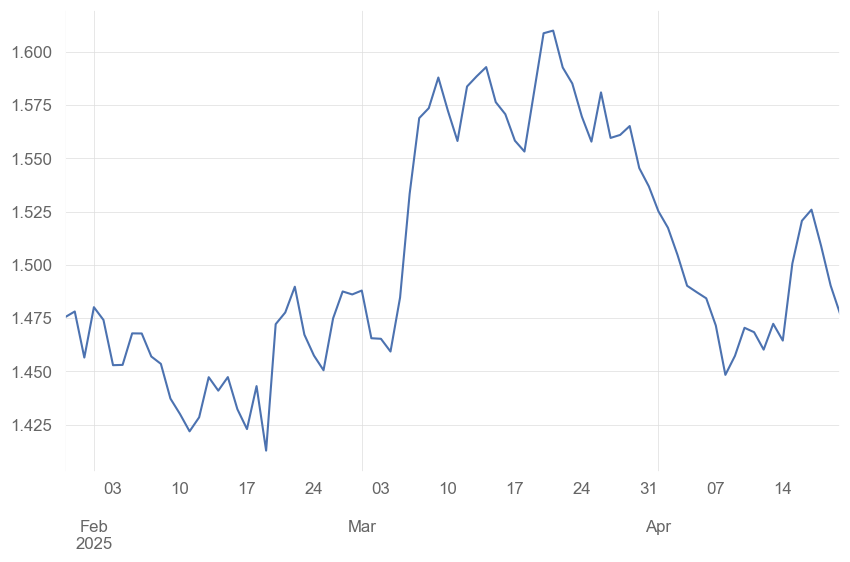

In [24]:
import quantstats as qs

((gfe["GFE"].pct_change(90).dropna()+1)**4).plot()

In [18]:
tarihler=pd.date_range(start="2024-12-01",end="2024-12-31")
for tarih in tarihler:
    try:
        tarih=tarih.strftime("%d.%m.%y")
        chrome_options = Options()
        chrome_options.add_argument("--headless")  
        chrome_options.add_argument("--disable-gpu")  
        chrome_options.add_argument("--no-sandbox")  

        driver = webdriver.Chrome(options=chrome_options)

        driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

        date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
        date_input.clear()
        date_input.send_keys(tarih)  

        price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
        price_button.click()

        all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
        all_pages_radio.click()

        excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
        excel_button.click()

        time.sleep(2)

        print(f"{tarih} çekildi!")

        driver.quit()
    except:
        chrome_options = Options()
        chrome_options.add_argument("--headless")  
        chrome_options.add_argument("--disable-gpu")  
        chrome_options.add_argument("--no-sandbox")  

        driver = webdriver.Chrome(options=chrome_options)

        driver.get("https://www.hal.gov.tr/Sayfalar/FiyatDetaylari.aspx")

        date_input = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_dateControl_dateControlDate")
        date_input.clear()
        date_input.send_keys(tarih)  

        price_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnGet")
        price_button.click()

        all_pages_radio = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_rblExcelOptions_1")
        all_pages_radio.click()

        excel_button = driver.find_element(By.ID, "ctl00_ctl37_g_7e86b8d6_3aea_47cf_b1c1_939799a091e0_btnExcel")
        excel_button.click()

        time.sleep(2)

        print(f"{tarih} çekildi!")

        driver.quit()
        


01.12.24 çekildi!
02.12.24 çekildi!
03.12.24 çekildi!
04.12.24 çekildi!
05.12.24 çekildi!
06.12.24 çekildi!
07.12.24 çekildi!
08.12.24 çekildi!
09.12.24 çekildi!
10.12.24 çekildi!
11.12.24 çekildi!
12.12.24 çekildi!
13.12.24 çekildi!
14.12.24 çekildi!
15.12.24 çekildi!
16.12.24 çekildi!
17.12.24 çekildi!
18.12.24 çekildi!
19.12.24 çekildi!
20.12.24 çekildi!
21.12.24 çekildi!
22.12.24 çekildi!
23.12.24 çekildi!
24.12.24 çekildi!
25.12.24 çekildi!
26.12.24 çekildi!
27.12.24 çekildi!
28.12.24 çekildi!
29.12.24 çekildi!
30.12.24 çekildi!
31.12.24 çekildi!


In [20]:
col=["Ürün"]
cols=np.sort(sebzeler.columns[:-1])
col.extend(cols)
sebzeler=(sebzeler[col].iloc[:,1:].T)
sebzeler.index=pd.to_datetime(sebzeler.index)
sebzeler=sebzeler.sort_index()

In [21]:
col=["Ürün"]
cols=np.sort(meyveler.columns[:-1])
col.extend(cols)
meyveler=(meyveler[col].iloc[:,1:].T)
meyveler.index=pd.to_datetime(meyveler.index)
meyveler=meyveler.sort_index()

In [22]:

w=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
meyveağırlık=w.loc[meyveler.columns]["Ağırlık"]/w.loc[meyveler.columns]["Ağırlık"].sum()
meyve_endeks=(meyveler*meyveağırlık).sum(axis=1)
meyve_endeks

Tarih
2024-12-01    39.229901
2024-12-02    33.697924
2024-12-03    42.269883
2024-12-04    36.412995
2024-12-05    37.864328
                ...    
2025-04-14    43.416894
2025-04-15    48.214514
2025-04-16    44.215070
2025-04-17    53.734666
2025-04-18    44.724032
Length: 139, dtype: float64

In [23]:
w=pd.read_csv("ağırlıklartüfe.csv",index_col=0)
sebzeağırlık=w.loc[sebzeler.columns]["Ağırlık"]/w.loc[sebzeler.columns]["Ağırlık"].sum()
sebze_endeks=(sebzeler*sebzeağırlık).sum(axis=1)
sebze_endeks

Tarih
2024-12-01    23.239601
2024-12-02    22.409904
2024-12-03    25.944970
2024-12-04    24.537766
2024-12-05    26.384272
                ...    
2025-04-14    22.509875
2025-04-15    25.163782
2025-04-16    24.146950
2025-04-17    24.201248
2025-04-18    22.773987
Length: 139, dtype: float64

In [24]:
meyvesebze=meyve_endeks*0.4+sebze_endeks*0.6

In [38]:
np.cumprod(meyvesebze.resample("M").mean().pct_change().fillna(0).dropna()+1)*100

,0,TÜİK
Tarih,,
2024-12-31,100.000000,100.00
2025-01-31,106.960379,103.41
2025-02-28,111.808261,102.16
2025-03-31,134.155727,118.54
2025-04-30,127.340449,0.00


In [47]:
meyvesebze=pd.DataFrame(meyvesebze)
meyvesebze["TÜİK"]=0
meyvesebze["TÜİK"].loc["2024-12"]=100
meyvesebze["TÜİK"].loc["2025-01"]=98.35
meyvesebze["TÜİK"].loc["2025-02"]=101.70

meyvesebze["TÜİK"].loc["2025-03"]=100.47
meyvesebze["TÜİK"].loc["2025-04"]=116.58



C:\Users\Bora\AppData\Local\Temp\ipykernel_16224\3627036409.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyvesebze["TÜİK"].loc["2024-12"]=100
C:\Users\Bora\AppData\Local\Temp\ipykernel_16224\3627036409.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meyvesebze["TÜİK"].loc["2025-01"]=98.35


In [51]:
meyvesebze.resample("M").mean().pct_change().dropna()

,0,TÜİK
Tarih,,
2025-01-31,0.069604,-0.016500
2025-02-28,0.045324,0.034062
2025-03-31,0.199873,-0.012094
2025-04-30,-0.050801,0.160346


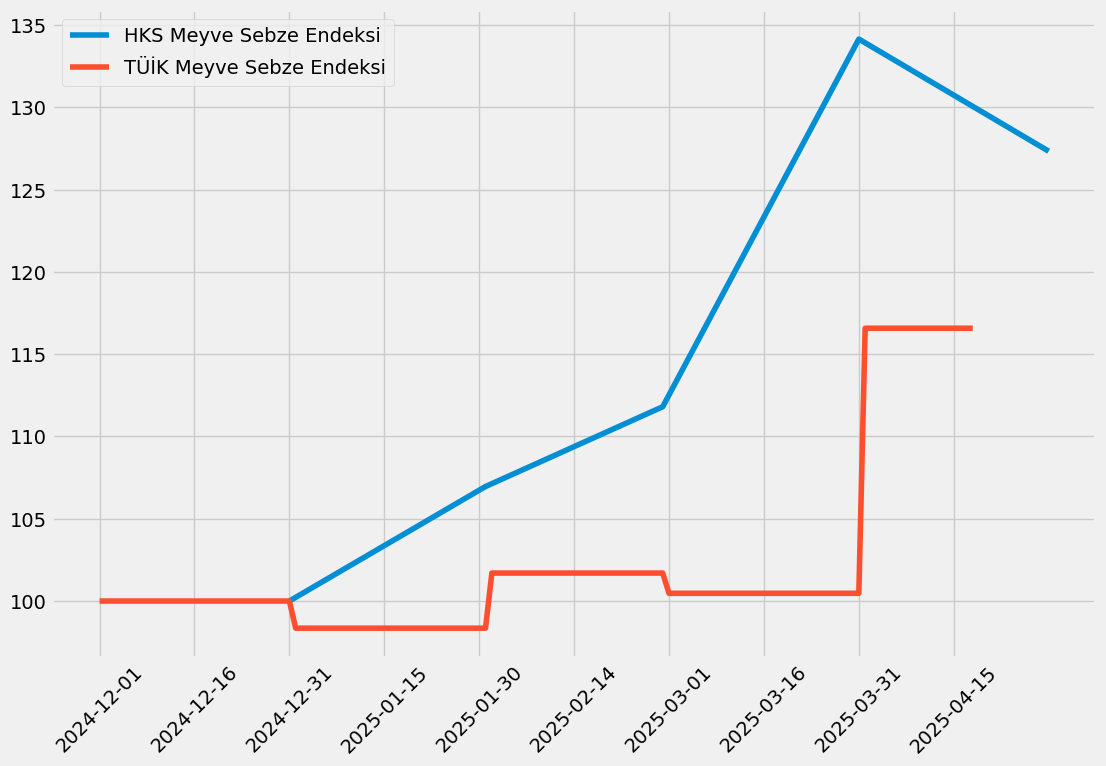

In [48]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))

plt.plot(np.cumprod(meyvesebze[0].resample("M").mean().pct_change().fillna(0)+1)*100,label="HKS Meyve Sebze Endeksi")
plt.plot(meyvesebze["TÜİK"],label="TÜİK Meyve Sebze Endeksi")
plt.xticks(meyvesebze.index[::15],rotation=45)
plt.legend()

In [19]:


import pandas as pd




import os
import glob

dosya_yolu = 'C:/Users/Bora/Downloads'  # Burada kendi dosya yolunuzu belirtin
datam=pd.DataFrame()
xls_dosyalari = glob.glob(os.path.join(dosya_yolu, '*.xls'))
for file in xls_dosyalari:
    df=pd.read_html(file)[0]
    df.index=[df.iloc[0,0][16:].split("(")[0][:-1]]*len(df)
    df.index=pd.to_datetime(df.index,dayfirst=True)
    df.columns=df.iloc[1].values
    df=df.iloc[2:]
    df["Ortalama Fiyat"]=df["Ortalama Fiyat"].astype(float)/100
    df["İşlem Hacmi"]=df["İşlem Hacmi"].astype(float)
    df["Hacimli"]=df["İşlem Hacmi"]*df["Ortalama Fiyat"]
    df["Tarih"]=df.index.strftime("%Y-%m-%d")
    df=df.set_index("Ürün Adı")
    df["Ağırlıklı Fiyat"]=df.groupby("Ürün Adı")["Hacimli"].sum()/df.groupby("Ürün Adı")["İşlem Hacmi"].sum()
    df["Ürün Adı"]=df.index
    df=df.set_index("Tarih")
    datam=pd.concat([datam,df],axis=0)



w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
sebzeler=pd.DataFrame()
import numpy as np
for sebze in w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values:
    if sebze=="Çarliston Biber":
        sebze="Biber Çarliston"
    elif sebze=="Dolmalık Biber":
        sebze="Biber Dolmalık"
    elif sebze=="Sivri Biber":
        sebze="Biber Sivri"   
    elif sebze=="Taze Fasulye":
        sebze="Fasulye Taze" 
    elif sebze=="Kuru Soğan":
        sebze="Soğan Kuru"
    elif sebze=="Kırmızı Turp":
        sebze="turp"
    
    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(sebze,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[sebze]*len(hal)



    print(f"{sebze} verisi bulundu")
    sebzeler=pd.concat([sebzeler,hal],axis=0)


sebzeler.index=w[w["Unnamed: 5"]=="Taze sebzeler (patates hariç)"]["Unnamed: 1"].values
sebzeler["Ürün"]=f"HKS" + sebzeler.index




w=pd.read_excel("Weights_2022.xlsx").iloc[4:132,[1,5]]
w=w.fillna(method="ffill")
meyveler=pd.DataFrame()
import numpy as np
for meyve in w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values:

    hal=pd.DataFrame(datam[datam["Ürün Adı"].str.contains(meyve,case=False)])
    hal=hal.groupby("Tarih")["Ağırlıklı Fiyat"].mean()

    hal=pd.DataFrame(hal).T
    hal.index=[meyve]*len(hal)



    print(f"{meyve} verisi bulundu")
    meyveler=pd.concat([meyveler,hal],axis=0)


meyveler.index=w[w["Unnamed: 5"]=="Taze Meyveler"]["Unnamed: 1"].values
meyveler["Ürün"]=f"HKS" + meyveler.index






Biber Çarliston verisi bulundu
Biber Dolmalık verisi bulundu
Biber Sivri verisi bulundu
Dereotu verisi bulundu
Domates verisi bulundu
Fasulye Taze verisi bulundu
Havuç verisi bulundu
Ispanak verisi bulundu
Kabak verisi bulundu
Karnabahar verisi bulundu
Soğan Kuru verisi bulundu
Beyaz Lahana verisi bulundu
Kırmızı Lahana verisi bulundu
Mantar verisi bulundu
Kıvırcık verisi bulundu
Maydanoz verisi bulundu
Nane verisi bulundu
Patlıcan verisi bulundu
Pırasa verisi bulundu
Roka verisi bulundu
Salatalık verisi bulundu
Sarımsak verisi bulundu
turp verisi bulundu
Portakal verisi bulundu
Üzüm verisi bulundu
Armut verisi bulundu
Ayva verisi bulundu
Çilek verisi bulundu
Elma verisi bulundu
Karpuz verisi bulundu
Kavun verisi bulundu
Kivi verisi bulundu
Limon verisi bulundu
Mandalina verisi bulundu
Muz verisi bulundu
Nar verisi bulundu
Şeftali verisi bulundu


In [4]:
file 

'C:/Users/Bora/Downloads\\1744974593049_StandardPoors.xls'

In [ ]:
import pandas as pd
data1=pd.read_csv("sepet.csv",index_col=0)
data1=data1.drop_duplicates() 
data1.to_csv("sepet.csv")
degisim=data1.iloc[:,1:].pct_change(axis=1)
degisim=degisim.iloc[:,-1]
from scipy.stats import gmean
temp1=(1+(degisim.dropna())).groupby(level=0).apply(lambda x: np.prod(x)**(1 / len(x)))
df=ağırlıklar.loc[temp1.index]
df["Ağırlık"]=df["Ağırlık"]/df["Ağırlık"].sum()
temp1=(temp1-1)*100
temp=np.sum(df["Ağırlık"].sort_index()*temp1.sort_index())

In [8]:
ağırlıklar

NameError: name 'ağırlıklar' is not defined

<Figure size 2500x1500 with 0 Axes>

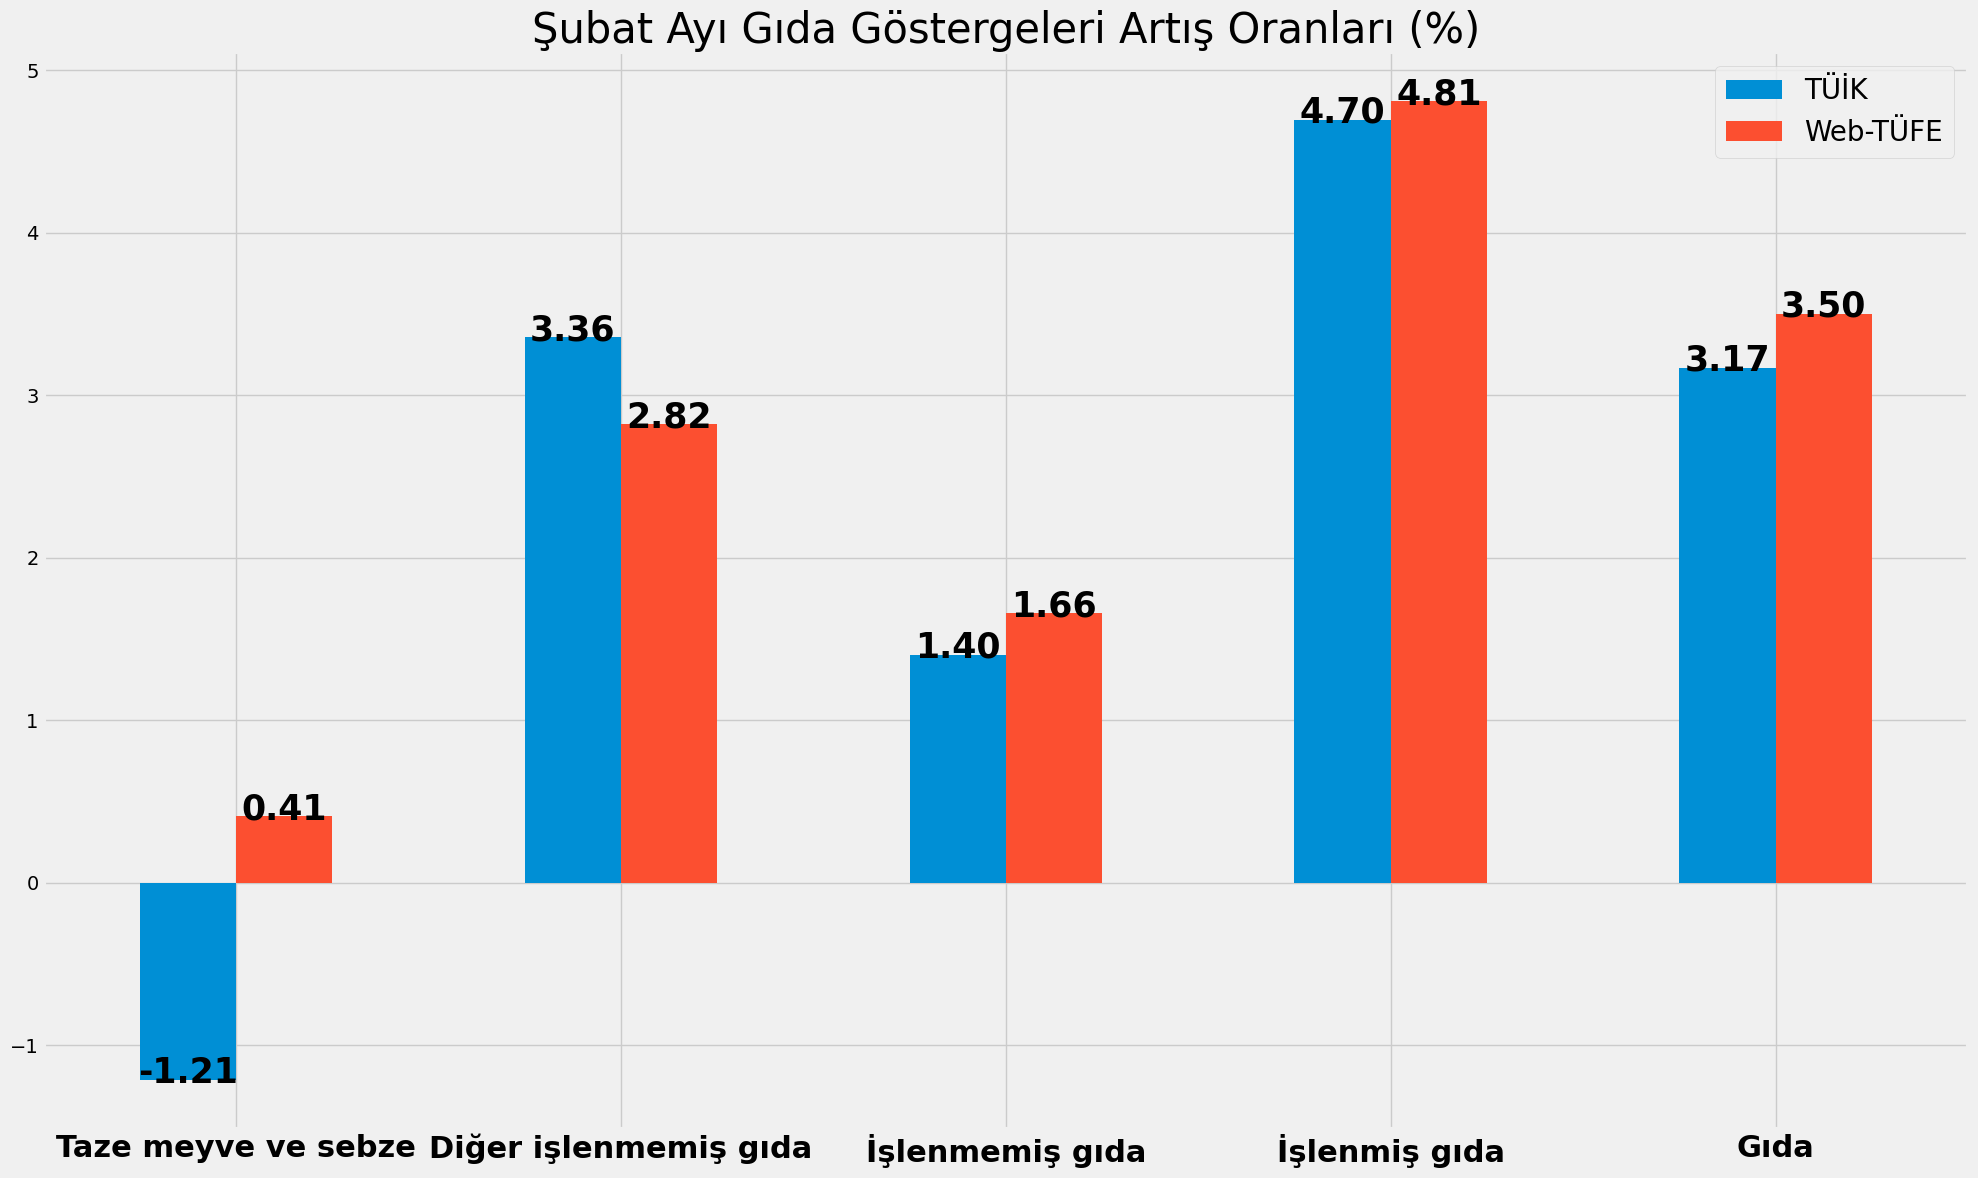

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
tüik=pd.read_csv("tüikim.csv",index_col=0)
plt.style.use("fivethirtyeight")
# Creating the data
data = {
    "TÜİK": tüik.pct_change().iloc[-1]*100,
    "Web-TÜFE": [0.41,2.82,1.66,4.81],

}

# Convert to DataFrame
df = pd.DataFrame(data)
df.loc["Gıda"]=[3.17,3.5]


# Plotting the bar chart with bold values on top of the bars
plt.figure(figsize=(25, 15))
ax = df.plot(kind='bar', figsize=(20, 12))

# Adding the values on top of the bars with bold text
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=25, fontweight='bold', color='black', xytext=(0, 5), textcoords='offset points')

plt.title("Şubat Ayı Gıda Göstergeleri Artış Oranları (%)",fontsize=30)

plt.xticks(rotation=0,fontsize=22,fontweight="bold")
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()


In [37]:
gıda=pd.read_excel("ozel kapsamli tufe gostergeleri (1).xls")
gıda=gıda.iloc[50:51,3:].T
gıda.columns=["Aylık Değişim"]
gıda=gıda.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(gıda)))
gıda=gıda.loc["2024-11-30":]
gıda["Tarih"]=gıda.index.strftime("%Y-%m")
gıda=gıda.reset_index(drop=True)
gıda_c=gıda[["Tarih","Aylık Değişim"]]


aylık_endeks_tüik=list(gıda_c["Aylık Değişim"])
tüik_aylık=[1]
tüik_aylık.extend(list(((np.array(aylık_endeks_tüik)/100))+1))
tüik_aylık=pd.DataFrame(tüik_aylık,columns=["TÜİK"])
tüik_aylık=np.cumprod(tüik_aylık)*100

tüik_aylık.index=pd.date_range(start="2024-10-31",freq="M",periods=len(tüik_aylık)).strftime("%Y-%m-%d")
tüik_aylık.index=pd.to_datetime(tüik_aylık.index)

C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\2351233369.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gıda=gıda.set_index(pd.date_range(start="2005-01-31",freq="M",periods=len(gıda)))
C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\2351233369.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tüik_aylık.index=pd.date_range(start="2024-10-31",freq="M",periods=len(tüik_aylık)).strftime("%Y-%m-%d")


In [39]:
gfe=pd.read_csv("gfe.csv",index_col=0)
gfe.index=pd.to_datetime(gfe.index)
gfe["TÜİK"]=tüik_aylık["TÜİK"]
gfe=gfe.fillna(method="ffill")
gfe=gfe.fillna(100)

C:\Users\Bora\AppData\Local\Temp\ipykernel_24220\1037474672.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gfe=gfe.fillna(method="ffill")


In [ ]:
"""
    sa_data=pd.DataFrame()
    for col in tüik.columns:
        sa_data[f"{col} Aylık Ortalama"]=hareketli_aylik_ortalama(özelgöstergeler[col]).iloc[:,[-1,]]
        sa_data[f"{col} Aylık Ortalama"]=sa_data[f"{col} Aylık Ortalama"].fillna(method="ffill")
        sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end')
        sa_data["Önceki"]=(sa_data.index.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')
        sa_data.loc["2024-10","Önceki"]=pd.NA
        sa_data[f"{col} Önceki Endeks"]=pd.NA
        sa_data.loc["2024-11-01":,f"{col} Önceki Endeks"]=sa_data.loc[sa_data["Önceki"].dropna(),f"{col} Aylık Ortalama"].values

    sa_datadegisim=pd.DataFrame(index=pd.to_datetime(sa_data.loc["2024-11":].index))
    for col in tüik.columns:
        sa_datadegisim[col]=((sa_data[f"{col} Aylık Ortalama"]/sa_data[f"{col} Önceki Endeks"]).dropna()).values
        sa_datadegisim[col]=sa_datadegisim[col].astype(float)
        sa_datadegisim.index=pd.to_datetime(sa_datadegisim.index)
    sa_datadegisim=sa_datadegisim.resample('M').last()   
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Taze meyve ve sebze")] = [1.082103253420332, 1.0378297012546769]
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("Diğer işlenmemiş gıda")] = [1.0333601398698096, 1.014720660120335]



    for col in sa_datadegisim.columns:
        sa_datadegisim[f"{col} MA"]=pd.NA


        for row in sa_datadegisim.index:
                tüik_data=tüik[col].loc[:(row.to_period('M') - 1).to_timestamp(how='end').strftime('%Y-%m-%d')]
                tüik_data.loc[pd.to_datetime((row.to_period('M')).to_timestamp(how='end').strftime('%Y-%m-%d'))]=tüik_data.iloc[-1]*sa_datadegisim[col].loc[row]
                from statsmodels.tsa.x13 import x13_arima_analysis


                np.random.seed(42)



                x13_path = r'C:\Users\Bora\Desktop\x13as'
                
                

                
                ayris = x13_arima_analysis(tüik_data, x12path=x13_path,outlier=False,log=False)
                sa_datadegisim[f"{col} MA"].loc[row]=ayris.seasadj.pct_change().iloc[-1]*100


    for col in tüik.columns:
        sa_datadegisim[f"{col} Faktör"]=((sa_datadegisim[f"{col} MA"]/100)+1)/sa_datadegisim[col]
        sa_datadegisim["Ay"]=sa_datadegisim.reset_index()["Tarih"].dt.month.values

    sa_datadegisim.columns=['Taze meyve ve sebze', 'Diğer işlenmemiş gıda',
    'SA Taze meyve ve sebze', 'SA Diğer işlenmemiş gıda',
    'Taze meyve ve sebze Faktör', 'Ay', 'Diğer işlenmemiş gıda Faktör']
    sa_datadegisim["İşlenmiş gıda"]=hareketli_aylik_ortalama(özelgöstergeler["İşlenmiş gıda"])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
    sa_datadegisim.iloc[:2, sa_datadegisim.columns.get_loc("İşlenmiş gıda")] = [2.61412286061347, 1.60328139006671]


    ağırlıklar=pd.read_csv("ağırlıklar.csv",index_col=0)
    w=pd.read_excel("Weights_2022.xlsx").iloc[:133,:6]
    w["Unnamed: 5"]=w["Unnamed: 5"].fillna(method="ffill")
    meyveler=w[w["Unnamed: 5"].isin(["Taze Meyveler"])]["Unnamed: 1"].values
    sebzeler=w[w["Unnamed: 5"].isin(["Taze sebzeler (patates hariç)"])]["Unnamed: 1"].values
    meyvesebze=np.concatenate([meyveler,sebzeler])
    digerislenmemis=["Dana Eti","Kuzu Eti","Tavuk Eti","Sakatat","Balık","Konserve Balık","Yumurta"]

    islenmemis=digerislenmemis+list(meyvesebze)

    ağırlıklar=ağırlıklar.reset_index()
    meyvesebzeler=ağırlıklar[ağırlıklar["Ürün"].isin(meyvesebze)].iloc[:,[0,3]]
    meyvesebzeler.index=len(meyvesebzeler)*["SA Taze meyve ve sebze"]
    digerislenmemisler=ağırlıklar[ağırlıklar["Ürün"].isin(digerislenmemis)].iloc[:,[0,3]]
    digerislenmemisler.index=len(digerislenmemisler)*["SA Diğer işlenmemiş gıda"]
    islenmemisler=pd.concat([meyvesebzeler,digerislenmemisler],axis=0)
    islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()

    sa_datadegisim["SA İşlenmemiş gıda"]=(sa_datadegisim[islenmemisler.sort_index().index.unique()]*islenmemisler.groupby(level=0)["Ağırlık"].sum()/islenmemisler.groupby(level=0)["Ağırlık"].sum().sum()).sum(axis=1)


    islenmisler=ağırlıklar[~ağırlıklar["Ürün"].isin(islenmemisler["Ürün"].values)].iloc[:,[0,3]]
    islenmisler.index=len(islenmisler)*["İşlenmiş gıda"]

    islenmemisler.index=["SA İşlenmemiş gıda"]*len(islenmemisler)

    genel=pd.concat([islenmemisler,islenmisler],axis=0)

    sa_datadegisim["SA Web-GFE"]=(sa_datadegisim[genel.sort_index().groupby(level=0)["Ağırlık"].sum().index]*genel.groupby(level=0)["Ağırlık"].sum()).sum(axis=1)
    sa_datadegisim.to_csv("magöstergeler.csv")
"""

In [ ]:
göstergeaylık=pd.DataFrame()
for col in tüik.columns:
    göstergeaylık[col]=hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].fillna(method="ffill").resample('M').last().pct_change().dropna()*100
    göstergeaylık[col].iloc[-1]=(((hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].iloc[-1]/hareketli_aylik_ortalama(özelgöstergeler[col])["Aylık Ortalama"].loc["2025-02-01"]))-1)*100

In [27]:
göstergeaylık


,Taze meyve ve sebze,Diğer işlenmemiş gıda,İşlenmemiş gıda,İşlenmiş gıda
Tarih,,,,
2024-11-30,5.477013,1.741840,3.612414,0.861357
2024-12-31,6.073420,3.877814,4.924704,2.034034
2025-01-31,6.135508,3.243180,4.713203,2.438807
2025-02-28,-0.040998,2.862252,1.335669,4.798631
2025-03-31,12.344673,3.698780,7.990578,2.912418


In [19]:
from datetime import date
import requests
import json
from urllib.parse import urlencode
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': freq,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME'])


    return seri

series_list=["TP.FE.OKTG10","TP.FE.OKTG11","TP.FE.OKTG09","TP.FE.OKTG12"]
tüik=pd.DataFrame()
for series in series_list:
    veri=evds_vericek(series,5)
    tüik=pd.concat([tüik,veri],axis=1)
tüik=tüik.drop("Tarih",axis=1)
tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))
tüik=tüik.loc["2016":]
tüik.columns=['Taze meyve ve sebze','Diğer işlenmemiş gıda','İşlenmemiş gıda','İşlenmiş gıda']
tüik.to_csv("tüikim.csv")


git_add_commit_push()


C:\Users\Bora\AppData\Local\Temp\ipykernel_9800\2997715634.py:38: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  tüik=tüik.set_index(pd.date_range(start="2010-01-31",freq="M",periods=len(tüik)))


Commit işlemi başarılı: update
Push işlemi başarılı.
